In [1]:
import numpy as np
from qiskit.circuit.library import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes
from qiskit.circuit import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                 import *
from   qiskit.quantum_info    import Pauli,Operator
from   qiskit.aqua.operators  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator
from   qiskit.aqua.operators.primitive_ops import MatrixOp
from   qiskit.aqua.operators.legacy import MatrixOperator,op_converter
from   qiskit.aqua.algorithms import NumPyEigensolver,NumPyMinimumEigensolver

import math
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from scipy import linalg as LA

We want to use the VQE algorithm to study the Hamiltonian of the anti-ferromagnetic Heinsenberg model for a "bow-tie" lattice with zero field. The hamiltonian is given by:

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\}$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$ and $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

In the following we define the functions useful to define our Hamiltonian.

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin



Here we have the functions to create the **projection operators**.

In [3]:
# The following function gives the different eigenvalues of X and the projectors on the associated eigenspaces 
def get_eigenpairs(X):
    '''
    H = \sum_e e Pi(e) 
    '''
    from scipy                        import linalg as LA
    from qiskit.aqua.operators.legacy import op_converter
    #M     = op_converter.to_matrix_operator(X)._matrix.todense()    # with WeightedPauliOperators
    M     = X.to_matrix()     # with SummedOp
    assert(np.abs(np.imag(M)).max()<1e-4)
    M     = np.real(M)
    e,U   = LA.eigh(M)
    e_set = set([round(x,6) for x in e])
    e_set = sorted(e_set)
    
    Pi=[]    # It's a list!
    
    for i,ei in enumerate(e_set):
        idx_i = np.where(np.abs(e-ei)<1e-3)[0]
        Pi.append(np.dot(U[:,idx_i],np.transpose(U[:,idx_i])))
    
    return e_set,Pi

'''
Lines from 16 to 20 can be substituted by the following lines. The idea is to calculate the
subspace projection with the matrix (A \dot A^T) where A is the matrix with columns given by 
the normalized eigenvectors contained in U

Pi    = np.zeros((M.shape[0],M.shape[0],len(e_set)))

for i,ei in enumerate(e_set):
    idx_i = np.where(np.abs(e-ei)<1e-3)[0]
    Pi[:,:,i] = np.einsum('ix,jx->ij',U[:,idx_i],U[:,idx_i])
        
'''

def get_Pab():
    for i in range(2):
        c_T = QuantumCircuit(QuantumRegister(H.num_qubits,'q') )
        if i==0:
            c_T.swap(1,4)
            c_T.swap(0,3)
            Rv=MatrixOp(Operator(c_T)).to_matrix()
        if i==1:
            c_T.swap(3,4)
            c_T.swap(0,1)
            Rh=MatrixOp(Operator(c_T)).to_matrix()
    
    Id=np.identity(2**5)
    P00=np.dot(1/4,np.add(np.add(Id,Rv),np.add(Rh,np.dot(Rv,Rh))))
    P10=np.dot(1/4,np.add(np.add(Id,np.dot(-1,Rv)),np.add(Rh,np.dot(-1,np.dot(Rv,Rh)))))
    P01=np.dot(1/4,np.add(np.add(Id,Rv),np.add(np.dot(-1,Rh),np.dot(-1,np.dot(Rv,Rh)))))
    P11=np.dot(1/4,np.add(np.add(Id,np.dot(-1,Rv)),np.add(np.dot(-1,Rh),np.dot(Rv,Rh))))
    
    P_name=["a=0,b=0","a=0,b=1","a=1,b=0","a=1,b=1"]
    P=[P00,P01,P10,P11]
    P=zip(P_name,P)
    
    return P

def get_Pspin():
    sz=[]
    for i in range (5):
        sz.append((1.0,generate_pauli([],[i],nqubit)))
    sz=WeightedPauliOperator(sz)
    mat_sz=op_converter.to_matrix_operator(sz).dense_matrix

    sx=[]
    for i in range (5):
        sx.append((1.0,generate_pauli([i],[],nqubit)))
    sx=WeightedPauliOperator(sx)
    mat_sx=op_converter.to_matrix_operator(sx).dense_matrix

    sy=[]
    for i in range (5):
        sy.append((1.0,generate_pauli([i],[i],nqubit)))
    sy=WeightedPauliOperator(sy)
    mat_sy=op_converter.to_matrix_operator(sy).dense_matrix

    s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
    mat_s2=op_converter.to_matrix_operator(s2).dense_matrix

    sigmas2,Us2 = LA.eigh(mat_s2)

    # If we call U2 the matrix that diagonalizes S^2, we calculate US2^{-1} USz US2
    mat_sz2=np.dot(np.dot(LA.inv(Us2),mat_sz),Us2)

    #Matrices corresponding to eigenvalues of S2
    mat_sz21=np.zeros((10,10),dtype=np.complex_)
    mat_sz22=np.zeros((16,16),dtype=np.complex_)
    mat_sz23=np.zeros((6,6),dtype=np.complex_)

    for i in range(10):
        for j in range(10):
            mat_sz21[i,j]=mat_sz2[i,j]

    for i in range(16):
        for j in range(16):
            mat_sz22[i,j]=mat_sz2[10+i,10+j]

    for i in range(6):
        for j in range(6):
            mat_sz23[i,j]=mat_sz2[26+i,26+j]

    sigma_sz21,Usz21=LA.eigh(mat_sz21)
    sigma_sz22,Usz22=LA.eigh(mat_sz22)
    sigma_sz23,Usz23=LA.eigh(mat_sz23)

    # We build the matrix that diagonalizes Sz2 following the S^2 eigenvalues: s=1,s=3,s=5
    Vsz2=np.zeros((2**5,2**5),dtype=np.complex_)
    for i in range(10):
        for j in range(10):
            Vsz2[i,j]=Usz21[i,j]

    for i in range(16):
        for j in range(16):
            Vsz2[10+i,10+j]=Usz22[i,j]

    for i in range(6):
        for j in range(6):
            Vsz2[26+i,26+j]=Usz23[i,j]

    sz2_diag=np.dot(LA.inv(Vsz2),np.dot(mat_sz2,Vsz2))

    # Matrix that diagonalizes Sz as we want
    Vtot=np.dot(Us2,Vsz2)
    sz_diag=np.dot(LA.inv(Vtot),np.dot(mat_sz,Vtot))
    # A1 is the matrix of eigenvectors related to s=1,sz=-1
    A1=Vtot[:,np.arange(5)]
    # A2 is the matrix of eigenvectors related to s=1,sz=1
    A2=Vtot[:,np.arange(5,10)]

    P1=np.dot(A1,np.transpose(A1))
    P2=np.dot(A2,np.transpose(A2))
    P=[P1,P2]
    P_name=["s=1,sz=-1","s=1,sz=1"]
    return zip(P_name,P)

We show the **so4** variational form.

In [4]:
from  typing import List, Optional, Union
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import InitialState

class so4(VariationalForm): # definizione di un Ansatz variazionale 
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        self._connections = connections
        self._num_parameters = len(connections)*reps*6
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    def append_so4(self,circuit,qubit1,qubit2,parameters):
        circuit.s(qubit1)
        circuit.s(qubit2)
        circuit.h(qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.u(parameters[0],parameters[1],parameters[2],qubit1)
        circuit.u(parameters[3],parameters[4],parameters[5],qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.h(qubit2)
        circuit.sdg(qubit1)
        circuit.sdg(qubit2)

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        m = 0
        for l in range(self._reps):
            for [i,j] in self._connections:
                self.append_so4(circuit,i,j,parameters[6*m:6*(m+1)])
                m += 1
        return circuit

Here we define the reference value for the ground state energy. We diagonalize the Heisenberg Hamiltonian.

In [5]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]
H       = generate_Heisenberg(nqubit,nn_list)

ee = NumPyMinimumEigensolver(H)
result = ee.run()
ref = result.eigenvalue.real
print('Ground state energy: {}'.format(ref))

2020-12-18 17:10:15,542:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-6.+4.23113481e-17j]),
    'eigvecs': array([[-3.89776402e-17+5.10165548e-17j,  3.61974282e-17-1.42030259e-17j,
         8.72303518e-17+4.15500394e-17j, -2.74499843e-16-1.28677068e-17j,
         1.74630000e-16-3.55387935e-16j, -2.69765989e-01+1.54170485e-01j,
         2.69765989e-01-1.54170485e-01j,  4.28729112e-17-2.16661053e-16j,
         2.85313390e-17-1.15117520e-17j, -2.04190753e-03+1.70368077e-01j,
        -2.09060026e-01-5.23325184e-02j, -2.43608213e-01-1.37865820e-01j,
         2.11101934e-01-1.18035559e-01j,  2.84548430e-01+1.86481592e-01j,
        -4.09402170e-02-4.86157720e-02j,  5.60415841e-17+5.98826011e-17j,
         1.27195165e-17-1.81207333e-17j,  2.71807897e-01-3.24538562e-01j,
        -6.07059631e-02+2.06503003e-01j,  2.43608213e-01+1.37865820e-01j,
        -2.11101934e-01+1.18035559e-01j, -1.54045849e-01-2.04018620e-01j,
        -

Ground state energy: -6.000000000000012


### Algorithm execution 

In [6]:
# Algorithm execution

# 1. On classical computer WITHOUT statistical uncertainties, namely (Psi|H|Psi) algebraically evaluated
backend_1          = Aer.get_backend('statevector_simulator') # <----
quantum_instance_1 = QuantumInstance(backend=backend_1)

# 2. On classical computer WITH statistical uncertainties and hopefully decoherence model
backend_2          = Aer.get_backend('qasm_simulator') # <---- (Psi|H|Psi) sampled
quantum_instance_2 = QuantumInstance(backend=backend_2,shots=8000)

# 3. On quantum computer ...

2020-12-18 17:10:17,051:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2020-12-18 17:10:17,056:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-12-18 17:10:17,073:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'qasm_si

Here we create a function to get the eigenvectors of $H$ which are also eigenstates of $R_v$ and $R_h$. The first two are related to $a=1,b=1$, the second couple to $a=0,b=1$ and the third to $a=0,b=0.$

In [7]:
def get_proj_ground_eigv():   
    for i in range(2):
        c_T = QuantumCircuit(QuantumRegister(H.num_qubits,'q') )
        if i==0:
            c_T.swap(1,4)
            c_T.swap(0,3)
            Rv=MatrixOp(Operator(c_T)).to_matrix()
        if i==1:
            c_T.swap(3,4)
            c_T.swap(0,1)
            Rh=MatrixOp(Operator(c_T)).to_matrix()

    n=2**5
    # diagonalize symmetry Rv
    sigmav,Uv = LA.eigh(Rv)

    mat_H=H.to_matrix()
    mat_Hv=np.dot(np.dot(LA.inv(Uv),mat_H),Uv)

    #Diagonalization of the block matrices H_{-1} and H_{1} correspondig to Rv

    #Block matrix corresponding to eigenvalue -1 of Rv
    mat_Hv1=np.zeros((12,12),dtype=np.complex_)
    #Block matrix corresponding to eigenvalue 1 of Rv
    mat_Hv2=np.zeros((20,20),dtype=np.complex_)

    for i in range(12):
        for j in range(12):
            mat_Hv1[i,j]=mat_Hv[i,j]
    for i in range(20):
        for j in range(20):
            mat_Hv2[i,j]=mat_Hv[12+i,12+j]

    Rh_v=np.dot(np.dot(LA.inv(Uv),Rh),Uv)

    #Diagonalization of the block matrices Rh_{-1} and Rh_{1} where +1/-1 refer to Rv

    #Block matrix corresponding to eigenvalue -1 of Rv
    Rh_v1=np.zeros((12,12),dtype=np.complex_)
    #Block matrix corresponding to eigenvalue 1 of Rv
    Rh_v2=np.zeros((20,20),dtype=np.complex_)

    for i in range(12):
        for j in range(12):
            Rh_v1[i,j]=Rh_v[i,j]
    for i in range(20):
        for j in range(20):
            Rh_v2[i,j]=Rh_v[12+i,12+j]

    sigmaRh_v1,Vh1=LA.eigh(Rh_v1)
    sigmaRh_v2,Vh2=LA.eigh(Rh_v2)

    mat_Hvh1=np.dot(np.dot(LA.inv(Vh1),mat_Hv1),Vh1)
    mat_Hvh2=np.dot(np.dot(LA.inv(Vh2),mat_Hv2),Vh2)

    mat_H11=np.zeros((6,6),dtype=np.complex_)
    mat_H10=np.zeros((6,6),dtype=np.complex_)
    mat_H01=np.zeros((6,6),dtype=np.complex_)
    mat_H00=np.zeros((14,14),dtype=np.complex_)

    for i in range(6):
        for j in range(6):
            mat_H11[i,j]=mat_Hvh1[i,j]

    for i in range(6):
        for j in range(6):
            mat_H10[i,j]=mat_Hvh1[6+i,6+j]

    for i in range(6):
        for j in range(6):
            mat_H01[i,j]=mat_Hvh2[i,j]

    for i in range(14):
        for j in range(14):
            mat_H00[i,j]=mat_Hvh2[6+i,6+j]

    e11,m11 = LA.eigh(mat_H11)
    e10,m10 = LA.eigh(mat_H10)
    e01,m01 = LA.eigh(mat_H01)
    e00,m00 = LA.eigh(mat_H00)

    e_tot=np.round(np.concatenate((e11,e10,e01,e00),axis=0),2)
    m_complete=np.zeros((n,n), dtype=np.complex_)

    for i in range(6):
        for j in range(6):
            m_complete[i,j]=m11[i,j]

    for i in range(6):
        for j in range(6):
            m_complete[6+i,6+j]=m10[i,j]

    for i in range(6):
        for j in range(6):
            m_complete[12+i,12+j]=m01[i,j]

    for i in range(14):
        for j in range(14):
            m_complete[18+i,18+j]=m00[i,j]


    V_complete=np.zeros((n,n), dtype=np.complex_)

    for i in range(12):
        for j in range(12):
            V_complete[i,j]=Vh1[i,j]

    for i in range(20):
        for j in range(20):
            V_complete[12+i,12+j]=Vh2[i,j]

    D=np.dot(np.dot(Uv,V_complete),m_complete)

    H_diag=np.dot(LA.inv(D),np.dot(mat_H,D))
    H_ground_eigv=[]
    for i in range(n):
        if np.round(H_diag[i,i],3)==-6:
            #print(i)
            H_ground_eigv.append(D[:,i])
            
    return H_ground_eigv

# Initial states

## Initial state $\psi_1=|0\rangle^{\otimes 5}$

In [8]:
psi_1   = Zero(H.num_qubits)                            # tensor product of zeros: |0)|0)|0)|0)|0)
psi_1_c = psi_1.construct_circuit()
display(Markdown(r"Initial state $\psi_1=|0\rangle^{\otimes 5}$"))
print(psi_1_c.draw())

Initial state $\psi_1=|0\rangle^{\otimes 5}$

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     


## Initial state $\psi_3$

We want to create a state $|\psi_3\rangle$ such that:

$$|\psi_3\rangle=R_z\Bigl(\frac{2\pi}{3}\Bigr)|\chi\rangle_0 R_z^2\Bigl(\frac{2\pi}{3}\Bigr)|\chi\rangle_1 |\chi\rangle_2 R_z\Bigl(-\frac{2\pi}{3}\Bigr)|\chi\rangle_3 R_z^2\Bigl(-\frac{2\pi}{3}\Bigl)|\chi\rangle_4$$

where $R_\alpha$ refers to a rotation on axis $\alpha=\{x,y,z\}$ and $|\chi \rangle_i$ is a generic state on lattice site $i=0,1,2,3,4$.
We want that $R_z^3(\theta)=\mathbb{1}$, therefore we choose $\theta=\frac{2}{3}\pi=120°$. We choose also $|\chi \rangle_i= R_y(\frac{\pi}{2})|0\rangle_i=\frac{|0 \rangle_i + |1 \rangle_i}{\sqrt{2}}$. We note that this state is the **classical Heisenberg ground state** (see paper by Chalker).



We remind that $R_z^2(\theta)=R_z(2\theta)$ and $R_y^2(\theta)=R_y(2\theta)$.

In [9]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

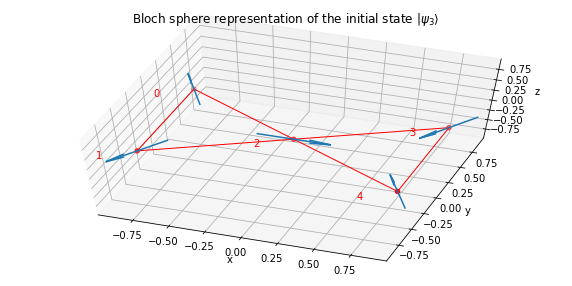

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]        

u=[-0.5,-0.5,1,-0.5,-0.5]
v=[0.866,-0.866,0,-0.866,0.866]
w=[0,0,0,0,0]

ax.set_title(r"Bloch sphere representation of the initial state $|\psi_3 \rangle$")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-70)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.2,y[i]-0.2,z[i],i,color='red')
            
plt.show()

In [11]:
qr  = QuantumRegister(H.num_qubits,'q')                 #n qubit register
c_T = QuantumCircuit(qr) 

theta=2*np.pi/3
for i in range(nqubit):
    c_T.ry(np.pi/2,i)
    #c_T.rz(np.pi/6,i)

c_T.rz(theta,0)
c_T.rz(theta*2,1)
c_T.rz(-theta,3)
c_T.rz(-theta*2,4)

psi_3   = Custom(H.num_qubits,state='zero',circuit=c_T) # Here I custom the circuit
display(Markdown(r"Initial state $\psi_3$"))
print(psi_3.construct_circuit().draw())

Initial state $\psi_3$

global phase: 0
     ┌────────────┐┌─────────────┐ 
q_0: ┤ U(π/2,0,0) ├┤ U(0,0,2π/3) ├─
     ├────────────┤├─────────────┤ 
q_1: ┤ U(π/2,0,0) ├┤ U(0,0,4π/3) ├─
     ├────────────┤└─────────────┘ 
q_2: ┤ U(π/2,0,0) ├────────────────
     ├────────────┤┌──────────────┐
q_3: ┤ U(π/2,0,0) ├┤ U(0,0,-2π/3) ├
     ├────────────┤├──────────────┤
q_4: ┤ U(π/2,0,0) ├┤ U(0,0,-4π/3) ├
     └────────────┘└──────────────┘


## Initial state $\psi_5$

If we select an initial state with coplanar qubits arrows with the variational form they would be coplanar in all the steps of the algorithm. We want to create a state similar to $|\psi_3\rangle$ such that:

$$|\psi_5\rangle=R_z(\theta)|\psi_k\rangle_0 R_z^2(\theta)|\psi_k\rangle_1 |\psi_k\rangle_2 R_z(-\theta)|\psi_k\rangle_3 R_z^2(-\theta)|\psi_k\rangle_4$$

where $R_\alpha$ refers to a rotation on axis $\alpha=\{x,y,z\}$ and $|\psi_k \rangle_i$ is a generic state on lattice site $i=0,1,2,3,4$.
We want that $R_z^3(\theta)=\mathbb{1}$, therefore we choose $\theta=\frac{2}{3}\pi=120°$. We choose also $|\psi_k \rangle_i= R_y(\frac{3}{4}\pi)|0\rangle_i$. In other words this is the **classical Heisenberg ground state** where each qubit has **Bloch sphere latitude equal to $\frac{\pi}{4}$**. 



We remind that $R_z^2(\theta)=R_z(2\theta)$ and $R_y^2(\theta)=R_y(2\theta)$.

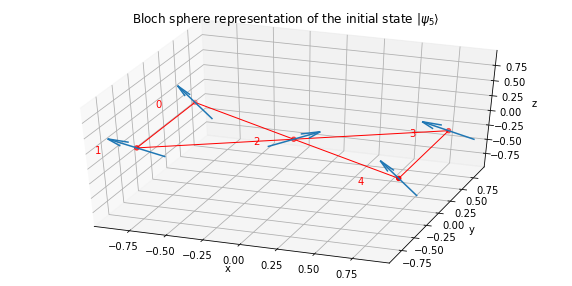

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]        

u=[-0.612,-0.612,0.707,-0.612,-0.612]
v=[0.354,-0.354,0,-0.354,0.354]
w=[0.707,0.707,0.707,0.707,0.707]

ax.set_title(r"Bloch sphere representation of the initial state $|\psi_5\rangle$")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(40,-70)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.2,y[i]-0.2,z[i],i,color='red')
            
plt.show()

In [13]:
qr  = QuantumRegister(H.num_qubits,'q')                 #n qubit register
c_T = QuantumCircuit(qr) 

theta=2*np.pi/3
for i in range(nqubit):
    c_T.ry(3*np.pi/4,i)
    #c_T.rz(np.pi/6,i)

c_T.rz(theta,0)
c_T.rz(theta*2,1)
c_T.rz(-theta,3)
c_T.rz(-theta*2,4)

psi_5   = Custom(H.num_qubits,state='zero',circuit=c_T) # Here I custom the circuit
display(Markdown(r"Initial state $\psi_5$"))
print(psi_5.construct_circuit().draw())

Initial state $\psi_5$

global phase: 0
     ┌─────────────┐┌─────────────┐ 
q_0: ┤ U(3π/4,0,0) ├┤ U(0,0,2π/3) ├─
     ├─────────────┤├─────────────┤ 
q_1: ┤ U(3π/4,0,0) ├┤ U(0,0,4π/3) ├─
     ├─────────────┤└─────────────┘ 
q_2: ┤ U(3π/4,0,0) ├────────────────
     ├─────────────┤┌──────────────┐
q_3: ┤ U(3π/4,0,0) ├┤ U(0,0,-2π/3) ├
     ├─────────────┤├──────────────┤
q_4: ┤ U(3π/4,0,0) ├┤ U(0,0,-4π/3) ├
     └─────────────┘└──────────────┘


# Analysis of the VQE optimal state

In the following I will take the best VQE circuits (variational form + initial state + optimizer) to analize the optimal predicted ground state. We can look at the spin expectation values, the spin-spin correlation functions and the projections of the optimal ground state on the symmetry eigenspaces of $R_v$ and $R_h$, for instance.

Our best results have been reached with the following circuits ($n=$ number of parameters):

- **RY** variational form ($n=10$, reps$=1$)with states $|\psi_1\rangle=|0\rangle^{\otimes 5}$
- **so4** variational form ($n=36$) with states $|\psi_1\rangle=|0\rangle^{\otimes 5}$ and $|\psi_3\rangle$ (g.s. of the classical Heisenberg model) 
- **Custom RY-RZ** ($n=20$) with states $|\psi_1\rangle=|0\rangle^{\otimes 5}$ and $|\psi_3\rangle$

We want to study also the following circuit:
- **Custom RotGate2** ($n=3$) with states $|\psi_3\rangle$ and $|\psi_5\rangle$ (obtained by $|\psi_3\rangle$ rotating qubits of the same angle along the Bloch sphere meridians)

We will analize some of them using the **CG** optimizer.

## RY VQE with $|\psi_1 \rangle$

The following circuit is the **RY** with depth set equal to $1$.

In [14]:
var_form  = RealAmplitudes(H.num_qubits,entanglement=nn_list,initial_state=psi_1,insert_barriers=True,reps=1)
print("Number of parameters: ",var_form.num_parameters)
print(var_form.draw())

Number of parameters:  10
     ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■─────────■──────────────────░─┤ RY(θ[5]) ├
     ├──────────┤ ░ ┌─┴─┐       │                  ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■────┼──────────────────░─┤ RY(θ[6]) ├
     ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐                ░ ├──────────┤
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├┤ X ├──■────■────────░─┤ RY(θ[7]) ├
     ├──────────┤ ░      └───┘└───┘┌─┴─┐  │        ░ ├──────────┤
q_3: ┤ RY(θ[3]) ├─░────────────────┤ X ├──┼────■───░─┤ RY(θ[8]) ├
     ├──────────┤ ░                └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤
q_4: ┤ RY(θ[4]) ├─░─────────────────────┤ X ├┤ X ├─░─┤ RY(θ[9]) ├
     └──────────┘ ░                     └───┘└───┘ ░ └──────────┘


### Statistics of the RY circuit

We take $2000$ random parameter vectors to create the vector state $|\psi_k \rangle$ ($0 \le k < 2000$) associated with the corresponding variational form. By this way we can see how close they get to the ground state. Moreover, we can look at the statistics of energy and energy variance.

#### Histogram of $\langle \psi_k|\Pi_E|\psi_k \rangle$

We project the random vectors created using the **RY** circuit on the subspaces created by the eigenvalues of $H$. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. By this way we can see the contribution of the eigenspaces to the variational state created. 

How well does a tensor product of single-qubit states describe the bow-tie?


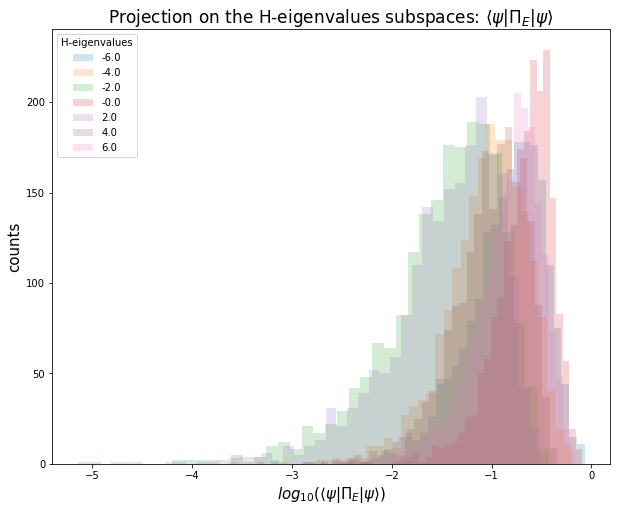

In [15]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

# Projection on H-eigenvalues subspaces
eps,Pi  = get_eigenpairs(H)
res = [[] for x in (eps)]
#res2=[[] for x in (eps)]

mat_H=H.to_matrix()

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #circ_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()     
    
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),Pi[i],psi_x))
        #PHP=np.dot(Pi[i],np.dot(mat_H,Pi[i]))
        #cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        #res2[i].append(cx2)

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on H-eigenvalues subspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for e,res_e in zip(eps,res):
    n,b,p = plt.hist(res_e,**kwargs,label=str(e))
plt.title(r'Projection on the H-eigenvalues subspaces: $\langle \psi|\Pi_{E}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{E}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title='H-eigenvalues')
plt.show()

#### Histogram of $\langle \psi_k|\Pi_{a,b}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{a,b} H \Pi_{a,b}|\psi_k \rangle}{\langle \psi_k|\Pi_{a,b}|\psi_k \rangle}$

We project the random vectors created using the **RY** circuit on the common eigenspaces of $R_v$ and $R_h$. We call $\Pi_{a,b}$ the projection operator on the subspaces corresponding to eigenvalues $(-1)^a$ and $(-1)^b$ of $R_v$ and $R_h$, respectively. It is defined as:

$$\Pi_{a,b}=\frac{1+(-1)^a R_v}{2}\frac{1+(-1)^b R_h}{2}$$

How well does a tensor product of single-qubit states describe the bow-tie?


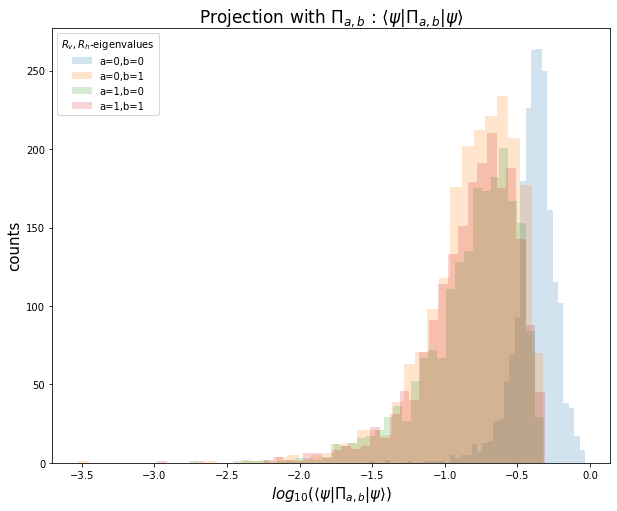

<Figure size 1800x1080 with 0 Axes>

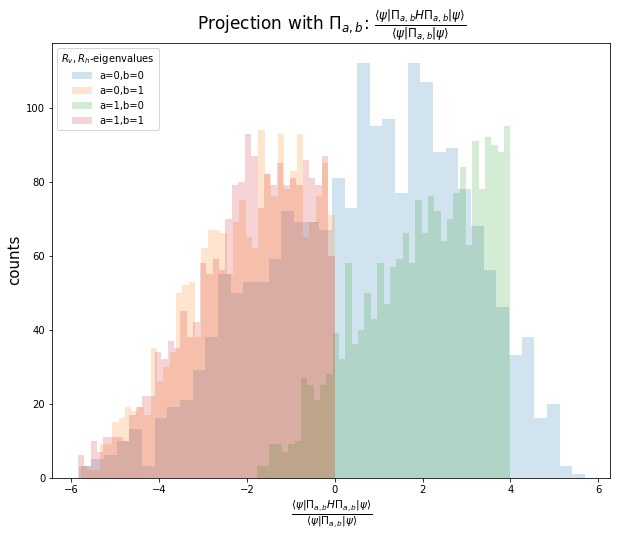

In [16]:
# Projection on \Pi_{a,b} eigenspaces
P_name=["a=0,b=0","a=0,b=1","a=1,b=0","a=1,b=1"]
P=get_Pab()
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #psi_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{a,b} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{a,b}$ : $\langle \psi|\Pi_{a,b}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{a,b}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{a,b}$: $\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.show()

As we expected the subspace corresponding to $a=1,b=0$ doesn't contribute to the ground state energy. 

#### Histogram of $\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi_k \rangle}{\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle}$

We project the random vectors created using the **RY** circuit on the common eigenspaces of $S^2$ and $S_z$ because the ground state is split in the sectors $s=1,s_z=-1$ and $s=1,s_z=1$. We call $\Pi_{s,s_z}$ the projection operator on the subspaces corresponding to eigenvalues $s_z=1$ and $s_z=-1$ of $S_z$, respectively.  

How well does a tensor product of single-qubit states describe the bow-tie?


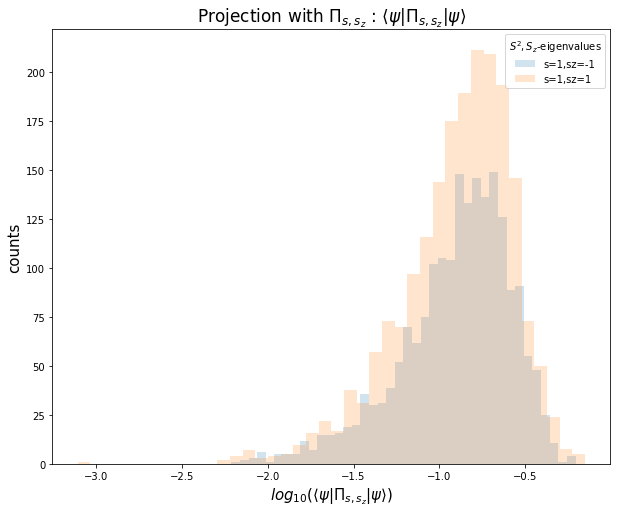

<Figure size 1800x1080 with 0 Axes>

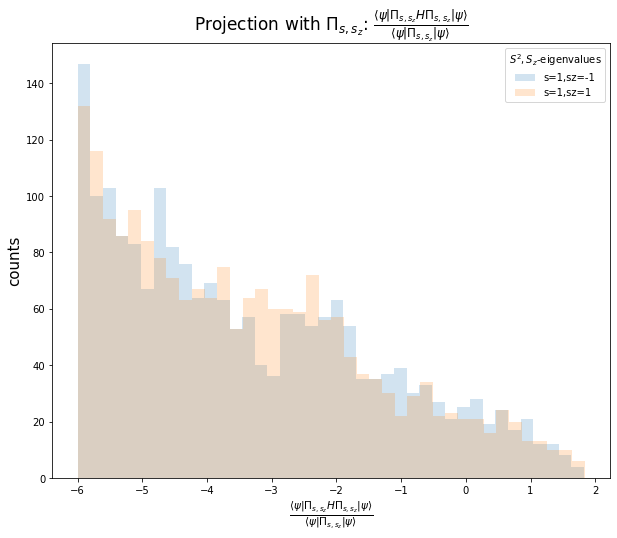

In [17]:
# Projection on \Pi_{s,sz} eigenspaces

P=get_Pspin()
P_name=["s=1,sz=-1","s=1,sz=1"]
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #psi_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{s,sz} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{s,s_z}$ : $\langle \psi|\Pi_{s,s_z}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{s,s_z}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{s,s_z}$: $\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.show()

### VQE - Projection-after-variation (PAV) with $\Pi_E$, $\Pi_{a,b}$  and $\Pi_{s,s_z}$

First we want to find the following expectation value:

$$E(\theta)=\langle \psi(\mathbf{\theta})|H|\psi(\mathbf{\theta}) \rangle$$

We make a cycle of $10$ iterations to find the minimum of $H$ through the VQE algorithm. We use the **RY** circuit with $n=10$ parameters. $|\psi(\mathbf{\theta})\rangle$, where $\mathbf{\theta}=(\theta_1,\theta_2, ..., \theta_n)^T$ is the vector of variational parameters, is the variational state which is optimized during the run of the algorithm.

In [18]:
emin = 10e4
best_psi = None
for i in range(10):
    algo             = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
    algo_result      = algo.run(quantum_instance_1)
    if(np.real(algo_result['eigenvalue'])<emin):
        emin = np.real(algo_result['eigenvalue'])
        best_psi = algo_result['eigenstate']


2020-12-18 16:28:53,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f8b3f5b2070>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f8b3f5b2760>>
-- initial_point: [-0.12674402  3.10454598  2.60952399  0.68008801 -0.13132372  3.13594681
  1.62039292  2.55366926  1.21303924 -2.9418185 ]
-- var_form:      ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■────

2020-12-18 16:28:53,104:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 16:28:53,106:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 8
op_counts: OrderedDict([('ry', 10), ('cx', 6), ('barrier', 2)])

2020-12-18 16:28:53,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79603 (ms)
2020-12-18 16:28:53,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.66936049] - 589.85901 (ms), eval count: 1
2020-12-18 16:28:53,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99587 (ms)
2020-12-18 16:28:53,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.6693605] - 5.57590 (ms), eval count: 2
2020-12-18 16:28:53,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75500 (ms)
2020-12-18 16:28:53,700:qiskit.aqua.algorithms.mi

2020-12-18 16:28:53,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54331444] - 7.12919 (ms), eval count: 30
2020-12-18 16:28:53,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00875 (ms)
2020-12-18 16:28:53,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54331444] - 7.54309 (ms), eval count: 31
2020-12-18 16:28:53,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00183 (ms)
2020-12-18 16:28:53,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54331442] - 5.35917 (ms), eval count: 32
2020-12-18 16:28:53,969:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03021 (ms)
2020-12-18 16:28:53,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54331446] - 7.04193 (ms), eval count: 33
2020-12-18 16:28:53,980:qiskit.aqua.operators.converte

2020-12-18 16:28:54,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72764546] - 4.25482 (ms), eval count: 61
2020-12-18 16:28:54,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02925 (ms)
2020-12-18 16:28:54,259:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72764546] - 6.14214 (ms), eval count: 62
2020-12-18 16:28:54,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96679 (ms)
2020-12-18 16:28:54,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72764546] - 5.55801 (ms), eval count: 63
2020-12-18 16:28:54,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99874 (ms)
2020-12-18 16:28:54,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72764546] - 6.31309 (ms), eval count: 64
2020-12-18 16:28:54,279:qiskit.aqua.operators.converte

2020-12-18 16:28:54,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99286816] - 8.41212 (ms), eval count: 92
2020-12-18 16:28:54,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40285 (ms)
2020-12-18 16:28:54,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99286816] - 7.17378 (ms), eval count: 93
2020-12-18 16:28:54,543:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12271 (ms)
2020-12-18 16:28:54,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99286816] - 4.94480 (ms), eval count: 94
2020-12-18 16:28:54,550:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58787 (ms)
2020-12-18 16:28:54,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99286816] - 6.40988 (ms), eval count: 95
2020-12-18 16:28:54,557:qiskit.aqua.operators.converte

2020-12-18 16:28:54,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99861623] - 5.81503 (ms), eval count: 123
2020-12-18 16:28:54,830:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97394 (ms)
2020-12-18 16:28:54,834:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99861623] - 4.92692 (ms), eval count: 124
2020-12-18 16:28:54,837:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99413 (ms)
2020-12-18 16:28:54,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99861623] - 7.29585 (ms), eval count: 125
2020-12-18 16:28:54,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77407 (ms)
2020-12-18 16:28:54,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99861623] - 12.26902 (ms), eval count: 126
2020-12-18 16:28:54,864:qiskit.aqua.operators.con

2020-12-18 16:28:55,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982849] - 6.27995 (ms), eval count: 154
2020-12-18 16:28:55,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38998 (ms)
2020-12-18 16:28:55,195:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99972581] - 5.46718 (ms), eval count: 155
2020-12-18 16:28:55,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51396 (ms)
2020-12-18 16:28:55,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99972581] - 6.26493 (ms), eval count: 156
2020-12-18 16:28:55,206:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86872 (ms)
2020-12-18 16:28:55,210:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99972581] - 6.15215 (ms), eval count: 157
2020-12-18 16:28:55,213:qiskit.aqua.operators.conv

2020-12-18 16:28:55,477:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992692] - 5.18394 (ms), eval count: 185
2020-12-18 16:28:55,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72591 (ms)
2020-12-18 16:28:55,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992692] - 5.97930 (ms), eval count: 186
2020-12-18 16:28:55,488:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97601 (ms)
2020-12-18 16:28:55,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992692] - 6.15883 (ms), eval count: 187
2020-12-18 16:28:55,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17009 (ms)
2020-12-18 16:28:55,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999802] - 6.20198 (ms), eval count: 188
2020-12-18 16:28:55,502:qiskit.aqua.operators.conve

2020-12-18 16:28:55,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999357] - 6.63090 (ms), eval count: 216
2020-12-18 16:28:55,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34325 (ms)
2020-12-18 16:28:55,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999357] - 6.28209 (ms), eval count: 217
2020-12-18 16:28:55,832:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45507 (ms)
2020-12-18 16:28:55,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999357] - 6.74987 (ms), eval count: 218
2020-12-18 16:28:55,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05405 (ms)
2020-12-18 16:28:55,845:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999357] - 6.67286 (ms), eval count: 219
2020-12-18 16:28:55,847:qiskit.aqua.operators.conv

2020-12-18 16:28:56,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999987] - 9.82690 (ms), eval count: 247
2020-12-18 16:28:56,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28317 (ms)
2020-12-18 16:28:56,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999987] - 7.24816 (ms), eval count: 248
2020-12-18 16:28:56,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91879 (ms)
2020-12-18 16:28:56,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999987] - 6.13523 (ms), eval count: 249
2020-12-18 16:28:56,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01011 (ms)
2020-12-18 16:28:56,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999987] - 7.36690 (ms), eval count: 250
2020-12-18 16:28:56,132:qiskit.aqua.operators.conv

2020-12-18 16:28:56,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999992] - 8.31079 (ms), eval count: 278
2020-12-18 16:28:56,378:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07210 (ms)
2020-12-18 16:28:56,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999992] - 14.85205 (ms), eval count: 279
2020-12-18 16:28:56,394:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74594 (ms)
2020-12-18 16:28:56,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999992] - 10.02097 (ms), eval count: 280
2020-12-18 16:28:56,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00105 (ms)
2020-12-18 16:28:56,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999992] - 6.24585 (ms), eval count: 281
2020-12-18 16:28:56,415:qiskit.aqua.operators.co

2020-12-18 16:28:56,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 5.96213 (ms), eval count: 309
2020-12-18 16:28:56,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41907 (ms)
2020-12-18 16:28:56,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 8.40211 (ms), eval count: 310
2020-12-18 16:28:56,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47796 (ms)
2020-12-18 16:28:56,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 9.29785 (ms), eval count: 311
2020-12-18 16:28:56,697:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90520 (ms)
2020-12-18 16:28:56,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 8.56280 (ms), eval count: 312
2020-12-18 16:28:56,708:qiskit.aqua.operators.conv

2020-12-18 16:28:56,936:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61695 (ms)
2020-12-18 16:28:56,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.09612 (ms), eval count: 341
2020-12-18 16:28:56,945:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04611 (ms)
2020-12-18 16:28:56,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.22837 (ms), eval count: 342
2020-12-18 16:28:56,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96703 (ms)
2020-12-18 16:28:56,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.53997 (ms), eval count: 343
2020-12-18 16:28:56,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86205 (ms)
2020-12-18 16:28:56,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:57,242:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:28:57,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.61619 (ms), eval count: 373
2020-12-18 16:28:57,249:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01089 (ms)
2020-12-18 16:28:57,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.00815 (ms), eval count: 374
2020-12-18 16:28:57,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13773 (ms)
2020-12-18 16:28:57,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.83601 (ms), eval count: 375
2020-12-18 16:28:57,263:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00875 (ms)
2020-12-18 16:28:57,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:57,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18017 (ms)
2020-12-18 16:28:57,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.13005 (ms), eval count: 405
2020-12-18 16:28:57,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98896 (ms)
2020-12-18 16:28:57,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.02214 (ms), eval count: 406
2020-12-18 16:28:57,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14703 (ms)
2020-12-18 16:28:57,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.20699 (ms), eval count: 407
2020-12-18 16:28:57,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89900 (ms)
2020-12-18 16:28:57,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:57,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59502 (ms)
2020-12-18 16:28:57,830:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.40297 (ms), eval count: 437
2020-12-18 16:28:57,833:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37281 (ms)
2020-12-18 16:28:57,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.30481 (ms), eval count: 438
2020-12-18 16:28:57,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59311 (ms)
2020-12-18 16:28:57,844:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.19125 (ms), eval count: 439
2020-12-18 16:28:57,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16611 (ms)
2020-12-18 16:28:57,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:58,143:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69587 (ms)
2020-12-18 16:28:58,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.46098 (ms), eval count: 469
2020-12-18 16:28:58,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63007 (ms)
2020-12-18 16:28:58,154:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.68795 (ms), eval count: 470
2020-12-18 16:28:58,158:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48702 (ms)
2020-12-18 16:28:58,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.56588 (ms), eval count: 471
2020-12-18 16:28:58,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67513 (ms)
2020-12-18 16:28:58,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:58,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96488 (ms)
2020-12-18 16:28:58,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.90372 (ms), eval count: 501
2020-12-18 16:28:58,450:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20282 (ms)
2020-12-18 16:28:58,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.04701 (ms), eval count: 502
2020-12-18 16:28:58,457:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50299 (ms)
2020-12-18 16:28:58,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.17988 (ms), eval count: 503
2020-12-18 16:28:58,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99182 (ms)
2020-12-18 16:28:58,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:58,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20783 (ms)
2020-12-18 16:28:58,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.18823 (ms), eval count: 533
2020-12-18 16:28:58,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:28:58,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.48410 (ms), eval count: 534
2020-12-18 16:28:58,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98491 (ms)
2020-12-18 16:28:58,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.52869 (ms), eval count: 535
2020-12-18 16:28:58,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97394 (ms)
2020-12-18 16:28:58,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:59,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35708 (ms)
2020-12-18 16:28:59,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.79612 (ms), eval count: 565
2020-12-18 16:28:59,060:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42694 (ms)
2020-12-18 16:28:59,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.49977 (ms), eval count: 566
2020-12-18 16:28:59,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13010 (ms)
2020-12-18 16:28:59,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.41394 (ms), eval count: 567
2020-12-18 16:28:59,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:28:59,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:59,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90401 (ms)
2020-12-18 16:28:59,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.38199 (ms), eval count: 597
2020-12-18 16:28:59,366:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87993 (ms)
2020-12-18 16:28:59,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.49111 (ms), eval count: 598
2020-12-18 16:28:59,374:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61695 (ms)
2020-12-18 16:28:59,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.90794 (ms), eval count: 599
2020-12-18 16:28:59,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20211 (ms)
2020-12-18 16:28:59,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:59,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97418 (ms)
2020-12-18 16:28:59,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.32071 (ms), eval count: 629
2020-12-18 16:28:59,670:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66798 (ms)
2020-12-18 16:28:59,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.91707 (ms), eval count: 630
2020-12-18 16:28:59,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60885 (ms)
2020-12-18 16:28:59,681:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.58305 (ms), eval count: 631
2020-12-18 16:28:59,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76501 (ms)
2020-12-18 16:28:59,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:28:59,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65677 (ms)
2020-12-18 16:28:59,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.51979 (ms), eval count: 661
2020-12-18 16:28:59,958:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98722 (ms)
2020-12-18 16:28:59,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.16710 (ms), eval count: 662
2020-12-18 16:28:59,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39284 (ms)
2020-12-18 16:28:59,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.07419 (ms), eval count: 663
2020-12-18 16:28:59,975:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33991 (ms)
2020-12-18 16:28:59,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:00,240:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99993 (ms)
2020-12-18 16:29:00,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.66792 (ms), eval count: 693
2020-12-18 16:29:00,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78885 (ms)
2020-12-18 16:29:00,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.53505 (ms), eval count: 694
2020-12-18 16:29:00,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22762 (ms)
2020-12-18 16:29:00,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.83093 (ms), eval count: 695
2020-12-18 16:29:00,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86515 (ms)
2020-12-18 16:29:00,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:00,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25694 (ms)
2020-12-18 16:29:00,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.07500 (ms), eval count: 725
2020-12-18 16:29:00,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22404 (ms)
2020-12-18 16:29:00,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.30593 (ms), eval count: 726
2020-12-18 16:29:00,565:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90115 (ms)
2020-12-18 16:29:00,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.47497 (ms), eval count: 727
2020-12-18 16:29:00,572:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18518 (ms)
2020-12-18 16:29:00,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:00,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:29:00,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.76107 (ms), eval count: 757
2020-12-18 16:29:00,818:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00803 (ms)
2020-12-18 16:29:00,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.51598 (ms), eval count: 758
2020-12-18 16:29:00,828:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28198 (ms)
2020-12-18 16:29:00,853:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 26.34692 (ms), eval count: 759
2020-12-18 16:29:00,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00207 (ms)
2020-12-18 16:29:00,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:01,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99897 (ms)
2020-12-18 16:29:01,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.85604 (ms), eval count: 789
2020-12-18 16:29:01,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01018 (ms)
2020-12-18 16:29:01,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.63192 (ms), eval count: 790
2020-12-18 16:29:01,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00613 (ms)
2020-12-18 16:29:01,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.12624 (ms), eval count: 791
2020-12-18 16:29:01,147:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01924 (ms)
2020-12-18 16:29:01,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:01,439:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10412 (ms)
2020-12-18 16:29:01,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.95705 (ms), eval count: 821
2020-12-18 16:29:01,447:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01924 (ms)
2020-12-18 16:29:01,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.31602 (ms), eval count: 822
2020-12-18 16:29:01,455:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03688 (ms)
2020-12-18 16:29:01,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.81707 (ms), eval count: 823
2020-12-18 16:29:01,478:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.20117 (ms)
2020-12-18 16:29:01,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:01,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69396 (ms)
2020-12-18 16:29:01,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.56414 (ms), eval count: 853
2020-12-18 16:29:01,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60980 (ms)
2020-12-18 16:29:01,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.44493 (ms), eval count: 854
2020-12-18 16:29:01,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20878 (ms)
2020-12-18 16:29:01,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.65791 (ms), eval count: 855
2020-12-18 16:29:01,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63507 (ms)
2020-12-18 16:29:01,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:02,035:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99492 (ms)
2020-12-18 16:29:02,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.62177 (ms), eval count: 885
2020-12-18 16:29:02,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01089 (ms)
2020-12-18 16:29:02,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.17286 (ms), eval count: 886
2020-12-18 16:29:02,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16420 (ms)
2020-12-18 16:29:02,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.05492 (ms), eval count: 887
2020-12-18 16:29:02,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23191 (ms)
2020-12-18 16:29:02,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:29:02,329:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75595 (ms)
2020-12-18 16:29:02,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.51002 (ms), eval count: 917
2020-12-18 16:29:02,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69301 (ms)
2020-12-18 16:29:02,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.20413 (ms), eval count: 918
2020-12-18 16:29:02,345:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74689 (ms)
2020-12-18 16:29:02,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.89983 (ms), eval count: 919
2020-12-18 16:29:02,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98491 (ms)
2020-12-18 16:29:02,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:02,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17612 (ms)
2020-12-18 16:29:02,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.49905 (ms), eval count: 949
2020-12-18 16:29:02,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88899 (ms)
2020-12-18 16:29:02,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.74677 (ms), eval count: 950
2020-12-18 16:29:02,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99516 (ms)
2020-12-18 16:29:02,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.39875 (ms), eval count: 951
2020-12-18 16:29:02,638:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98491 (ms)
2020-12-18 16:29:02,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:02,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70612 (ms)
2020-12-18 16:29:02,916:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.24204 (ms), eval count: 981
2020-12-18 16:29:02,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95224 (ms)
2020-12-18 16:29:02,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.07419 (ms), eval count: 982
2020-12-18 16:29:02,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37481 (ms)
2020-12-18 16:29:02,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.31802 (ms), eval count: 983
2020-12-18 16:29:02,937:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20895 (ms)
2020-12-18 16:29:02,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:03,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00899 (ms)
2020-12-18 16:29:03,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.93488 (ms), eval count: 1013
2020-12-18 16:29:03,211:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94581 (ms)
2020-12-18 16:29:03,216:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.14405 (ms), eval count: 1014
2020-12-18 16:29:03,218:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2020-12-18 16:29:03,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.82290 (ms), eval count: 1015
2020-12-18 16:29:03,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12796 (ms)
2020-12-18 16:29:03,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:03,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94891 (ms)
2020-12-18 16:29:03,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.65886 (ms), eval count: 1045
2020-12-18 16:29:03,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99897 (ms)
2020-12-18 16:29:03,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.30617 (ms), eval count: 1046
2020-12-18 16:29:03,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:29:03,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.17337 (ms), eval count: 1047
2020-12-18 16:29:03,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22619 (ms)
2020-12-18 16:29:03,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:03,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29390 (ms)
2020-12-18 16:29:03,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.20008 (ms), eval count: 1077
2020-12-18 16:29:03,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87492 (ms)
2020-12-18 16:29:03,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.53496 (ms), eval count: 1078
2020-12-18 16:29:03,810:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51896 (ms)
2020-12-18 16:29:03,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.92518 (ms), eval count: 1079
2020-12-18 16:29:03,817:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95391 (ms)
2020-12-18 16:29:03,822:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:04,078:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95177 (ms)
2020-12-18 16:29:04,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.02078 (ms), eval count: 1109
2020-12-18 16:29:04,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15085 (ms)
2020-12-18 16:29:04,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.04398 (ms), eval count: 1110
2020-12-18 16:29:04,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96178 (ms)
2020-12-18 16:29:04,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.78499 (ms), eval count: 1111
2020-12-18 16:29:04,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98705 (ms)
2020-12-18 16:29:04,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:04,374:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92189 (ms)
2020-12-18 16:29:04,379:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.37436 (ms), eval count: 1141
2020-12-18 16:29:04,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19114 (ms)
2020-12-18 16:29:04,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.07896 (ms), eval count: 1142
2020-12-18 16:29:04,389:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45292 (ms)
2020-12-18 16:29:04,393:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.72896 (ms), eval count: 1143
2020-12-18 16:29:04,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48296 (ms)
2020-12-18 16:29:04,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:04,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61815 (ms)
2020-12-18 16:29:04,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.43492 (ms), eval count: 1173
2020-12-18 16:29:04,697:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46501 (ms)
2020-12-18 16:29:04,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.47490 (ms), eval count: 1174
2020-12-18 16:29:04,704:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07002 (ms)
2020-12-18 16:29:04,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.94902 (ms), eval count: 1175
2020-12-18 16:29:04,713:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04015 (ms)
2020-12-18 16:29:04,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:29:04,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28412 (ms)
2020-12-18 16:29:04,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.52394 (ms), eval count: 1205
2020-12-18 16:29:05,001:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03116 (ms)
2020-12-18 16:29:05,013:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.99310 (ms), eval count: 1206
2020-12-18 16:29:05,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.45287 (ms)
2020-12-18 16:29:05,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 15.86294 (ms), eval count: 1207
2020-12-18 16:29:05,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86968 (ms)
2020-12-18 16:29:05,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:29:05,190:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.07025903  0.10053802  2.58223493  2.71930196  1.34418439 -2.29439315
 -2.37770005 -0.22785129  2.23554554  3.08385386]
2020-12-18 16:29:05,200:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:05,258:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:05,261:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:29:05,489:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98801 (ms)
2020-12-18 16:29:05,496:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.1133489] - 7.65300 (ms), eval count: 26
2020-12-18 16:29:05,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02282 (ms)
2020-12-18 16:29:05,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.11334887] - 6.45518 (ms), eval count: 27
2020-12-18 16:29:05,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98896 (ms)
2020-12-18 16:29:05,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.11334888] - 6.27995 (ms), eval count: 28
2020-12-18 16:29:05,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59097 (ms)
2020-12-18 16:29:05,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2020-12-18 16:29:05,790:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97394 (ms)
2020-12-18 16:29:05,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.14811328] - 5.58996 (ms), eval count: 57
2020-12-18 16:29:05,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99587 (ms)
2020-12-18 16:29:05,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.14811329] - 6.95419 (ms), eval count: 58
2020-12-18 16:29:05,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02973 (ms)
2020-12-18 16:29:05,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.14811329] - 5.39875 (ms), eval count: 59
2020-12-18 16:29:05,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02282 (ms)
2020-12-18 16:29:05,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:06,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67966 (ms)
2020-12-18 16:29:06,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.02684387] - 5.81789 (ms), eval count: 88
2020-12-18 16:29:06,108:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65296 (ms)
2020-12-18 16:29:06,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.02233354] - 6.51193 (ms), eval count: 89
2020-12-18 16:29:06,117:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54495 (ms)
2020-12-18 16:29:06,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.02233354] - 12.97903 (ms), eval count: 90
2020-12-18 16:29:06,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45483 (ms)
2020-12-18 16:29:06,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 16:29:06,429:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48463 (ms)
2020-12-18 16:29:06,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.17325644] - 5.97620 (ms), eval count: 119
2020-12-18 16:29:06,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70994 (ms)
2020-12-18 16:29:06,454:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.17325644] - 17.22097 (ms), eval count: 120
2020-12-18 16:29:06,457:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05596 (ms)
2020-12-18 16:29:06,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.17325644] - 8.85892 (ms), eval count: 121
2020-12-18 16:29:06,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54686 (ms)
2020-12-18 16:29:06,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:06,751:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38419 (ms)
2020-12-18 16:29:06,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54021682] - 7.68209 (ms), eval count: 150
2020-12-18 16:29:06,762:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43886 (ms)
2020-12-18 16:29:06,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54021683] - 9.33981 (ms), eval count: 151
2020-12-18 16:29:06,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27404 (ms)
2020-12-18 16:29:06,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54021683] - 7.35784 (ms), eval count: 152
2020-12-18 16:29:06,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30272 (ms)
2020-12-18 16:29:06,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:07,027:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10690 (ms)
2020-12-18 16:29:07,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48581493] - 26.44610 (ms), eval count: 181
2020-12-18 16:29:07,053:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05214 (ms)
2020-12-18 16:29:07,057:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48581493] - 5.15628 (ms), eval count: 182
2020-12-18 16:29:07,061:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06113 (ms)
2020-12-18 16:29:07,066:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48581494] - 7.26390 (ms), eval count: 183
2020-12-18 16:29:07,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30193 (ms)
2020-12-18 16:29:07,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:07,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00684 (ms)
2020-12-18 16:29:07,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96607726] - 5.18298 (ms), eval count: 212
2020-12-18 16:29:07,321:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26004 (ms)
2020-12-18 16:29:07,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96607727] - 6.55413 (ms), eval count: 213
2020-12-18 16:29:07,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98395 (ms)
2020-12-18 16:29:07,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96607726] - 5.44000 (ms), eval count: 214
2020-12-18 16:29:07,336:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08688 (ms)
2020-12-18 16:29:07,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:07,599:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09100 (ms)
2020-12-18 16:29:07,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99352653] - 6.16813 (ms), eval count: 243
2020-12-18 16:29:07,606:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98491 (ms)
2020-12-18 16:29:07,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99352653] - 7.07603 (ms), eval count: 244
2020-12-18 16:29:07,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00589 (ms)
2020-12-18 16:29:07,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99352653] - 5.48196 (ms), eval count: 245
2020-12-18 16:29:07,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99707 (ms)
2020-12-18 16:29:07,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:07,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12414 (ms)
2020-12-18 16:29:07,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99574241] - 4.95505 (ms), eval count: 274
2020-12-18 16:29:07,897:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25496 (ms)
2020-12-18 16:29:07,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99574241] - 7.17425 (ms), eval count: 275
2020-12-18 16:29:07,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24996 (ms)
2020-12-18 16:29:07,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9994726] - 6.28519 (ms), eval count: 276
2020-12-18 16:29:07,913:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69516 (ms)
2020-12-18 16:29:07,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:29:08,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72210 (ms)
2020-12-18 16:29:08,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999676] - 5.82194 (ms), eval count: 305
2020-12-18 16:29:08,246:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09975 (ms)
2020-12-18 16:29:08,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999676] - 7.32589 (ms), eval count: 306
2020-12-18 16:29:08,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.67315 (ms)
2020-12-18 16:29:08,264:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999676] - 10.37192 (ms), eval count: 307
2020-12-18 16:29:08,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13909 (ms)
2020-12-18 16:29:08,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 16:29:08,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49226 (ms)
2020-12-18 16:29:08,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999708] - 5.88584 (ms), eval count: 336
2020-12-18 16:29:08,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97585 (ms)
2020-12-18 16:29:08,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999708] - 5.85413 (ms), eval count: 337
2020-12-18 16:29:08,562:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94907 (ms)
2020-12-18 16:29:08,567:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999708] - 6.57201 (ms), eval count: 338
2020-12-18 16:29:08,570:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.52493 (ms)
2020-12-18 16:29:08,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:08,827:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47979 (ms)
2020-12-18 16:29:08,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 10.90312 (ms), eval count: 367
2020-12-18 16:29:08,841:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78623 (ms)
2020-12-18 16:29:08,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 9.25803 (ms), eval count: 368
2020-12-18 16:29:08,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39713 (ms)
2020-12-18 16:29:08,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 6.33907 (ms), eval count: 369
2020-12-18 16:29:08,862:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85108 (ms)
2020-12-18 16:29:08,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:09,214:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51396 (ms)
2020-12-18 16:29:09,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999986] - 9.55629 (ms), eval count: 398
2020-12-18 16:29:09,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28317 (ms)
2020-12-18 16:29:09,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999986] - 8.12101 (ms), eval count: 399
2020-12-18 16:29:09,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60074 (ms)
2020-12-18 16:29:09,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999986] - 5.75590 (ms), eval count: 400
2020-12-18 16:29:09,243:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97291 (ms)
2020-12-18 16:29:09,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:09,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.77490 (ms), eval count: 429
2020-12-18 16:29:09,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00605 (ms)
2020-12-18 16:29:09,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.50606 (ms), eval count: 430
2020-12-18 16:29:09,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76597 (ms)
2020-12-18 16:29:09,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.94831 (ms), eval count: 431
2020-12-18 16:29:09,583:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54495 (ms)
2020-12-18 16:29:09,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.17990 (ms), eval count: 432
2020-12-18 16:29:09,593:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:10,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.34322 (ms), eval count: 461
2020-12-18 16:29:10,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95687 (ms)
2020-12-18 16:29:10,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.80973 (ms), eval count: 462
2020-12-18 16:29:10,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55506 (ms)
2020-12-18 16:29:10,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.91299 (ms), eval count: 463
2020-12-18 16:29:10,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39611 (ms)
2020-12-18 16:29:10,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.01785 (ms), eval count: 464
2020-12-18 16:29:10,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:10,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.09207 (ms), eval count: 493
2020-12-18 16:29:10,598:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:29:10,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.20305 (ms), eval count: 494
2020-12-18 16:29:10,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.89523 (ms)
2020-12-18 16:29:10,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 22.65310 (ms), eval count: 495
2020-12-18 16:29:10,641:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25616 (ms)
2020-12-18 16:29:10,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.54020 (ms), eval count: 496
2020-12-18 16:29:10,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:10,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.93896 (ms), eval count: 525
2020-12-18 16:29:10,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12693 (ms)
2020-12-18 16:29:11,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.33773 (ms), eval count: 526
2020-12-18 16:29:11,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79307 (ms)
2020-12-18 16:29:11,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.74113 (ms), eval count: 527
2020-12-18 16:29:11,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39007 (ms)
2020-12-18 16:29:11,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 15.22207 (ms), eval count: 528
2020-12-18 16:29:11,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:11,471:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.49204 (ms), eval count: 557
2020-12-18 16:29:11,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55680 (ms)
2020-12-18 16:29:11,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.31707 (ms), eval count: 558
2020-12-18 16:29:11,483:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95479 (ms)
2020-12-18 16:29:11,496:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.83321 (ms), eval count: 559
2020-12-18 16:29:11,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24416 (ms)
2020-12-18 16:29:11,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.10088 (ms), eval count: 560
2020-12-18 16:29:11,525:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:11,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.06317 (ms), eval count: 589
2020-12-18 16:29:11,884:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39205 (ms)
2020-12-18 16:29:11,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.68499 (ms), eval count: 590
2020-12-18 16:29:11,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21205 (ms)
2020-12-18 16:29:11,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.76300 (ms), eval count: 591
2020-12-18 16:29:11,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60480 (ms)
2020-12-18 16:29:11,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.98490 (ms), eval count: 592
2020-12-18 16:29:11,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:12,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.24418 (ms), eval count: 621
2020-12-18 16:29:12,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29509 (ms)
2020-12-18 16:29:12,437:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.86114 (ms), eval count: 622
2020-12-18 16:29:12,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48034 (ms)
2020-12-18 16:29:12,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.38399 (ms), eval count: 623
2020-12-18 16:29:12,459:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40111 (ms)
2020-12-18 16:29:12,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.16006 (ms), eval count: 624
2020-12-18 16:29:12,482:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:12,801:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.14381 (ms), eval count: 653
2020-12-18 16:29:12,806:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03498 (ms)
2020-12-18 16:29:12,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.09985 (ms), eval count: 654
2020-12-18 16:29:12,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22404 (ms)
2020-12-18 16:29:12,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.64403 (ms), eval count: 655
2020-12-18 16:29:12,822:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96393 (ms)
2020-12-18 16:29:12,830:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.98290 (ms), eval count: 656
2020-12-18 16:29:12,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:13,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.73832 (ms), eval count: 685
2020-12-18 16:29:13,362:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44093 (ms)
2020-12-18 16:29:13,373:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.10515 (ms), eval count: 686
2020-12-18 16:29:13,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90425 (ms)
2020-12-18 16:29:13,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.94291 (ms), eval count: 687
2020-12-18 16:29:13,393:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43306 (ms)
2020-12-18 16:29:13,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.79011 (ms), eval count: 688
2020-12-18 16:29:13,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:13,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.13692 (ms), eval count: 717
2020-12-18 16:29:13,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24598 (ms)
2020-12-18 16:29:13,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.51817 (ms), eval count: 718
2020-12-18 16:29:13,716:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78599 (ms)
2020-12-18 16:29:13,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.26583 (ms), eval count: 719
2020-12-18 16:29:13,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99921 (ms)
2020-12-18 16:29:13,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.11274 (ms), eval count: 720
2020-12-18 16:29:13,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:13,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.54905 (ms), eval count: 749
2020-12-18 16:29:14,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02615 (ms)
2020-12-18 16:29:14,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.73592 (ms), eval count: 750
2020-12-18 16:29:14,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86801 (ms)
2020-12-18 16:29:14,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.48813 (ms), eval count: 751
2020-12-18 16:29:14,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05786 (ms)
2020-12-18 16:29:14,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 3.82209 (ms), eval count: 752
2020-12-18 16:29:14,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:14,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.00824 (ms), eval count: 781
2020-12-18 16:29:14,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47288 (ms)
2020-12-18 16:29:14,320:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.67924 (ms), eval count: 782
2020-12-18 16:29:14,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24598 (ms)
2020-12-18 16:29:14,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.34305 (ms), eval count: 783
2020-12-18 16:29:14,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35708 (ms)
2020-12-18 16:29:14,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.41377 (ms), eval count: 784
2020-12-18 16:29:14,345:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:14,724:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.81290 (ms), eval count: 813
2020-12-18 16:29:14,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98395 (ms)
2020-12-18 16:29:14,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.73628 (ms), eval count: 814
2020-12-18 16:29:14,751:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46286 (ms)
2020-12-18 16:29:14,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.57305 (ms), eval count: 815
2020-12-18 16:29:14,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41621 (ms)
2020-12-18 16:29:14,801:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 21.64793 (ms), eval count: 816
2020-12-18 16:29:14,814:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:15,246:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.34391 (ms), eval count: 845
2020-12-18 16:29:15,249:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21117 (ms)
2020-12-18 16:29:15,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.44867 (ms), eval count: 846
2020-12-18 16:29:15,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18089 (ms)
2020-12-18 16:29:15,264:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.29902 (ms), eval count: 847
2020-12-18 16:29:15,272:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82319 (ms)
2020-12-18 16:29:15,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.82981 (ms), eval count: 848
2020-12-18 16:29:15,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:15,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.23909 (ms), eval count: 877
2020-12-18 16:29:15,618:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27380 (ms)
2020-12-18 16:29:15,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.45299 (ms), eval count: 878
2020-12-18 16:29:15,631:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95496 (ms)
2020-12-18 16:29:15,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.60112 (ms), eval count: 879
2020-12-18 16:29:15,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.52475 (ms)
2020-12-18 16:29:15,663:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.60936 (ms), eval count: 880
2020-12-18 16:29:15,669:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2020-12-18 16:29:16,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.48095 (ms), eval count: 909
2020-12-18 16:29:16,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33603 (ms)
2020-12-18 16:29:16,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.17499 (ms), eval count: 910
2020-12-18 16:29:16,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40796 (ms)
2020-12-18 16:29:16,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.21902 (ms), eval count: 911
2020-12-18 16:29:16,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47908 (ms)
2020-12-18 16:29:16,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.91011 (ms), eval count: 912
2020-12-18 16:29:16,137:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:16,420:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.29687 (ms), eval count: 941
2020-12-18 16:29:16,424:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95677 (ms)
2020-12-18 16:29:16,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.00195 (ms), eval count: 942
2020-12-18 16:29:16,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96703 (ms)
2020-12-18 16:29:16,437:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.25475 (ms), eval count: 943
2020-12-18 16:29:16,440:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95296 (ms)
2020-12-18 16:29:16,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.21390 (ms), eval count: 944
2020-12-18 16:29:16,449:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:16,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.28195 (ms), eval count: 973
2020-12-18 16:29:16,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73204 (ms)
2020-12-18 16:29:16,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.44893 (ms), eval count: 974
2020-12-18 16:29:16,874:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82693 (ms)
2020-12-18 16:29:16,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.79111 (ms), eval count: 975
2020-12-18 16:29:16,903:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32918 (ms)
2020-12-18 16:29:16,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.15608 (ms), eval count: 976
2020-12-18 16:29:16,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:17,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.55715 (ms), eval count: 1005
2020-12-18 16:29:17,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99986 (ms)
2020-12-18 16:29:17,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.59680 (ms), eval count: 1006
2020-12-18 16:29:17,291:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64914 (ms)
2020-12-18 16:29:17,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.58321 (ms), eval count: 1007
2020-12-18 16:29:17,299:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68300 (ms)
2020-12-18 16:29:17,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.61929 (ms), eval count: 1008
2020-12-18 16:29:17,306:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2020-12-18 16:29:17,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.90582 (ms), eval count: 1037
2020-12-18 16:29:17,825:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45006 (ms)
2020-12-18 16:29:17,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.89408 (ms), eval count: 1038
2020-12-18 16:29:17,841:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98722 (ms)
2020-12-18 16:29:17,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.42208 (ms), eval count: 1039
2020-12-18 16:29:17,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45006 (ms)
2020-12-18 16:29:17,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.38106 (ms), eval count: 1040
2020-12-18 16:29:17,867:qiskit.aqua.operators.converters.circuit_sampler:DEB

2020-12-18 16:29:18,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.04996 (ms), eval count: 1069
2020-12-18 16:29:18,308:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09482 (ms)
2020-12-18 16:29:18,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.54602 (ms), eval count: 1070
2020-12-18 16:29:18,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21698 (ms)
2020-12-18 16:29:18,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.93998 (ms), eval count: 1071
2020-12-18 16:29:18,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20997 (ms)
2020-12-18 16:29:18,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.56812 (ms), eval count: 1072
2020-12-18 16:29:18,339:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2020-12-18 16:29:18,844:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.71296 (ms), eval count: 1101
2020-12-18 16:29:18,847:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39785 (ms)
2020-12-18 16:29:18,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.06904 (ms), eval count: 1102
2020-12-18 16:29:18,860:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45292 (ms)
2020-12-18 16:29:18,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.07717 (ms), eval count: 1103
2020-12-18 16:29:18,879:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33991 (ms)
2020-12-18 16:29:18,894:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.21597 (ms), eval count: 1104
2020-12-18 16:29:18,901:qiskit.aqua.operators.converters.circuit_sampler:DE

2020-12-18 16:29:19,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.24728 (ms), eval count: 1133
2020-12-18 16:29:19,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79086 (ms)
2020-12-18 16:29:19,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.46712 (ms), eval count: 1134
2020-12-18 16:29:19,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96393 (ms)
2020-12-18 16:29:19,293:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.67193 (ms), eval count: 1135
2020-12-18 16:29:19,299:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86396 (ms)
2020-12-18 16:29:19,310:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.19718 (ms), eval count: 1136
2020-12-18 16:29:19,319:qiskit.aqua.operators.converters.circuit_sampler:DEBU

2020-12-18 16:29:19,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47216 (ms)
2020-12-18 16:29:19,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.53715 (ms), eval count: 1165
2020-12-18 16:29:19,867:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94986 (ms)
2020-12-18 16:29:19,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.89101 (ms), eval count: 1166
2020-12-18 16:29:19,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51906 (ms)
2020-12-18 16:29:19,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.56688 (ms), eval count: 1167
2020-12-18 16:29:19,891:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99492 (ms)
2020-12-18 16:29:19,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:29:20,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22700 (ms)
2020-12-18 16:29:20,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.54003 (ms), eval count: 1197
2020-12-18 16:29:20,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.59376 (ms)
2020-12-18 16:29:20,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.19716 (ms), eval count: 1198
2020-12-18 16:29:20,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03571 (ms)
2020-12-18 16:29:20,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.33406 (ms), eval count: 1199
2020-12-18 16:29:20,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06988 (ms)
2020-12-18 16:29:20,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:29:20,655:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.9293448   1.64298429  0.1536784  -0.87278263  0.9407043   1.2237883
 -2.8143953   1.39097319  1.27351268 -2.56161517]
2020-12-18 16:29:20,670:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:20,693:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:20,694:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operation

2020-12-18 16:29:21,063:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48702 (ms)
2020-12-18 16:29:21,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.79197279] - 11.92999 (ms), eval count: 26
2020-12-18 16:29:21,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19321 (ms)
2020-12-18 16:29:21,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.79197277] - 13.58676 (ms), eval count: 27
2020-12-18 16:29:21,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40786 (ms)
2020-12-18 16:29:21,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.79197276] - 13.18717 (ms), eval count: 28
2020-12-18 16:29:21,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74126 (ms)
2020-12-18 16:29:21,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:21,537:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02806 (ms)
2020-12-18 16:29:21,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.97812184] - 10.27894 (ms), eval count: 57
2020-12-18 16:29:21,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66202 (ms)
2020-12-18 16:29:21,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.97812181] - 7.53188 (ms), eval count: 58
2020-12-18 16:29:21,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23303 (ms)
2020-12-18 16:29:21,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.97812184] - 7.97296 (ms), eval count: 59
2020-12-18 16:29:21,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22595 (ms)
2020-12-18 16:29:21,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 16:29:21,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70002 (ms)
2020-12-18 16:29:22,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.4468532] - 19.25397 (ms), eval count: 88
2020-12-18 16:29:22,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05390 (ms)
2020-12-18 16:29:22,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62393955] - 22.40705 (ms), eval count: 89
2020-12-18 16:29:22,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.70209 (ms)
2020-12-18 16:29:22,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62393956] - 20.69187 (ms), eval count: 90
2020-12-18 16:29:22,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57215 (ms)
2020-12-18 16:29:22,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:29:22,436:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34182 (ms)
2020-12-18 16:29:22,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81788627] - 8.36587 (ms), eval count: 119
2020-12-18 16:29:22,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89781 (ms)
2020-12-18 16:29:22,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81788627] - 8.97098 (ms), eval count: 120
2020-12-18 16:29:22,457:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98507 (ms)
2020-12-18 16:29:22,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81788627] - 7.07102 (ms), eval count: 121
2020-12-18 16:29:22,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41494 (ms)
2020-12-18 16:29:22,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:22,724:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39499 (ms)
2020-12-18 16:29:22,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86179483] - 7.63607 (ms), eval count: 150
2020-12-18 16:29:22,750:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49600 (ms)
2020-12-18 16:29:22,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86179483] - 5.48124 (ms), eval count: 151
2020-12-18 16:29:22,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40009 (ms)
2020-12-18 16:29:22,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86179484] - 9.93705 (ms), eval count: 152
2020-12-18 16:29:22,772:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60837 (ms)
2020-12-18 16:29:22,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:23,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22595 (ms)
2020-12-18 16:29:23,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995374] - 6.27828 (ms), eval count: 181
2020-12-18 16:29:23,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21522 (ms)
2020-12-18 16:29:23,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995374] - 6.69074 (ms), eval count: 182
2020-12-18 16:29:23,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24097 (ms)
2020-12-18 16:29:23,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995374] - 7.22408 (ms), eval count: 183
2020-12-18 16:29:23,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22023 (ms)
2020-12-18 16:29:23,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:23,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41072 (ms)
2020-12-18 16:29:23,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999659] - 13.42821 (ms), eval count: 212
2020-12-18 16:29:23,466:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45936 (ms)
2020-12-18 16:29:23,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999659] - 6.31499 (ms), eval count: 213
2020-12-18 16:29:23,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08902 (ms)
2020-12-18 16:29:23,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999659] - 7.01404 (ms), eval count: 214
2020-12-18 16:29:23,483:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05906 (ms)
2020-12-18 16:29:23,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:23,732:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96195 (ms)
2020-12-18 16:29:23,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 6.67644 (ms), eval count: 243
2020-12-18 16:29:23,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42622 (ms)
2020-12-18 16:29:23,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 6.75869 (ms), eval count: 244
2020-12-18 16:29:23,747:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00517 (ms)
2020-12-18 16:29:23,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 4.91810 (ms), eval count: 245
2020-12-18 16:29:23,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77622 (ms)
2020-12-18 16:29:23,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:24,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.86788 (ms), eval count: 274
2020-12-18 16:29:24,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22309 (ms)
2020-12-18 16:29:24,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.45592 (ms), eval count: 275
2020-12-18 16:29:24,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15824 (ms)
2020-12-18 16:29:24,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 6.64091 (ms), eval count: 276
2020-12-18 16:29:24,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2020-12-18 16:29:24,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.34107 (ms), eval count: 277
2020-12-18 16:29:24,137:qiskit.aqua.operators.converters.circuit_

2020-12-18 16:29:24,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43886 (ms)
2020-12-18 16:29:24,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.88812 (ms), eval count: 306
2020-12-18 16:29:24,445:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44117 (ms)
2020-12-18 16:29:24,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.91097 (ms), eval count: 307
2020-12-18 16:29:24,458:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93398 (ms)
2020-12-18 16:29:24,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.08214 (ms), eval count: 308
2020-12-18 16:29:24,478:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92285 (ms)
2020-12-18 16:29:24,494:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:29:24,742:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01995 (ms)
2020-12-18 16:29:24,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.00219 (ms), eval count: 338
2020-12-18 16:29:24,752:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41811 (ms)
2020-12-18 16:29:24,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.45583 (ms), eval count: 339
2020-12-18 16:29:24,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53494 (ms)
2020-12-18 16:29:24,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.77824 (ms), eval count: 340
2020-12-18 16:29:24,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04403 (ms)
2020-12-18 16:29:24,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:25,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71089 (ms)
2020-12-18 16:29:25,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.56796 (ms), eval count: 370
2020-12-18 16:29:25,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94621 (ms)
2020-12-18 16:29:25,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.37698 (ms), eval count: 371
2020-12-18 16:29:25,071:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07400 (ms)
2020-12-18 16:29:25,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.64091 (ms), eval count: 372
2020-12-18 16:29:25,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75571 (ms)
2020-12-18 16:29:25,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:25,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2020-12-18 16:29:25,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.16200 (ms), eval count: 402
2020-12-18 16:29:25,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99921 (ms)
2020-12-18 16:29:25,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.63478 (ms), eval count: 403
2020-12-18 16:29:25,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65677 (ms)
2020-12-18 16:29:25,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.59490 (ms), eval count: 404
2020-12-18 16:29:25,371:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95503 (ms)
2020-12-18 16:29:25,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:25,667:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54297 (ms)
2020-12-18 16:29:25,676:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.18295 (ms), eval count: 434
2020-12-18 16:29:25,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35398 (ms)
2020-12-18 16:29:25,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.87799 (ms), eval count: 435
2020-12-18 16:29:25,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24288 (ms)
2020-12-18 16:29:25,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.50127 (ms), eval count: 436
2020-12-18 16:29:25,703:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71590 (ms)
2020-12-18 16:29:25,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:26,042:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60909 (ms)
2020-12-18 16:29:26,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.90611 (ms), eval count: 466
2020-12-18 16:29:26,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25384 (ms)
2020-12-18 16:29:26,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.60205 (ms), eval count: 467
2020-12-18 16:29:26,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15204 (ms)
2020-12-18 16:29:26,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.04486 (ms), eval count: 468
2020-12-18 16:29:26,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60885 (ms)
2020-12-18 16:29:26,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:26,118:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.57078397  0.96323549  2.94817405  2.15305142  1.81195722  1.93012245
 -1.88930684 -0.73188104  1.31912859 -0.50337785]
2020-12-18 16:29:26,120:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:26,148:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:26,150:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:29:26,426:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97394 (ms)
2020-12-18 16:29:26,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.34141344] - 6.77705 (ms), eval count: 26
2020-12-18 16:29:26,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47891 (ms)
2020-12-18 16:29:26,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.34141341] - 4.16899 (ms), eval count: 27
2020-12-18 16:29:26,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00398 (ms)
2020-12-18 16:29:26,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.34141342] - 6.71315 (ms), eval count: 28
2020-12-18 16:29:26,451:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00899 (ms)
2020-12-18 16:29:26,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2020-12-18 16:29:26,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96416 (ms)
2020-12-18 16:29:26,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.06868289] - 6.49118 (ms), eval count: 57
2020-12-18 16:29:26,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40922 (ms)
2020-12-18 16:29:26,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.06868289] - 5.87106 (ms), eval count: 58
2020-12-18 16:29:26,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92690 (ms)
2020-12-18 16:29:26,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.06868289] - 6.88791 (ms), eval count: 59
2020-12-18 16:29:26,776:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50912 (ms)
2020-12-18 16:29:26,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:27,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.21478 (ms)
2020-12-18 16:29:27,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.05916794] - 17.07602 (ms), eval count: 88
2020-12-18 16:29:27,200:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10214 (ms)
2020-12-18 16:29:27,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.27119452] - 15.96284 (ms), eval count: 89
2020-12-18 16:29:27,223:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03316 (ms)
2020-12-18 16:29:27,230:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.27119454] - 9.67288 (ms), eval count: 90
2020-12-18 16:29:27,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88804 (ms)
2020-12-18 16:29:27,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:29:27,624:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04403 (ms)
2020-12-18 16:29:27,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50331861] - 6.85716 (ms), eval count: 119
2020-12-18 16:29:27,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98515 (ms)
2020-12-18 16:29:27,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50331864] - 9.16409 (ms), eval count: 120
2020-12-18 16:29:27,644:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46770 (ms)
2020-12-18 16:29:27,661:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50331863] - 17.99202 (ms), eval count: 121
2020-12-18 16:29:27,670:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.59495 (ms)
2020-12-18 16:29:27,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:28,062:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.63119 (ms)
2020-12-18 16:29:28,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99765946] - 13.77106 (ms), eval count: 150
2020-12-18 16:29:28,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88630 (ms)
2020-12-18 16:29:28,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99765946] - 9.80783 (ms), eval count: 151
2020-12-18 16:29:28,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71718 (ms)
2020-12-18 16:29:28,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99765946] - 11.52897 (ms), eval count: 152
2020-12-18 16:29:28,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.07300 (ms)
2020-12-18 16:29:28,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:28,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05302 (ms)
2020-12-18 16:29:28,569:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99845093] - 4.91071 (ms), eval count: 181
2020-12-18 16:29:28,572:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96583 (ms)
2020-12-18 16:29:28,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99845093] - 6.17766 (ms), eval count: 182
2020-12-18 16:29:28,579:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99611 (ms)
2020-12-18 16:29:28,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99845093] - 7.41982 (ms), eval count: 183
2020-12-18 16:29:28,588:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99301 (ms)
2020-12-18 16:29:28,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:29,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98078 (ms)
2020-12-18 16:29:29,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 15.66124 (ms), eval count: 212
2020-12-18 16:29:29,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26212 (ms)
2020-12-18 16:29:29,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 8.81004 (ms), eval count: 213
2020-12-18 16:29:29,060:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24192 (ms)
2020-12-18 16:29:29,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 15.09714 (ms), eval count: 214
2020-12-18 16:29:29,078:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85990 (ms)
2020-12-18 16:29:29,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:29,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 14.20498 (ms), eval count: 243
2020-12-18 16:29:29,583:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79291 (ms)
2020-12-18 16:29:29,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 10.07891 (ms), eval count: 244
2020-12-18 16:29:29,597:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05112 (ms)
2020-12-18 16:29:29,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 9.76205 (ms), eval count: 245
2020-12-18 16:29:29,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67894 (ms)
2020-12-18 16:29:29,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 7.20096 (ms), eval count: 246
2020-12-18 16:29:29,616:qiskit.aqua.operators.co

2020-12-18 16:29:30,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48797 (ms)
2020-12-18 16:29:30,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.85193 (ms), eval count: 275
2020-12-18 16:29:30,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.95610 (ms)
2020-12-18 16:29:30,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.08913 (ms), eval count: 276
2020-12-18 16:29:30,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45292 (ms)
2020-12-18 16:29:30,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.38999 (ms), eval count: 277
2020-12-18 16:29:30,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.43604 (ms)
2020-12-18 16:29:30,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:29:30,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91522 (ms)
2020-12-18 16:29:30,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.74501 (ms), eval count: 307
2020-12-18 16:29:30,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22604 (ms)
2020-12-18 16:29:30,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.06212 (ms), eval count: 308
2020-12-18 16:29:30,524:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10793 (ms)
2020-12-18 16:29:30,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.38215 (ms), eval count: 309
2020-12-18 16:29:30,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99516 (ms)
2020-12-18 16:29:30,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:31,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07121 (ms)
2020-12-18 16:29:31,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 3.74413 (ms), eval count: 339
2020-12-18 16:29:31,045:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97203 (ms)
2020-12-18 16:29:31,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.22203 (ms), eval count: 340
2020-12-18 16:29:31,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25790 (ms)
2020-12-18 16:29:31,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.97620 (ms), eval count: 341
2020-12-18 16:29:31,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57587 (ms)
2020-12-18 16:29:31,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:31,341:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97816 (ms)
2020-12-18 16:29:31,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.69296 (ms), eval count: 371
2020-12-18 16:29:31,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63412 (ms)
2020-12-18 16:29:31,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.60110 (ms), eval count: 372
2020-12-18 16:29:31,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96989 (ms)
2020-12-18 16:29:31,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.71823 (ms), eval count: 373
2020-12-18 16:29:31,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93477 (ms)
2020-12-18 16:29:31,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:31,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35796 (ms)
2020-12-18 16:29:31,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.17092 (ms), eval count: 403
2020-12-18 16:29:31,650:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2020-12-18 16:29:31,654:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.82297 (ms), eval count: 404
2020-12-18 16:29:31,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21777 (ms)
2020-12-18 16:29:31,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.50787 (ms), eval count: 405
2020-12-18 16:29:31,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61004 (ms)
2020-12-18 16:29:31,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:31,947:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11890 (ms)
2020-12-18 16:29:31,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.70505 (ms), eval count: 435
2020-12-18 16:29:31,954:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2020-12-18 16:29:31,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.85914 (ms), eval count: 436
2020-12-18 16:29:31,963:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98825 (ms)
2020-12-18 16:29:31,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.99289 (ms), eval count: 437
2020-12-18 16:29:31,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97919 (ms)
2020-12-18 16:29:31,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:32,125:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.90905417  2.04690494 -1.93609751  0.42980257 -2.31768579 -2.60496365
  1.8224226  -1.67257603 -0.38617929 -0.90590384]
2020-12-18 16:29:32,129:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:32,156:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:32,156:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:29:32,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64604 (ms)
2020-12-18 16:29:32,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.38851574] - 6.83904 (ms), eval count: 26
2020-12-18 16:29:32,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88398 (ms)
2020-12-18 16:29:32,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.38851571] - 7.07197 (ms), eval count: 27
2020-12-18 16:29:32,483:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16181 (ms)
2020-12-18 16:29:32,487:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.38851573] - 5.55801 (ms), eval count: 28
2020-12-18 16:29:32,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26784 (ms)
2020-12-18 16:29:32,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:32,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14202 (ms)
2020-12-18 16:29:32,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.64923055] - 5.52773 (ms), eval count: 57
2020-12-18 16:29:32,969:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98610 (ms)
2020-12-18 16:29:32,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.64923053] - 5.52392 (ms), eval count: 58
2020-12-18 16:29:32,977:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98825 (ms)
2020-12-18 16:29:32,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.64923055] - 5.88012 (ms), eval count: 59
2020-12-18 16:29:32,985:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22285 (ms)
2020-12-18 16:29:32,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:33,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20783 (ms)
2020-12-18 16:29:33,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.11733604] - 5.23591 (ms), eval count: 88
2020-12-18 16:29:33,235:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12510 (ms)
2020-12-18 16:29:33,242:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.42158768] - 7.74097 (ms), eval count: 89
2020-12-18 16:29:33,247:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36709 (ms)
2020-12-18 16:29:33,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.42158767] - 8.05807 (ms), eval count: 90
2020-12-18 16:29:33,257:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30916 (ms)
2020-12-18 16:29:33,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:33,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30598 (ms)
2020-12-18 16:29:33,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82180213] - 6.60515 (ms), eval count: 119
2020-12-18 16:29:33,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29318 (ms)
2020-12-18 16:29:33,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82180213] - 8.64315 (ms), eval count: 120
2020-12-18 16:29:33,551:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53112 (ms)
2020-12-18 16:29:33,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82180214] - 7.86567 (ms), eval count: 121
2020-12-18 16:29:33,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09601 (ms)
2020-12-18 16:29:33,567:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:33,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97680 (ms)
2020-12-18 16:29:33,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99719144] - 10.32090 (ms), eval count: 150
2020-12-18 16:29:34,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53987 (ms)
2020-12-18 16:29:34,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99719144] - 14.89305 (ms), eval count: 151
2020-12-18 16:29:34,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05708 (ms)
2020-12-18 16:29:34,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99719144] - 11.87205 (ms), eval count: 152
2020-12-18 16:29:34,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50895 (ms)
2020-12-18 16:29:34,044:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:29:34,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23477 (ms)
2020-12-18 16:29:34,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99913711] - 5.80192 (ms), eval count: 181
2020-12-18 16:29:34,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98007 (ms)
2020-12-18 16:29:34,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99913711] - 6.21486 (ms), eval count: 182
2020-12-18 16:29:34,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67298 (ms)
2020-12-18 16:29:34,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99913711] - 5.80311 (ms), eval count: 183
2020-12-18 16:29:34,429:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91188 (ms)
2020-12-18 16:29:34,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:34,696:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10412 (ms)
2020-12-18 16:29:34,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99983295] - 6.15811 (ms), eval count: 212
2020-12-18 16:29:34,706:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27482 (ms)
2020-12-18 16:29:34,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99983295] - 6.58894 (ms), eval count: 213
2020-12-18 16:29:34,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97704 (ms)
2020-12-18 16:29:34,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99983295] - 7.04885 (ms), eval count: 214
2020-12-18 16:29:34,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98705 (ms)
2020-12-18 16:29:34,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:34,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11978 (ms)
2020-12-18 16:29:34,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999961] - 8.74114 (ms), eval count: 243
2020-12-18 16:29:34,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18789 (ms)
2020-12-18 16:29:35,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999961] - 9.40299 (ms), eval count: 244
2020-12-18 16:29:35,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18589 (ms)
2020-12-18 16:29:35,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999961] - 5.78690 (ms), eval count: 245
2020-12-18 16:29:35,013:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49083 (ms)
2020-12-18 16:29:35,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2020-12-18 16:29:35,341:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61409 (ms)
2020-12-18 16:29:35,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996173] - 6.16121 (ms), eval count: 274
2020-12-18 16:29:35,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19877 (ms)
2020-12-18 16:29:35,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996173] - 9.16600 (ms), eval count: 275
2020-12-18 16:29:35,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04277 (ms)
2020-12-18 16:29:35,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999972] - 7.22575 (ms), eval count: 276
2020-12-18 16:29:35,369:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35701 (ms)
2020-12-18 16:29:35,375:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:35,799:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 16:29:35,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 6.13213 (ms), eval count: 305
2020-12-18 16:29:35,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74809 (ms)
2020-12-18 16:29:35,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 12.35008 (ms), eval count: 306
2020-12-18 16:29:35,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70875 (ms)
2020-12-18 16:29:35,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 12.32576 (ms), eval count: 307
2020-12-18 16:29:35,836:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35326 (ms)
2020-12-18 16:29:35,844:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:29:36,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22714 (ms)
2020-12-18 16:29:36,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 6.80709 (ms), eval count: 336
2020-12-18 16:29:36,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71988 (ms)
2020-12-18 16:29:36,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 7.95102 (ms), eval count: 337
2020-12-18 16:29:36,207:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99993 (ms)
2020-12-18 16:29:36,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 8.74805 (ms), eval count: 338
2020-12-18 16:29:36,220:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30820 (ms)
2020-12-18 16:29:36,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:36,576:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01519 (ms)
2020-12-18 16:29:36,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.12703 (ms), eval count: 368
2020-12-18 16:29:36,587:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36885 (ms)
2020-12-18 16:29:36,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.85005 (ms), eval count: 369
2020-12-18 16:29:36,601:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69008 (ms)
2020-12-18 16:29:36,609:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.26933 (ms), eval count: 370
2020-12-18 16:29:36,612:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99707 (ms)
2020-12-18 16:29:36,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:29:36,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85792 (ms)
2020-12-18 16:29:36,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.60794 (ms), eval count: 400
2020-12-18 16:29:36,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07288 (ms)
2020-12-18 16:29:36,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.41210 (ms), eval count: 401
2020-12-18 16:29:37,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49608 (ms)
2020-12-18 16:29:37,007:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.82671 (ms), eval count: 402
2020-12-18 16:29:37,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97203 (ms)
2020-12-18 16:29:37,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:37,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38013 (ms)
2020-12-18 16:29:37,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.01596 (ms), eval count: 432
2020-12-18 16:29:37,668:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25384 (ms)
2020-12-18 16:29:37,676:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.63807 (ms), eval count: 433
2020-12-18 16:29:37,680:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80316 (ms)
2020-12-18 16:29:37,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.90398 (ms), eval count: 434
2020-12-18 16:29:37,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54591 (ms)
2020-12-18 16:29:37,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:38,108:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87492 (ms)
2020-12-18 16:29:38,117:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.42001 (ms), eval count: 464
2020-12-18 16:29:38,121:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96767 (ms)
2020-12-18 16:29:38,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.71880 (ms), eval count: 465
2020-12-18 16:29:38,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89018 (ms)
2020-12-18 16:29:38,138:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.90398 (ms), eval count: 466
2020-12-18 16:29:38,140:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99516 (ms)
2020-12-18 16:29:38,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:38,393:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32394 (ms)
2020-12-18 16:29:38,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.61182 (ms), eval count: 496
2020-12-18 16:29:38,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19607 (ms)
2020-12-18 16:29:38,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.41990 (ms), eval count: 497
2020-12-18 16:29:38,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23978 (ms)
2020-12-18 16:29:38,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.28693 (ms), eval count: 498
2020-12-18 16:29:38,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99199 (ms)
2020-12-18 16:29:38,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:38,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97895 (ms)
2020-12-18 16:29:38,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.32818 (ms), eval count: 528
2020-12-18 16:29:38,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46818 (ms)
2020-12-18 16:29:38,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.43284 (ms), eval count: 529
2020-12-18 16:29:38,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99778 (ms)
2020-12-18 16:29:38,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.56796 (ms), eval count: 530
2020-12-18 16:29:38,734:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03402 (ms)
2020-12-18 16:29:38,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:39,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92301 (ms)
2020-12-18 16:29:39,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.49080 (ms), eval count: 560
2020-12-18 16:29:39,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13583 (ms)
2020-12-18 16:29:39,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.73689 (ms), eval count: 561
2020-12-18 16:29:39,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49712 (ms)
2020-12-18 16:29:39,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.98011 (ms), eval count: 562
2020-12-18 16:29:39,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00605 (ms)
2020-12-18 16:29:39,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:29:39,418:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97990 (ms)
2020-12-18 16:29:39,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.22718 (ms), eval count: 592
2020-12-18 16:29:39,426:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96798 (ms)
2020-12-18 16:29:39,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.75011 (ms), eval count: 593
2020-12-18 16:29:39,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28794 (ms)
2020-12-18 16:29:39,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.18107 (ms), eval count: 594
2020-12-18 16:29:39,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35994 (ms)
2020-12-18 16:29:39,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:39,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73092 (ms)
2020-12-18 16:29:39,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.14087 (ms), eval count: 624
2020-12-18 16:29:39,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78027 (ms)
2020-12-18 16:29:39,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.59204 (ms), eval count: 625
2020-12-18 16:29:39,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94502 (ms)
2020-12-18 16:29:39,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.99012 (ms), eval count: 626
2020-12-18 16:29:39,755:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14584 (ms)
2020-12-18 16:29:39,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:29:39,909:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.11376332 -3.04966808 -2.44887637 -0.53465595  2.87389023  1.5065766
  0.8488316   1.33584155  0.01711186  1.20826828]
2020-12-18 16:29:39,915:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:39,938:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:39,941:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operation

2020-12-18 16:29:40,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37210 (ms)
2020-12-18 16:29:40,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.42844806] - 10.53381 (ms), eval count: 26
2020-12-18 16:29:40,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14314 (ms)
2020-12-18 16:29:40,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.42844809] - 13.79299 (ms), eval count: 27
2020-12-18 16:29:40,351:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99699 (ms)
2020-12-18 16:29:40,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.42844808] - 8.94618 (ms), eval count: 28
2020-12-18 16:29:40,364:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06287 (ms)
2020-12-18 16:29:40,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:29:40,696:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14298 (ms)
2020-12-18 16:29:40,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41746699] - 4.93193 (ms), eval count: 57
2020-12-18 16:29:40,703:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05493 (ms)
2020-12-18 16:29:40,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41746698] - 6.51193 (ms), eval count: 58
2020-12-18 16:29:40,711:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87278 (ms)
2020-12-18 16:29:40,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41746697] - 6.51312 (ms), eval count: 59
2020-12-18 16:29:40,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24598 (ms)
2020-12-18 16:29:40,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:40,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47295 (ms)
2020-12-18 16:29:40,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.43120297] - 7.25913 (ms), eval count: 88
2020-12-18 16:29:40,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85108 (ms)
2020-12-18 16:29:40,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84743204] - 5.84292 (ms), eval count: 89
2020-12-18 16:29:40,997:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14202 (ms)
2020-12-18 16:29:41,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84743204] - 5.24902 (ms), eval count: 90
2020-12-18 16:29:41,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02990 (ms)
2020-12-18 16:29:41,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:41,255:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21880 (ms)
2020-12-18 16:29:41,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92586012] - 6.21605 (ms), eval count: 119
2020-12-18 16:29:41,263:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51491 (ms)
2020-12-18 16:29:41,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92586012] - 8.64673 (ms), eval count: 120
2020-12-18 16:29:41,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62625 (ms)
2020-12-18 16:29:41,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92586012] - 8.96621 (ms), eval count: 121
2020-12-18 16:29:41,285:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07901 (ms)
2020-12-18 16:29:41,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:41,563:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77503 (ms)
2020-12-18 16:29:41,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99509449] - 9.70173 (ms), eval count: 150
2020-12-18 16:29:41,576:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07322 (ms)
2020-12-18 16:29:41,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99509449] - 8.48413 (ms), eval count: 151
2020-12-18 16:29:41,587:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49386 (ms)
2020-12-18 16:29:41,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99509449] - 9.13095 (ms), eval count: 152
2020-12-18 16:29:41,599:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07782 (ms)
2020-12-18 16:29:41,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:42,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02799 (ms)
2020-12-18 16:29:42,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99705785] - 9.17912 (ms), eval count: 181
2020-12-18 16:29:42,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01583 (ms)
2020-12-18 16:29:42,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99705785] - 16.23797 (ms), eval count: 182
2020-12-18 16:29:42,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.60992 (ms)
2020-12-18 16:29:42,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99705785] - 14.80293 (ms), eval count: 183
2020-12-18 16:29:42,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98722 (ms)
2020-12-18 16:29:42,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:42,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72997 (ms)
2020-12-18 16:29:42,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997578] - 6.88791 (ms), eval count: 212
2020-12-18 16:29:42,519:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00780 (ms)
2020-12-18 16:29:42,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997578] - 5.39207 (ms), eval count: 213
2020-12-18 16:29:42,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98801 (ms)
2020-12-18 16:29:42,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997578] - 5.20110 (ms), eval count: 214
2020-12-18 16:29:42,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00398 (ms)
2020-12-18 16:29:42,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:42,919:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73187 (ms)
2020-12-18 16:29:42,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998877] - 9.48501 (ms), eval count: 243
2020-12-18 16:29:42,936:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82390 (ms)
2020-12-18 16:29:42,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998877] - 15.52415 (ms), eval count: 244
2020-12-18 16:29:42,954:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63198 (ms)
2020-12-18 16:29:42,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998877] - 13.11898 (ms), eval count: 245
2020-12-18 16:29:42,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14815 (ms)
2020-12-18 16:29:42,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:43,389:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91109 (ms)
2020-12-18 16:29:43,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999756] - 12.92491 (ms), eval count: 274
2020-12-18 16:29:43,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72901 (ms)
2020-12-18 16:29:43,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999756] - 8.98623 (ms), eval count: 275
2020-12-18 16:29:43,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16134 (ms)
2020-12-18 16:29:43,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999846] - 10.02860 (ms), eval count: 276
2020-12-18 16:29:43,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70193 (ms)
2020-12-18 16:29:43,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:43,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63517 (ms)
2020-12-18 16:29:43,926:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 9.01008 (ms), eval count: 305
2020-12-18 16:29:43,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02520 (ms)
2020-12-18 16:29:43,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 6.25300 (ms), eval count: 306
2020-12-18 16:29:43,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76311 (ms)
2020-12-18 16:29:43,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 6.99687 (ms), eval count: 307
2020-12-18 16:29:43,947:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76001 (ms)
2020-12-18 16:29:43,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:44,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28579 (ms)
2020-12-18 16:29:44,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 6.35290 (ms), eval count: 336
2020-12-18 16:29:44,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.74777 (ms)
2020-12-18 16:29:44,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 8.85510 (ms), eval count: 337
2020-12-18 16:29:44,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99778 (ms)
2020-12-18 16:29:44,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 8.64267 (ms), eval count: 338
2020-12-18 16:29:44,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97084 (ms)
2020-12-18 16:29:44,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:44,790:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78576 (ms)
2020-12-18 16:29:44,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.32576 (ms), eval count: 367
2020-12-18 16:29:44,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33705 (ms)
2020-12-18 16:29:44,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.94191 (ms), eval count: 368
2020-12-18 16:29:44,820:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15309 (ms)
2020-12-18 16:29:44,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.72798 (ms), eval count: 369
2020-12-18 16:29:44,832:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46723 (ms)
2020-12-18 16:29:44,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:29:45,231:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.15804 (ms), eval count: 398
2020-12-18 16:29:45,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23811 (ms)
2020-12-18 16:29:45,239:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.59490 (ms), eval count: 399
2020-12-18 16:29:45,244:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78909 (ms)
2020-12-18 16:29:45,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.18894 (ms), eval count: 400
2020-12-18 16:29:45,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99397 (ms)
2020-12-18 16:29:45,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.67805 (ms), eval count: 401
2020-12-18 16:29:45,268:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:45,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.91207 (ms), eval count: 430
2020-12-18 16:29:45,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35279 (ms)
2020-12-18 16:29:45,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.38111 (ms), eval count: 431
2020-12-18 16:29:45,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77526 (ms)
2020-12-18 16:29:45,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.00195 (ms), eval count: 432
2020-12-18 16:29:45,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70398 (ms)
2020-12-18 16:29:45,661:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.49309 (ms), eval count: 433
2020-12-18 16:29:45,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:46,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.46205 (ms), eval count: 462
2020-12-18 16:29:46,051:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31409 (ms)
2020-12-18 16:29:46,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.68792 (ms), eval count: 463
2020-12-18 16:29:46,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67394 (ms)
2020-12-18 16:29:46,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.97092 (ms), eval count: 464
2020-12-18 16:29:46,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06406 (ms)
2020-12-18 16:29:46,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.70872 (ms), eval count: 465
2020-12-18 16:29:46,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:46,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.64608 (ms), eval count: 494
2020-12-18 16:29:46,401:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83813 (ms)
2020-12-18 16:29:46,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.80978 (ms), eval count: 495
2020-12-18 16:29:46,410:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39976 (ms)
2020-12-18 16:29:46,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.45518 (ms), eval count: 496
2020-12-18 16:29:46,419:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28722 (ms)
2020-12-18 16:29:46,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.83515 (ms), eval count: 497
2020-12-18 16:29:46,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:46,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.45812 (ms), eval count: 526
2020-12-18 16:29:46,741:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89495 (ms)
2020-12-18 16:29:46,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.27875 (ms), eval count: 527
2020-12-18 16:29:46,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30510 (ms)
2020-12-18 16:29:46,755:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.49175 (ms), eval count: 528
2020-12-18 16:29:46,760:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74484 (ms)
2020-12-18 16:29:46,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.64189 (ms), eval count: 529
2020-12-18 16:29:46,770:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:47,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 29.11687 (ms), eval count: 558
2020-12-18 16:29:47,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36917 (ms)
2020-12-18 16:29:47,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 19.63902 (ms), eval count: 559
2020-12-18 16:29:47,217:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06709 (ms)
2020-12-18 16:29:47,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 19.10281 (ms), eval count: 560
2020-12-18 16:29:47,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.02588 (ms)
2020-12-18 16:29:47,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.66396 (ms), eval count: 561
2020-12-18 16:29:47,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG

2020-12-18 16:29:47,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.40400 (ms), eval count: 590
2020-12-18 16:29:47,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00398 (ms)
2020-12-18 16:29:47,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.97200 (ms), eval count: 591
2020-12-18 16:29:47,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34897 (ms)
2020-12-18 16:29:47,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.66990 (ms), eval count: 592
2020-12-18 16:29:47,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23382 (ms)
2020-12-18 16:29:47,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.29616 (ms), eval count: 593
2020-12-18 16:29:47,832:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:47,976:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.33573993 -2.29392699 -2.85668641 -2.39026727 -1.32669733 -1.36229887
 -1.7231267  -0.46956731 -3.13746784 -2.11931859]
2020-12-18 16:29:47,983:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:48,005:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:48,009:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:29:48,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38187 (ms)
2020-12-18 16:29:48,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29389339] - 9.62687 (ms), eval count: 26
2020-12-18 16:29:48,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22683 (ms)
2020-12-18 16:29:48,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2938934] - 5.72228 (ms), eval count: 27
2020-12-18 16:29:48,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34706 (ms)
2020-12-18 16:29:48,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29389341] - 6.09279 (ms), eval count: 28
2020-12-18 16:29:48,357:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20592 (ms)
2020-12-18 16:29:48,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2020-12-18 16:29:48,732:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45316 (ms)
2020-12-18 16:29:48,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86747518] - 6.26802 (ms), eval count: 57
2020-12-18 16:29:48,747:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.12004 (ms)
2020-12-18 16:29:48,755:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86747517] - 13.61084 (ms), eval count: 58
2020-12-18 16:29:48,760:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62618 (ms)
2020-12-18 16:29:48,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86747518] - 6.93083 (ms), eval count: 59
2020-12-18 16:29:48,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83010 (ms)
2020-12-18 16:29:48,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 16:29:49,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61982 (ms)
2020-12-18 16:29:49,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94782469] - 6.23107 (ms), eval count: 88
2020-12-18 16:29:49,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40595 (ms)
2020-12-18 16:29:49,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98957324] - 6.08301 (ms), eval count: 89
2020-12-18 16:29:49,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72393 (ms)
2020-12-18 16:29:49,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98957324] - 7.20787 (ms), eval count: 90
2020-12-18 16:29:49,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86610 (ms)
2020-12-18 16:29:49,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:49,517:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82509 (ms)
2020-12-18 16:29:49,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99531296] - 8.49509 (ms), eval count: 119
2020-12-18 16:29:49,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78909 (ms)
2020-12-18 16:29:49,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99531296] - 6.84786 (ms), eval count: 120
2020-12-18 16:29:49,537:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62315 (ms)
2020-12-18 16:29:49,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99531296] - 7.66683 (ms), eval count: 121
2020-12-18 16:29:49,547:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77217 (ms)
2020-12-18 16:29:49,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:49,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83313 (ms)
2020-12-18 16:29:49,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99908403] - 10.86783 (ms), eval count: 150
2020-12-18 16:29:50,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.47108 (ms)
2020-12-18 16:29:50,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99908403] - 16.83784 (ms), eval count: 151
2020-12-18 16:29:50,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28190 (ms)
2020-12-18 16:29:50,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99908403] - 9.01508 (ms), eval count: 152
2020-12-18 16:29:50,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84107 (ms)
2020-12-18 16:29:50,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:29:50,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14298 (ms)
2020-12-18 16:29:50,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987919] - 6.88505 (ms), eval count: 181
2020-12-18 16:29:50,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71399 (ms)
2020-12-18 16:29:50,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987919] - 7.04598 (ms), eval count: 182
2020-12-18 16:29:50,419:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80507 (ms)
2020-12-18 16:29:50,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987919] - 7.29203 (ms), eval count: 183
2020-12-18 16:29:50,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25575 (ms)
2020-12-18 16:29:50,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:50,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97895 (ms)
2020-12-18 16:29:50,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999525] - 7.36284 (ms), eval count: 212
2020-12-18 16:29:50,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35193 (ms)
2020-12-18 16:29:50,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999525] - 10.08201 (ms), eval count: 213
2020-12-18 16:29:50,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25408 (ms)
2020-12-18 16:29:50,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999525] - 8.11791 (ms), eval count: 214
2020-12-18 16:29:50,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98293 (ms)
2020-12-18 16:29:50,810:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:29:51,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75619 (ms)
2020-12-18 16:29:51,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 6.68907 (ms), eval count: 243
2020-12-18 16:29:51,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82104 (ms)
2020-12-18 16:29:51,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 5.66101 (ms), eval count: 244
2020-12-18 16:29:51,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13106 (ms)
2020-12-18 16:29:51,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 5.97787 (ms), eval count: 245
2020-12-18 16:29:51,128:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13313 (ms)
2020-12-18 16:29:51,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:51,386:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01686 (ms)
2020-12-18 16:29:51,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999994] - 5.39804 (ms), eval count: 274
2020-12-18 16:29:51,394:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04690 (ms)
2020-12-18 16:29:51,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999994] - 5.41115 (ms), eval count: 275
2020-12-18 16:29:51,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18089 (ms)
2020-12-18 16:29:51,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 6.20914 (ms), eval count: 276
2020-12-18 16:29:51,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73903 (ms)
2020-12-18 16:29:51,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:51,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.86185 (ms), eval count: 305
2020-12-18 16:29:51,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00708 (ms)
2020-12-18 16:29:51,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.23331 (ms), eval count: 306
2020-12-18 16:29:51,708:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04976 (ms)
2020-12-18 16:29:51,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.39527 (ms), eval count: 307
2020-12-18 16:29:51,719:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31512 (ms)
2020-12-18 16:29:51,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.09605 (ms), eval count: 308
2020-12-18 16:29:51,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:51,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.44612 (ms), eval count: 337
2020-12-18 16:29:51,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22023 (ms)
2020-12-18 16:29:51,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.28495 (ms), eval count: 338
2020-12-18 16:29:51,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72377 (ms)
2020-12-18 16:29:51,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.72269 (ms), eval count: 339
2020-12-18 16:29:51,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82080 (ms)
2020-12-18 16:29:52,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.47001 (ms), eval count: 340
2020-12-18 16:29:52,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:52,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.76384 (ms), eval count: 369
2020-12-18 16:29:52,292:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67775 (ms)
2020-12-18 16:29:52,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.23314 (ms), eval count: 370
2020-12-18 16:29:52,300:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21498 (ms)
2020-12-18 16:29:52,305:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.25300 (ms), eval count: 371
2020-12-18 16:29:52,308:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28794 (ms)
2020-12-18 16:29:52,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.92296 (ms), eval count: 372
2020-12-18 16:29:52,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:52,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.84922 (ms), eval count: 401
2020-12-18 16:29:52,647:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33395 (ms)
2020-12-18 16:29:52,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.26612 (ms), eval count: 402
2020-12-18 16:29:52,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49989 (ms)
2020-12-18 16:29:52,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.41896 (ms), eval count: 403
2020-12-18 16:29:52,668:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30114 (ms)
2020-12-18 16:29:52,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.98206 (ms), eval count: 404
2020-12-18 16:29:52,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:53,013:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.27105 (ms), eval count: 433
2020-12-18 16:29:53,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22213 (ms)
2020-12-18 16:29:53,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.61905 (ms), eval count: 434
2020-12-18 16:29:53,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87516 (ms)
2020-12-18 16:29:53,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.81408 (ms), eval count: 435
2020-12-18 16:29:53,031:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99587 (ms)
2020-12-18 16:29:53,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.74891 (ms), eval count: 436
2020-12-18 16:29:53,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:53,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.87909 (ms), eval count: 465
2020-12-18 16:29:53,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02186 (ms)
2020-12-18 16:29:53,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.54307 (ms), eval count: 466
2020-12-18 16:29:53,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98205 (ms)
2020-12-18 16:29:53,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 3.88098 (ms), eval count: 467
2020-12-18 16:29:53,350:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43480 (ms)
2020-12-18 16:29:53,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.87900 (ms), eval count: 468
2020-12-18 16:29:53,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:53,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.82235 (ms), eval count: 497
2020-12-18 16:29:53,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53589 (ms)
2020-12-18 16:29:53,649:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.06506 (ms), eval count: 498
2020-12-18 16:29:53,653:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00088 (ms)
2020-12-18 16:29:53,656:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.31180 (ms), eval count: 499
2020-12-18 16:29:53,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61099 (ms)
2020-12-18 16:29:53,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.54197 (ms), eval count: 500
2020-12-18 16:29:53,668:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:53,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.31413 (ms), eval count: 529
2020-12-18 16:29:53,919:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58501 (ms)
2020-12-18 16:29:53,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.67906 (ms), eval count: 530
2020-12-18 16:29:53,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01082 (ms)
2020-12-18 16:29:53,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.88903 (ms), eval count: 531
2020-12-18 16:29:53,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10404 (ms)
2020-12-18 16:29:53,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.76390 (ms), eval count: 532
2020-12-18 16:29:53,964:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:54,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.37123 (ms), eval count: 561
2020-12-18 16:29:54,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27816 (ms)
2020-12-18 16:29:54,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.41880 (ms), eval count: 562
2020-12-18 16:29:54,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28214 (ms)
2020-12-18 16:29:54,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.49405 (ms), eval count: 563
2020-12-18 16:29:54,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26307 (ms)
2020-12-18 16:29:54,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.42905 (ms), eval count: 564
2020-12-18 16:29:54,331:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:54,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.78119 (ms), eval count: 593
2020-12-18 16:29:54,717:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55807 (ms)
2020-12-18 16:29:54,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.98479 (ms), eval count: 594
2020-12-18 16:29:54,737:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14894 (ms)
2020-12-18 16:29:54,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.82099 (ms), eval count: 595
2020-12-18 16:29:54,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69110 (ms)
2020-12-18 16:29:54,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.40275 (ms), eval count: 596
2020-12-18 16:29:54,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:55,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.06496 (ms), eval count: 625
2020-12-18 16:29:55,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99611 (ms)
2020-12-18 16:29:55,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.04916 (ms), eval count: 626
2020-12-18 16:29:55,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21689 (ms)
2020-12-18 16:29:55,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.40090 (ms), eval count: 627
2020-12-18 16:29:55,121:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07520 (ms)
2020-12-18 16:29:55,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.34084 (ms), eval count: 628
2020-12-18 16:29:55,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:55,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.78833 (ms), eval count: 657
2020-12-18 16:29:55,593:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09601 (ms)
2020-12-18 16:29:55,598:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.23822 (ms), eval count: 658
2020-12-18 16:29:55,609:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.20882 (ms)
2020-12-18 16:29:55,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.48688 (ms), eval count: 659
2020-12-18 16:29:55,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91307 (ms)
2020-12-18 16:29:55,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.66120 (ms), eval count: 660
2020-12-18 16:29:55,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:29:56,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.75702 (ms), eval count: 689
2020-12-18 16:29:56,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96703 (ms)
2020-12-18 16:29:56,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.15914 (ms), eval count: 690
2020-12-18 16:29:56,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96774 (ms)
2020-12-18 16:29:56,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.43475 (ms), eval count: 691
2020-12-18 16:29:56,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95105 (ms)
2020-12-18 16:29:56,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.80804 (ms), eval count: 692
2020-12-18 16:29:56,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:56,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.42698 (ms), eval count: 721
2020-12-18 16:29:56,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84798 (ms)
2020-12-18 16:29:56,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.47688 (ms), eval count: 722
2020-12-18 16:29:56,424:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25599 (ms)
2020-12-18 16:29:56,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.84221 (ms), eval count: 723
2020-12-18 16:29:56,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78194 (ms)
2020-12-18 16:29:56,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.75106 (ms), eval count: 724
2020-12-18 16:29:56,440:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:56,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 28.61404 (ms), eval count: 753
2020-12-18 16:29:56,765:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51412 (ms)
2020-12-18 16:29:56,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 26.04795 (ms), eval count: 754
2020-12-18 16:29:56,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56388 (ms)
2020-12-18 16:29:56,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.98092 (ms), eval count: 755
2020-12-18 16:29:56,818:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97084 (ms)
2020-12-18 16:29:56,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.70004 (ms), eval count: 756
2020-12-18 16:29:56,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:29:57,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.77392 (ms), eval count: 785
2020-12-18 16:29:57,229:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.73277 (ms)
2020-12-18 16:29:57,239:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.87637 (ms), eval count: 786
2020-12-18 16:29:57,248:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87223 (ms)
2020-12-18 16:29:57,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.02905 (ms), eval count: 787
2020-12-18 16:29:57,265:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44982 (ms)
2020-12-18 16:29:57,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.50811 (ms), eval count: 788
2020-12-18 16:29:57,275:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2020-12-18 16:29:57,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.53226 (ms), eval count: 817
2020-12-18 16:29:57,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10793 (ms)
2020-12-18 16:29:57,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.15685 (ms), eval count: 818
2020-12-18 16:29:57,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13273 (ms)
2020-12-18 16:29:57,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.51009 (ms), eval count: 819
2020-12-18 16:29:57,647:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13297 (ms)
2020-12-18 16:29:57,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.02794 (ms), eval count: 820
2020-12-18 16:29:57,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:29:57,753:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-1.71898516 -0.76631528 -1.34756396  2.80671103 -2.22132204 -1.72621883
 -0.02429354  0.28582787 -2.01532487  2.72026208]
2020-12-18 16:29:57,755:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:29:57,768:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:29:57,771:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:29:57,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42121 (ms)
2020-12-18 16:29:58,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.01224521] - 6.89316 (ms), eval count: 26
2020-12-18 16:29:58,006:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99301 (ms)
2020-12-18 16:29:58,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.01224522] - 6.50597 (ms), eval count: 27
2020-12-18 16:29:58,014:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10316 (ms)
2020-12-18 16:29:58,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.01224523] - 5.56898 (ms), eval count: 28
2020-12-18 16:29:58,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27816 (ms)
2020-12-18 16:29:58,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2020-12-18 16:29:58,393:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27101 (ms)
2020-12-18 16:29:58,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49627831] - 8.09717 (ms), eval count: 57
2020-12-18 16:29:58,405:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05994 (ms)
2020-12-18 16:29:58,412:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49627829] - 8.68583 (ms), eval count: 58
2020-12-18 16:29:58,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41995 (ms)
2020-12-18 16:29:58,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49627831] - 9.03320 (ms), eval count: 59
2020-12-18 16:29:58,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.85506 (ms)
2020-12-18 16:29:58,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:58,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93119 (ms)
2020-12-18 16:29:58,714:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.65883074] - 6.69813 (ms), eval count: 88
2020-12-18 16:29:58,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86300 (ms)
2020-12-18 16:29:58,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.48226896] - 5.89204 (ms), eval count: 89
2020-12-18 16:29:58,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69492 (ms)
2020-12-18 16:29:58,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.48226895] - 8.12387 (ms), eval count: 90
2020-12-18 16:29:58,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85800 (ms)
2020-12-18 16:29:58,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:59,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19305 (ms)
2020-12-18 16:29:59,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38282702] - 5.05900 (ms), eval count: 119
2020-12-18 16:29:59,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97101 (ms)
2020-12-18 16:29:59,020:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38282702] - 7.16972 (ms), eval count: 120
2020-12-18 16:29:59,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13797 (ms)
2020-12-18 16:29:59,026:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38282704] - 5.14984 (ms), eval count: 121
2020-12-18 16:29:59,029:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54877 (ms)
2020-12-18 16:29:59,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:59,281:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88994 (ms)
2020-12-18 16:29:59,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98593393] - 8.68917 (ms), eval count: 150
2020-12-18 16:29:59,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73998 (ms)
2020-12-18 16:29:59,301:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98593393] - 8.60214 (ms), eval count: 151
2020-12-18 16:29:59,304:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59001 (ms)
2020-12-18 16:29:59,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98593393] - 6.91319 (ms), eval count: 152
2020-12-18 16:29:59,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43790 (ms)
2020-12-18 16:29:59,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:29:59,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97299 (ms)
2020-12-18 16:29:59,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9937249] - 6.61397 (ms), eval count: 181
2020-12-18 16:29:59,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99397 (ms)
2020-12-18 16:29:59,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9937249] - 6.52122 (ms), eval count: 182
2020-12-18 16:29:59,592:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81699 (ms)
2020-12-18 16:29:59,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9937249] - 9.08279 (ms), eval count: 183
2020-12-18 16:29:59,613:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31099 (ms)
2020-12-18 16:29:59,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:29:59,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95312 (ms)
2020-12-18 16:29:59,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99994487] - 5.88274 (ms), eval count: 212
2020-12-18 16:29:59,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77121 (ms)
2020-12-18 16:29:59,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99994487] - 6.70290 (ms), eval count: 213
2020-12-18 16:29:59,885:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06478 (ms)
2020-12-18 16:29:59,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99994487] - 6.40583 (ms), eval count: 214
2020-12-18 16:29:59,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19925 (ms)
2020-12-18 16:29:59,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:00,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84202 (ms)
2020-12-18 16:30:00,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999851] - 5.67174 (ms), eval count: 243
2020-12-18 16:30:00,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46484 (ms)
2020-12-18 16:30:00,157:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999851] - 5.47409 (ms), eval count: 244
2020-12-18 16:30:00,160:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67108 (ms)
2020-12-18 16:30:00,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999851] - 6.34217 (ms), eval count: 245
2020-12-18 16:30:00,167:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13821 (ms)
2020-12-18 16:30:00,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:00,497:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27690 (ms)
2020-12-18 16:30:00,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999195] - 7.48801 (ms), eval count: 274
2020-12-18 16:30:00,504:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36805 (ms)
2020-12-18 16:30:00,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999195] - 7.02810 (ms), eval count: 275
2020-12-18 16:30:00,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81317 (ms)
2020-12-18 16:30:00,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999993] - 7.72190 (ms), eval count: 276
2020-12-18 16:30:00,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27625 (ms)
2020-12-18 16:30:00,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:30:00,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47884 (ms)
2020-12-18 16:30:00,928:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 6.86383 (ms), eval count: 305
2020-12-18 16:30:00,934:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02689 (ms)
2020-12-18 16:30:00,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 13.26323 (ms), eval count: 306
2020-12-18 16:30:00,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02711 (ms)
2020-12-18 16:30:00,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 8.02827 (ms), eval count: 307
2020-12-18 16:30:00,958:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03800 (ms)
2020-12-18 16:30:00,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:30:01,290:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24526 (ms)
2020-12-18 16:30:01,297:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 8.41308 (ms), eval count: 336
2020-12-18 16:30:01,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08211 (ms)
2020-12-18 16:30:01,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 23.00787 (ms), eval count: 337
2020-12-18 16:30:01,340:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02282 (ms)
2020-12-18 16:30:01,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 15.26594 (ms), eval count: 338
2020-12-18 16:30:01,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63278 (ms)
2020-12-18 16:30:01,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:30:01,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98014 (ms)
2020-12-18 16:30:01,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.89283 (ms), eval count: 367
2020-12-18 16:30:01,810:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09808 (ms)
2020-12-18 16:30:01,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.77120 (ms), eval count: 368
2020-12-18 16:30:01,828:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93088 (ms)
2020-12-18 16:30:01,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.95686 (ms), eval count: 369
2020-12-18 16:30:01,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40905 (ms)
2020-12-18 16:30:01,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:30:02,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16205 (ms)
2020-12-18 16:30:02,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.07712 (ms), eval count: 399
2020-12-18 16:30:02,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71328 (ms)
2020-12-18 16:30:02,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.42021 (ms), eval count: 400
2020-12-18 16:30:02,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72114 (ms)
2020-12-18 16:30:02,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.73492 (ms), eval count: 401
2020-12-18 16:30:02,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39992 (ms)
2020-12-18 16:30:02,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:02,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26696 (ms)
2020-12-18 16:30:02,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.94187 (ms), eval count: 431
2020-12-18 16:30:02,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97799 (ms)
2020-12-18 16:30:02,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.23107 (ms), eval count: 432
2020-12-18 16:30:02,425:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16682 (ms)
2020-12-18 16:30:02,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.96793 (ms), eval count: 433
2020-12-18 16:30:02,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46818 (ms)
2020-12-18 16:30:02,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:02,696:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79887 (ms)
2020-12-18 16:30:02,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.69806 (ms), eval count: 463
2020-12-18 16:30:02,704:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96273 (ms)
2020-12-18 16:30:02,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.97508 (ms), eval count: 464
2020-12-18 16:30:02,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40285 (ms)
2020-12-18 16:30:02,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.32105 (ms), eval count: 465
2020-12-18 16:30:02,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98205 (ms)
2020-12-18 16:30:02,726:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:03,005:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01686 (ms)
2020-12-18 16:30:03,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.73111 (ms), eval count: 495
2020-12-18 16:30:03,016:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30496 (ms)
2020-12-18 16:30:03,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.80282 (ms), eval count: 496
2020-12-18 16:30:03,027:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44284 (ms)
2020-12-18 16:30:03,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.70604 (ms), eval count: 497
2020-12-18 16:30:03,041:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05493 (ms)
2020-12-18 16:30:03,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2020-12-18 16:30:03,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02997 (ms)
2020-12-18 16:30:03,423:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.68590 (ms), eval count: 527
2020-12-18 16:30:03,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78289 (ms)
2020-12-18 16:30:03,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.04601 (ms), eval count: 528
2020-12-18 16:30:03,450:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.87990 (ms)
2020-12-18 16:30:03,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 24.80197 (ms), eval count: 529
2020-12-18 16:30:03,469:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77670 (ms)
2020-12-18 16:30:03,481:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:30:03,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24216 (ms)
2020-12-18 16:30:03,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.75596 (ms), eval count: 559
2020-12-18 16:30:03,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21975 (ms)
2020-12-18 16:30:03,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.85089 (ms), eval count: 560
2020-12-18 16:30:03,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45397 (ms)
2020-12-18 16:30:03,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.15005 (ms), eval count: 561
2020-12-18 16:30:03,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36924 (ms)
2020-12-18 16:30:03,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:30:04,272:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16293 (ms)
2020-12-18 16:30:04,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.20100 (ms), eval count: 591
2020-12-18 16:30:04,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04277 (ms)
2020-12-18 16:30:04,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.65881 (ms), eval count: 592
2020-12-18 16:30:04,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47693 (ms)
2020-12-18 16:30:04,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.20598 (ms), eval count: 593
2020-12-18 16:30:04,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00183 (ms)
2020-12-18 16:30:04,316:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:30:04,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52128 (ms)
2020-12-18 16:30:04,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.72111 (ms), eval count: 623
2020-12-18 16:30:04,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69794 (ms)
2020-12-18 16:30:04,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 23.81396 (ms), eval count: 624
2020-12-18 16:30:04,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03276 (ms)
2020-12-18 16:30:04,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.25798 (ms), eval count: 625
2020-12-18 16:30:04,799:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66225 (ms)
2020-12-18 16:30:04,810:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2020-12-18 16:30:05,098:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32608 (ms)
2020-12-18 16:30:05,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.17163 (ms), eval count: 655
2020-12-18 16:30:05,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68395 (ms)
2020-12-18 16:30:05,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.44987 (ms), eval count: 656
2020-12-18 16:30:05,117:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90918 (ms)
2020-12-18 16:30:05,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.60508 (ms), eval count: 657
2020-12-18 16:30:05,128:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96505 (ms)
2020-12-18 16:30:05,138:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:05,666:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19607 (ms)
2020-12-18 16:30:05,673:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.92210 (ms), eval count: 687
2020-12-18 16:30:05,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51102 (ms)
2020-12-18 16:30:05,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.61001 (ms), eval count: 688
2020-12-18 16:30:05,691:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42186 (ms)
2020-12-18 16:30:05,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.91588 (ms), eval count: 689
2020-12-18 16:30:05,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66512 (ms)
2020-12-18 16:30:05,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:05,936:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.52515895  0.1098803  -2.33891156 -2.51871584  0.94712546 -1.51792856
  2.72444968 -1.84666366  1.60964467 -1.41498934]
2020-12-18 16:30:05,943:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:30:05,965:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:30:05,970:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:30:06,317:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94311 (ms)
2020-12-18 16:30:06,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47093074] - 7.69305 (ms), eval count: 26
2020-12-18 16:30:06,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16205 (ms)
2020-12-18 16:30:06,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47093077] - 5.18608 (ms), eval count: 27
2020-12-18 16:30:06,332:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68300 (ms)
2020-12-18 16:30:06,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47093074] - 6.19221 (ms), eval count: 28
2020-12-18 16:30:06,342:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20711 (ms)
2020-12-18 16:30:06,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:06,836:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04403 (ms)
2020-12-18 16:30:06,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.4971077] - 14.36400 (ms), eval count: 57
2020-12-18 16:30:06,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41501 (ms)
2020-12-18 16:30:06,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.4971077] - 7.99704 (ms), eval count: 58
2020-12-18 16:30:06,863:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53017 (ms)
2020-12-18 16:30:06,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.4971077] - 5.80406 (ms), eval count: 59
2020-12-18 16:30:06,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2020-12-18 16:30:06,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2020-12-18 16:30:07,255:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85990 (ms)
2020-12-18 16:30:07,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.76049073] - 7.99394 (ms), eval count: 88
2020-12-18 16:30:07,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17414 (ms)
2020-12-18 16:30:07,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.61754055] - 10.03075 (ms), eval count: 89
2020-12-18 16:30:07,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76191 (ms)
2020-12-18 16:30:07,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.61754054] - 11.64198 (ms), eval count: 90
2020-12-18 16:30:07,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.94378 (ms)
2020-12-18 16:30:07,305:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 16:30:07,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54917 (ms)
2020-12-18 16:30:07,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682452] - 11.47985 (ms), eval count: 119
2020-12-18 16:30:07,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75683 (ms)
2020-12-18 16:30:07,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682452] - 10.38718 (ms), eval count: 120
2020-12-18 16:30:07,806:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41001 (ms)
2020-12-18 16:30:07,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682453] - 6.88577 (ms), eval count: 121
2020-12-18 16:30:07,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30408 (ms)
2020-12-18 16:30:07,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 16:30:08,084:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82390 (ms)
2020-12-18 16:30:08,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95679837] - 7.63297 (ms), eval count: 150
2020-12-18 16:30:08,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38712 (ms)
2020-12-18 16:30:08,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95679836] - 4.95100 (ms), eval count: 151
2020-12-18 16:30:08,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03903 (ms)
2020-12-18 16:30:08,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95679837] - 5.09095 (ms), eval count: 152
2020-12-18 16:30:08,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45817 (ms)
2020-12-18 16:30:08,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:08,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44887 (ms)
2020-12-18 16:30:08,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99611534] - 14.33897 (ms), eval count: 181
2020-12-18 16:30:08,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00708 (ms)
2020-12-18 16:30:08,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99611534] - 7.07293 (ms), eval count: 182
2020-12-18 16:30:08,392:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41621 (ms)
2020-12-18 16:30:08,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99611534] - 7.29918 (ms), eval count: 183
2020-12-18 16:30:08,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02401 (ms)
2020-12-18 16:30:08,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:30:08,646:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96703 (ms)
2020-12-18 16:30:08,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99810585] - 5.30481 (ms), eval count: 212
2020-12-18 16:30:08,654:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97013 (ms)
2020-12-18 16:30:08,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99810585] - 5.44405 (ms), eval count: 213
2020-12-18 16:30:08,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61004 (ms)
2020-12-18 16:30:08,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99810585] - 6.82616 (ms), eval count: 214
2020-12-18 16:30:08,672:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25289 (ms)
2020-12-18 16:30:08,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:08,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17493 (ms)
2020-12-18 16:30:08,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982356] - 5.50985 (ms), eval count: 243
2020-12-18 16:30:08,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96798 (ms)
2020-12-18 16:30:08,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982356] - 5.24902 (ms), eval count: 244
2020-12-18 16:30:08,969:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31607 (ms)
2020-12-18 16:30:08,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982356] - 6.60396 (ms), eval count: 245
2020-12-18 16:30:08,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97418 (ms)
2020-12-18 16:30:08,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:09,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90306 (ms)
2020-12-18 16:30:09,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996494] - 7.34615 (ms), eval count: 274
2020-12-18 16:30:09,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30503 (ms)
2020-12-18 16:30:09,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996494] - 6.07085 (ms), eval count: 275
2020-12-18 16:30:09,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27578 (ms)
2020-12-18 16:30:09,271:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99989343] - 5.16105 (ms), eval count: 276
2020-12-18 16:30:09,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34563 (ms)
2020-12-18 16:30:09,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:09,558:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09005 (ms)
2020-12-18 16:30:09,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 6.21319 (ms), eval count: 305
2020-12-18 16:30:09,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04809 (ms)
2020-12-18 16:30:09,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 5.84102 (ms), eval count: 306
2020-12-18 16:30:09,578:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06978 (ms)
2020-12-18 16:30:09,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 4.79913 (ms), eval count: 307
2020-12-18 16:30:09,586:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24693 (ms)
2020-12-18 16:30:09,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:09,837:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59502 (ms)
2020-12-18 16:30:09,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.14476 (ms), eval count: 336
2020-12-18 16:30:09,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89614 (ms)
2020-12-18 16:30:09,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.55587 (ms), eval count: 337
2020-12-18 16:30:09,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64127 (ms)
2020-12-18 16:30:09,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.75797 (ms), eval count: 338
2020-12-18 16:30:09,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50228 (ms)
2020-12-18 16:30:09,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:10,136:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98300 (ms)
2020-12-18 16:30:10,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.71871 (ms), eval count: 368
2020-12-18 16:30:10,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98276 (ms)
2020-12-18 16:30:10,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.08897 (ms), eval count: 369
2020-12-18 16:30:10,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98801 (ms)
2020-12-18 16:30:10,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.06697 (ms), eval count: 370
2020-12-18 16:30:10,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99826 (ms)
2020-12-18 16:30:10,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:10,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02394 (ms)
2020-12-18 16:30:10,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.49500 (ms), eval count: 400
2020-12-18 16:30:10,519:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70612 (ms)
2020-12-18 16:30:10,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.04510 (ms), eval count: 401
2020-12-18 16:30:10,527:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94931 (ms)
2020-12-18 16:30:10,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.35886 (ms), eval count: 402
2020-12-18 16:30:10,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39904 (ms)
2020-12-18 16:30:10,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:10,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04094 (ms)
2020-12-18 16:30:10,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.64322 (ms), eval count: 432
2020-12-18 16:30:10,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69373 (ms)
2020-12-18 16:30:10,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.22106 (ms), eval count: 433
2020-12-18 16:30:10,882:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97203 (ms)
2020-12-18 16:30:10,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.93822 (ms), eval count: 434
2020-12-18 16:30:10,890:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98586 (ms)
2020-12-18 16:30:10,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:11,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41597 (ms)
2020-12-18 16:30:11,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.33597 (ms), eval count: 464
2020-12-18 16:30:11,190:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34873 (ms)
2020-12-18 16:30:11,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.18689 (ms), eval count: 465
2020-12-18 16:30:11,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23906 (ms)
2020-12-18 16:30:11,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.16081 (ms), eval count: 466
2020-12-18 16:30:11,205:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70183 (ms)
2020-12-18 16:30:11,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:11,460:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28794 (ms)
2020-12-18 16:30:11,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.09095 (ms), eval count: 496
2020-12-18 16:30:11,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42407 (ms)
2020-12-18 16:30:11,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.63400 (ms), eval count: 497
2020-12-18 16:30:11,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03402 (ms)
2020-12-18 16:30:11,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.50079 (ms), eval count: 498
2020-12-18 16:30:11,485:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50204 (ms)
2020-12-18 16:30:11,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:11,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00994 (ms)
2020-12-18 16:30:11,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.08809 (ms), eval count: 528
2020-12-18 16:30:11,736:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16920 (ms)
2020-12-18 16:30:11,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.34289 (ms), eval count: 529
2020-12-18 16:30:11,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02711 (ms)
2020-12-18 16:30:11,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.38938 (ms), eval count: 530
2020-12-18 16:30:11,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16579 (ms)
2020-12-18 16:30:11,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:12,050:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16611 (ms)
2020-12-18 16:30:12,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.02818 (ms), eval count: 560
2020-12-18 16:30:12,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58381 (ms)
2020-12-18 16:30:12,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.16312 (ms), eval count: 561
2020-12-18 16:30:12,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92928 (ms)
2020-12-18 16:30:12,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.09303 (ms), eval count: 562
2020-12-18 16:30:12,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17016 (ms)
2020-12-18 16:30:12,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:12,351:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.06406 (ms)
2020-12-18 16:30:12,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.59092 (ms), eval count: 592
2020-12-18 16:30:12,359:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97506 (ms)
2020-12-18 16:30:12,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.20008 (ms), eval count: 593
2020-12-18 16:30:12,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80316 (ms)
2020-12-18 16:30:12,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.92303 (ms), eval count: 594
2020-12-18 16:30:12,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13893 (ms)
2020-12-18 16:30:12,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2020-12-18 16:30:12,585:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.36083285  1.55181766  0.72048326  0.4857761   2.77180077 -0.67755271
  3.05590996 -1.83234108  0.4387508   0.18107026]
2020-12-18 16:30:12,586:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 16:30:12,608:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 16:30:12,608:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operatio

2020-12-18 16:30:12,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02394 (ms)
2020-12-18 16:30:12,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.80842046] - 6.33121 (ms), eval count: 26
2020-12-18 16:30:12,854:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70183 (ms)
2020-12-18 16:30:12,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.80842045] - 7.32327 (ms), eval count: 27
2020-12-18 16:30:12,863:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25997 (ms)
2020-12-18 16:30:12,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.80842047] - 7.17711 (ms), eval count: 28
2020-12-18 16:30:12,871:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21188 (ms)
2020-12-18 16:30:12,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:13,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05596 (ms)
2020-12-18 16:30:13,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.46877447] - 7.15804 (ms), eval count: 57
2020-12-18 16:30:13,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27006 (ms)
2020-12-18 16:30:13,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.46877446] - 7.56979 (ms), eval count: 58
2020-12-18 16:30:13,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23501 (ms)
2020-12-18 16:30:13,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.46877446] - 9.50098 (ms), eval count: 59
2020-12-18 16:30:13,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25504 (ms)
2020-12-18 16:30:13,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:13,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63627 (ms)
2020-12-18 16:30:13,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86464823] - 5.80025 (ms), eval count: 88
2020-12-18 16:30:13,436:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38013 (ms)
2020-12-18 16:30:13,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37322866] - 7.37214 (ms), eval count: 89
2020-12-18 16:30:13,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19615 (ms)
2020-12-18 16:30:13,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37322866] - 5.42903 (ms), eval count: 90
2020-12-18 16:30:13,451:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20394 (ms)
2020-12-18 16:30:13,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:13,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39594 (ms)
2020-12-18 16:30:13,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97598078] - 6.62613 (ms), eval count: 119
2020-12-18 16:30:13,737:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55020 (ms)
2020-12-18 16:30:13,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97598078] - 7.18379 (ms), eval count: 120
2020-12-18 16:30:13,745:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25027 (ms)
2020-12-18 16:30:13,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97598078] - 8.22687 (ms), eval count: 121
2020-12-18 16:30:13,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32799 (ms)
2020-12-18 16:30:13,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:14,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95026 (ms)
2020-12-18 16:30:14,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99540245] - 7.17211 (ms), eval count: 150
2020-12-18 16:30:14,017:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43790 (ms)
2020-12-18 16:30:14,025:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99540245] - 9.56702 (ms), eval count: 151
2020-12-18 16:30:14,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28310 (ms)
2020-12-18 16:30:14,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99540245] - 9.99284 (ms), eval count: 152
2020-12-18 16:30:14,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99699 (ms)
2020-12-18 16:30:14,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:14,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31416 (ms)
2020-12-18 16:30:14,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9974275] - 7.20596 (ms), eval count: 181
2020-12-18 16:30:14,317:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00303 (ms)
2020-12-18 16:30:14,321:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9974275] - 5.77617 (ms), eval count: 182
2020-12-18 16:30:14,326:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83988 (ms)
2020-12-18 16:30:14,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9974275] - 6.28686 (ms), eval count: 183
2020-12-18 16:30:14,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95098 (ms)
2020-12-18 16:30:14,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 16:30:14,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28882 (ms)
2020-12-18 16:30:14,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99981418] - 7.59792 (ms), eval count: 212
2020-12-18 16:30:14,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84917 (ms)
2020-12-18 16:30:14,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99981418] - 7.15089 (ms), eval count: 213
2020-12-18 16:30:14,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86920 (ms)
2020-12-18 16:30:14,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99981418] - 7.40314 (ms), eval count: 214
2020-12-18 16:30:14,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10524 (ms)
2020-12-18 16:30:14,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:14,937:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83105 (ms)
2020-12-18 16:30:14,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987615] - 5.95188 (ms), eval count: 243
2020-12-18 16:30:14,948:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40905 (ms)
2020-12-18 16:30:14,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987615] - 7.89118 (ms), eval count: 244
2020-12-18 16:30:14,957:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25074 (ms)
2020-12-18 16:30:14,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987615] - 6.03104 (ms), eval count: 245
2020-12-18 16:30:14,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10619 (ms)
2020-12-18 16:30:14,972:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:15,240:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25003 (ms)
2020-12-18 16:30:15,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996373] - 8.49795 (ms), eval count: 274
2020-12-18 16:30:15,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22707 (ms)
2020-12-18 16:30:15,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996373] - 9.61685 (ms), eval count: 275
2020-12-18 16:30:15,265:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.42908 (ms)
2020-12-18 16:30:15,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998453] - 8.59499 (ms), eval count: 276
2020-12-18 16:30:15,285:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85609 (ms)
2020-12-18 16:30:15,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:15,570:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17779 (ms)
2020-12-18 16:30:15,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999965] - 8.21304 (ms), eval count: 305
2020-12-18 16:30:15,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91307 (ms)
2020-12-18 16:30:15,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999965] - 7.30705 (ms), eval count: 306
2020-12-18 16:30:15,591:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15101 (ms)
2020-12-18 16:30:15,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999965] - 7.23696 (ms), eval count: 307
2020-12-18 16:30:15,600:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94502 (ms)
2020-12-18 16:30:15,605:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:15,909:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29509 (ms)
2020-12-18 16:30:15,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 7.39717 (ms), eval count: 336
2020-12-18 16:30:15,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15013 (ms)
2020-12-18 16:30:15,926:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 6.11615 (ms), eval count: 337
2020-12-18 16:30:15,930:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35708 (ms)
2020-12-18 16:30:15,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 8.55494 (ms), eval count: 338
2020-12-18 16:30:15,941:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18613 (ms)
2020-12-18 16:30:15,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 16:30:16,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.45797 (ms), eval count: 367
2020-12-18 16:30:16,330:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81580 (ms)
2020-12-18 16:30:16,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.70273 (ms), eval count: 368
2020-12-18 16:30:16,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18709 (ms)
2020-12-18 16:30:16,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.14190 (ms), eval count: 369
2020-12-18 16:30:16,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02203 (ms)
2020-12-18 16:30:16,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.66475 (ms), eval count: 370
2020-12-18 16:30:16,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:16,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.20882 (ms), eval count: 399
2020-12-18 16:30:16,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92165 (ms)
2020-12-18 16:30:16,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.18317 (ms), eval count: 400
2020-12-18 16:30:16,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29526 (ms)
2020-12-18 16:30:16,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.45695 (ms), eval count: 401
2020-12-18 16:30:16,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49727 (ms)
2020-12-18 16:30:16,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.39193 (ms), eval count: 402
2020-12-18 16:30:16,696:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:17,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.94990 (ms), eval count: 431
2020-12-18 16:30:17,014:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24383 (ms)
2020-12-18 16:30:17,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.06394 (ms), eval count: 432
2020-12-18 16:30:17,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97895 (ms)
2020-12-18 16:30:17,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.64981 (ms), eval count: 433
2020-12-18 16:30:17,032:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13807 (ms)
2020-12-18 16:30:17,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.50393 (ms), eval count: 434
2020-12-18 16:30:17,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:30:17,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.14328 (ms), eval count: 463
2020-12-18 16:30:17,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00200 (ms)
2020-12-18 16:30:17,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.28996 (ms), eval count: 464
2020-12-18 16:30:17,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22690 (ms)
2020-12-18 16:30:17,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.16486 (ms), eval count: 465
2020-12-18 16:30:17,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66607 (ms)
2020-12-18 16:30:17,364:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.85103 (ms), eval count: 466
2020-12-18 16:30:17,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2020-12-18 16:30:17,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.63679 (ms), eval count: 495
2020-12-18 16:30:17,697:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18184 (ms)
2020-12-18 16:30:17,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.72014 (ms), eval count: 496
2020-12-18 16:30:17,706:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98491 (ms)
2020-12-18 16:30:17,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.25887 (ms), eval count: 497
2020-12-18 16:30:17,713:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18995 (ms)
2020-12-18 16:30:17,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.86605 (ms), eval count: 498
2020-12-18 16:30:17,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:18,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.74496 (ms), eval count: 527
2020-12-18 16:30:18,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28388 (ms)
2020-12-18 16:30:18,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.76394 (ms), eval count: 528
2020-12-18 16:30:18,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10006 (ms)
2020-12-18 16:30:18,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.60603 (ms), eval count: 529
2020-12-18 16:30:18,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25504 (ms)
2020-12-18 16:30:18,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.93400 (ms), eval count: 530
2020-12-18 16:30:18,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:18,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.89094 (ms), eval count: 559
2020-12-18 16:30:18,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97108 (ms)
2020-12-18 16:30:18,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.71689 (ms), eval count: 560
2020-12-18 16:30:18,372:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15125 (ms)
2020-12-18 16:30:18,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.21519 (ms), eval count: 561
2020-12-18 16:30:18,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66798 (ms)
2020-12-18 16:30:18,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.03494 (ms), eval count: 562
2020-12-18 16:30:18,391:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:18,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.17290 (ms), eval count: 591
2020-12-18 16:30:18,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18089 (ms)
2020-12-18 16:30:18,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.24380 (ms), eval count: 592
2020-12-18 16:30:18,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.74004 (ms)
2020-12-18 16:30:18,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 20.01786 (ms), eval count: 593
2020-12-18 16:30:18,819:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24311 (ms)
2020-12-18 16:30:18,824:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.00402 (ms), eval count: 594
2020-12-18 16:30:18,828:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:30:19,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.65083 (ms), eval count: 623
2020-12-18 16:30:19,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88224 (ms)
2020-12-18 16:30:19,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.29473 (ms), eval count: 624
2020-12-18 16:30:19,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97990 (ms)
2020-12-18 16:30:19,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.09200 (ms), eval count: 625
2020-12-18 16:30:19,121:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16889 (ms)
2020-12-18 16:30:19,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.87003 (ms), eval count: 626
2020-12-18 16:30:19,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:19,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.48284 (ms), eval count: 655
2020-12-18 16:30:19,420:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15776 (ms)
2020-12-18 16:30:19,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.32398 (ms), eval count: 656
2020-12-18 16:30:19,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99301 (ms)
2020-12-18 16:30:19,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.39629 (ms), eval count: 657
2020-12-18 16:30:19,437:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96321 (ms)
2020-12-18 16:30:19,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.08683 (ms), eval count: 658
2020-12-18 16:30:19,447:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:19,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.87306 (ms), eval count: 687
2020-12-18 16:30:19,742:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.75905 (ms)
2020-12-18 16:30:19,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.49579 (ms), eval count: 688
2020-12-18 16:30:19,749:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05095 (ms)
2020-12-18 16:30:19,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.50408 (ms), eval count: 689
2020-12-18 16:30:19,760:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13893 (ms)
2020-12-18 16:30:19,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.46567 (ms), eval count: 690
2020-12-18 16:30:19,769:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:20,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.13315 (ms), eval count: 719
2020-12-18 16:30:20,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32585 (ms)
2020-12-18 16:30:20,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.91207 (ms), eval count: 720
2020-12-18 16:30:20,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41811 (ms)
2020-12-18 16:30:20,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.79207 (ms), eval count: 721
2020-12-18 16:30:20,078:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33204 (ms)
2020-12-18 16:30:20,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.52203 (ms), eval count: 722
2020-12-18 16:30:20,088:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:20,364:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.24013 (ms), eval count: 751
2020-12-18 16:30:20,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18399 (ms)
2020-12-18 16:30:20,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.40118 (ms), eval count: 752
2020-12-18 16:30:20,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28572 (ms)
2020-12-18 16:30:20,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.06791 (ms), eval count: 753
2020-12-18 16:30:20,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62911 (ms)
2020-12-18 16:30:20,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.01904 (ms), eval count: 754
2020-12-18 16:30:20,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2020-12-18 16:30:20,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.86884 (ms), eval count: 783
2020-12-18 16:30:20,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99611 (ms)
2020-12-18 16:30:20,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.86414 (ms), eval count: 784
2020-12-18 16:30:20,708:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99015 (ms)
2020-12-18 16:30:20,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.29807 (ms), eval count: 785
2020-12-18 16:30:20,716:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29485 (ms)
2020-12-18 16:30:20,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.77006 (ms), eval count: 786
2020-12-18 16:30:20,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:21,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.08983 (ms), eval count: 815
2020-12-18 16:30:21,031:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96798 (ms)
2020-12-18 16:30:21,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.16288 (ms), eval count: 816
2020-12-18 16:30:21,040:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99921 (ms)
2020-12-18 16:30:21,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.33812 (ms), eval count: 817
2020-12-18 16:30:21,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98372 (ms)
2020-12-18 16:30:21,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.60896 (ms), eval count: 818
2020-12-18 16:30:21,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2020-12-18 16:30:21,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.62598 (ms), eval count: 847
2020-12-18 16:30:21,364:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46008 (ms)
2020-12-18 16:30:21,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.18069 (ms), eval count: 848
2020-12-18 16:30:21,375:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77002 (ms)
2020-12-18 16:30:21,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.73213 (ms), eval count: 849
2020-12-18 16:30:21,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27506 (ms)
2020-12-18 16:30:21,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.52511 (ms), eval count: 850
2020-12-18 16:30:21,387:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

**The projection** Given the optimal ground state $|\psi_{opt}\rangle$ of the VQE algorithm we evaluate

$$\frac{\langle \psi_{opt}|\Pi H \Pi|\psi_{opt}\rangle}{\langle \psi_{opt}|\Pi|\psi_{opt}\rangle}$$

where $\Pi$ represents a projector on a specific operator subspace. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. The projector $\Pi_{a,b}$ projects on the eigenspaces of $R_v$ and $R_h$ corresponding to eigenvalues $(-1)^a$ and $(-1)^b$. $\Pi_{s,s_z}$ is the projector on subspace corresponding to eigenvalue $s$ of $S^2$ and $s_z$ of $S_z$.

In [19]:
P=get_Pab()
eps,Pi  = get_eigenpairs(H)
Ps=get_Pspin()

print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

# having our best approximation to the ground state, we can see its component in each subspace
print("Diagnosis of the optimal VQE state")

# Projection on H-eigenvalues subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$"))

for i,P_el in enumerate(Pi):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el),best_psi))
    print("Projection on eigenspace with E=",eps[i]," : ",np.round(val,3))

# Projection with \Pi_{a,b}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(P):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))
    
# Projection with \Pi_{s,sz}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(Ps):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))

Optimal VQE energy:  -6.000000000000002 ; Precision:  -1.7763568394002505e-15
Diagnosis of the optimal VQE state


Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$

Projection on eigenspace with E= -6.0  :  1.0
Projection on eigenspace with E= -4.0  :  0.0
Projection on eigenspace with E= -2.0  :  0.0
Projection on eigenspace with E= -0.0  :  0.0
Projection on eigenspace with E= 2.0  :  0.0
Projection on eigenspace with E= 4.0  :  0.0
Projection on eigenspace with E= 6.0  :  0.0


Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$

Projection on eigenspace  a=0,b=0  :  1.0
Projection on eigenspace  a=0,b=1  :  0.0
Projection on eigenspace  a=1,b=0  :  0.0
Projection on eigenspace  a=1,b=1  :  0.0


Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$

Projection on eigenspace  s=1,sz=-1  :  0.017
Projection on eigenspace  s=1,sz=1  :  0.983


As we expected the subspace corresponding to $a=1,b=0$ gives a null projection because the projected Hamiltonian in this subspace has minimum equal to $-2$. Instead, the sum of the projection values on the subspaces $s=1,s_z=\pm 1$, $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt} \rangle$, gives exactly $1$ because the ground state is in the subspace with $s=1$. 

#### Projection on the ground state eigenvectors of $H$

We project the VQE optimal state $|\psi_{opt\rangle}$ on the ground state of $H$. We know that the ground state is sixfold degenerate, therefore we expect that:

$$|\psi_{opt} \rangle=\sum_{i=0}^5 \underbrace{\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle}_{c_i}|\psi_{GS}^{(i)}\rangle$$

where $|\psi_{GS}^{(i)}\rangle$ refers to the ground state eigenvectors, where $i \in \{0,1,2,3,4,5\}$.

In  particular we will calculate the product:

$$c_i=\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle$$

In this specific case $|\psi_{GS}^{(i)}\rangle$ are also eigenstates of $R_v$ and $R_h$. When $i=0,1$ they correspond to the sector $a=1,b=1$; when $i=2,3$ to the sector $a=0,b=1$ and when  $i=4,5$  to the sector $a=0,b=0$.

In [20]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

v_H=get_proj_ground_eigv()

for i in range(6):
    if i<2:
        print("Ground state of H (a=1,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if 2<=i<4:
        print("Ground state of H (a=0,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if i>=4:
        print("Ground state of H (a=0,b=0)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))

Optimal VQE energy:  -6.000000000000002 ; Precision:  -1.7763568394002505e-15
Ground state of H (a=1,b=1)- 0  :  (-0+0j)
Ground state of H (a=1,b=1)- 1  :  (-0+0j)
Ground state of H (a=0,b=1)- 2  :  (-0+0j)
Ground state of H (a=0,b=1)- 3  :  (-0+0j)
Ground state of H (a=0,b=0)- 4  :  (-0.992+0j)
Ground state of H (a=0,b=0)- 5  :  (-0.129+0j)


#### Spin plots of the VQE optimal state

We are going to evaluate $\langle \psi_{opt}|S_i^{\alpha}|\psi_{opt}\rangle$ where $S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$. $S_i^{\alpha} \in \{X_i,Y_i,Z_i\}$ where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices.

In [21]:
spins = generate_spin_operators(nqubit)
spins_mat=[]
for name_s,s in spins:
    spins_mat.append(s.to_matrix())

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


Optimal VQE energy:  -6.000000000000002 ; Precision:  -1.7763568394002505e-15
Spin expected value
Spin  0x   -0.0
Spin  0y   0.0
Spin  0z   0.0
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.0
Spin  2x   -0.255
Spin  2y   0.0
Spin  2z   0.967
Spin  3x   -0.0
Spin  3y   0.0
Spin  3z   0.0
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.0


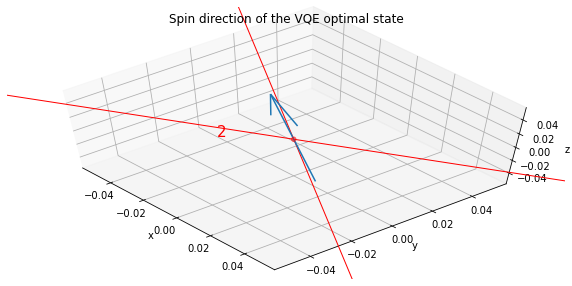

In [22]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
u=[]
v=[]
w=[]
print("Spin expected value")
for js,s in enumerate(spins_mat):
    val=np.dot(np.dot(np.conjugate(best_psi),s),best_psi)
    print("Spin ",spins[js][0]," ",np.round(np.real(val),3))
    if (js%3)==0:
        u.append(round(val,6))
    if (js%3)==1:
        v.append(round(val,6))
    if(js%3)==2:
        w.append(round(val,6))
            
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

ax.set_title("Spin direction of the VQE optimal state")
ax.quiver(x,y,z,u,v,w,length=0.1, pivot='middle', normalize=True)
        
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-40)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.02,y[i]-0.02,z[i],i,color='red',size=15)
            
plt.show()

#### Spin-spin correlation functions of the VQE optimal state

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value on $|\psi_{opt}\rangle$. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [23]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))
spin_spin_mat=[]
for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

Spin-spin operators number: 75


Optimal VQE energy:  -6.000000000000002 ; Precision:  -1.7763568394002505e-15
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (-3+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-0+0j)
     Spin-spin  0-4  0j
     Spin-spin  1-0  (-3+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  0j
     Spin-spin  1-4  (-0+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-0+0j)
     Spin-spin  3-1  0j
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (3+0j)
     Spin-spin  3-4  (-3+0j)
     Spin-spin  4-0  0j
     Spin-spin  4-1  (-0+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-3+0j)
     Spin-spin  4-4  (3+0j)


<ipython-input-24-34a5c49d5070>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


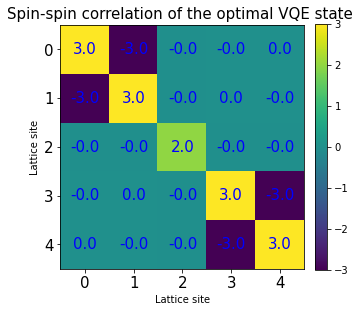

In [24]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
       
val=[]
for el in spins_mat:
    val.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
val2=[]
for el in spin_spin_mat:
    val2.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
        
ss=[0]*(nqubit*nqubit)
s=[0]*(nqubit*nqubit)
M=np.zeros((nqubit,nqubit))
    
n=0
p=0
for j in range(nqubit):
    for k in range(nqubit):
        sj=0
        sk=0
        for l in range(3):
            ss[p] += val2[n]
            sj+=val[3*j+l]**2
            sk+=val[3*k+l]**2
            n += 1
                
        s[p]=pow(sj,0.5)*pow(sk,0.5)
        M[j,k]=ss[p]-s[p]
        print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
        p+=     1

#Here we create a visual representation of the spin-spin correlation values
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(M)
    
ax.set_xticks(np.arange(nqubit))
ax.set_yticks(np.arange(nqubit))
ax.set_xticklabels(np.arange(nqubit), fontsize=15)
ax.set_yticklabels(np.arange(nqubit), fontsize=15)

ax.set_xlabel("Lattice site")
ax.set_ylabel("Lattice site")
        
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

for ii in range(nqubit):
    for jj in range(nqubit):
          text = ax.text(jj, ii, round(M[ii, jj],2), ha="center", va="center", color="b", fontsize=15)

ax.set_title("Spin-spin correlation of the optimal VQE state ", fontsize=15)
fig.tight_layout()
plt.show()

### VQE - Variation-after-projection (VAP) with $\Pi_{a,b}$

This time we are going to evaluate:

$$E(\theta)=\frac{\langle \psi(\theta)|\Pi_{a,b} H \Pi_{a,b}|\psi(\theta) \rangle}{\langle \psi(\theta)|\Pi_{a,b}|\psi(\theta) \rangle}$$

where $\theta$ is the vector of variational parameters.

We use the $\textbf{find_minimum}$ method of the $\textbf{VQE}$ algorithm to find the minimum of $E(a,b)$. We note that this method needs as argument the $\textbf{cost_fn}$ function, which works with the parameters of the chosen variational form as argument. In our case we have $10$ parameters for the variational form.

### $\Pi_{a=0,b=0}$

In [25]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

#If we want to transform psi_1 into a vector we use this function
#vec0=psi_1.construct_circuit(mode='vector')

P1=[p[1] for p in get_Pab()]
mat_P=P1[0]        #<-------- Important
def VQE_E(x):
    #Here we convert the circuit corresponding to the variational state into a vector 
    #circ=var_form.construct_circuit(x)       # To use with so4
    circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
    circ_v=CircuitStateFn(circ).to_matrix()
    #print(circ_v)
    
    mat_num=np.dot(np.dot(mat_P,mat_H),mat_P)
    mat_den=np.dot(mat_P,mat_P)
    
    #Evaluation of <circ_v|PHP|circ_v> and <circ_v|P|circ_v>
    #Warning: order is important!
    num=np.dot(np.dot(circ_v,mat_num),circ_v)
    den=np.dot(np.dot(circ_v,mat_den),circ_v)
    
    return num/den

def norm(x):
    #print(x)
    return np.linalg.norm(x)**2

emin = 10e4
best_param = None
for i in range(10):
    find_result=algo.find_minimum(cost_fn=VQE_E,optimizer=CG(maxiter=70,gtol=1e-10))
    if find_result['optimal_value']<emin:
        emin=find_result['optimal_value']
        best_param=find_result['opt_params']

2020-12-18 16:30:22,346:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.36083285  1.55181766  0.72048326  0.4857761   2.77180077 -0.67755271
  3.05590996 -1.83234108  0.4387508   0.18107026]
2020-12-18 16:30:22,348:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2020-12-18 16:30:53,809:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.36083285  1.55181766  0.72048326  0.4857761   2.7718

#### Projection with $\Pi_E$ and $\Pi_{s,s_z}$

In [26]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

best_circ=var_form.assign_parameters(best_param)        # To use with RealAmplitudes or TwoLocal
best_psi=CircuitStateFn(best_circ).to_matrix()

eps,Pi  = get_eigenpairs(H)
Ps=get_Pspin()

# having our best approximation to the ground state, we can see its component in each subspace
print("Diagnosis of the optimal VQE state")

# Projection on H-eigenvalues subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$"))
for i,P_el in enumerate(Pi):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el),best_psi))
    print("Projection on eigenspace with E=",eps[i]," : ",np.round(val,3))
    
# Projection on S^2,S_z subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt} \rangle$"))

for i,P_el in enumerate(Ps):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))

Optimal VQE energy:  -5.999999999999974 ; Precision:  2.5757174171303632e-14
Diagnosis of the optimal VQE state


Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$

Projection on eigenspace with E= -6.0  :  0.97
Projection on eigenspace with E= -4.0  :  0.0
Projection on eigenspace with E= -2.0  :  0.0
Projection on eigenspace with E= -0.0  :  0.03
Projection on eigenspace with E= 2.0  :  0.0
Projection on eigenspace with E= 4.0  :  0.0
Projection on eigenspace with E= 6.0  :  0.0


Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt} \rangle$

Projection on eigenspace  s=1,sz=-1  :  0.802
Projection on eigenspace  s=1,sz=1  :  0.168


#### Projection on the ground state eigenvectors of $H$

We project the VQE optimal state $|\psi_{opt\rangle}$ on the ground state of $H$. We know that the ground state is sixfold degenerate, therefore we expect that:

$$|\psi_{opt} \rangle=\sum_{i=0}^5 \underbrace{\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle}_{c_i}|\psi_{GS}^{(i)}\rangle$$

where $|\psi_{GS}^{(i)}\rangle$ refers to the ground state eigenvectors, where $i \in \{0,1,2,3,4,5\}$.

In  particular we will calculate the product:

$$c_i=\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle$$

In this specific case $|\psi_{GS}^{(i)}\rangle$ are also eigenstates of $R_v$ and $R_h$. When $i=0,1$ they correspond to the sector $a=1,b=1$; when $i=2,3$ to the sector $a=0,b=1$ and when  $i=4,5$  to the sector $a=0,b=0$.

In [27]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

v_H=get_proj_ground_eigv()

for i in range(6):
    if i<2:
        print("Ground state of H (a=1,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if 2<=i<4:
        print("Ground state of H (a=0,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if i>=4:
        print("Ground state of H (a=0,b=0)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))

Optimal VQE energy:  -5.999999999999974 ; Precision:  2.5757174171303632e-14
Ground state of H (a=1,b=1)- 0  :  (-0.212+0j)
Ground state of H (a=1,b=1)- 1  :  (0.023+0j)
Ground state of H (a=0,b=1)- 2  :  (0.212+0j)
Ground state of H (a=0,b=1)- 3  :  (-0.023+0j)
Ground state of H (a=0,b=0)- 4  :  (0.279+0j)
Ground state of H (a=0,b=0)- 5  :  (0.895+0j)


#### Spin plots of the VQE optimal state

We are going to evaluate $\langle \psi_{opt}|S_i^{\alpha}|\psi_{opt}\rangle$ where $S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$. $S_i^{\alpha} \in \{X_i,Y_i,Z_i\}$ where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices.

In [28]:
spins = generate_spin_operators(nqubit)
spins_mat=[]
for name_s,s in spins:
    spins_mat.append(s.to_matrix())

Optimal VQE energy:  -5.999999999999974 ; Precision:  2.5757174171303632e-14
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.0
Spin  1x   -0.0
Spin  1y   0.0
Spin  1z   0.0
Spin  2x   -0.583
Spin  2y   0.0
Spin  2z   -0.79
Spin  3x   0.557
Spin  3y   0.0
Spin  3z   -0.054
Spin  4x   -0.518
Spin  4y   0.0
Spin  4z   0.227


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


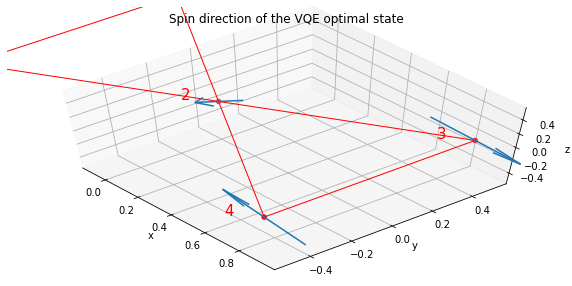

In [29]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
u=[]
v=[]
w=[]
print("Spin expected value")
for js,s in enumerate(spins_mat):
    val=np.dot(np.dot(np.conjugate(best_psi),s),best_psi)
    print("Spin ",spins[js][0]," ",np.round(np.real(val),3))
    if (js%3)==0:
        u.append(round(val,6))
    if (js%3)==1:
        v.append(round(val,6))
    if(js%3)==2:
        w.append(round(val,6))
            
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

ax.set_title("Spin direction of the VQE optimal state")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)
        
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-40)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.1,y[i]-0.1,z[i],i,color='red',size=15)
            
plt.show()

#### Spin-spin correlation functions of the VQE optimal state

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value on $|\psi_{opt}\rangle$. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [30]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))
spin_spin_mat=[]
for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

Spin-spin operators number: 75


Optimal VQE energy:  -5.999999999999974 ; Precision:  2.5757174171303632e-14
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (-3+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-0+0j)
     Spin-spin  0-4  (-0+0j)
     Spin-spin  1-0  (-3+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-1e-06+0j)
     Spin-spin  1-3  (-0+0j)
     Spin-spin  1-4  (-0+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-1e-06+0j)
     Spin-spin  2-2  (2.037124+0j)
     Spin-spin  2-3  (-1.088969+0j)
     Spin-spin  2-4  (-0.317669+0j)
     Spin-spin  3-0  (-0+0j)
     Spin-spin  3-1  (-0+0j)
     Spin-spin  3-2  (-1.088969+0j)
     Spin-spin  3-3  (2.686988+0j)
     Spin-spin  3-4  (-2.831804+0j)
     Spin-spin  4-0  (-0+0j)
     Spin-spin  4-1  (-0+0j)
     Spin-spin  4-2  (-0.317669+0j)
     Spin-spin  4-3  (-2.831804+0j)
     Spin-spin  4-4  (2.679716+0j)


<ipython-input-31-34a5c49d5070>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


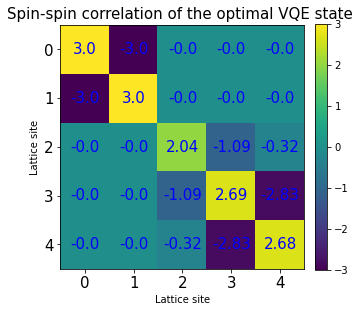

In [31]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
       
val=[]
for el in spins_mat:
    val.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
val2=[]
for el in spin_spin_mat:
    val2.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
        
ss=[0]*(nqubit*nqubit)
s=[0]*(nqubit*nqubit)
M=np.zeros((nqubit,nqubit))
    
n=0
p=0
for j in range(nqubit):
    for k in range(nqubit):
        sj=0
        sk=0
        for l in range(3):
            ss[p] += val2[n]
            sj+=val[3*j+l]**2
            sk+=val[3*k+l]**2
            n += 1
                
        s[p]=pow(sj,0.5)*pow(sk,0.5)
        M[j,k]=ss[p]-s[p]
        print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
        p+=     1

#Here we create a visual representation of the spin-spin correlation values
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(M)
    
ax.set_xticks(np.arange(nqubit))
ax.set_yticks(np.arange(nqubit))
ax.set_xticklabels(np.arange(nqubit), fontsize=15)
ax.set_yticklabels(np.arange(nqubit), fontsize=15)

ax.set_xlabel("Lattice site")
ax.set_ylabel("Lattice site")
        
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

for ii in range(nqubit):
    for jj in range(nqubit):
          text = ax.text(jj, ii, round(M[ii, jj],2), ha="center", va="center", color="b", fontsize=15)

ax.set_title("Spin-spin correlation of the optimal VQE state ", fontsize=15)
fig.tight_layout()
plt.show()

## VQE - Variation after projection (VAP) with $\Pi_{s,s_z}$

### $\Pi_{s=1,s_z=-1}$

In [32]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

#If we want to transform psi_1 into a vector we use this function
#vec0=psi_1.construct_circuit(mode='vector')

Ps=[p[1] for p in get_Pspin()]
mat_P=Ps[0]        #<-------- Important

def VQE_E(x):
    #Here we convert the circuit corresponding to the variational state into a vector 
    #circ=var_form.construct_circuit(x)       # To use with so4
    circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
    circ_v=CircuitStateFn(circ).to_matrix()
    #print(circ_v)
    
    mat_num=np.dot(np.dot(mat_P,mat_H),mat_P)
    mat_den=np.dot(mat_P,mat_P)
    
    #Evaluation of <circ_v|PHP|circ_v> and <circ_v|P|circ_v>
    #Warning: order is important!
    num=np.dot(np.dot(circ_v,mat_num),circ_v)
    den=np.dot(np.dot(circ_v,mat_den),circ_v)
    
    return num/den

def norm(x):
    #print(x)
    return np.linalg.norm(x)**2

emin = 10e4
best_param = None
for i in range(10):
    find_result=algo.find_minimum(cost_fn=VQE_E,optimizer=CG(maxiter=70,gtol=1e-10))
    if find_result['optimal_value']<emin:
        emin=find_result['optimal_value']
        best_param=find_result['opt_params']

2020-12-18 16:31:07,399:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.36083285  1.55181766  0.72048326  0.4857761   2.77180077 -0.67755271
  3.05590996 -1.83234108  0.4387508   0.18107026]
2020-12-18 16:31:07,401:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2020-12-18 16:31:23,455:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.36083285  1.55181766  0.72048326  0.4857761   2.7718

#### Projection with $\Pi_E$ 

In [33]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

best_circ=var_form.assign_parameters(best_param)        # To use with RealAmplitudes or TwoLocal
best_psi=CircuitStateFn(best_circ).to_matrix()

eps,Pi  = get_eigenpairs(H)
Ps=get_Pspin()

# having our best approximation to the ground state, we can see its component in each subspace
print("Diagnosis of the optimal VQE state")

# Projection on H-eigenvalues subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$"))
for i,P_el in enumerate(Pi):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el),best_psi))
    print("Projection on eigenspace with E=",eps[i]," : ",np.round(val,3))

Optimal VQE energy:  -6.0 ; Precision:  0.0
Diagnosis of the optimal VQE state


Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$

Projection on eigenspace with E= -6.0  :  0.682
Projection on eigenspace with E= -4.0  :  0.126
Projection on eigenspace with E= -2.0  :  0.017
Projection on eigenspace with E= -0.0  :  0.12
Projection on eigenspace with E= 2.0  :  0.013
Projection on eigenspace with E= 4.0  :  0.038
Projection on eigenspace with E= 6.0  :  0.004


#### Projection on the ground state eigenvectors of $H$

We project the VQE optimal state $|\psi_{opt\rangle}$ on the ground state of $H$. We know that the ground state is sixfold degenerate, therefore we expect that:

$$|\psi_{opt} \rangle=\sum_{i=0}^5 \underbrace{\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle}_{c_i}|\psi_{GS}^{(i)}\rangle$$

where $|\psi_{GS}^{(i)}\rangle$ refers to the ground state eigenvectors, where $i \in \{0,1,2,3,4,5\}$.

In  particular we will calculate the product:

$$c_i=\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle$$

In this specific case $|\psi_{GS}^{(i)}\rangle$ are also eigenstates of $R_v$ and $R_h$. When $i=0,1$ they correspond to the sector $a=1,b=1$; when $i=2,3$ to the sector $a=0,b=1$ and when  $i=4,5$  to the sector $a=0,b=0$.

In [34]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

v_H=get_proj_ground_eigv()

for i in range(6):
    if i<2:
        print("Ground state of H (a=1,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if 2<=i<4:
        print("Ground state of H (a=0,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if i>=4:
        print("Ground state of H (a=0,b=0)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))

Optimal VQE energy:  -6.0 ; Precision:  0.0
Ground state of H (a=1,b=1)- 0  :  (0.182+0j)
Ground state of H (a=1,b=1)- 1  :  (0.481+0j)
Ground state of H (a=0,b=1)- 2  :  (-0.14+0j)
Ground state of H (a=0,b=1)- 3  :  (-0.506+0j)
Ground state of H (a=0,b=0)- 4  :  (0.04+0j)
Ground state of H (a=0,b=0)- 5  :  (0.375+0j)


#### Spin plots of the VQE optimal state

We are going to evaluate $\langle \psi_{opt}|S_i^{\alpha}|\psi_{opt}\rangle$ where $S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$. $S_i^{\alpha} \in \{X_i,Y_i,Z_i\}$ where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices.

In [35]:
spins = generate_spin_operators(nqubit)
spins_mat=[]
for name_s,s in spins:
    spins_mat.append(s.to_matrix())

Optimal VQE energy:  -6.0 ; Precision:  0.0
Spin expected value
Spin  0x   0.691
Spin  0y   0.0
Spin  0z   0.158
Spin  1x   -0.598
Spin  1y   0.0
Spin  1z   -0.344
Spin  2x   -0.38
Spin  2y   0.0
Spin  2z   -0.087
Spin  3x   0.327
Spin  3y   0.0
Spin  3z   0.186
Spin  4x   0.412
Spin  4y   0.0
Spin  4z   -0.827


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


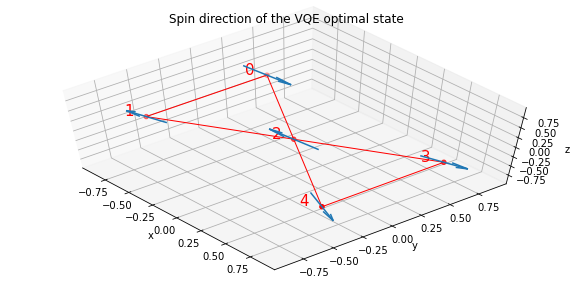

In [36]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
u=[]
v=[]
w=[]
print("Spin expected value")
for js,s in enumerate(spins_mat):
    val=np.dot(np.dot(np.conjugate(best_psi),s),best_psi)
    print("Spin ",spins[js][0]," ",np.round(np.real(val),3))
    if (js%3)==0:
        u.append(round(val,6))
    if (js%3)==1:
        v.append(round(val,6))
    if(js%3)==2:
        w.append(round(val,6))
            
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

ax.set_title("Spin direction of the VQE optimal state")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)
        
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-40)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.1,y[i]-0.1,z[i],i,color='red',size=15)
            
plt.show()

#### Spin-spin correlation functions of the VQE optimal state

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value on $|\psi_{opt}\rangle$. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [37]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))
spin_spin_mat=[]
for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

Spin-spin operators number: 75


Optimal VQE energy:  -6.0 ; Precision:  0.0
     Spin-spin  0-0  (2.498041+0j)
     Spin-spin  0-1  (-2.56875+0j)
     Spin-spin  0-2  (-0.483717+0j)
     Spin-spin  0-3  (-0.03399+0j)
     Spin-spin  0-4  (-0.500728+0j)
     Spin-spin  1-0  (-2.56875+0j)
     Spin-spin  1-1  (2.524771+0j)
     Spin-spin  1-2  (-0.153117+0j)
     Spin-spin  1-3  (-0.489599+0j)
     Spin-spin  1-4  (-0.598736+0j)
     Spin-spin  2-0  (-0.483717+0j)
     Spin-spin  2-1  (-0.153117+0j)
     Spin-spin  2-2  (2.847914+0j)
     Spin-spin  2-3  (-2.524228+0j)
     Spin-spin  2-4  (-0.537943+0j)
     Spin-spin  3-0  (-0.03399+0j)
     Spin-spin  3-1  (-0.489599+0j)
     Spin-spin  3-2  (-2.524228+0j)
     Spin-spin  3-3  (2.8588+0j)
     Spin-spin  3-4  (-0.040226+0j)
     Spin-spin  4-0  (-0.500728+0j)
     Spin-spin  4-1  (-0.598736+0j)
     Spin-spin  4-2  (-0.537943+0j)
     Spin-spin  4-3  (-0.040226+0j)
     Spin-spin  4-4  (2.146685+0j)


<ipython-input-38-34a5c49d5070>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


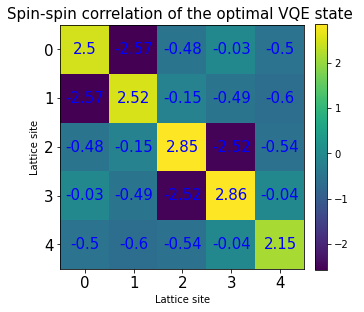

In [38]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
       
val=[]
for el in spins_mat:
    val.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
val2=[]
for el in spin_spin_mat:
    val2.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
        
ss=[0]*(nqubit*nqubit)
s=[0]*(nqubit*nqubit)
M=np.zeros((nqubit,nqubit))
    
n=0
p=0
for j in range(nqubit):
    for k in range(nqubit):
        sj=0
        sk=0
        for l in range(3):
            ss[p] += val2[n]
            sj+=val[3*j+l]**2
            sk+=val[3*k+l]**2
            n += 1
                
        s[p]=pow(sj,0.5)*pow(sk,0.5)
        M[j,k]=ss[p]-s[p]
        print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
        p+=     1

#Here we create a visual representation of the spin-spin correlation values
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(M)
    
ax.set_xticks(np.arange(nqubit))
ax.set_yticks(np.arange(nqubit))
ax.set_xticklabels(np.arange(nqubit), fontsize=15)
ax.set_yticklabels(np.arange(nqubit), fontsize=15)

ax.set_xlabel("Lattice site")
ax.set_ylabel("Lattice site")
        
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

for ii in range(nqubit):
    for jj in range(nqubit):
          text = ax.text(jj, ii, round(M[ii, jj],2), ha="center", va="center", color="b", fontsize=15)

ax.set_title("Spin-spin correlation of the optimal VQE state ", fontsize=15)
fig.tight_layout()
plt.show()

## so4 with $|\psi_3\rangle$

In [74]:
var_form  = so4(num_qubits=H.num_qubits,reps=1,connections=nn_list,initial_state=psi_3) # Ansatz SO(4)
print("Number of parameters in so4: ", var_form.num_parameters)

Number of parameters in so4:  36


### Statistics of the so4 circuit

We take $2000$ random parameter vectors to create the vector state $|\psi_k \rangle$ ($0 \le k < 2000$) associated with the corresponding variational form. By this way we can see how close they get to the ground state. Moreover, we can look at the statistics of energy and energy variance.

#### Histogram of $\langle \psi_k|\Pi_E|\psi_k \rangle$

We project the random vectors created using the **so4** circuit on the subspaces created by the eigenvalues of $H$. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. By this way we can see the contribution of the eigenspaces to the variational state created. 

How well does a tensor product of single-qubit states describe the bow-tie?


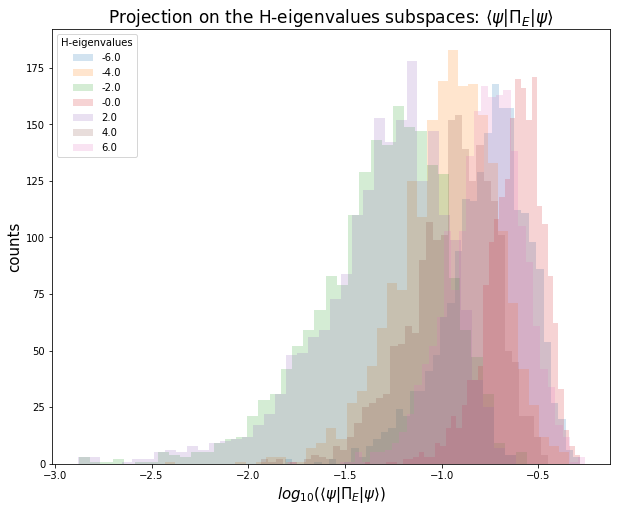

In [40]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

# Projection on H-eigenvalues subspaces
eps,Pi  = get_eigenpairs(H)
res = [[] for x in (eps)]
#res2=[[] for x in (eps)]

mat_H=H.to_matrix()

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    circ_x=var_form.construct_circuit(px)        # To use with so4
    #circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()     
    
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),Pi[i],psi_x))
        #PHP=np.dot(Pi[i],np.dot(mat_H,Pi[i]))
        #cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        #res2[i].append(cx2)

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on H-eigenvalues subspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for e,res_e in zip(eps,res):
    n,b,p = plt.hist(res_e,**kwargs,label=str(e))
plt.title(r'Projection on the H-eigenvalues subspaces: $\langle \psi|\Pi_{E}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{E}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title='H-eigenvalues')
plt.show()

#### Histogram of $\langle \psi_k|\Pi_{a,b}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{a,b} H \Pi_{a,b}|\psi_k \rangle}{\langle \psi_k|\Pi_{a,b}|\psi_k \rangle}$

We project the random vectors created using the **so4** circuit on the common eigenspaces of $R_v$ and $R_h$. We call $\Pi_{a,b}$ the projection operator on the subspaces corresponding to eigenvalues $(-1)^a$ and $(-1)^b$ of $R_v$ and $R_h$, respectively. It is defined as:

$$\Pi_{a,b}=\frac{1+(-1)^a R_v}{2}\frac{1+(-1)^b R_h}{2}$$

How well does a tensor product of single-qubit states describe the bow-tie?


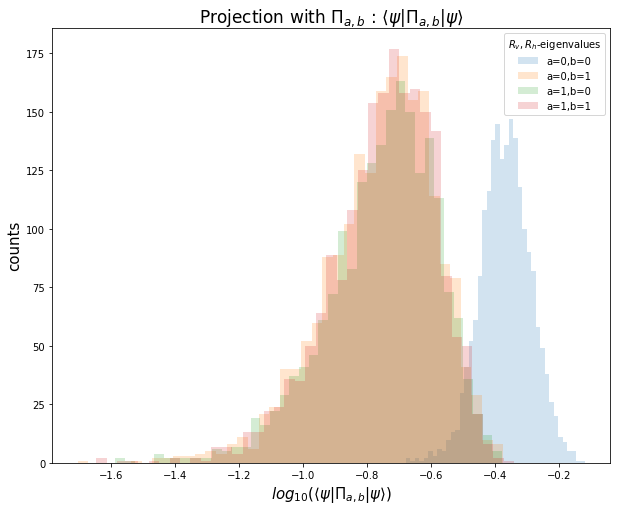

<Figure size 1800x1080 with 0 Axes>

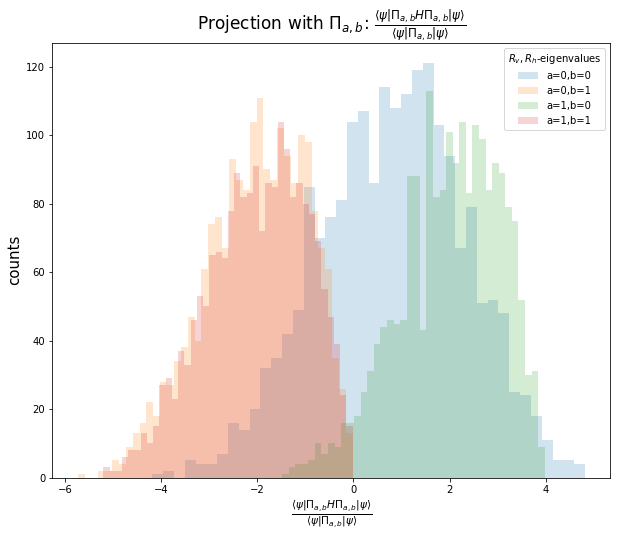

In [41]:
# Projection on \Pi_{a,b} eigenspaces
P_name=["a=0,b=0","a=0,b=1","a=1,b=0","a=1,b=1"]
P=get_Pab()
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    circ_x=var_form.construct_circuit(px)        # To use with so4
    #circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{a,b} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{a,b}$ : $\langle \psi|\Pi_{a,b}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{a,b}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{a,b}$: $\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.show()

As we expected the subspace corresponding to $a=1,b=0$ doesn't contribute to the ground state energy. However, we note that the bigger contribution of the sector $a=0,b=0$ between the $4$ above, while the sectors with $a=0,b=1$ and $a=1,b=1$ give the lower values.

#### Histogram of $\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi_k \rangle}{\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle}$

We project the random vectors created using the **so4** circuit on the common eigenspaces of $S^2$ and $S_z$ because the ground state is split in the sectors $s=1,s_z=-1$ and $s=1,s_z=1$. We call $\Pi_{s,s_z}$ the projection operator on the subspaces corresponding to eigenvalues $s_z=1$ and $s_z=-1$ of $S_z$, respectively.  

How well does a tensor product of single-qubit states describe the bow-tie?


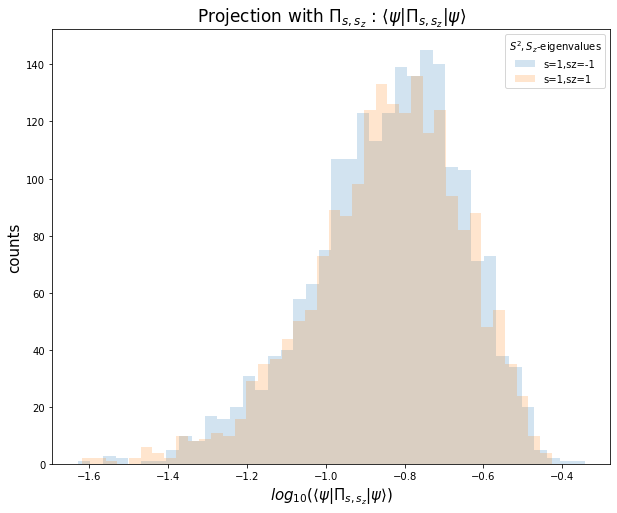

<Figure size 1800x1080 with 0 Axes>

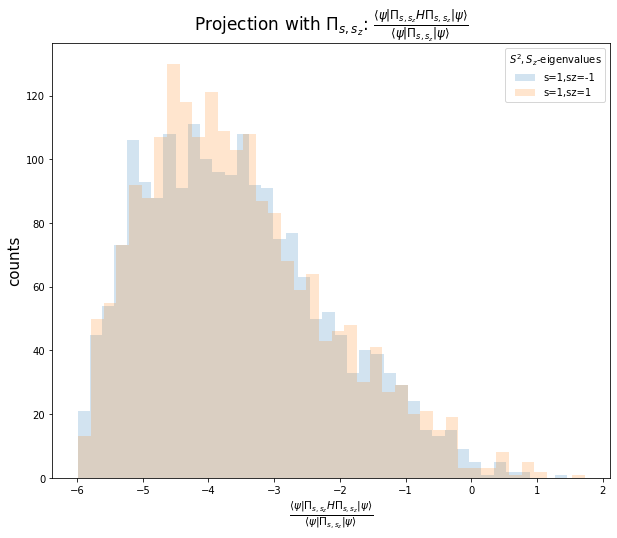

In [42]:
# Projection on \Pi_{s,sz} eigenspaces

P=get_Pspin()
P_name=["s=1,sz=-1","s=1,sz=1"]
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    circ_x=var_form.construct_circuit(px)        # To use with so4
    #circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{s,sz} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{s,s_z}$ : $\langle \psi|\Pi_{s,s_z}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{s,s_z}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{s,s_z}$: $\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.show()

### VQE - Projection-after-variation (PAV) with $\Pi_E$, $\Pi_{a,b}$  and $\Pi_{s,s_z}$

First we want to find the following expectation value:

$$E(\theta)=\langle \psi(\mathbf{\theta})|H|\psi(\mathbf{\theta}) \rangle$$

We make a cycle of $2$ iterations to find the minimum of $H$ through the VQE algorithm. We use the **so4** circuit with $n=36$ parameters. $|\psi(\mathbf{\theta})\rangle$, where $\mathbf{\theta}=(\theta_1,\theta_2, ..., \theta_n)^T$ is the vector of variational parameters, is the variational state which is optimized during the run of the algorithm.

In [15]:
emin = 10e4
best_psi = None
for i in range(2):
    algo             = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
    algo_result      = algo.run(quantum_instance_1)
    if(np.real(algo_result['eigenvalue'])<emin):
        emin = np.real(algo_result['eigenvalue'])
        best_psi = algo_result['eigenstate']


2020-12-18 16:57:42,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7ffcb5b4e370>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7ffcb5b4e160>>
-- initial_point: [ 3.00747261  2.91246256 -1.01399497 -0.74478415  2.32411601  2.23761978
 -1.37186183  0.90384149  0.25546545  1.6573391  -2.72226957 -2.95753143
 -2.56942116 -1.39479298 -2.61587124 -1.24229594  2.11983377  2.09821487
  1.537158

2020-12-18 16:57:43,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087366] - 8.56495 (ms), eval count: 5
2020-12-18 16:57:43,550:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01600 (ms)
2020-12-18 16:57:43,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087366] - 8.45814 (ms), eval count: 6
2020-12-18 16:57:43,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28922 (ms)
2020-12-18 16:57:43,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087366] - 8.30793 (ms), eval count: 7
2020-12-18 16:57:43,571:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03197 (ms)
2020-12-18 16:57:43,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087367] - 9.56702 (ms), eval count: 8
2020-12-18 16:57:43,582:qiskit.aqua.operators.converters.c

2020-12-18 16:57:43,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087365] - 9.21702 (ms), eval count: 36
2020-12-18 16:57:43,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91395 (ms)
2020-12-18 16:57:43,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60087366] - 7.25579 (ms), eval count: 37
2020-12-18 16:57:43,926:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.23186 (ms)
2020-12-18 16:57:43,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358313] - 10.70380 (ms), eval count: 38
2020-12-18 16:57:43,936:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92897 (ms)
2020-12-18 16:57:43,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358312] - 8.89611 (ms), eval count: 39
2020-12-18 16:57:43,946:qiskit.aqua.operators.convert

2020-12-18 16:57:44,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358313] - 16.29114 (ms), eval count: 67
2020-12-18 16:57:44,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.10614 (ms)
2020-12-18 16:57:44,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358313] - 13.28087 (ms), eval count: 68
2020-12-18 16:57:44,544:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.04710 (ms)
2020-12-18 16:57:44,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358312] - 17.83895 (ms), eval count: 69
2020-12-18 16:57:44,564:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.96111 (ms)
2020-12-18 16:57:44,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.72358313] - 18.48483 (ms), eval count: 70
2020-12-18 16:57:44,583:qiskit.aqua.operators.conv

2020-12-18 16:57:45,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.38914794] - 32.24015 (ms), eval count: 98
2020-12-18 16:57:45,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.30691 (ms)
2020-12-18 16:57:45,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.38914794] - 18.96119 (ms), eval count: 99
2020-12-18 16:57:45,086:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65894 (ms)
2020-12-18 16:57:45,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.38914793] - 11.34491 (ms), eval count: 100
2020-12-18 16:57:45,098:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12114 (ms)
2020-12-18 16:57:45,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.38914792] - 9.43518 (ms), eval count: 101
2020-12-18 16:57:45,109:qiskit.aqua.operators.con

2020-12-18 16:57:45,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.79226699] - 11.24692 (ms), eval count: 129
2020-12-18 16:57:45,601:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98071 (ms)
2020-12-18 16:57:45,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.79226699] - 8.65579 (ms), eval count: 130
2020-12-18 16:57:45,610:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90108 (ms)
2020-12-18 16:57:45,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.79226698] - 9.15885 (ms), eval count: 131
2020-12-18 16:57:45,621:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91300 (ms)
2020-12-18 16:57:45,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.79226697] - 9.32717 (ms), eval count: 132
2020-12-18 16:57:45,631:qiskit.aqua.operators.con

2020-12-18 16:57:46,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.83944362] - 10.16617 (ms), eval count: 160
2020-12-18 16:57:46,068:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82590 (ms)
2020-12-18 16:57:46,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.83944363] - 9.15384 (ms), eval count: 161
2020-12-18 16:57:46,078:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69120 (ms)
2020-12-18 16:57:46,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.83944362] - 8.90994 (ms), eval count: 162
2020-12-18 16:57:46,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92301 (ms)
2020-12-18 16:57:46,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.83944361] - 7.63822 (ms), eval count: 163
2020-12-18 16:57:46,097:qiskit.aqua.operators.con

2020-12-18 16:57:46,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.15785359] - 18.06188 (ms), eval count: 191
2020-12-18 16:57:46,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.93712 (ms)
2020-12-18 16:57:46,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.15785359] - 21.43121 (ms), eval count: 192
2020-12-18 16:57:46,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89702 (ms)
2020-12-18 16:57:46,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.15785358] - 12.31527 (ms), eval count: 193
2020-12-18 16:57:46,573:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53885 (ms)
2020-12-18 16:57:46,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.15785359] - 12.23898 (ms), eval count: 194
2020-12-18 16:57:46,587:qiskit.aqua.operators.

2020-12-18 16:57:46,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.15785359] - 9.24611 (ms), eval count: 222
2020-12-18 16:57:46,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67706 (ms)
2020-12-18 16:57:46,992:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634058] - 10.23483 (ms), eval count: 223
2020-12-18 16:57:47,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45485 (ms)
2020-12-18 16:57:47,005:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634058] - 9.60588 (ms), eval count: 224
2020-12-18 16:57:47,011:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98762 (ms)
2020-12-18 16:57:47,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634058] - 10.78391 (ms), eval count: 225
2020-12-18 16:57:47,022:qiskit.aqua.operators.co

2020-12-18 16:57:47,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634058] - 10.50305 (ms), eval count: 253
2020-12-18 16:57:47,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54600 (ms)
2020-12-18 16:57:47,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634057] - 9.41014 (ms), eval count: 254
2020-12-18 16:57:47,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65798 (ms)
2020-12-18 16:57:47,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634057] - 13.26537 (ms), eval count: 255
2020-12-18 16:57:47,519:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.92191 (ms)
2020-12-18 16:57:47,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.33634058] - 10.40697 (ms), eval count: 256
2020-12-18 16:57:47,552:qiskit.aqua.operators.c

2020-12-18 16:57:48,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.40455875] - 10.48493 (ms), eval count: 284
2020-12-18 16:57:48,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62396 (ms)
2020-12-18 16:57:48,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.40455876] - 10.54382 (ms), eval count: 285
2020-12-18 16:57:48,088:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93708 (ms)
2020-12-18 16:57:48,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.40455875] - 9.21106 (ms), eval count: 286
2020-12-18 16:57:48,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.70798 (ms)
2020-12-18 16:57:48,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.40455875] - 13.03911 (ms), eval count: 287
2020-12-18 16:57:48,114:qiskit.aqua.operators.c

2020-12-18 16:57:48,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.61415865] - 9.57108 (ms), eval count: 315
2020-12-18 16:57:48,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45414 (ms)
2020-12-18 16:57:48,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.61415865] - 10.19526 (ms), eval count: 316
2020-12-18 16:57:48,741:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.01912 (ms)
2020-12-18 16:57:48,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.61415865] - 12.61902 (ms), eval count: 317
2020-12-18 16:57:48,752:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53217 (ms)
2020-12-18 16:57:48,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.61415866] - 10.08511 (ms), eval count: 318
2020-12-18 16:57:48,765:qiskit.aqua.operators.c

2020-12-18 16:57:49,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78509244] - 10.97298 (ms), eval count: 346
2020-12-18 16:57:49,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25513 (ms)
2020-12-18 16:57:49,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78509244] - 11.01899 (ms), eval count: 347
2020-12-18 16:57:49,449:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09389 (ms)
2020-12-18 16:57:49,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78509243] - 10.77986 (ms), eval count: 348
2020-12-18 16:57:49,460:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29804 (ms)
2020-12-18 16:57:49,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78509244] - 9.14669 (ms), eval count: 349
2020-12-18 16:57:49,472:qiskit.aqua.operators.c

2020-12-18 16:57:49,963:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91616971] - 19.52720 (ms), eval count: 377
2020-12-18 16:57:49,976:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.63392 (ms)
2020-12-18 16:57:49,983:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91616971] - 15.12408 (ms), eval count: 378
2020-12-18 16:57:49,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.00202 (ms)
2020-12-18 16:57:49,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91616971] - 13.60989 (ms), eval count: 379
2020-12-18 16:57:50,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.93701 (ms)
2020-12-18 16:57:50,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91616971] - 11.53207 (ms), eval count: 380
2020-12-18 16:57:50,016:qiskit.aqua.operators.

2020-12-18 16:57:50,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 10.02908 (ms), eval count: 408
2020-12-18 16:57:50,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94893 (ms)
2020-12-18 16:57:50,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 10.20098 (ms), eval count: 409
2020-12-18 16:57:50,484:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99811 (ms)
2020-12-18 16:57:50,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735886] - 9.22084 (ms), eval count: 410
2020-12-18 16:57:50,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97499 (ms)
2020-12-18 16:57:50,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735885] - 9.46784 (ms), eval count: 411
2020-12-18 16:57:50,505:qiskit.aqua.operators.co

2020-12-18 16:57:50,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 22.46666 (ms), eval count: 439
2020-12-18 16:57:50,973:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.15518 (ms)
2020-12-18 16:57:50,984:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 18.72516 (ms), eval count: 440
2020-12-18 16:57:50,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.28130 (ms)
2020-12-18 16:57:51,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 23.11707 (ms), eval count: 441
2020-12-18 16:57:51,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79627 (ms)
2020-12-18 16:57:51,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90735887] - 12.01606 (ms), eval count: 442
2020-12-18 16:57:51,028:qiskit.aqua.operators.

2020-12-18 16:57:51,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.982031] - 14.78505 (ms), eval count: 470
2020-12-18 16:57:51,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.49293 (ms)
2020-12-18 16:57:51,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.982031] - 17.10105 (ms), eval count: 471
2020-12-18 16:57:51,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.46197 (ms)
2020-12-18 16:57:51,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.982031] - 43.82825 (ms), eval count: 472
2020-12-18 16:57:51,626:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.13196 (ms)
2020-12-18 16:57:51,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.982031] - 25.11930 (ms), eval count: 473
2020-12-18 16:57:51,655:qiskit.aqua.operators.convert

2020-12-18 16:57:52,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04096154] - 11.41095 (ms), eval count: 501
2020-12-18 16:57:52,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96926 (ms)
2020-12-18 16:57:52,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04096154] - 9.25899 (ms), eval count: 502
2020-12-18 16:57:52,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93398 (ms)
2020-12-18 16:57:52,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04096154] - 10.39577 (ms), eval count: 503
2020-12-18 16:57:52,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11899 (ms)
2020-12-18 16:57:52,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04096154] - 10.40387 (ms), eval count: 504
2020-12-18 16:57:52,143:qiskit.aqua.operators.c

2020-12-18 16:57:52,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01872355] - 9.98998 (ms), eval count: 532
2020-12-18 16:57:52,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.89306 (ms)
2020-12-18 16:57:52,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01872355] - 13.05008 (ms), eval count: 533
2020-12-18 16:57:52,570:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00097 (ms)
2020-12-18 16:57:52,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01872355] - 10.00881 (ms), eval count: 534
2020-12-18 16:57:52,583:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79937 (ms)
2020-12-18 16:57:52,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01872355] - 10.38098 (ms), eval count: 535
2020-12-18 16:57:52,594:qiskit.aqua.operators.c

2020-12-18 16:57:53,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06613295] - 20.03407 (ms), eval count: 563
2020-12-18 16:57:53,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.13387 (ms)
2020-12-18 16:57:53,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06613295] - 13.72886 (ms), eval count: 564
2020-12-18 16:57:53,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.25205 (ms)
2020-12-18 16:57:53,245:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06613295] - 20.29896 (ms), eval count: 565
2020-12-18 16:57:53,258:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.59792 (ms)
2020-12-18 16:57:53,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06613295] - 18.48602 (ms), eval count: 566
2020-12-18 16:57:53,279:qiskit.aqua.operators.

2020-12-18 16:57:53,676:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 13.10706 (ms), eval count: 594
2020-12-18 16:57:53,680:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96593 (ms)
2020-12-18 16:57:53,691:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 13.88812 (ms), eval count: 595
2020-12-18 16:57:53,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58694 (ms)
2020-12-18 16:57:53,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 22.40801 (ms), eval count: 596
2020-12-18 16:57:53,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.04789 (ms)
2020-12-18 16:57:53,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 22.38011 (ms), eval count: 597
2020-12-18 16:57:53,758:qiskit.aqua.operators.

2020-12-18 16:57:54,297:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 13.23891 (ms), eval count: 625
2020-12-18 16:57:54,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56111 (ms)
2020-12-18 16:57:54,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 26.13521 (ms), eval count: 626
2020-12-18 16:57:54,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.30601 (ms)
2020-12-18 16:57:54,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 19.38701 (ms), eval count: 627
2020-12-18 16:57:54,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.83675 (ms)
2020-12-18 16:57:54,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09129001] - 16.95013 (ms), eval count: 628
2020-12-18 16:57:54,380:qiskit.aqua.operators.

2020-12-18 16:57:54,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12373406] - 13.63587 (ms), eval count: 656
2020-12-18 16:57:54,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56493 (ms)
2020-12-18 16:57:55,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12373406] - 10.60081 (ms), eval count: 657
2020-12-18 16:57:55,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.77888 (ms)
2020-12-18 16:57:55,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12373406] - 15.59901 (ms), eval count: 658
2020-12-18 16:57:55,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.98488 (ms)
2020-12-18 16:57:55,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12373406] - 26.01194 (ms), eval count: 659
2020-12-18 16:57:55,055:qiskit.aqua.operators.

2020-12-18 16:57:55,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14965847] - 8.34584 (ms), eval count: 687
2020-12-18 16:57:55,436:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09491 (ms)
2020-12-18 16:57:55,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14965847] - 9.28283 (ms), eval count: 688
2020-12-18 16:57:55,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.39717 (ms)
2020-12-18 16:57:55,459:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14965847] - 15.14482 (ms), eval count: 689
2020-12-18 16:57:55,485:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.05325 (ms)
2020-12-18 16:57:55,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14965846] - 24.26100 (ms), eval count: 690
2020-12-18 16:57:55,514:qiskit.aqua.operators.c

2020-12-18 16:57:56,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16212187] - 27.79698 (ms), eval count: 718
2020-12-18 16:57:56,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.55055 (ms)
2020-12-18 16:57:56,180:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16212187] - 33.86402 (ms), eval count: 719
2020-12-18 16:57:56,186:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76105 (ms)
2020-12-18 16:57:56,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16212187] - 14.80412 (ms), eval count: 720
2020-12-18 16:57:56,209:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.96382 (ms)
2020-12-18 16:57:56,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16212187] - 19.20319 (ms), eval count: 721
2020-12-18 16:57:56,224:qiskit.aqua.operators.

2020-12-18 16:57:56,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16822899] - 12.83717 (ms), eval count: 749
2020-12-18 16:57:56,602:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44205 (ms)
2020-12-18 16:57:56,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16822899] - 9.91201 (ms), eval count: 750
2020-12-18 16:57:56,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72624 (ms)
2020-12-18 16:57:56,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16822899] - 9.54700 (ms), eval count: 751
2020-12-18 16:57:56,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:57:56,631:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.168229] - 9.33886 (ms), eval count: 752
2020-12-18 16:57:56,638:qiskit.aqua.operators.conve

2020-12-18 16:57:57,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 8.26502 (ms), eval count: 780
2020-12-18 16:57:57,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66831 (ms)
2020-12-18 16:57:57,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 10.50711 (ms), eval count: 781
2020-12-18 16:57:57,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06082 (ms)
2020-12-18 16:57:57,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 11.66606 (ms), eval count: 782
2020-12-18 16:57:57,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48592 (ms)
2020-12-18 16:57:57,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 24.36686 (ms), eval count: 783
2020-12-18 16:57:57,159:qiskit.aqua.operators.conve

2020-12-18 16:57:57,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 8.65531 (ms), eval count: 811
2020-12-18 16:57:57,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77822 (ms)
2020-12-18 16:57:57,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 10.02908 (ms), eval count: 812
2020-12-18 16:57:57,617:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00002 (ms)
2020-12-18 16:57:57,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 7.93600 (ms), eval count: 813
2020-12-18 16:57:57,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47090 (ms)
2020-12-18 16:57:57,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1995293] - 9.47213 (ms), eval count: 814
2020-12-18 16:57:57,638:qiskit.aqua.operators.convert

2020-12-18 16:57:58,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22475398] - 9.63092 (ms), eval count: 842
2020-12-18 16:57:58,098:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92683 (ms)
2020-12-18 16:57:58,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22475397] - 9.95207 (ms), eval count: 843
2020-12-18 16:57:58,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01075 (ms)
2020-12-18 16:57:58,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22475397] - 10.10370 (ms), eval count: 844
2020-12-18 16:57:58,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99811 (ms)
2020-12-18 16:57:58,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22475398] - 12.15100 (ms), eval count: 845
2020-12-18 16:57:58,133:qiskit.aqua.operators.co

2020-12-18 16:57:58,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29889514] - 9.21535 (ms), eval count: 873
2020-12-18 16:57:58,555:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95186 (ms)
2020-12-18 16:57:58,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29889515] - 7.63774 (ms), eval count: 874
2020-12-18 16:57:58,565:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00209 (ms)
2020-12-18 16:57:58,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29889514] - 9.87697 (ms), eval count: 875
2020-12-18 16:57:58,575:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94209 (ms)
2020-12-18 16:57:58,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.29889515] - 8.09669 (ms), eval count: 876
2020-12-18 16:57:58,588:qiskit.aqua.operators.conv

2020-12-18 16:57:59,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38097877] - 9.31811 (ms), eval count: 904
2020-12-18 16:57:59,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21174 (ms)
2020-12-18 16:57:59,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38097877] - 9.12905 (ms), eval count: 905
2020-12-18 16:57:59,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76821 (ms)
2020-12-18 16:57:59,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38097877] - 9.21202 (ms), eval count: 906
2020-12-18 16:57:59,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92110 (ms)
2020-12-18 16:57:59,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.38097877] - 9.15003 (ms), eval count: 907
2020-12-18 16:57:59,112:qiskit.aqua.operators.conv

2020-12-18 16:57:59,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.45694725] - 8.90207 (ms), eval count: 935
2020-12-18 16:57:59,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23200 (ms)
2020-12-18 16:57:59,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.45694725] - 8.06093 (ms), eval count: 936
2020-12-18 16:57:59,617:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80921 (ms)
2020-12-18 16:57:59,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.45694725] - 9.66907 (ms), eval count: 937
2020-12-18 16:57:59,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92492 (ms)
2020-12-18 16:57:59,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.45694725] - 8.84318 (ms), eval count: 938
2020-12-18 16:57:59,637:qiskit.aqua.operators.conv

2020-12-18 16:58:00,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 11.86895 (ms), eval count: 966
2020-12-18 16:58:00,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00694 (ms)
2020-12-18 16:58:00,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 11.72304 (ms), eval count: 967
2020-12-18 16:58:00,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52614 (ms)
2020-12-18 16:58:00,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 8.76498 (ms), eval count: 968
2020-12-18 16:58:00,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22318 (ms)
2020-12-18 16:58:00,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 10.69021 (ms), eval count: 969
2020-12-18 16:58:00,111:qiskit.aqua.operators.c

2020-12-18 16:58:00,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 15.76900 (ms), eval count: 997
2020-12-18 16:58:00,565:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.96380 (ms)
2020-12-18 16:58:00,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 13.99112 (ms), eval count: 998
2020-12-18 16:58:00,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.61485 (ms)
2020-12-18 16:58:00,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.37541263] - 13.12923 (ms), eval count: 999
2020-12-18 16:58:00,601:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.46012 (ms)
2020-12-18 16:58:00,611:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48345271] - 17.64011 (ms), eval count: 1000
2020-12-18 16:58:00,620:qiskit.aqua.operators

2020-12-18 16:58:01,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48345271] - 11.71613 (ms), eval count: 1028
2020-12-18 16:58:01,020:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15809 (ms)
2020-12-18 16:58:01,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48345271] - 10.59413 (ms), eval count: 1029
2020-12-18 16:58:01,034:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99597 (ms)
2020-12-18 16:58:01,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48345271] - 7.80535 (ms), eval count: 1030
2020-12-18 16:58:01,045:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04604 (ms)
2020-12-18 16:58:01,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.48345271] - 8.62694 (ms), eval count: 1031
2020-12-18 16:58:01,056:qiskit.aqua.operator

2020-12-18 16:58:01,355:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49561814] - 9.91797 (ms), eval count: 1059
2020-12-18 16:58:01,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10414 (ms)
2020-12-18 16:58:01,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49561814] - 9.00817 (ms), eval count: 1060
2020-12-18 16:58:01,370:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77011 (ms)
2020-12-18 16:58:01,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49561814] - 9.62615 (ms), eval count: 1061
2020-12-18 16:58:01,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77798 (ms)
2020-12-18 16:58:01,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49561814] - 9.99713 (ms), eval count: 1062
2020-12-18 16:58:01,392:qiskit.aqua.operators.

2020-12-18 16:58:01,824:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50078365] - 9.08113 (ms), eval count: 1090
2020-12-18 16:58:01,830:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21667 (ms)
2020-12-18 16:58:01,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50078365] - 13.59916 (ms), eval count: 1091
2020-12-18 16:58:01,862:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15285 (ms)
2020-12-18 16:58:01,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50078365] - 14.65702 (ms), eval count: 1092
2020-12-18 16:58:01,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71480 (ms)
2020-12-18 16:58:01,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.50078365] - 9.55319 (ms), eval count: 1093
2020-12-18 16:58:01,890:qiskit.aqua.operator

2020-12-18 16:58:02,231:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.51584872] - 8.86202 (ms), eval count: 1121
2020-12-18 16:58:02,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03221 (ms)
2020-12-18 16:58:02,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.51584872] - 9.99212 (ms), eval count: 1122
2020-12-18 16:58:02,247:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97713 (ms)
2020-12-18 16:58:02,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.51584872] - 10.97512 (ms), eval count: 1123
2020-12-18 16:58:02,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94399 (ms)
2020-12-18 16:58:02,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.51584872] - 10.08701 (ms), eval count: 1124
2020-12-18 16:58:02,270:qiskit.aqua.operator

2020-12-18 16:58:02,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 10.89811 (ms), eval count: 1152
2020-12-18 16:58:02,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81899 (ms)
2020-12-18 16:58:02,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 13.88073 (ms), eval count: 1153
2020-12-18 16:58:02,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96617 (ms)
2020-12-18 16:58:02,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 11.08027 (ms), eval count: 1154
2020-12-18 16:58:02,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47400 (ms)
2020-12-18 16:58:02,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 9.66120 (ms), eval count: 1155
2020-12-18 16:58:02,720:qiskit.aqua.operato

2020-12-18 16:58:03,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 12.41899 (ms), eval count: 1183
2020-12-18 16:58:03,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.94480 (ms)
2020-12-18 16:58:03,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.53401686] - 12.86578 (ms), eval count: 1184
2020-12-18 16:58:03,075:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.11696 (ms)
2020-12-18 16:58:03,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5445056] - 16.65115 (ms), eval count: 1185
2020-12-18 16:58:03,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.01802 (ms)
2020-12-18 16:58:03,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5445056] - 15.18416 (ms), eval count: 1186
2020-12-18 16:58:03,116:qiskit.aqua.operator

2020-12-18 16:58:03,656:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5445056] - 14.11605 (ms), eval count: 1214
2020-12-18 16:58:03,672:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.01716 (ms)
2020-12-18 16:58:03,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5445056] - 17.77101 (ms), eval count: 1215
2020-12-18 16:58:03,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.17099 (ms)
2020-12-18 16:58:03,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5445056] - 14.18996 (ms), eval count: 1216
2020-12-18 16:58:03,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.42593 (ms)
2020-12-18 16:58:03,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54450559] - 12.85696 (ms), eval count: 1217
2020-12-18 16:58:03,721:qiskit.aqua.operator

2020-12-18 16:58:04,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682486] - 10.75602 (ms), eval count: 1245
2020-12-18 16:58:04,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.42195 (ms)
2020-12-18 16:58:04,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682486] - 12.67004 (ms), eval count: 1246
2020-12-18 16:58:04,149:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.06330 (ms)
2020-12-18 16:58:04,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682486] - 14.73188 (ms), eval count: 1247
2020-12-18 16:58:04,163:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19886 (ms)
2020-12-18 16:58:04,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.54682486] - 9.12905 (ms), eval count: 1248
2020-12-18 16:58:04,173:qiskit.aqua.operato

2020-12-18 16:58:04,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55319271] - 11.01398 (ms), eval count: 1276
2020-12-18 16:58:04,539:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88098 (ms)
2020-12-18 16:58:04,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5531927] - 9.03296 (ms), eval count: 1277
2020-12-18 16:58:04,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44276 (ms)
2020-12-18 16:58:04,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5531927] - 13.44991 (ms), eval count: 1278
2020-12-18 16:58:04,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.56319 (ms)
2020-12-18 16:58:04,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5531927] - 14.92023 (ms), eval count: 1279
2020-12-18 16:58:04,582:qiskit.aqua.operators.

2020-12-18 16:58:05,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5553419] - 11.77287 (ms), eval count: 1307
2020-12-18 16:58:05,012:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37029 (ms)
2020-12-18 16:58:05,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5553419] - 12.63213 (ms), eval count: 1308
2020-12-18 16:58:05,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57294 (ms)
2020-12-18 16:58:05,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5553419] - 12.61425 (ms), eval count: 1309
2020-12-18 16:58:05,042:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.67913 (ms)
2020-12-18 16:58:05,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5553419] - 15.42282 (ms), eval count: 1310
2020-12-18 16:58:05,059:qiskit.aqua.operators.

2020-12-18 16:58:05,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56845657] - 16.32786 (ms), eval count: 1338
2020-12-18 16:58:05,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 22.60184 (ms)
2020-12-18 16:58:05,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56845657] - 31.00705 (ms), eval count: 1339
2020-12-18 16:58:05,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.88624 (ms)
2020-12-18 16:58:05,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56845657] - 17.10105 (ms), eval count: 1340
2020-12-18 16:58:05,613:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.54370 (ms)
2020-12-18 16:58:05,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56845657] - 22.60518 (ms), eval count: 1341
2020-12-18 16:58:05,625:qiskit.aqua.oper

2020-12-18 16:58:06,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.38502 (ms)
2020-12-18 16:58:06,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.56845657] - 15.97285 (ms), eval count: 1369
2020-12-18 16:58:06,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.85804 (ms)
2020-12-18 16:58:06,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57329707] - 16.82210 (ms), eval count: 1370
2020-12-18 16:58:06,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.96809 (ms)
2020-12-18 16:58:06,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57329707] - 15.95187 (ms), eval count: 1371
2020-12-18 16:58:06,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.89094 (ms)
2020-12-18 16:58:06,341:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:06,885:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.51615 (ms)
2020-12-18 16:58:06,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57329707] - 18.50224 (ms), eval count: 1400
2020-12-18 16:58:06,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.18603 (ms)
2020-12-18 16:58:06,926:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57329707] - 16.50882 (ms), eval count: 1401
2020-12-18 16:58:06,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.93717 (ms)
2020-12-18 16:58:06,941:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57329707] - 11.33108 (ms), eval count: 1402
2020-12-18 16:58:06,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.11424 (ms)
2020-12-18 16:58:06,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:07,450:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11589 (ms)
2020-12-18 16:58:07,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59599979] - 12.03394 (ms), eval count: 1431
2020-12-18 16:58:07,466:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.16105 (ms)
2020-12-18 16:58:07,471:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59599979] - 10.04124 (ms), eval count: 1432
2020-12-18 16:58:07,476:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99072 (ms)
2020-12-18 16:58:07,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59599979] - 11.27815 (ms), eval count: 1433
2020-12-18 16:58:07,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72195 (ms)
2020-12-18 16:58:07,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:08,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90887 (ms)
2020-12-18 16:58:08,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61602375] - 15.28931 (ms), eval count: 1462
2020-12-18 16:58:08,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.61690 (ms)
2020-12-18 16:58:08,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61602375] - 15.40804 (ms), eval count: 1463
2020-12-18 16:58:08,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.74398 (ms)
2020-12-18 16:58:08,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61602375] - 17.86804 (ms), eval count: 1464
2020-12-18 16:58:08,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.10499 (ms)
2020-12-18 16:58:08,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:08,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.06029 (ms)
2020-12-18 16:58:08,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62377791] - 17.16208 (ms), eval count: 1493
2020-12-18 16:58:08,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.31723 (ms)
2020-12-18 16:58:08,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62377791] - 18.38803 (ms), eval count: 1494
2020-12-18 16:58:08,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.39808 (ms)
2020-12-18 16:58:08,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62377791] - 20.27082 (ms), eval count: 1495
2020-12-18 16:58:08,717:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.25999 (ms)
2020-12-18 16:58:08,725:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:09,282:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.43697 (ms)
2020-12-18 16:58:09,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62896726] - 11.30414 (ms), eval count: 1524
2020-12-18 16:58:09,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92993 (ms)
2020-12-18 16:58:09,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62896726] - 8.79383 (ms), eval count: 1525
2020-12-18 16:58:09,306:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29804 (ms)
2020-12-18 16:58:09,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.62896726] - 10.07271 (ms), eval count: 1526
2020-12-18 16:58:09,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94304 (ms)
2020-12-18 16:58:09,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:09,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.04494 (ms)
2020-12-18 16:58:09,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 12.32314 (ms), eval count: 1555
2020-12-18 16:58:09,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20172 (ms)
2020-12-18 16:58:09,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 6.91819 (ms), eval count: 1556
2020-12-18 16:58:09,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.61984 (ms)
2020-12-18 16:58:09,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 11.99794 (ms), eval count: 1557
2020-12-18 16:58:09,980:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02482 (ms)
2020-12-18 16:58:09,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:10,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68690 (ms)
2020-12-18 16:58:10,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 10.60009 (ms), eval count: 1586
2020-12-18 16:58:10,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34501 (ms)
2020-12-18 16:58:10,563:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 9.40800 (ms), eval count: 1587
2020-12-18 16:58:10,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95305 (ms)
2020-12-18 16:58:10,573:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63492138] - 8.97789 (ms), eval count: 1588
2020-12-18 16:58:10,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51000 (ms)
2020-12-18 16:58:10,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:11,168:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.36692 (ms)
2020-12-18 16:58:11,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63742038] - 32.23705 (ms), eval count: 1617
2020-12-18 16:58:11,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.29315 (ms)
2020-12-18 16:58:11,211:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63742038] - 22.25399 (ms), eval count: 1618
2020-12-18 16:58:11,222:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.49595 (ms)
2020-12-18 16:58:11,231:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.63742038] - 15.42187 (ms), eval count: 1619
2020-12-18 16:58:11,244:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.61500 (ms)
2020-12-18 16:58:11,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:11,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.51483 (ms)
2020-12-18 16:58:11,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.6275841] - 29.10995 (ms), eval count: 1648
2020-12-18 16:58:11,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.01506 (ms)
2020-12-18 16:58:11,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.6275841] - 31.90088 (ms), eval count: 1649
2020-12-18 16:58:11,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.80502 (ms)
2020-12-18 16:58:11,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.6275841] - 10.00595 (ms), eval count: 1650
2020-12-18 16:58:11,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11892 (ms)
2020-12-18 16:58:11,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:12,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60608 (ms)
2020-12-18 16:58:12,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64015919] - 25.05684 (ms), eval count: 1679
2020-12-18 16:58:12,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.04708 (ms)
2020-12-18 16:58:12,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64015919] - 15.99383 (ms), eval count: 1680
2020-12-18 16:58:12,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.98084 (ms)
2020-12-18 16:58:12,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64015919] - 29.75082 (ms), eval count: 1681
2020-12-18 16:58:12,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.79994 (ms)
2020-12-18 16:58:12,482:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:13,069:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.70138 (ms)
2020-12-18 16:58:13,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64400811] - 10.74910 (ms), eval count: 1710
2020-12-18 16:58:13,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.41170 (ms)
2020-12-18 16:58:13,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64400811] - 11.37829 (ms), eval count: 1711
2020-12-18 16:58:13,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30210 (ms)
2020-12-18 16:58:13,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64400811] - 9.63521 (ms), eval count: 1712
2020-12-18 16:58:13,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94399 (ms)
2020-12-18 16:58:13,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:13,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.53484 (ms)
2020-12-18 16:58:13,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 20.23911 (ms), eval count: 1741
2020-12-18 16:58:13,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01409 (ms)
2020-12-18 16:58:13,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 8.33011 (ms), eval count: 1742
2020-12-18 16:58:13,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.62286 (ms)
2020-12-18 16:58:13,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 13.59296 (ms), eval count: 1743
2020-12-18 16:58:13,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61300 (ms)
2020-12-18 16:58:13,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:14,184:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50993 (ms)
2020-12-18 16:58:14,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 10.32114 (ms), eval count: 1772
2020-12-18 16:58:14,195:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82710 (ms)
2020-12-18 16:58:14,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 9.33576 (ms), eval count: 1773
2020-12-18 16:58:14,206:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77488 (ms)
2020-12-18 16:58:14,212:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64726817] - 9.45306 (ms), eval count: 1774
2020-12-18 16:58:14,215:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97689 (ms)
2020-12-18 16:58:14,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:14,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.64086 (ms)
2020-12-18 16:58:14,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65075803] - 19.63687 (ms), eval count: 1803
2020-12-18 16:58:14,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.37086 (ms)
2020-12-18 16:58:14,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65075803] - 13.70120 (ms), eval count: 1804
2020-12-18 16:58:14,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.58307 (ms)
2020-12-18 16:58:14,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65075803] - 19.53197 (ms), eval count: 1805
2020-12-18 16:58:14,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.59888 (ms)
2020-12-18 16:58:14,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:15,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17216 (ms)
2020-12-18 16:58:15,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65703981] - 7.40695 (ms), eval count: 1834
2020-12-18 16:58:15,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25084 (ms)
2020-12-18 16:58:15,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65703981] - 10.80227 (ms), eval count: 1835
2020-12-18 16:58:15,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09491 (ms)
2020-12-18 16:58:15,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65703981] - 8.48198 (ms), eval count: 1836
2020-12-18 16:58:15,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.23329 (ms)
2020-12-18 16:58:15,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:15,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09389 (ms)
2020-12-18 16:58:15,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.66699222] - 24.99938 (ms), eval count: 1865
2020-12-18 16:58:15,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.19133 (ms)
2020-12-18 16:58:15,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.66699222] - 17.98201 (ms), eval count: 1866
2020-12-18 16:58:16,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.50217 (ms)
2020-12-18 16:58:16,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.66699222] - 20.16306 (ms), eval count: 1867
2020-12-18 16:58:16,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.27734 (ms)
2020-12-18 16:58:16,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:16,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58796 (ms)
2020-12-18 16:58:16,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.6996184] - 10.90693 (ms), eval count: 1896
2020-12-18 16:58:16,518:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.54132 (ms)
2020-12-18 16:58:16,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69961839] - 16.73079 (ms), eval count: 1897
2020-12-18 16:58:16,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00694 (ms)
2020-12-18 16:58:16,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69961839] - 10.00190 (ms), eval count: 1898
2020-12-18 16:58:16,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03984 (ms)
2020-12-18 16:58:16,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:16,974:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17407 (ms)
2020-12-18 16:58:16,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068256] - 8.73399 (ms), eval count: 1927
2020-12-18 16:58:16,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91705 (ms)
2020-12-18 16:58:16,992:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068255] - 11.51276 (ms), eval count: 1928
2020-12-18 16:58:16,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99811 (ms)
2020-12-18 16:58:17,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068254] - 9.60016 (ms), eval count: 1929
2020-12-18 16:58:17,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09205 (ms)
2020-12-18 16:58:17,018:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:17,515:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49402 (ms)
2020-12-18 16:58:17,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068256] - 8.86202 (ms), eval count: 1958
2020-12-18 16:58:17,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42298 (ms)
2020-12-18 16:58:17,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068256] - 10.68497 (ms), eval count: 1959
2020-12-18 16:58:17,537:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96092 (ms)
2020-12-18 16:58:17,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.36068256] - 9.06587 (ms), eval count: 1960
2020-12-18 16:58:17,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65989 (ms)
2020-12-18 16:58:17,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:17,971:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.13799 (ms)
2020-12-18 16:58:17,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71990939] - 9.49407 (ms), eval count: 1989
2020-12-18 16:58:17,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82011 (ms)
2020-12-18 16:58:17,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71990939] - 10.67495 (ms), eval count: 1990
2020-12-18 16:58:17,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94709 (ms)
2020-12-18 16:58:17,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71990939] - 7.70593 (ms), eval count: 1991
2020-12-18 16:58:18,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67999 (ms)
2020-12-18 16:58:18,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:18,333:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02832 (ms)
2020-12-18 16:58:18,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72231166] - 9.01914 (ms), eval count: 2020
2020-12-18 16:58:18,342:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18098 (ms)
2020-12-18 16:58:18,347:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72231166] - 8.07691 (ms), eval count: 2021
2020-12-18 16:58:18,352:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62110 (ms)
2020-12-18 16:58:18,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72231165] - 9.49192 (ms), eval count: 2022
2020-12-18 16:58:18,362:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02100 (ms)
2020-12-18 16:58:18,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:18,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57819 (ms)
2020-12-18 16:58:18,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55199021] - 10.29801 (ms), eval count: 2051
2020-12-18 16:58:18,757:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50285 (ms)
2020-12-18 16:58:18,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55199021] - 14.00208 (ms), eval count: 2052
2020-12-18 16:58:18,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.25410 (ms)
2020-12-18 16:58:18,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55199021] - 15.65790 (ms), eval count: 2053
2020-12-18 16:58:18,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69620 (ms)
2020-12-18 16:58:18,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:19,177:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10421 (ms)
2020-12-18 16:58:19,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74157816] - 9.77993 (ms), eval count: 2082
2020-12-18 16:58:19,188:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01814 (ms)
2020-12-18 16:58:19,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74157816] - 12.59017 (ms), eval count: 2083
2020-12-18 16:58:19,209:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.38892 (ms)
2020-12-18 16:58:19,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74157817] - 20.00904 (ms), eval count: 2084
2020-12-18 16:58:19,226:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.91588 (ms)
2020-12-18 16:58:19,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:19,687:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88877 (ms)
2020-12-18 16:58:19,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 13.07297 (ms), eval count: 2113
2020-12-18 16:58:19,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.23329 (ms)
2020-12-18 16:58:19,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 12.81309 (ms), eval count: 2114
2020-12-18 16:58:19,720:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.75900 (ms)
2020-12-18 16:58:19,726:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 12.37702 (ms), eval count: 2115
2020-12-18 16:58:19,732:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97880 (ms)
2020-12-18 16:58:19,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:20,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71695 (ms)
2020-12-18 16:58:20,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 10.69593 (ms), eval count: 2144
2020-12-18 16:58:20,137:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96593 (ms)
2020-12-18 16:58:20,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 8.94904 (ms), eval count: 2145
2020-12-18 16:58:20,149:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01218 (ms)
2020-12-18 16:58:20,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77745093] - 9.16696 (ms), eval count: 2146
2020-12-18 16:58:20,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.51827 (ms)
2020-12-18 16:58:20,168:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:20,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.90310 (ms)
2020-12-18 16:58:20,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85893467] - 16.75296 (ms), eval count: 2175
2020-12-18 16:58:20,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.69987 (ms)
2020-12-18 16:58:20,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85893467] - 16.68930 (ms), eval count: 2176
2020-12-18 16:58:20,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.43508 (ms)
2020-12-18 16:58:20,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85893467] - 15.18583 (ms), eval count: 2177
2020-12-18 16:58:20,582:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.67000 (ms)
2020-12-18 16:58:20,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:20,989:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.04002 (ms)
2020-12-18 16:58:20,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87350042] - 12.90703 (ms), eval count: 2206
2020-12-18 16:58:21,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.12307 (ms)
2020-12-18 16:58:21,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87350043] - 15.32125 (ms), eval count: 2207
2020-12-18 16:58:21,021:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.48904 (ms)
2020-12-18 16:58:21,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87350043] - 14.49180 (ms), eval count: 2208
2020-12-18 16:58:21,040:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.65116 (ms)
2020-12-18 16:58:21,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:21,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99215 (ms)
2020-12-18 16:58:21,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92101198] - 10.42581 (ms), eval count: 2237
2020-12-18 16:58:21,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 16:58:21,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92101197] - 9.88293 (ms), eval count: 2238
2020-12-18 16:58:21,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98429 (ms)
2020-12-18 16:58:21,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92101197] - 10.30898 (ms), eval count: 2239
2020-12-18 16:58:21,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00002 (ms)
2020-12-18 16:58:21,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:22,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95877 (ms)
2020-12-18 16:58:22,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93649774] - 8.52108 (ms), eval count: 2268
2020-12-18 16:58:22,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51715 (ms)
2020-12-18 16:58:22,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93649773] - 9.80806 (ms), eval count: 2269
2020-12-18 16:58:22,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 16:58:22,125:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93649774] - 9.39226 (ms), eval count: 2270
2020-12-18 16:58:22,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99597 (ms)
2020-12-18 16:58:22,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:22,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01290 (ms)
2020-12-18 16:58:22,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95663347] - 9.75394 (ms), eval count: 2299
2020-12-18 16:58:22,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47376 (ms)
2020-12-18 16:58:22,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95663347] - 10.02216 (ms), eval count: 2300
2020-12-18 16:58:22,819:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05414 (ms)
2020-12-18 16:58:22,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95663347] - 9.04703 (ms), eval count: 2301
2020-12-18 16:58:22,829:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95806 (ms)
2020-12-18 16:58:22,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:23,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10183 (ms)
2020-12-18 16:58:23,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95663347] - 22.25804 (ms), eval count: 2330
2020-12-18 16:58:23,434:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.03726 (ms)
2020-12-18 16:58:23,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95663347] - 16.89768 (ms), eval count: 2331
2020-12-18 16:58:23,453:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.48181 (ms)
2020-12-18 16:58:23,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98273802] - 16.69407 (ms), eval count: 2332
2020-12-18 16:58:23,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.18505 (ms)
2020-12-18 16:58:23,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:23,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94583 (ms)
2020-12-18 16:58:23,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98273802] - 8.70609 (ms), eval count: 2361
2020-12-18 16:58:23,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.23598 (ms)
2020-12-18 16:58:23,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98273802] - 9.60302 (ms), eval count: 2362
2020-12-18 16:58:23,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06511 (ms)
2020-12-18 16:58:23,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98273802] - 10.20432 (ms), eval count: 2363
2020-12-18 16:58:24,002:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07679 (ms)
2020-12-18 16:58:24,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:24,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.17528 (ms)
2020-12-18 16:58:24,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94247052] - 13.85093 (ms), eval count: 2392
2020-12-18 16:58:24,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.16105 (ms)
2020-12-18 16:58:24,656:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94247052] - 11.93190 (ms), eval count: 2393
2020-12-18 16:58:24,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.09501 (ms)
2020-12-18 16:58:24,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94247052] - 10.91194 (ms), eval count: 2394
2020-12-18 16:58:24,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67093 (ms)
2020-12-18 16:58:24,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:25,336:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.86600 (ms)
2020-12-18 16:58:25,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99025117] - 21.60978 (ms), eval count: 2423
2020-12-18 16:58:25,357:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.23910 (ms)
2020-12-18 16:58:25,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99025117] - 24.16396 (ms), eval count: 2424
2020-12-18 16:58:25,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.38795 (ms)
2020-12-18 16:58:25,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99025117] - 15.59687 (ms), eval count: 2425
2020-12-18 16:58:25,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07512 (ms)
2020-12-18 16:58:25,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:25,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13783 (ms)
2020-12-18 16:58:25,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99736825] - 21.90280 (ms), eval count: 2454
2020-12-18 16:58:25,979:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.86405 (ms)
2020-12-18 16:58:26,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99736825] - 26.01099 (ms), eval count: 2455
2020-12-18 16:58:26,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.98008 (ms)
2020-12-18 16:58:26,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99736825] - 27.53806 (ms), eval count: 2456
2020-12-18 16:58:26,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.84597 (ms)
2020-12-18 16:58:26,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:26,544:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.18410 (ms)
2020-12-18 16:58:26,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98237955] - 18.60619 (ms), eval count: 2485
2020-12-18 16:58:26,571:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.57220 (ms)
2020-12-18 16:58:26,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98237956] - 23.16093 (ms), eval count: 2486
2020-12-18 16:58:26,597:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.34701 (ms)
2020-12-18 16:58:26,611:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98237956] - 18.78595 (ms), eval count: 2487
2020-12-18 16:58:26,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.92709 (ms)
2020-12-18 16:58:26,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:27,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.45101 (ms)
2020-12-18 16:58:27,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98237956] - 22.33601 (ms), eval count: 2516
2020-12-18 16:58:27,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.00071 (ms)
2020-12-18 16:58:27,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99800852] - 19.81902 (ms), eval count: 2517
2020-12-18 16:58:27,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14491 (ms)
2020-12-18 16:58:27,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99800852] - 12.05611 (ms), eval count: 2518
2020-12-18 16:58:27,189:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.53214 (ms)
2020-12-18 16:58:27,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 

2020-12-18 16:58:27,854:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.95994 (ms)
2020-12-18 16:58:27,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99800852] - 17.81392 (ms), eval count: 2547
2020-12-18 16:58:27,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.64585 (ms)
2020-12-18 16:58:27,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99800852] - 14.23573 (ms), eval count: 2548
2020-12-18 16:58:27,888:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61300 (ms)
2020-12-18 16:58:27,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99800852] - 11.66892 (ms), eval count: 2549
2020-12-18 16:58:27,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63398 (ms)
2020-12-18 16:58:27,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:28,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09420 (ms)
2020-12-18 16:58:28,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99864196] - 10.72478 (ms), eval count: 2578
2020-12-18 16:58:28,517:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.26196 (ms)
2020-12-18 16:58:28,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99864196] - 27.38094 (ms), eval count: 2579
2020-12-18 16:58:28,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36783 (ms)
2020-12-18 16:58:28,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99864196] - 11.12890 (ms), eval count: 2580
2020-12-18 16:58:28,551:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.27184 (ms)
2020-12-18 16:58:28,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:29,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.34115 (ms)
2020-12-18 16:58:29,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99901986] - 25.60496 (ms), eval count: 2609
2020-12-18 16:58:29,200:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.70774 (ms)
2020-12-18 16:58:29,219:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99901986] - 24.90592 (ms), eval count: 2610
2020-12-18 16:58:29,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.87403 (ms)
2020-12-18 16:58:29,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99901986] - 31.33798 (ms), eval count: 2611
2020-12-18 16:58:29,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.54826 (ms)
2020-12-18 16:58:29,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:29,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92373 (ms)
2020-12-18 16:58:29,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99909633] - 9.06301 (ms), eval count: 2640
2020-12-18 16:58:29,862:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95806 (ms)
2020-12-18 16:58:29,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99909633] - 8.62098 (ms), eval count: 2641
2020-12-18 16:58:29,873:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07195 (ms)
2020-12-18 16:58:29,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99909633] - 9.66024 (ms), eval count: 2642
2020-12-18 16:58:29,883:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97403 (ms)
2020-12-18 16:58:29,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:30,385:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.78394 (ms)
2020-12-18 16:58:30,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99945216] - 10.58173 (ms), eval count: 2671
2020-12-18 16:58:30,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08299 (ms)
2020-12-18 16:58:30,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99945216] - 10.70309 (ms), eval count: 2672
2020-12-18 16:58:30,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08204 (ms)
2020-12-18 16:58:30,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99945216] - 10.86998 (ms), eval count: 2673
2020-12-18 16:58:30,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21317 (ms)
2020-12-18 16:58:30,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:30,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.85477 (ms)
2020-12-18 16:58:30,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 15.80405 (ms), eval count: 2702
2020-12-18 16:58:30,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.66930 (ms)
2020-12-18 16:58:30,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 27.28486 (ms), eval count: 2703
2020-12-18 16:58:30,913:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.03016 (ms)
2020-12-18 16:58:30,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 15.17892 (ms), eval count: 2704
2020-12-18 16:58:30,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87399 (ms)
2020-12-18 16:58:30,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:31,335:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.27804 (ms)
2020-12-18 16:58:31,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 13.08393 (ms), eval count: 2733
2020-12-18 16:58:31,350:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.46186 (ms)
2020-12-18 16:58:31,355:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 11.41214 (ms), eval count: 2734
2020-12-18 16:58:31,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61397 (ms)
2020-12-18 16:58:31,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99942896] - 17.74025 (ms), eval count: 2735
2020-12-18 16:58:31,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.21629 (ms)
2020-12-18 16:58:31,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:31,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04294 (ms)
2020-12-18 16:58:31,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9996266] - 9.63902 (ms), eval count: 2764
2020-12-18 16:58:31,849:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.63312 (ms)
2020-12-18 16:58:31,853:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9996266] - 10.42891 (ms), eval count: 2765
2020-12-18 16:58:31,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03380 (ms)
2020-12-18 16:58:31,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9996266] - 9.77921 (ms), eval count: 2766
2020-12-18 16:58:31,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70502 (ms)
2020-12-18 16:58:31,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:58:32,304:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.08904 (ms)
2020-12-18 16:58:32,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979576] - 12.32982 (ms), eval count: 2795
2020-12-18 16:58:32,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.34899 (ms)
2020-12-18 16:58:32,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979576] - 10.90670 (ms), eval count: 2796
2020-12-18 16:58:32,331:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17812 (ms)
2020-12-18 16:58:32,338:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979576] - 10.56194 (ms), eval count: 2797
2020-12-18 16:58:32,343:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45199 (ms)
2020-12-18 16:58:32,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:32,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05009 (ms)
2020-12-18 16:58:32,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99984787] - 10.92219 (ms), eval count: 2826
2020-12-18 16:58:32,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.48799 (ms)
2020-12-18 16:58:32,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99984787] - 11.67822 (ms), eval count: 2827
2020-12-18 16:58:32,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05891 (ms)
2020-12-18 16:58:32,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99984787] - 10.01787 (ms), eval count: 2828
2020-12-18 16:58:32,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.72285 (ms)
2020-12-18 16:58:32,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:33,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.25000 (ms)
2020-12-18 16:58:33,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99989652] - 17.17901 (ms), eval count: 2857
2020-12-18 16:58:33,530:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.46091 (ms)
2020-12-18 16:58:33,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99989652] - 19.77611 (ms), eval count: 2858
2020-12-18 16:58:33,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.23784 (ms)
2020-12-18 16:58:33,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99989652] - 20.24412 (ms), eval count: 2859
2020-12-18 16:58:33,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.32891 (ms)
2020-12-18 16:58:33,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:34,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98071 (ms)
2020-12-18 16:58:34,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 12.19416 (ms), eval count: 2888
2020-12-18 16:58:34,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.56214 (ms)
2020-12-18 16:58:34,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 14.99486 (ms), eval count: 2889
2020-12-18 16:58:34,134:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.16989 (ms)
2020-12-18 16:58:34,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 16.54196 (ms), eval count: 2890
2020-12-18 16:58:34,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10891 (ms)
2020-12-18 16:58:34,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:34,603:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57413 (ms)
2020-12-18 16:58:34,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 12.53486 (ms), eval count: 2919
2020-12-18 16:58:34,617:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73101 (ms)
2020-12-18 16:58:34,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 12.53009 (ms), eval count: 2920
2020-12-18 16:58:34,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95997 (ms)
2020-12-18 16:58:34,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996526] - 10.14471 (ms), eval count: 2921
2020-12-18 16:58:34,644:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62968 (ms)
2020-12-18 16:58:34,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:35,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.58090 (ms)
2020-12-18 16:58:35,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99971233] - 11.93810 (ms), eval count: 2950
2020-12-18 16:58:35,307:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.60880 (ms)
2020-12-18 16:58:35,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99971233] - 12.44211 (ms), eval count: 2951
2020-12-18 16:58:35,320:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.11098 (ms)
2020-12-18 16:58:35,327:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99971233] - 11.96408 (ms), eval count: 2952
2020-12-18 16:58:35,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.36299 (ms)
2020-12-18 16:58:35,364:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:36,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.89120 (ms)
2020-12-18 16:58:36,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997169] - 18.20421 (ms), eval count: 2981
2020-12-18 16:58:36,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.90405 (ms)
2020-12-18 16:58:36,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997169] - 14.95600 (ms), eval count: 2982
2020-12-18 16:58:36,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.29115 (ms)
2020-12-18 16:58:36,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997169] - 13.75675 (ms), eval count: 2983
2020-12-18 16:58:36,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.64012 (ms)
2020-12-18 16:58:36,148:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:36,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.79097 (ms)
2020-12-18 16:58:36,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998198] - 16.40606 (ms), eval count: 3012
2020-12-18 16:58:36,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19624 (ms)
2020-12-18 16:58:36,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998198] - 7.94291 (ms), eval count: 3013
2020-12-18 16:58:36,767:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.29413 (ms)
2020-12-18 16:58:36,775:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998198] - 18.45765 (ms), eval count: 3014
2020-12-18 16:58:36,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87018 (ms)
2020-12-18 16:58:36,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:37,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50690 (ms)
2020-12-18 16:58:37,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998728] - 11.32989 (ms), eval count: 3043
2020-12-18 16:58:37,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94304 (ms)
2020-12-18 16:58:37,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998728] - 8.72922 (ms), eval count: 3044
2020-12-18 16:58:37,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 24.96576 (ms)
2020-12-18 16:58:37,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998728] - 31.44407 (ms), eval count: 3045
2020-12-18 16:58:37,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11780 (ms)
2020-12-18 16:58:37,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:37,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58820 (ms)
2020-12-18 16:58:37,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 8.51393 (ms), eval count: 3074
2020-12-18 16:58:37,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.44398 (ms)
2020-12-18 16:58:37,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 12.26974 (ms), eval count: 3075
2020-12-18 16:58:37,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.78203 (ms)
2020-12-18 16:58:37,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 9.20582 (ms), eval count: 3076
2020-12-18 16:58:37,775:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30107 (ms)
2020-12-18 16:58:37,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:38,142:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05176 (ms)
2020-12-18 16:58:38,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 8.27432 (ms), eval count: 3105
2020-12-18 16:58:38,151:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98285 (ms)
2020-12-18 16:58:38,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 9.24206 (ms), eval count: 3106
2020-12-18 16:58:38,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22199 (ms)
2020-12-18 16:58:38,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997268] - 7.73501 (ms), eval count: 3107
2020-12-18 16:58:38,172:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67284 (ms)
2020-12-18 16:58:38,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:38,599:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83997 (ms)
2020-12-18 16:58:38,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999192] - 12.46405 (ms), eval count: 3136
2020-12-18 16:58:38,612:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38793 (ms)
2020-12-18 16:58:38,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999192] - 9.63378 (ms), eval count: 3137
2020-12-18 16:58:38,624:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46320 (ms)
2020-12-18 16:58:38,631:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999192] - 11.59978 (ms), eval count: 3138
2020-12-18 16:58:38,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.38905 (ms)
2020-12-18 16:58:38,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:39,042:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33500 (ms)
2020-12-18 16:58:39,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999508] - 8.83198 (ms), eval count: 3167
2020-12-18 16:58:39,053:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02482 (ms)
2020-12-18 16:58:39,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999508] - 9.72891 (ms), eval count: 3168
2020-12-18 16:58:39,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.49216 (ms)
2020-12-18 16:58:39,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999508] - 20.23005 (ms), eval count: 3169
2020-12-18 16:58:39,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95496 (ms)
2020-12-18 16:58:39,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:39,484:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.17814 (ms)
2020-12-18 16:58:39,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998799] - 22.53604 (ms), eval count: 3198
2020-12-18 16:58:39,509:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.95100 (ms)
2020-12-18 16:58:39,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998799] - 11.95097 (ms), eval count: 3199
2020-12-18 16:58:39,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.07998 (ms)
2020-12-18 16:58:39,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998799] - 18.85676 (ms), eval count: 3200
2020-12-18 16:58:39,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28279 (ms)
2020-12-18 16:58:39,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:39,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58391 (ms)
2020-12-18 16:58:39,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999583] - 8.86703 (ms), eval count: 3229
2020-12-18 16:58:39,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.39589 (ms)
2020-12-18 16:58:39,984:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999583] - 11.99818 (ms), eval count: 3230
2020-12-18 16:58:39,992:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09198 (ms)
2020-12-18 16:58:39,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999583] - 11.52897 (ms), eval count: 3231
2020-12-18 16:58:40,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97093 (ms)
2020-12-18 16:58:40,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:40,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63898 (ms)
2020-12-18 16:58:40,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 13.11111 (ms), eval count: 3260
2020-12-18 16:58:40,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63517 (ms)
2020-12-18 16:58:40,435:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 11.37781 (ms), eval count: 3261
2020-12-18 16:58:40,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60918 (ms)
2020-12-18 16:58:40,448:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 10.83994 (ms), eval count: 3262
2020-12-18 16:58:40,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99788 (ms)
2020-12-18 16:58:40,459:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:40,874:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02093 (ms)
2020-12-18 16:58:40,879:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 9.17196 (ms), eval count: 3291
2020-12-18 16:58:40,883:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92397 (ms)
2020-12-18 16:58:40,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 7.77030 (ms), eval count: 3292
2020-12-18 16:58:40,893:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68094 (ms)
2020-12-18 16:58:40,899:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999695] - 9.64189 (ms), eval count: 3293
2020-12-18 16:58:40,903:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45397 (ms)
2020-12-18 16:58:40,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:41,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58915 (ms)
2020-12-18 16:58:41,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999725] - 9.65619 (ms), eval count: 3322
2020-12-18 16:58:41,265:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.10788 (ms)
2020-12-18 16:58:41,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999725] - 10.97584 (ms), eval count: 3323
2020-12-18 16:58:41,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00002 (ms)
2020-12-18 16:58:41,280:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999725] - 9.10211 (ms), eval count: 3324
2020-12-18 16:58:41,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82400 (ms)
2020-12-18 16:58:41,291:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:41,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33333 (ms)
2020-12-18 16:58:41,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999783] - 9.39393 (ms), eval count: 3353
2020-12-18 16:58:41,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47185 (ms)
2020-12-18 16:58:41,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999783] - 9.66716 (ms), eval count: 3354
2020-12-18 16:58:41,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02076 (ms)
2020-12-18 16:58:41,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999783] - 9.61924 (ms), eval count: 3355
2020-12-18 16:58:41,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57032 (ms)
2020-12-18 16:58:41,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:42,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36385 (ms)
2020-12-18 16:58:42,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999815] - 11.03902 (ms), eval count: 3384
2020-12-18 16:58:42,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53003 (ms)
2020-12-18 16:58:42,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999815] - 10.59365 (ms), eval count: 3385
2020-12-18 16:58:42,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07703 (ms)
2020-12-18 16:58:42,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999815] - 9.38082 (ms), eval count: 3386
2020-12-18 16:58:42,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87995 (ms)
2020-12-18 16:58:42,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:42,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13282 (ms)
2020-12-18 16:58:42,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999984] - 10.28991 (ms), eval count: 3415
2020-12-18 16:58:42,515:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01003 (ms)
2020-12-18 16:58:42,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999984] - 8.25191 (ms), eval count: 3416
2020-12-18 16:58:42,524:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96688 (ms)
2020-12-18 16:58:42,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999984] - 8.33607 (ms), eval count: 3417
2020-12-18 16:58:42,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13091 (ms)
2020-12-18 16:58:42,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 16:58:42,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19314 (ms)
2020-12-18 16:58:42,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999868] - 9.38082 (ms), eval count: 3446
2020-12-18 16:58:42,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.78323 (ms)
2020-12-18 16:58:42,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999868] - 10.99205 (ms), eval count: 3447
2020-12-18 16:58:42,906:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.70593 (ms)
2020-12-18 16:58:42,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999868] - 13.51690 (ms), eval count: 3448
2020-12-18 16:58:42,915:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90990 (ms)
2020-12-18 16:58:42,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:58:43,272:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57191 (ms)
2020-12-18 16:58:43,277:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999868] - 9.85909 (ms), eval count: 3477
2020-12-18 16:58:43,282:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.65806 (ms)
2020-12-18 16:58:43,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999868] - 9.18126 (ms), eval count: 3478
2020-12-18 16:58:43,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46296 (ms)
2020-12-18 16:58:43,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 9.89795 (ms), eval count: 3479
2020-12-18 16:58:43,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94320 (ms)
2020-12-18 16:58:43,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:43,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23105 (ms)
2020-12-18 16:58:43,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 9.49383 (ms), eval count: 3508
2020-12-18 16:58:43,691:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68619 (ms)
2020-12-18 16:58:43,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 9.49311 (ms), eval count: 3509
2020-12-18 16:58:43,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98095 (ms)
2020-12-18 16:58:43,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 8.47197 (ms), eval count: 3510
2020-12-18 16:58:43,711:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38483 (ms)
2020-12-18 16:58:43,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:44,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09300 (ms)
2020-12-18 16:58:44,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 9.84097 (ms), eval count: 3539
2020-12-18 16:58:44,069:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26395 (ms)
2020-12-18 16:58:44,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 8.18300 (ms), eval count: 3540
2020-12-18 16:58:44,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22509 (ms)
2020-12-18 16:58:44,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999929] - 8.93497 (ms), eval count: 3541
2020-12-18 16:58:44,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19004 (ms)
2020-12-18 16:58:44,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:44,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37887 (ms)
2020-12-18 16:58:44,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999961] - 11.74688 (ms), eval count: 3570
2020-12-18 16:58:44,429:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06296 (ms)
2020-12-18 16:58:44,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999961] - 10.57601 (ms), eval count: 3571
2020-12-18 16:58:44,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16589 (ms)
2020-12-18 16:58:44,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999961] - 18.73279 (ms), eval count: 3572
2020-12-18 16:58:44,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05486 (ms)
2020-12-18 16:58:44,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:44,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.06909 (ms)
2020-12-18 16:58:44,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999977] - 9.52506 (ms), eval count: 3601
2020-12-18 16:58:44,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91126 (ms)
2020-12-18 16:58:44,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999977] - 9.17888 (ms), eval count: 3602
2020-12-18 16:58:44,812:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06988 (ms)
2020-12-18 16:58:44,817:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999977] - 8.13890 (ms), eval count: 3603
2020-12-18 16:58:44,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04103 (ms)
2020-12-18 16:58:44,827:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:45,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.83279 (ms)
2020-12-18 16:58:45,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 24.25766 (ms), eval count: 3632
2020-12-18 16:58:45,180:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04317 (ms)
2020-12-18 16:58:45,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 15.23018 (ms), eval count: 3633
2020-12-18 16:58:45,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30091 (ms)
2020-12-18 16:58:45,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 10.35786 (ms), eval count: 3634
2020-12-18 16:58:45,214:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.24004 (ms)
2020-12-18 16:58:45,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:58:45,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93708 (ms)
2020-12-18 16:58:45,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 8.42786 (ms), eval count: 3663
2020-12-18 16:58:45,653:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46279 (ms)
2020-12-18 16:58:45,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 9.22012 (ms), eval count: 3664
2020-12-18 16:58:45,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54099 (ms)
2020-12-18 16:58:45,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 8.83508 (ms), eval count: 3665
2020-12-18 16:58:45,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01313 (ms)
2020-12-18 16:58:45,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:46,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13020 (ms)
2020-12-18 16:58:46,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 10.32019 (ms), eval count: 3694
2020-12-18 16:58:46,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95496 (ms)
2020-12-18 16:58:46,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 8.86297 (ms), eval count: 3695
2020-12-18 16:58:46,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96998 (ms)
2020-12-18 16:58:46,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999983] - 8.65626 (ms), eval count: 3696
2020-12-18 16:58:46,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12400 (ms)
2020-12-18 16:58:46,121:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:46,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99501 (ms)
2020-12-18 16:58:46,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 8.39114 (ms), eval count: 3725
2020-12-18 16:58:46,484:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01504 (ms)
2020-12-18 16:58:46,491:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 9.92393 (ms), eval count: 3726
2020-12-18 16:58:46,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05581 (ms)
2020-12-18 16:58:46,501:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 9.17697 (ms), eval count: 3727
2020-12-18 16:58:46,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94399 (ms)
2020-12-18 16:58:46,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:46,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00503 (ms)
2020-12-18 16:58:46,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 9.79090 (ms), eval count: 3756
2020-12-18 16:58:46,883:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57985 (ms)
2020-12-18 16:58:46,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 9.41420 (ms), eval count: 3757
2020-12-18 16:58:46,893:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02577 (ms)
2020-12-18 16:58:46,901:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 10.98180 (ms), eval count: 3758
2020-12-18 16:58:46,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04723 (ms)
2020-12-18 16:58:46,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:47,287:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05605 (ms)
2020-12-18 16:58:47,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 8.15892 (ms), eval count: 3787
2020-12-18 16:58:47,299:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13115 (ms)
2020-12-18 16:58:47,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 12.69388 (ms), eval count: 3788
2020-12-18 16:58:47,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02625 (ms)
2020-12-18 16:58:47,320:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 9.99188 (ms), eval count: 3789
2020-12-18 16:58:47,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00121 (ms)
2020-12-18 16:58:47,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:47,678:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90196 (ms)
2020-12-18 16:58:47,685:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 10.40220 (ms), eval count: 3818
2020-12-18 16:58:47,690:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83997 (ms)
2020-12-18 16:58:47,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 9.17602 (ms), eval count: 3819
2020-12-18 16:58:47,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96426 (ms)
2020-12-18 16:58:47,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 9.87601 (ms), eval count: 3820
2020-12-18 16:58:47,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76225 (ms)
2020-12-18 16:58:47,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:48,088:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.43303 (ms)
2020-12-18 16:58:48,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 19.53268 (ms), eval count: 3849
2020-12-18 16:58:48,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15499 (ms)
2020-12-18 16:58:48,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.44807 (ms), eval count: 3850
2020-12-18 16:58:48,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89504 (ms)
2020-12-18 16:58:48,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.20710 (ms), eval count: 3851
2020-12-18 16:58:48,136:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51119 (ms)
2020-12-18 16:58:48,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:58:48,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01576 (ms)
2020-12-18 16:58:48,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.33988 (ms), eval count: 3880
2020-12-18 16:58:48,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85468 (ms)
2020-12-18 16:58:48,496:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 10.14400 (ms), eval count: 3881
2020-12-18 16:58:48,500:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92301 (ms)
2020-12-18 16:58:48,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.16107 (ms), eval count: 3882
2020-12-18 16:58:48,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.53401 (ms)
2020-12-18 16:58:48,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:58:48,881:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84283 (ms)
2020-12-18 16:58:48,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 9.37223 (ms), eval count: 3911
2020-12-18 16:58:48,891:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82400 (ms)
2020-12-18 16:58:48,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 9.53126 (ms), eval count: 3912
2020-12-18 16:58:48,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54385 (ms)
2020-12-18 16:58:48,906:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 7.78699 (ms), eval count: 3913
2020-12-18 16:58:48,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98691 (ms)
2020-12-18 16:58:48,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:49,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.01596 (ms), eval count: 3942
2020-12-18 16:58:49,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 16:58:49,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.16243 (ms), eval count: 3943
2020-12-18 16:58:49,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94876 (ms)
2020-12-18 16:58:49,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.06794 (ms), eval count: 3944
2020-12-18 16:58:49,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81899 (ms)
2020-12-18 16:58:49,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.56917 (ms), eval count: 3945
2020-12-18 16:58:49,309:qiskit.aqua.operators.converters.circuit_sampler:DEB

2020-12-18 16:58:49,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02601 (ms)
2020-12-18 16:58:49,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.64410 (ms), eval count: 3974
2020-12-18 16:58:49,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98715 (ms)
2020-12-18 16:58:49,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 7.66110 (ms), eval count: 3975
2020-12-18 16:58:49,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98786 (ms)
2020-12-18 16:58:49,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 7.98726 (ms), eval count: 3976
2020-12-18 16:58:49,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82996 (ms)
2020-12-18 16:58:49,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:58:50,071:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15118 (ms)
2020-12-18 16:58:50,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.18579 (ms), eval count: 4005
2020-12-18 16:58:50,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02792 (ms)
2020-12-18 16:58:50,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.07993 (ms), eval count: 4006
2020-12-18 16:58:50,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:58:50,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.34093 (ms), eval count: 4007
2020-12-18 16:58:50,103:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15690 (ms)
2020-12-18 16:58:50,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:58:50,507:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56984 (ms)
2020-12-18 16:58:50,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.45091 (ms), eval count: 4037
2020-12-18 16:58:50,518:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01194 (ms)
2020-12-18 16:58:50,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.59516 (ms), eval count: 4038
2020-12-18 16:58:50,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.11789 (ms)
2020-12-18 16:58:50,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.33609 (ms), eval count: 4039
2020-12-18 16:58:50,541:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96617 (ms)
2020-12-18 16:58:50,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:58:50,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25012 (ms)
2020-12-18 16:58:50,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.00204 (ms), eval count: 4069
2020-12-18 16:58:50,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.87597 (ms)
2020-12-18 16:58:50,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.98690 (ms), eval count: 4070
2020-12-18 16:58:50,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.07109 (ms)
2020-12-18 16:58:50,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 15.77187 (ms), eval count: 4071
2020-12-18 16:58:50,971:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90189 (ms)
2020-12-18 16:58:50,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:58:51,329:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94709 (ms)
2020-12-18 16:58:51,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.87084 (ms), eval count: 4101
2020-12-18 16:58:51,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01790 (ms)
2020-12-18 16:58:51,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.81100 (ms), eval count: 4102
2020-12-18 16:58:51,349:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06892 (ms)
2020-12-18 16:58:51,355:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.02796 (ms), eval count: 4103
2020-12-18 16:58:51,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76701 (ms)
2020-12-18 16:58:51,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:58:51,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67808 (ms)
2020-12-18 16:58:51,704:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.01508 (ms), eval count: 4133
2020-12-18 16:58:51,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66521 (ms)
2020-12-18 16:58:51,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.32980 (ms), eval count: 4134
2020-12-18 16:58:51,719:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96402 (ms)
2020-12-18 16:58:51,724:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.92909 (ms), eval count: 4135
2020-12-18 16:58:51,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51691 (ms)
2020-12-18 16:58:51,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:58:52,063:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.01306 (ms)
2020-12-18 16:58:52,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.13303 (ms), eval count: 4165
2020-12-18 16:58:52,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.27191 (ms)
2020-12-18 16:58:52,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 22.10116 (ms), eval count: 4166
2020-12-18 16:58:52,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.06179 (ms)
2020-12-18 16:58:52,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.31108 (ms), eval count: 4167
2020-12-18 16:58:52,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67212 (ms)
2020-12-18 16:58:52,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:58:52,459:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.44078 (ms)
2020-12-18 16:58:52,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.62219 (ms), eval count: 4197
2020-12-18 16:58:52,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.05488 (ms)
2020-12-18 16:58:52,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.82089 (ms), eval count: 4198
2020-12-18 16:58:52,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30226 (ms)
2020-12-18 16:58:52,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.20601 (ms), eval count: 4199
2020-12-18 16:58:52,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05622 (ms)
2020-12-18 16:58:52,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:58:52,749:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

2020-12-18 16:58:52,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.41760365] - 10.57506 (ms), eval count: 20
2020-12-18 16:58:53,032:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.80001 (ms)
2020-12-18 16:58:53,047:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.41760364] - 21.20996 (ms), eval count: 21
2020-12-18 16:58:53,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50516 (ms)
2020-12-18 16:58:53,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.41760365] - 9.84001 (ms), eval count: 22
2020-12-18 16:58:53,066:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10612 (ms)
2020-12-18 16:58:53,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.41760364] - 8.23712 (ms), eval count: 23
2020-12-18 16:58:53,078:qiskit.aqua.operators.conver

2020-12-18 16:58:53,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.62629563] - 7.73001 (ms), eval count: 51
2020-12-18 16:58:53,386:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66688 (ms)
2020-12-18 16:58:53,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.62629564] - 8.57234 (ms), eval count: 52
2020-12-18 16:58:53,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57509 (ms)
2020-12-18 16:58:53,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.62629563] - 9.56106 (ms), eval count: 53
2020-12-18 16:58:53,408:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.06091 (ms)
2020-12-18 16:58:53,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.62629564] - 20.91694 (ms), eval count: 54
2020-12-18 16:58:53,431:qiskit.aqua.operators.convert

2020-12-18 16:58:53,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.63465142] - 7.62916 (ms), eval count: 82
2020-12-18 16:58:53,775:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77107 (ms)
2020-12-18 16:58:53,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.63465142] - 9.60898 (ms), eval count: 83
2020-12-18 16:58:53,786:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76987 (ms)
2020-12-18 16:58:53,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.63465144] - 9.68099 (ms), eval count: 84
2020-12-18 16:58:53,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77703 (ms)
2020-12-18 16:58:53,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.63465144] - 10.46085 (ms), eval count: 85
2020-12-18 16:58:53,808:qiskit.aqua.operators.convert

2020-12-18 16:58:54,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178373] - 9.23204 (ms), eval count: 113
2020-12-18 16:58:54,136:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.60100 (ms)
2020-12-18 16:58:54,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178372] - 11.23714 (ms), eval count: 114
2020-12-18 16:58:54,147:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11112 (ms)
2020-12-18 16:58:54,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178372] - 8.70323 (ms), eval count: 115
2020-12-18 16:58:54,156:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94209 (ms)
2020-12-18 16:58:54,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178373] - 9.08065 (ms), eval count: 116
2020-12-18 16:58:54,166:qiskit.aqua.operators.con

2020-12-18 16:58:54,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178373] - 8.07977 (ms), eval count: 144
2020-12-18 16:58:54,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52192 (ms)
2020-12-18 16:58:54,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178372] - 8.54707 (ms), eval count: 145
2020-12-18 16:58:54,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.61197 (ms)
2020-12-18 16:58:54,518:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178372] - 9.62996 (ms), eval count: 146
2020-12-18 16:58:54,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74675 (ms)
2020-12-18 16:58:54,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.05178372] - 9.95207 (ms), eval count: 147
2020-12-18 16:58:54,534:qiskit.aqua.operators.conv

2020-12-18 16:58:54,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84995849] - 8.72707 (ms), eval count: 175
2020-12-18 16:58:54,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51095 (ms)
2020-12-18 16:58:54,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84995848] - 9.16314 (ms), eval count: 176
2020-12-18 16:58:54,881:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18480 (ms)
2020-12-18 16:58:54,892:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84995847] - 13.87405 (ms), eval count: 177
2020-12-18 16:58:54,900:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.35870 (ms)
2020-12-18 16:58:54,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84995849] - 12.38394 (ms), eval count: 178
2020-12-18 16:58:54,914:qiskit.aqua.operators.co

2020-12-18 16:58:55,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36180772] - 9.98998 (ms), eval count: 206
2020-12-18 16:58:55,240:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95115 (ms)
2020-12-18 16:58:55,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36180772] - 7.83896 (ms), eval count: 207
2020-12-18 16:58:55,249:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56698 (ms)
2020-12-18 16:58:55,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36180773] - 10.26726 (ms), eval count: 208
2020-12-18 16:58:55,260:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07512 (ms)
2020-12-18 16:58:55,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36180772] - 8.07571 (ms), eval count: 209
2020-12-18 16:58:55,270:qiskit.aqua.operators.con

2020-12-18 16:58:55,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.73325042] - 11.24406 (ms), eval count: 237
2020-12-18 16:58:55,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05700 (ms)
2020-12-18 16:58:55,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.73325042] - 10.52690 (ms), eval count: 238
2020-12-18 16:58:55,711:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07894 (ms)
2020-12-18 16:58:55,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.73325041] - 10.90312 (ms), eval count: 239
2020-12-18 16:58:55,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08990 (ms)
2020-12-18 16:58:55,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.73325041] - 8.48913 (ms), eval count: 240
2020-12-18 16:58:55,736:qiskit.aqua.operators.c

2020-12-18 16:58:56,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14951854] - 9.16409 (ms), eval count: 268
2020-12-18 16:58:56,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34287 (ms)
2020-12-18 16:58:56,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14951854] - 12.15792 (ms), eval count: 269
2020-12-18 16:58:56,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.17299 (ms)
2020-12-18 16:58:56,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14951854] - 28.76091 (ms), eval count: 270
2020-12-18 16:58:56,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.79116 (ms)
2020-12-18 16:58:56,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.14951854] - 19.43088 (ms), eval count: 271
2020-12-18 16:58:56,141:qiskit.aqua.operators.

2020-12-18 16:58:56,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289741] - 9.46522 (ms), eval count: 299
2020-12-18 16:58:56,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74985 (ms)
2020-12-18 16:58:56,501:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289741] - 8.63218 (ms), eval count: 300
2020-12-18 16:58:56,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95806 (ms)
2020-12-18 16:58:56,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289741] - 7.81083 (ms), eval count: 301
2020-12-18 16:58:56,514:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55601 (ms)
2020-12-18 16:58:56,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289741] - 9.35102 (ms), eval count: 302
2020-12-18 16:58:56,526:qiskit.aqua.operators.conv

2020-12-18 16:58:56,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289742] - 8.12602 (ms), eval count: 330
2020-12-18 16:58:56,912:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63231 (ms)
2020-12-18 16:58:56,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289742] - 13.49616 (ms), eval count: 331
2020-12-18 16:58:56,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38697 (ms)
2020-12-18 16:58:56,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289742] - 9.86981 (ms), eval count: 332
2020-12-18 16:58:56,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08084 (ms)
2020-12-18 16:58:56,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.41289741] - 9.64880 (ms), eval count: 333
2020-12-18 16:58:56,951:qiskit.aqua.operators.con

2020-12-18 16:58:57,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.47913822] - 9.86004 (ms), eval count: 361
2020-12-18 16:58:57,403:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03912 (ms)
2020-12-18 16:58:57,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.47913823] - 9.59992 (ms), eval count: 362
2020-12-18 16:58:57,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22294 (ms)
2020-12-18 16:58:57,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.47913823] - 11.57212 (ms), eval count: 363
2020-12-18 16:58:57,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.20525 (ms)
2020-12-18 16:58:57,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.47913822] - 15.11598 (ms), eval count: 364
2020-12-18 16:58:57,455:qiskit.aqua.operators.co

2020-12-18 16:58:57,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79085972] - 10.62512 (ms), eval count: 392
2020-12-18 16:58:57,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14093 (ms)
2020-12-18 16:58:57,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79085971] - 8.36587 (ms), eval count: 393
2020-12-18 16:58:57,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98190 (ms)
2020-12-18 16:58:57,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79085971] - 8.79002 (ms), eval count: 394
2020-12-18 16:58:57,812:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97093 (ms)
2020-12-18 16:58:57,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79085972] - 9.26781 (ms), eval count: 395
2020-12-18 16:58:57,824:qiskit.aqua.operators.con

2020-12-18 16:58:58,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2081774] - 8.34680 (ms), eval count: 423
2020-12-18 16:58:58,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03690 (ms)
2020-12-18 16:58:58,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20817741] - 10.64181 (ms), eval count: 424
2020-12-18 16:58:58,199:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92509 (ms)
2020-12-18 16:58:58,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2081774] - 9.89890 (ms), eval count: 425
2020-12-18 16:58:58,209:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23033 (ms)
2020-12-18 16:58:58,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20817739] - 8.02302 (ms), eval count: 426
2020-12-18 16:58:58,220:qiskit.aqua.operators.conve

2020-12-18 16:58:58,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86570187] - 8.20684 (ms), eval count: 454
2020-12-18 16:58:58,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31807 (ms)
2020-12-18 16:58:58,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86570187] - 8.91685 (ms), eval count: 455
2020-12-18 16:58:58,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.93002 (ms)
2020-12-18 16:58:58,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86570187] - 23.63801 (ms), eval count: 456
2020-12-18 16:58:58,560:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.87273 (ms)
2020-12-18 16:58:58,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86570187] - 17.08293 (ms), eval count: 457
2020-12-18 16:58:58,578:qiskit.aqua.operators.co

2020-12-18 16:58:58,916:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 9.27711 (ms), eval count: 485
2020-12-18 16:58:58,922:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35495 (ms)
2020-12-18 16:58:58,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 9.45210 (ms), eval count: 486
2020-12-18 16:58:58,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06582 (ms)
2020-12-18 16:58:58,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 10.32615 (ms), eval count: 487
2020-12-18 16:58:58,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34907 (ms)
2020-12-18 16:58:58,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 10.54502 (ms), eval count: 488
2020-12-18 16:58:58,954:qiskit.aqua.operators.co

2020-12-18 16:58:59,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 8.95476 (ms), eval count: 516
2020-12-18 16:58:59,331:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37315 (ms)
2020-12-18 16:58:59,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 9.48095 (ms), eval count: 517
2020-12-18 16:58:59,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99995 (ms)
2020-12-18 16:58:59,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.94308158] - 9.01604 (ms), eval count: 518
2020-12-18 16:58:59,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.80986 (ms)
2020-12-18 16:58:59,361:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84060064] - 10.69999 (ms), eval count: 519
2020-12-18 16:58:59,367:qiskit.aqua.operators.con

2020-12-18 16:58:59,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84060063] - 9.90105 (ms), eval count: 547
2020-12-18 16:58:59,724:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15213 (ms)
2020-12-18 16:58:59,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84060063] - 10.72192 (ms), eval count: 548
2020-12-18 16:58:59,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09300 (ms)
2020-12-18 16:58:59,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84060064] - 9.24492 (ms), eval count: 549
2020-12-18 16:58:59,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99788 (ms)
2020-12-18 16:58:59,755:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84060064] - 10.26607 (ms), eval count: 550
2020-12-18 16:58:59,760:qiskit.aqua.operators.co

2020-12-18 16:59:00,154:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96659617] - 9.36890 (ms), eval count: 578
2020-12-18 16:59:00,159:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69692 (ms)
2020-12-18 16:59:00,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96659617] - 11.14869 (ms), eval count: 579
2020-12-18 16:59:00,170:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28708 (ms)
2020-12-18 16:59:00,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96659617] - 10.11682 (ms), eval count: 580
2020-12-18 16:59:00,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07989 (ms)
2020-12-18 16:59:00,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96659617] - 9.48477 (ms), eval count: 581
2020-12-18 16:59:00,192:qiskit.aqua.operators.co

2020-12-18 16:59:00,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96675613] - 8.24714 (ms), eval count: 609
2020-12-18 16:59:00,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70812 (ms)
2020-12-18 16:59:00,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96675613] - 10.18596 (ms), eval count: 610
2020-12-18 16:59:00,544:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91793 (ms)
2020-12-18 16:59:00,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96675613] - 9.86814 (ms), eval count: 611
2020-12-18 16:59:00,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80015 (ms)
2020-12-18 16:59:00,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96675613] - 9.83715 (ms), eval count: 612
2020-12-18 16:59:00,568:qiskit.aqua.operators.con

2020-12-18 16:59:00,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97855478] - 9.29308 (ms), eval count: 640
2020-12-18 16:59:00,882:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04008 (ms)
2020-12-18 16:59:00,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97855478] - 8.93617 (ms), eval count: 641
2020-12-18 16:59:00,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99120 (ms)
2020-12-18 16:59:00,898:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97855478] - 9.39512 (ms), eval count: 642
2020-12-18 16:59:00,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98595 (ms)
2020-12-18 16:59:00,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97855478] - 9.03082 (ms), eval count: 643
2020-12-18 16:59:00,914:qiskit.aqua.operators.conv

2020-12-18 16:59:01,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.983652] - 9.43899 (ms), eval count: 671
2020-12-18 16:59:01,302:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96187 (ms)
2020-12-18 16:59:01,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98365199] - 6.76465 (ms), eval count: 672
2020-12-18 16:59:01,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19576 (ms)
2020-12-18 16:59:01,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98365199] - 9.81212 (ms), eval count: 673
2020-12-18 16:59:01,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94709 (ms)
2020-12-18 16:59:01,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.983652] - 9.49287 (ms), eval count: 674
2020-12-18 16:59:01,333:qiskit.aqua.operators.converte

2020-12-18 16:59:01,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.983652] - 9.68289 (ms), eval count: 702
2020-12-18 16:59:01,822:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94805 (ms)
2020-12-18 16:59:01,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98365199] - 9.23491 (ms), eval count: 703
2020-12-18 16:59:01,833:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47328 (ms)
2020-12-18 16:59:01,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 8.38494 (ms), eval count: 704
2020-12-18 16:59:01,843:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42011 (ms)
2020-12-18 16:59:01,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 8.51893 (ms), eval count: 705
2020-12-18 16:59:01,853:qiskit.aqua.operators.conver

2020-12-18 16:59:02,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 6.78515 (ms), eval count: 733
2020-12-18 16:59:02,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03721 (ms)
2020-12-18 16:59:02,316:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 10.03909 (ms), eval count: 734
2020-12-18 16:59:02,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.64320 (ms)
2020-12-18 16:59:02,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 16.70980 (ms), eval count: 735
2020-12-18 16:59:02,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 16.21008 (ms)
2020-12-18 16:59:02,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98610571] - 23.54312 (ms), eval count: 736
2020-12-18 16:59:02,374:qiskit.aqua.operators.

2020-12-18 16:59:02,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9904081] - 13.33404 (ms), eval count: 764
2020-12-18 16:59:02,942:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96021 (ms)
2020-12-18 16:59:02,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9904081] - 9.50408 (ms), eval count: 765
2020-12-18 16:59:02,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.96268 (ms)
2020-12-18 16:59:02,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99040809] - 13.97896 (ms), eval count: 766
2020-12-18 16:59:02,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37403 (ms)
2020-12-18 16:59:02,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9904081] - 10.76627 (ms), eval count: 767
2020-12-18 16:59:02,986:qiskit.aqua.operators.conv

2020-12-18 16:59:03,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99144563] - 21.65914 (ms), eval count: 795
2020-12-18 16:59:03,576:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.71401 (ms)
2020-12-18 16:59:03,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99144563] - 12.35199 (ms), eval count: 796
2020-12-18 16:59:03,588:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58868 (ms)
2020-12-18 16:59:03,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99144563] - 19.91510 (ms), eval count: 797
2020-12-18 16:59:03,619:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.09214 (ms)
2020-12-18 16:59:03,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99144563] - 12.62498 (ms), eval count: 798
2020-12-18 16:59:03,639:qiskit.aqua.operators.

2020-12-18 16:59:04,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.994319] - 12.26115 (ms), eval count: 826
2020-12-18 16:59:04,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.10685 (ms)
2020-12-18 16:59:04,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.994319] - 12.49790 (ms), eval count: 827
2020-12-18 16:59:04,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.98796 (ms)
2020-12-18 16:59:04,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.994319] - 15.96379 (ms), eval count: 828
2020-12-18 16:59:04,357:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61302 (ms)
2020-12-18 16:59:04,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.994319] - 15.20705 (ms), eval count: 829
2020-12-18 16:59:04,373:qiskit.aqua.operators.converte

2020-12-18 16:59:04,900:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99508214] - 40.58790 (ms), eval count: 857
2020-12-18 16:59:04,936:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.52684 (ms)
2020-12-18 16:59:04,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99508214] - 30.19094 (ms), eval count: 858
2020-12-18 16:59:04,968:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.73790 (ms)
2020-12-18 16:59:04,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99508214] - 18.39900 (ms), eval count: 859
2020-12-18 16:59:04,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.54585 (ms)
2020-12-18 16:59:04,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99508214] - 16.58010 (ms), eval count: 860
2020-12-18 16:59:05,007:qiskit.aqua.operator

2020-12-18 16:59:05,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99508214] - 18.33200 (ms), eval count: 888
2020-12-18 16:59:05,436:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56984 (ms)
2020-12-18 16:59:05,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 13.89694 (ms), eval count: 889
2020-12-18 16:59:05,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58169 (ms)
2020-12-18 16:59:05,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 12.67815 (ms), eval count: 890
2020-12-18 16:59:05,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.67389 (ms)
2020-12-18 16:59:05,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 22.23802 (ms), eval count: 891
2020-12-18 16:59:05,500:qiskit.aqua.operators.

2020-12-18 16:59:06,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 14.96387 (ms), eval count: 919
2020-12-18 16:59:06,066:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04811 (ms)
2020-12-18 16:59:06,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 10.16617 (ms), eval count: 920
2020-12-18 16:59:06,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.88012 (ms)
2020-12-18 16:59:06,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 13.49020 (ms), eval count: 921
2020-12-18 16:59:06,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.73199 (ms)
2020-12-18 16:59:06,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99650308] - 12.54582 (ms), eval count: 922
2020-12-18 16:59:06,113:qiskit.aqua.operators.

2020-12-18 16:59:06,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99735325] - 11.12390 (ms), eval count: 950
2020-12-18 16:59:06,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.27787 (ms)
2020-12-18 16:59:06,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99735325] - 11.47294 (ms), eval count: 951
2020-12-18 16:59:06,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60894 (ms)
2020-12-18 16:59:06,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99735325] - 9.71007 (ms), eval count: 952
2020-12-18 16:59:06,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02689 (ms)
2020-12-18 16:59:06,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99735325] - 9.35102 (ms), eval count: 953
2020-12-18 16:59:06,575:qiskit.aqua.operators.co

2020-12-18 16:59:07,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99830813] - 11.54995 (ms), eval count: 981
2020-12-18 16:59:07,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.49388 (ms)
2020-12-18 16:59:07,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99830813] - 13.15093 (ms), eval count: 982
2020-12-18 16:59:07,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.18513 (ms)
2020-12-18 16:59:07,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99830813] - 14.01067 (ms), eval count: 983
2020-12-18 16:59:07,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98309 (ms)
2020-12-18 16:59:07,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99830813] - 9.58896 (ms), eval count: 984
2020-12-18 16:59:07,212:qiskit.aqua.operators.c

2020-12-18 16:59:07,631:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99879145] - 18.95380 (ms), eval count: 1012
2020-12-18 16:59:07,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.21488 (ms)
2020-12-18 16:59:07,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99879145] - 18.22591 (ms), eval count: 1013
2020-12-18 16:59:07,660:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.75597 (ms)
2020-12-18 16:59:07,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99879145] - 12.01701 (ms), eval count: 1014
2020-12-18 16:59:07,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.78580 (ms)
2020-12-18 16:59:07,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99879145] - 15.63096 (ms), eval count: 1015
2020-12-18 16:59:07,695:qiskit.aqua.operat

2020-12-18 16:59:08,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.01013 (ms)
2020-12-18 16:59:08,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99646439] - 15.61213 (ms), eval count: 1043
2020-12-18 16:59:08,279:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.59521 (ms)
2020-12-18 16:59:08,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99646439] - 14.08410 (ms), eval count: 1044
2020-12-18 16:59:08,295:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.63304 (ms)
2020-12-18 16:59:08,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9964644] - 14.02974 (ms), eval count: 1045
2020-12-18 16:59:08,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.41902 (ms)
2020-12-18 16:59:08,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:08,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46494 (ms)
2020-12-18 16:59:08,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 9.61876 (ms), eval count: 1074
2020-12-18 16:59:08,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96593 (ms)
2020-12-18 16:59:08,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 8.56495 (ms), eval count: 1075
2020-12-18 16:59:08,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94304 (ms)
2020-12-18 16:59:08,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 7.68399 (ms), eval count: 1076
2020-12-18 16:59:08,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53217 (ms)
2020-12-18 16:59:08,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:09,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.37801 (ms)
2020-12-18 16:59:09,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 12.71296 (ms), eval count: 1105
2020-12-18 16:59:09,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68786 (ms)
2020-12-18 16:59:09,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 13.98683 (ms), eval count: 1106
2020-12-18 16:59:09,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.89699 (ms)
2020-12-18 16:59:09,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99904161] - 41.48602 (ms), eval count: 1107
2020-12-18 16:59:09,235:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.70798 (ms)
2020-12-18 16:59:09,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:09,608:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04723 (ms)
2020-12-18 16:59:09,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930941] - 10.26201 (ms), eval count: 1136
2020-12-18 16:59:09,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98524 (ms)
2020-12-18 16:59:09,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930941] - 10.94604 (ms), eval count: 1137
2020-12-18 16:59:09,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02792 (ms)
2020-12-18 16:59:09,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930941] - 18.67199 (ms), eval count: 1138
2020-12-18 16:59:09,661:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06726 (ms)
2020-12-18 16:59:09,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:10,078:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79579 (ms)
2020-12-18 16:59:10,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99954258] - 12.91895 (ms), eval count: 1167
2020-12-18 16:59:10,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14784 (ms)
2020-12-18 16:59:10,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99954258] - 12.33983 (ms), eval count: 1168
2020-12-18 16:59:10,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.18782 (ms)
2020-12-18 16:59:10,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99954258] - 9.55606 (ms), eval count: 1169
2020-12-18 16:59:10,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35972 (ms)
2020-12-18 16:59:10,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:10,629:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.07808 (ms)
2020-12-18 16:59:10,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930163] - 11.86919 (ms), eval count: 1198
2020-12-18 16:59:10,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96879 (ms)
2020-12-18 16:59:10,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930163] - 9.69100 (ms), eval count: 1199
2020-12-18 16:59:10,650:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05700 (ms)
2020-12-18 16:59:10,657:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99930163] - 10.31518 (ms), eval count: 1200
2020-12-18 16:59:10,661:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05891 (ms)
2020-12-18 16:59:10,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:11,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25990 (ms)
2020-12-18 16:59:11,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962057] - 8.30793 (ms), eval count: 1229
2020-12-18 16:59:11,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26793 (ms)
2020-12-18 16:59:11,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962057] - 12.92586 (ms), eval count: 1230
2020-12-18 16:59:11,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.02412 (ms)
2020-12-18 16:59:11,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962057] - 18.67819 (ms), eval count: 1231
2020-12-18 16:59:11,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.79602 (ms)
2020-12-18 16:59:11,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:11,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99811 (ms)
2020-12-18 16:59:11,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 18.07117 (ms), eval count: 1260
2020-12-18 16:59:11,590:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.12624 (ms)
2020-12-18 16:59:11,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 18.46409 (ms), eval count: 1261
2020-12-18 16:59:11,609:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48806 (ms)
2020-12-18 16:59:11,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 11.46293 (ms), eval count: 1262
2020-12-18 16:59:11,628:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.57303 (ms)
2020-12-18 16:59:11,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:11,971:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98023 (ms)
2020-12-18 16:59:11,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 9.63688 (ms), eval count: 1291
2020-12-18 16:59:11,985:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88496 (ms)
2020-12-18 16:59:11,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 16.69407 (ms), eval count: 1292
2020-12-18 16:59:12,006:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.99201 (ms)
2020-12-18 16:59:12,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99973001] - 12.78496 (ms), eval count: 1293
2020-12-18 16:59:12,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95186 (ms)
2020-12-18 16:59:12,024:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:12,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36187 (ms)
2020-12-18 16:59:12,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962624] - 10.51617 (ms), eval count: 1322
2020-12-18 16:59:12,443:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.72307 (ms)
2020-12-18 16:59:12,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962624] - 11.92999 (ms), eval count: 1323
2020-12-18 16:59:12,457:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.43118 (ms)
2020-12-18 16:59:12,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99962624] - 11.17396 (ms), eval count: 1324
2020-12-18 16:59:12,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01194 (ms)
2020-12-18 16:59:12,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:13,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.64520 (ms)
2020-12-18 16:59:13,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99976759] - 15.31291 (ms), eval count: 1353
2020-12-18 16:59:13,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.51105 (ms)
2020-12-18 16:59:13,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99976759] - 20.41984 (ms), eval count: 1354
2020-12-18 16:59:13,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.11393 (ms)
2020-12-18 16:59:13,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99976759] - 15.31601 (ms), eval count: 1355
2020-12-18 16:59:13,145:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.40502 (ms)
2020-12-18 16:59:13,157:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:13,670:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:59:13,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99980528] - 10.82492 (ms), eval count: 1384
2020-12-18 16:59:13,687:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.30188 (ms)
2020-12-18 16:59:13,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99980528] - 19.62876 (ms), eval count: 1385
2020-12-18 16:59:13,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.83212 (ms)
2020-12-18 16:59:13,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99980528] - 14.73308 (ms), eval count: 1386
2020-12-18 16:59:13,731:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.20193 (ms)
2020-12-18 16:59:13,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:14,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.56917 (ms)
2020-12-18 16:59:14,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979842] - 17.60006 (ms), eval count: 1415
2020-12-18 16:59:14,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.95720 (ms)
2020-12-18 16:59:14,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979842] - 15.32078 (ms), eval count: 1416
2020-12-18 16:59:14,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.98607 (ms)
2020-12-18 16:59:14,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99979842] - 23.55218 (ms), eval count: 1417
2020-12-18 16:59:14,326:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.93073 (ms)
2020-12-18 16:59:14,340:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:14,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95775 (ms)
2020-12-18 16:59:14,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 13.55815 (ms), eval count: 1446
2020-12-18 16:59:14,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.31888 (ms)
2020-12-18 16:59:14,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 18.31698 (ms), eval count: 1447
2020-12-18 16:59:14,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.10799 (ms)
2020-12-18 16:59:14,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 20.54811 (ms), eval count: 1448
2020-12-18 16:59:14,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.64694 (ms)
2020-12-18 16:59:14,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:15,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23415 (ms)
2020-12-18 16:59:15,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 11.50799 (ms), eval count: 1477
2020-12-18 16:59:15,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.40893 (ms)
2020-12-18 16:59:15,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 14.89615 (ms), eval count: 1478
2020-12-18 16:59:15,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66378 (ms)
2020-12-18 16:59:15,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99982273] - 19.15026 (ms), eval count: 1479
2020-12-18 16:59:15,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50809 (ms)
2020-12-18 16:59:15,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:15,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32093 (ms)
2020-12-18 16:59:15,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99985312] - 9.23419 (ms), eval count: 1508
2020-12-18 16:59:15,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52287 (ms)
2020-12-18 16:59:15,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99985312] - 8.51798 (ms), eval count: 1509
2020-12-18 16:59:15,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.06306 (ms)
2020-12-18 16:59:15,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99985312] - 11.32798 (ms), eval count: 1510
2020-12-18 16:59:15,992:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20601 (ms)
2020-12-18 16:59:15,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:16,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.49896 (ms)
2020-12-18 16:59:16,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99988676] - 11.61385 (ms), eval count: 1539
2020-12-18 16:59:16,445:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76892 (ms)
2020-12-18 16:59:16,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99988676] - 8.78596 (ms), eval count: 1540
2020-12-18 16:59:16,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88002 (ms)
2020-12-18 16:59:16,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99988676] - 10.75482 (ms), eval count: 1541
2020-12-18 16:59:16,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:59:16,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:16,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.17399 (ms)
2020-12-18 16:59:16,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992559] - 9.39298 (ms), eval count: 1570
2020-12-18 16:59:16,906:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27396 (ms)
2020-12-18 16:59:16,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992559] - 10.52904 (ms), eval count: 1571
2020-12-18 16:59:16,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.04296 (ms)
2020-12-18 16:59:16,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992559] - 19.42301 (ms), eval count: 1572
2020-12-18 16:59:16,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08196 (ms)
2020-12-18 16:59:16,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:17,326:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23510 (ms)
2020-12-18 16:59:17,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993298] - 9.72390 (ms), eval count: 1601
2020-12-18 16:59:17,336:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99764 (ms)
2020-12-18 16:59:17,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993298] - 9.49812 (ms), eval count: 1602
2020-12-18 16:59:17,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:59:17,353:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993298] - 9.87196 (ms), eval count: 1603
2020-12-18 16:59:17,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15285 (ms)
2020-12-18 16:59:17,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:17,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 16:59:17,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 9.50408 (ms), eval count: 1632
2020-12-18 16:59:17,717:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95901 (ms)
2020-12-18 16:59:17,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 8.54826 (ms), eval count: 1633
2020-12-18 16:59:17,727:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10683 (ms)
2020-12-18 16:59:17,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 10.59413 (ms), eval count: 1634
2020-12-18 16:59:17,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05796 (ms)
2020-12-18 16:59:17,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:18,133:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.80923 (ms)
2020-12-18 16:59:18,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 22.99213 (ms), eval count: 1663
2020-12-18 16:59:18,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.21700 (ms)
2020-12-18 16:59:18,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 18.03803 (ms), eval count: 1664
2020-12-18 16:59:18,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.29790 (ms)
2020-12-18 16:59:18,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998176] - 14.34612 (ms), eval count: 1665
2020-12-18 16:59:18,199:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.54402 (ms)
2020-12-18 16:59:18,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:18,839:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.00323 (ms)
2020-12-18 16:59:18,844:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992402] - 13.21292 (ms), eval count: 1694
2020-12-18 16:59:18,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72505 (ms)
2020-12-18 16:59:18,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992402] - 15.68508 (ms), eval count: 1695
2020-12-18 16:59:18,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.40900 (ms)
2020-12-18 16:59:18,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992402] - 11.07502 (ms), eval count: 1696
2020-12-18 16:59:18,886:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.83720 (ms)
2020-12-18 16:59:18,892:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:19,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.22797 (ms)
2020-12-18 16:59:19,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999146] - 14.52374 (ms), eval count: 1725
2020-12-18 16:59:19,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.47893 (ms)
2020-12-18 16:59:19,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999146] - 13.21912 (ms), eval count: 1726
2020-12-18 16:59:19,507:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99621 (ms)
2020-12-18 16:59:19,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999146] - 14.76812 (ms), eval count: 1727
2020-12-18 16:59:19,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.29497 (ms)
2020-12-18 16:59:19,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:20,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.75599 (ms)
2020-12-18 16:59:20,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998006] - 39.40392 (ms), eval count: 1756
2020-12-18 16:59:20,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.12314 (ms)
2020-12-18 16:59:20,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998006] - 23.88096 (ms), eval count: 1757
2020-12-18 16:59:20,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.63688 (ms)
2020-12-18 16:59:20,138:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998006] - 19.84477 (ms), eval count: 1758
2020-12-18 16:59:20,149:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.06904 (ms)
2020-12-18 16:59:20,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:20,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.31363 (ms)
2020-12-18 16:59:20,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999456] - 18.59403 (ms), eval count: 1787
2020-12-18 16:59:20,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.32405 (ms)
2020-12-18 16:59:20,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999456] - 23.75197 (ms), eval count: 1788
2020-12-18 16:59:20,884:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.53997 (ms)
2020-12-18 16:59:20,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999456] - 24.54925 (ms), eval count: 1789
2020-12-18 16:59:20,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 17.60006 (ms)
2020-12-18 16:59:20,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:21,626:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.24189 (ms)
2020-12-18 16:59:21,636:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999547] - 18.27407 (ms), eval count: 1818
2020-12-18 16:59:21,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.69003 (ms)
2020-12-18 16:59:21,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999547] - 13.22412 (ms), eval count: 1819
2020-12-18 16:59:21,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.98073 (ms)
2020-12-18 16:59:21,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999547] - 14.61697 (ms), eval count: 1820
2020-12-18 16:59:21,682:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.57606 (ms)
2020-12-18 16:59:21,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:22,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.81424 (ms)
2020-12-18 16:59:22,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999547] - 15.35106 (ms), eval count: 1849
2020-12-18 16:59:22,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.86684 (ms)
2020-12-18 16:59:22,241:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999547] - 13.76390 (ms), eval count: 1850
2020-12-18 16:59:22,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.84316 (ms)
2020-12-18 16:59:22,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999639] - 21.43192 (ms), eval count: 1851
2020-12-18 16:59:22,277:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.41012 (ms)
2020-12-18 16:59:22,291:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:22,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.83298 (ms)
2020-12-18 16:59:22,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999639] - 9.75180 (ms), eval count: 1880
2020-12-18 16:59:22,653:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72100 (ms)
2020-12-18 16:59:22,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999639] - 9.87482 (ms), eval count: 1881
2020-12-18 16:59:22,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73578 (ms)
2020-12-18 16:59:22,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999639] - 9.46689 (ms), eval count: 1882
2020-12-18 16:59:22,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99311 (ms)
2020-12-18 16:59:22,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:23,021:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99430 (ms)
2020-12-18 16:59:23,025:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999474] - 7.66110 (ms), eval count: 1911
2020-12-18 16:59:23,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55506 (ms)
2020-12-18 16:59:23,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999474] - 9.95517 (ms), eval count: 1912
2020-12-18 16:59:23,042:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81207 (ms)
2020-12-18 16:59:23,047:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999474] - 9.39989 (ms), eval count: 1913
2020-12-18 16:59:23,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77695 (ms)
2020-12-18 16:59:23,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:23,469:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90618 (ms)
2020-12-18 16:59:23,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999703] - 9.54700 (ms), eval count: 1942
2020-12-18 16:59:23,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07989 (ms)
2020-12-18 16:59:23,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999703] - 8.81410 (ms), eval count: 1943
2020-12-18 16:59:23,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67379 (ms)
2020-12-18 16:59:23,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999703] - 9.77588 (ms), eval count: 1944
2020-12-18 16:59:23,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97189 (ms)
2020-12-18 16:59:23,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:23,917:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.11289 (ms)
2020-12-18 16:59:23,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999753] - 11.25598 (ms), eval count: 1973
2020-12-18 16:59:23,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16691 (ms)
2020-12-18 16:59:23,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999753] - 10.59079 (ms), eval count: 1974
2020-12-18 16:59:23,942:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.52607 (ms)
2020-12-18 16:59:23,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999753] - 11.95598 (ms), eval count: 1975
2020-12-18 16:59:23,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77505 (ms)
2020-12-18 16:59:23,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:24,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.12991 (ms)
2020-12-18 16:59:24,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999788] - 22.49026 (ms), eval count: 2004
2020-12-18 16:59:24,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.58802 (ms)
2020-12-18 16:59:24,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999788] - 24.29199 (ms), eval count: 2005
2020-12-18 16:59:24,550:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.06186 (ms)
2020-12-18 16:59:24,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999788] - 13.94820 (ms), eval count: 2006
2020-12-18 16:59:24,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.71608 (ms)
2020-12-18 16:59:24,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: E

2020-12-18 16:59:25,083:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.75919 (ms)
2020-12-18 16:59:25,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999788] - 28.29409 (ms), eval count: 2035
2020-12-18 16:59:25,113:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53408 (ms)
2020-12-18 16:59:25,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999837] - 24.64771 (ms), eval count: 2036
2020-12-18 16:59:25,164:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.44273 (ms)
2020-12-18 16:59:25,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999837] - 20.35904 (ms), eval count: 2037
2020-12-18 16:59:25,179:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37379 (ms)
2020-12-18 16:59:25,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:25,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40199 (ms)
2020-12-18 16:59:25,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999837] - 10.03098 (ms), eval count: 2066
2020-12-18 16:59:25,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.08189 (ms)
2020-12-18 16:59:25,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999837] - 23.61107 (ms), eval count: 2067
2020-12-18 16:59:25,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57716 (ms)
2020-12-18 16:59:25,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999837] - 18.69488 (ms), eval count: 2068
2020-12-18 16:59:25,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50015 (ms)
2020-12-18 16:59:25,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:26,323:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.85222 (ms)
2020-12-18 16:59:26,334:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999871] - 16.96992 (ms), eval count: 2097
2020-12-18 16:59:26,368:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.82092 (ms)
2020-12-18 16:59:26,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999871] - 21.87204 (ms), eval count: 2098
2020-12-18 16:59:26,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50690 (ms)
2020-12-18 16:59:26,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999871] - 16.51120 (ms), eval count: 2099
2020-12-18 16:59:26,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.35602 (ms)
2020-12-18 16:59:26,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:27,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.94196 (ms)
2020-12-18 16:59:27,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999839] - 14.91785 (ms), eval count: 2128
2020-12-18 16:59:27,016:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73983 (ms)
2020-12-18 16:59:27,023:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999839] - 10.28824 (ms), eval count: 2129
2020-12-18 16:59:27,029:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55809 (ms)
2020-12-18 16:59:27,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999839] - 10.07104 (ms), eval count: 2130
2020-12-18 16:59:27,041:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69000 (ms)
2020-12-18 16:59:27,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:27,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.65674 (ms)
2020-12-18 16:59:27,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999883] - 25.95901 (ms), eval count: 2159
2020-12-18 16:59:27,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41511 (ms)
2020-12-18 16:59:27,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999883] - 10.40506 (ms), eval count: 2160
2020-12-18 16:59:27,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77481 (ms)
2020-12-18 16:59:27,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999883] - 12.24613 (ms), eval count: 2161
2020-12-18 16:59:27,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.13921 (ms)
2020-12-18 16:59:27,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:28,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.81296 (ms)
2020-12-18 16:59:28,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999898] - 14.34088 (ms), eval count: 2190
2020-12-18 16:59:28,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.27734 (ms)
2020-12-18 16:59:28,286:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999898] - 21.86918 (ms), eval count: 2191
2020-12-18 16:59:28,300:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11677 (ms)
2020-12-18 16:59:28,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999898] - 16.23392 (ms), eval count: 2192
2020-12-18 16:59:28,316:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96021 (ms)
2020-12-18 16:59:28,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:28,810:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.51209 (ms)
2020-12-18 16:59:28,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 16.03508 (ms), eval count: 2221
2020-12-18 16:59:28,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.86820 (ms)
2020-12-18 16:59:28,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 15.06305 (ms), eval count: 2222
2020-12-18 16:59:28,841:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70598 (ms)
2020-12-18 16:59:28,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 10.96201 (ms), eval count: 2223
2020-12-18 16:59:28,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.49905 (ms)
2020-12-18 16:59:28,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:29,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.68295 (ms)
2020-12-18 16:59:29,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 16.89100 (ms), eval count: 2252
2020-12-18 16:59:29,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57191 (ms)
2020-12-18 16:59:29,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 15.17510 (ms), eval count: 2253
2020-12-18 16:59:29,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.02706 (ms)
2020-12-18 16:59:29,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999905] - 16.73293 (ms), eval count: 2254
2020-12-18 16:59:29,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.43086 (ms)
2020-12-18 16:59:29,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:29,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92008 (ms)
2020-12-18 16:59:29,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999908] - 9.90105 (ms), eval count: 2283
2020-12-18 16:59:29,888:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.65376 (ms)
2020-12-18 16:59:29,897:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999908] - 13.12494 (ms), eval count: 2284
2020-12-18 16:59:29,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.04899 (ms)
2020-12-18 16:59:29,916:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999908] - 16.33215 (ms), eval count: 2285
2020-12-18 16:59:29,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.39720 (ms)
2020-12-18 16:59:29,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:30,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79395 (ms)
2020-12-18 16:59:30,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999917] - 11.98506 (ms), eval count: 2314
2020-12-18 16:59:30,482:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.72808 (ms)
2020-12-18 16:59:30,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999917] - 10.54788 (ms), eval count: 2315
2020-12-18 16:59:30,494:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51167 (ms)
2020-12-18 16:59:30,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999917] - 9.22489 (ms), eval count: 2316
2020-12-18 16:59:30,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.18377 (ms)
2020-12-18 16:59:30,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:31,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.63407 (ms)
2020-12-18 16:59:31,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 12.65574 (ms), eval count: 2345
2020-12-18 16:59:31,045:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.74405 (ms)
2020-12-18 16:59:31,054:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 13.49878 (ms), eval count: 2346
2020-12-18 16:59:31,062:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.73881 (ms)
2020-12-18 16:59:31,069:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999934] - 11.83009 (ms), eval count: 2347
2020-12-18 16:59:31,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.54705 (ms)
2020-12-18 16:59:31,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:31,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69883 (ms)
2020-12-18 16:59:31,469:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999945] - 9.71580 (ms), eval count: 2376
2020-12-18 16:59:31,476:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95711 (ms)
2020-12-18 16:59:31,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999945] - 7.66897 (ms), eval count: 2377
2020-12-18 16:59:31,486:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65298 (ms)
2020-12-18 16:59:31,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999945] - 11.55591 (ms), eval count: 2378
2020-12-18 16:59:31,499:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77297 (ms)
2020-12-18 16:59:31,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:32,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09222 (ms)
2020-12-18 16:59:32,126:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 12.62689 (ms), eval count: 2407
2020-12-18 16:59:32,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99406 (ms)
2020-12-18 16:59:32,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 7.98416 (ms), eval count: 2408
2020-12-18 16:59:32,144:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.58894 (ms)
2020-12-18 16:59:32,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 14.39309 (ms), eval count: 2409
2020-12-18 16:59:32,157:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.63414 (ms)
2020-12-18 16:59:32,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:32,731:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.27995 (ms)
2020-12-18 16:59:32,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 16.51883 (ms), eval count: 2438
2020-12-18 16:59:32,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.89402 (ms)
2020-12-18 16:59:32,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 14.16492 (ms), eval count: 2439
2020-12-18 16:59:32,766:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.47998 (ms)
2020-12-18 16:59:32,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 13.08012 (ms), eval count: 2440
2020-12-18 16:59:32,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77815 (ms)
2020-12-18 16:59:32,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:33,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24392 (ms)
2020-12-18 16:59:33,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999955] - 9.34792 (ms), eval count: 2469
2020-12-18 16:59:33,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53789 (ms)
2020-12-18 16:59:33,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999955] - 11.98888 (ms), eval count: 2470
2020-12-18 16:59:33,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.76909 (ms)
2020-12-18 16:59:33,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999955] - 27.04597 (ms), eval count: 2471
2020-12-18 16:59:33,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.98423 (ms)
2020-12-18 16:59:33,310:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:33,941:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.27112 (ms)
2020-12-18 16:59:33,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999997] - 13.20100 (ms), eval count: 2500
2020-12-18 16:59:33,957:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.72412 (ms)
2020-12-18 16:59:33,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999997] - 14.53495 (ms), eval count: 2501
2020-12-18 16:59:33,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.93805 (ms)
2020-12-18 16:59:33,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999997] - 15.68580 (ms), eval count: 2502
2020-12-18 16:59:33,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62825 (ms)
2020-12-18 16:59:33,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:34,641:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.95000 (ms)
2020-12-18 16:59:34,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 18.71181 (ms), eval count: 2531
2020-12-18 16:59:34,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76511 (ms)
2020-12-18 16:59:34,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 15.44905 (ms), eval count: 2532
2020-12-18 16:59:34,678:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.65188 (ms)
2020-12-18 16:59:34,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 18.64195 (ms), eval count: 2533
2020-12-18 16:59:34,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.39813 (ms)
2020-12-18 16:59:34,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:35,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.11984 (ms)
2020-12-18 16:59:35,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 27.69494 (ms), eval count: 2562
2020-12-18 16:59:35,220:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.95638 (ms)
2020-12-18 16:59:35,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 41.46719 (ms), eval count: 2563
2020-12-18 16:59:35,268:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.46696 (ms)
2020-12-18 16:59:35,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999988] - 15.50198 (ms), eval count: 2564
2020-12-18 16:59:35,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.88012 (ms)
2020-12-18 16:59:35,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: E

2020-12-18 16:59:35,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04699 (ms)
2020-12-18 16:59:35,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 9.40704 (ms), eval count: 2593
2020-12-18 16:59:35,861:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96402 (ms)
2020-12-18 16:59:35,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 8.45504 (ms), eval count: 2594
2020-12-18 16:59:35,874:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.94480 (ms)
2020-12-18 16:59:35,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 11.70683 (ms), eval count: 2595
2020-12-18 16:59:35,888:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67801 (ms)
2020-12-18 16:59:35,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:36,506:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.79691 (ms)
2020-12-18 16:59:36,512:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 12.37512 (ms), eval count: 2624
2020-12-18 16:59:36,525:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.48985 (ms)
2020-12-18 16:59:36,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 19.77992 (ms), eval count: 2625
2020-12-18 16:59:36,550:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.33998 (ms)
2020-12-18 16:59:36,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999991] - 24.24216 (ms), eval count: 2626
2020-12-18 16:59:36,570:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58002 (ms)
2020-12-18 16:59:36,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:36,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99399 (ms)
2020-12-18 16:59:37,000:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 9.65691 (ms), eval count: 2655
2020-12-18 16:59:37,005:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07910 (ms)
2020-12-18 16:59:37,013:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 12.12788 (ms), eval count: 2656
2020-12-18 16:59:37,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60608 (ms)
2020-12-18 16:59:37,026:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999993] - 10.77485 (ms), eval count: 2657
2020-12-18 16:59:37,035:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35400 (ms)
2020-12-18 16:59:37,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:37,399:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96497 (ms)
2020-12-18 16:59:37,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 9.69720 (ms), eval count: 2686
2020-12-18 16:59:37,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91579 (ms)
2020-12-18 16:59:37,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 10.97178 (ms), eval count: 2687
2020-12-18 16:59:37,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46916 (ms)
2020-12-18 16:59:37,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 9.86695 (ms), eval count: 2688
2020-12-18 16:59:37,440:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.00417 (ms)
2020-12-18 16:59:37,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:37,910:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27611 (ms)
2020-12-18 16:59:37,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999975] - 10.39529 (ms), eval count: 2717
2020-12-18 16:59:37,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98595 (ms)
2020-12-18 16:59:37,930:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999975] - 11.62601 (ms), eval count: 2718
2020-12-18 16:59:37,934:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27396 (ms)
2020-12-18 16:59:37,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999975] - 10.48493 (ms), eval count: 2719
2020-12-18 16:59:37,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18003 (ms)
2020-12-18 16:59:37,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:38,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.56636 (ms)
2020-12-18 16:59:38,344:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 15.42401 (ms), eval count: 2748
2020-12-18 16:59:38,349:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04215 (ms)
2020-12-18 16:59:38,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 12.54511 (ms), eval count: 2749
2020-12-18 16:59:38,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.05004 (ms)
2020-12-18 16:59:38,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 27.81272 (ms), eval count: 2750
2020-12-18 16:59:38,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.40001 (ms)
2020-12-18 16:59:38,419:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:38,937:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58598 (ms)
2020-12-18 16:59:38,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 12.26497 (ms), eval count: 2779
2020-12-18 16:59:38,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71599 (ms)
2020-12-18 16:59:38,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 9.82356 (ms), eval count: 2780
2020-12-18 16:59:38,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82607 (ms)
2020-12-18 16:59:38,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 11.71303 (ms), eval count: 2781
2020-12-18 16:59:38,974:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10509 (ms)
2020-12-18 16:59:38,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:39,588:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.72905 (ms)
2020-12-18 16:59:39,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 19.02795 (ms), eval count: 2810
2020-12-18 16:59:39,618:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.44901 (ms)
2020-12-18 16:59:39,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 18.64123 (ms), eval count: 2811
2020-12-18 16:59:39,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.01503 (ms)
2020-12-18 16:59:39,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 24.22309 (ms), eval count: 2812
2020-12-18 16:59:39,661:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.03287 (ms)
2020-12-18 16:59:39,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 16:59:40,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.77283 (ms)
2020-12-18 16:59:40,235:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 12.74300 (ms), eval count: 2841
2020-12-18 16:59:40,249:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.87885 (ms)
2020-12-18 16:59:40,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 27.42815 (ms), eval count: 2842
2020-12-18 16:59:40,285:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.29122 (ms)
2020-12-18 16:59:40,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 19.11211 (ms), eval count: 2843
2020-12-18 16:59:40,314:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.22518 (ms)
2020-12-18 16:59:40,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:40,776:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53885 (ms)
2020-12-18 16:59:40,782:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 9.49192 (ms), eval count: 2872
2020-12-18 16:59:40,788:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77822 (ms)
2020-12-18 16:59:40,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 10.01883 (ms), eval count: 2873
2020-12-18 16:59:40,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05796 (ms)
2020-12-18 16:59:40,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 7.61700 (ms), eval count: 2874
2020-12-18 16:59:40,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.60505 (ms)
2020-12-18 16:59:40,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:41,143:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29185 (ms)
2020-12-18 16:59:41,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 11.52611 (ms), eval count: 2903
2020-12-18 16:59:41,156:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49593 (ms)
2020-12-18 16:59:41,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 24.57213 (ms), eval count: 2904
2020-12-18 16:59:41,184:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23391 (ms)
2020-12-18 16:59:41,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 9.33409 (ms), eval count: 2905
2020-12-18 16:59:41,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31085 (ms)
2020-12-18 16:59:41,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:41,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.58212 (ms)
2020-12-18 16:59:41,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 22.62783 (ms), eval count: 2934
2020-12-18 16:59:41,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09730 (ms)
2020-12-18 16:59:41,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 13.84902 (ms), eval count: 2935
2020-12-18 16:59:41,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20411 (ms)
2020-12-18 16:59:41,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 10.26988 (ms), eval count: 2936
2020-12-18 16:59:41,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01695 (ms)
2020-12-18 16:59:41,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:42,045:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03190 (ms)
2020-12-18 16:59:42,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.49192 (ms), eval count: 2965
2020-12-18 16:59:42,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07195 (ms)
2020-12-18 16:59:42,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.25803 (ms), eval count: 2966
2020-12-18 16:59:42,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15118 (ms)
2020-12-18 16:59:42,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.04114 (ms), eval count: 2967
2020-12-18 16:59:42,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67920 (ms)
2020-12-18 16:59:42,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:42,595:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80898 (ms)
2020-12-18 16:59:42,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.40618 (ms), eval count: 2996
2020-12-18 16:59:42,608:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83067 (ms)
2020-12-18 16:59:42,618:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 14.42003 (ms), eval count: 2997
2020-12-18 16:59:42,624:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21500 (ms)
2020-12-18 16:59:42,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 12.79020 (ms), eval count: 2998
2020-12-18 16:59:42,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99072 (ms)
2020-12-18 16:59:42,644:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:43,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.48887 (ms)
2020-12-18 16:59:43,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 13.47399 (ms), eval count: 3027
2020-12-18 16:59:43,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19695 (ms)
2020-12-18 16:59:43,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 13.71861 (ms), eval count: 3028
2020-12-18 16:59:43,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97594 (ms)
2020-12-18 16:59:43,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999997] - 13.25703 (ms), eval count: 3029
2020-12-18 16:59:43,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96807 (ms)
2020-12-18 16:59:43,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:43,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55315 (ms)
2020-12-18 16:59:43,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.31001 (ms), eval count: 3058
2020-12-18 16:59:43,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16405 (ms)
2020-12-18 16:59:43,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.42993 (ms), eval count: 3059
2020-12-18 16:59:43,488:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07202 (ms)
2020-12-18 16:59:43,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.76117 (ms), eval count: 3060
2020-12-18 16:59:43,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96807 (ms)
2020-12-18 16:59:43,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:43,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79276 (ms)
2020-12-18 16:59:43,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.93516 (ms), eval count: 3089
2020-12-18 16:59:43,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.87408 (ms)
2020-12-18 16:59:43,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.50100 (ms), eval count: 3090
2020-12-18 16:59:43,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.25801 (ms)
2020-12-18 16:59:43,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.89272 (ms), eval count: 3091
2020-12-18 16:59:43,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61800 (ms)
2020-12-18 16:59:43,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:44,366:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74484 (ms)
2020-12-18 16:59:44,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.81004 (ms), eval count: 3120
2020-12-18 16:59:44,375:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97189 (ms)
2020-12-18 16:59:44,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 7.72619 (ms), eval count: 3121
2020-12-18 16:59:44,386:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82202 (ms)
2020-12-18 16:59:44,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.89699 (ms), eval count: 3122
2020-12-18 16:59:44,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82113 (ms)
2020-12-18 16:59:44,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 16:59:44,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.33900 (ms)
2020-12-18 16:59:44,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 17.09294 (ms), eval count: 3151
2020-12-18 16:59:44,848:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61492 (ms)
2020-12-18 16:59:44,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 13.15212 (ms), eval count: 3152
2020-12-18 16:59:44,864:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56507 (ms)
2020-12-18 16:59:44,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 7.58028 (ms), eval count: 3153
2020-12-18 16:59:44,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12805 (ms)
2020-12-18 16:59:44,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 16:59:45,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69477 (ms)
2020-12-18 16:59:45,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.40800 (ms), eval count: 3182
2020-12-18 16:59:45,263:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.22692 (ms)
2020-12-18 16:59:45,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 10.11014 (ms), eval count: 3183
2020-12-18 16:59:45,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98810 (ms)
2020-12-18 16:59:45,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 7.71785 (ms), eval count: 3184
2020-12-18 16:59:45,283:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74913 (ms)
2020-12-18 16:59:45,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:45,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97499 (ms)
2020-12-18 16:59:45,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.64906 (ms), eval count: 3213
2020-12-18 16:59:45,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96187 (ms)
2020-12-18 16:59:45,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.89280 (ms), eval count: 3214
2020-12-18 16:59:45,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25489 (ms)
2020-12-18 16:59:45,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.87897 (ms), eval count: 3215
2020-12-18 16:59:45,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12924 (ms)
2020-12-18 16:59:45,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:46,346:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00908 (ms)
2020-12-18 16:59:46,355:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.37488 (ms), eval count: 3244
2020-12-18 16:59:46,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.12705 (ms)
2020-12-18 16:59:46,373:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 17.35187 (ms), eval count: 3245
2020-12-18 16:59:46,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.29997 (ms)
2020-12-18 16:59:46,389:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.52079 (ms), eval count: 3246
2020-12-18 16:59:46,395:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96903 (ms)
2020-12-18 16:59:46,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:46,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.81519 (ms), eval count: 3275
2020-12-18 16:59:46,944:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96712 (ms)
2020-12-18 16:59:46,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.12697 (ms), eval count: 3276
2020-12-18 16:59:46,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.58705 (ms)
2020-12-18 16:59:46,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 27.07934 (ms), eval count: 3277
2020-12-18 16:59:46,988:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.67000 (ms)
2020-12-18 16:59:46,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.29202 (ms), eval count: 3278
2020-12-18 16:59:47,016:qiskit.aqua.operators.converters.circuit_sampler:DE

2020-12-18 16:59:47,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15690 (ms)
2020-12-18 16:59:47,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.52601 (ms), eval count: 3307
2020-12-18 16:59:47,483:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.21097 (ms)
2020-12-18 16:59:47,494:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.57097 (ms), eval count: 3308
2020-12-18 16:59:47,500:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27802 (ms)
2020-12-18 16:59:47,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 20.53595 (ms), eval count: 3309
2020-12-18 16:59:47,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.44180 (ms)
2020-12-18 16:59:47,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:59:48,113:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85492 (ms)
2020-12-18 16:59:48,121:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.06486 (ms), eval count: 3339
2020-12-18 16:59:48,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54505 (ms)
2020-12-18 16:59:48,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.16993 (ms), eval count: 3340
2020-12-18 16:59:48,158:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02410 (ms)
2020-12-18 16:59:48,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.85980 (ms), eval count: 3341
2020-12-18 16:59:48,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36003 (ms)
2020-12-18 16:59:48,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:48,529:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62802 (ms)
2020-12-18 16:59:48,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 11.28435 (ms), eval count: 3371
2020-12-18 16:59:48,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.95625 (ms)
2020-12-18 16:59:48,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.60900 (ms), eval count: 3372
2020-12-18 16:59:48,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26705 (ms)
2020-12-18 16:59:48,563:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.35604 (ms), eval count: 3373
2020-12-18 16:59:48,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99287 (ms)
2020-12-18 16:59:48,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 16:59:49,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02291 (ms)
2020-12-18 16:59:49,031:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 10.17880 (ms), eval count: 3402
2020-12-18 16:59:49,035:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00026 (ms)
2020-12-18 16:59:49,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.13095 (ms), eval count: 3403
2020-12-18 16:59:49,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01909 (ms)
2020-12-18 16:59:49,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.83484 (ms), eval count: 3404
2020-12-18 16:59:49,060:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53789 (ms)
2020-12-18 16:59:49,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 16:59:49,399:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17597 (ms)
2020-12-18 16:59:49,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.13184 (ms), eval count: 3434
2020-12-18 16:59:49,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02792 (ms)
2020-12-18 16:59:49,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.53300 (ms), eval count: 3435
2020-12-18 16:59:49,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25489 (ms)
2020-12-18 16:59:49,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.27599 (ms), eval count: 3436
2020-12-18 16:59:49,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.42998 (ms)
2020-12-18 16:59:49,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:49,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39198 (ms)
2020-12-18 16:59:49,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 28.40614 (ms), eval count: 3466
2020-12-18 16:59:49,824:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97070 (ms)
2020-12-18 16:59:49,833:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.48200 (ms), eval count: 3467
2020-12-18 16:59:49,838:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31211 (ms)
2020-12-18 16:59:49,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.23116 (ms), eval count: 3468
2020-12-18 16:59:49,848:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58295 (ms)
2020-12-18 16:59:49,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:50,193:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24607 (ms)
2020-12-18 16:59:50,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.09002 (ms), eval count: 3498
2020-12-18 16:59:50,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95186 (ms)
2020-12-18 16:59:50,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.32908 (ms), eval count: 3499
2020-12-18 16:59:50,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83210 (ms)
2020-12-18 16:59:50,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.95214 (ms), eval count: 3500
2020-12-18 16:59:50,223:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08681 (ms)
2020-12-18 16:59:50,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:59:50,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46375 (ms)
2020-12-18 16:59:50,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.97996 (ms), eval count: 3530
2020-12-18 16:59:50,600:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36099 (ms)
2020-12-18 16:59:50,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.69610 (ms), eval count: 3531
2020-12-18 16:59:50,613:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00884 (ms)
2020-12-18 16:59:50,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.04617 (ms), eval count: 3532
2020-12-18 16:59:50,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13592 (ms)
2020-12-18 16:59:50,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:50,980:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06702 (ms)
2020-12-18 16:59:50,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.81322 (ms), eval count: 3562
2020-12-18 16:59:50,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.49634 (ms)
2020-12-18 16:59:50,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.39808 (ms), eval count: 3563
2020-12-18 16:59:51,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18098 (ms)
2020-12-18 16:59:51,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.43677 (ms), eval count: 3564
2020-12-18 16:59:51,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.55587 (ms)
2020-12-18 16:59:51,030:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:51,376:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.75717 (ms)
2020-12-18 16:59:51,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.76610 (ms), eval count: 3594
2020-12-18 16:59:51,385:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98285 (ms)
2020-12-18 16:59:51,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.16481 (ms), eval count: 3595
2020-12-18 16:59:51,395:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96307 (ms)
2020-12-18 16:59:51,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.48579 (ms), eval count: 3596
2020-12-18 16:59:51,405:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23510 (ms)
2020-12-18 16:59:51,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:59:51,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99590 (ms)
2020-12-18 16:59:51,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.05013 (ms), eval count: 3626
2020-12-18 16:59:51,766:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07386 (ms)
2020-12-18 16:59:51,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.95390 (ms), eval count: 3627
2020-12-18 16:59:51,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97976 (ms)
2020-12-18 16:59:51,783:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.93021 (ms), eval count: 3628
2020-12-18 16:59:51,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.18091 (ms)
2020-12-18 16:59:51,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:52,149:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.95078 (ms)
2020-12-18 16:59:52,156:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.63199 (ms), eval count: 3658
2020-12-18 16:59:52,160:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95091 (ms)
2020-12-18 16:59:52,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.36897 (ms), eval count: 3659
2020-12-18 16:59:52,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21715 (ms)
2020-12-18 16:59:52,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.38599 (ms), eval count: 3660
2020-12-18 16:59:52,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94471 (ms)
2020-12-18 16:59:52,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:52,539:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95799 (ms)
2020-12-18 16:59:52,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.05793 (ms), eval count: 3690
2020-12-18 16:59:52,549:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00908 (ms)
2020-12-18 16:59:52,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.67486 (ms), eval count: 3691
2020-12-18 16:59:52,565:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.65886 (ms)
2020-12-18 16:59:52,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 22.84002 (ms), eval count: 3692
2020-12-18 16:59:52,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.39613 (ms)
2020-12-18 16:59:52,598:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:52,941:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90887 (ms)
2020-12-18 16:59:52,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.41801 (ms), eval count: 3722
2020-12-18 16:59:52,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95806 (ms)
2020-12-18 16:59:52,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.15997 (ms), eval count: 3723
2020-12-18 16:59:52,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95472 (ms)
2020-12-18 16:59:52,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.87990 (ms), eval count: 3724
2020-12-18 16:59:52,973:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92389 (ms)
2020-12-18 16:59:52,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:53,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.25816 (ms)
2020-12-18 16:59:53,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.26917 (ms), eval count: 3754
2020-12-18 16:59:53,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.11997 (ms)
2020-12-18 16:59:53,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 18.86106 (ms), eval count: 3755
2020-12-18 16:59:53,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36521 (ms)
2020-12-18 16:59:53,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.73384 (ms), eval count: 3756
2020-12-18 16:59:53,366:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06916 (ms)
2020-12-18 16:59:53,372:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:59:53,717:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97713 (ms)
2020-12-18 16:59:53,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.11117 (ms), eval count: 3786
2020-12-18 16:59:53,727:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97785 (ms)
2020-12-18 16:59:53,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.84199 (ms), eval count: 3787
2020-12-18 16:59:53,737:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22080 (ms)
2020-12-18 16:59:53,744:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.49812 (ms), eval count: 3788
2020-12-18 16:59:53,749:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83210 (ms)
2020-12-18 16:59:53,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:59:54,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43513 (ms)
2020-12-18 16:59:54,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.90510 (ms), eval count: 3818
2020-12-18 16:59:54,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97689 (ms)
2020-12-18 16:59:54,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.94189 (ms), eval count: 3819
2020-12-18 16:59:54,117:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06726 (ms)
2020-12-18 16:59:54,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.11896 (ms), eval count: 3820
2020-12-18 16:59:54,140:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.16288 (ms)
2020-12-18 16:59:54,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:54,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28875 (ms)
2020-12-18 16:59:54,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.87594 (ms), eval count: 3850
2020-12-18 16:59:54,527:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.44293 (ms)
2020-12-18 16:59:54,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.81006 (ms), eval count: 3851
2020-12-18 16:59:54,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.64582 (ms)
2020-12-18 16:59:54,545:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.45830 (ms), eval count: 3852
2020-12-18 16:59:54,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.14817 (ms)
2020-12-18 16:59:54,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:55,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05796 (ms)
2020-12-18 16:59:55,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.97686 (ms), eval count: 3882
2020-12-18 16:59:55,049:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95806 (ms)
2020-12-18 16:59:55,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.73225 (ms), eval count: 3883
2020-12-18 16:59:55,060:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96712 (ms)
2020-12-18 16:59:55,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.65221 (ms), eval count: 3884
2020-12-18 16:59:55,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19314 (ms)
2020-12-18 16:59:55,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:59:55,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97499 (ms)
2020-12-18 16:59:55,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.84588 (ms), eval count: 3914
2020-12-18 16:59:55,426:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32189 (ms)
2020-12-18 16:59:55,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.13007 (ms), eval count: 3915
2020-12-18 16:59:55,436:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43013 (ms)
2020-12-18 16:59:55,440:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.60508 (ms), eval count: 3916
2020-12-18 16:59:55,445:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20530 (ms)
2020-12-18 16:59:55,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 16:59:55,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03197 (ms)
2020-12-18 16:59:55,830:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.43797 (ms), eval count: 3946
2020-12-18 16:59:55,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28135 (ms)
2020-12-18 16:59:55,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.88889 (ms), eval count: 3947
2020-12-18 16:59:55,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05104 (ms)
2020-12-18 16:59:55,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.03201 (ms), eval count: 3948
2020-12-18 16:59:55,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99335 (ms)
2020-12-18 16:59:55,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:56,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02291 (ms)
2020-12-18 16:59:56,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.55112 (ms), eval count: 3978
2020-12-18 16:59:56,242:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95989 (ms)
2020-12-18 16:59:56,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.29689 (ms), eval count: 3979
2020-12-18 16:59:56,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32904 (ms)
2020-12-18 16:59:56,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.65199 (ms), eval count: 3980
2020-12-18 16:59:56,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.13809 (ms)
2020-12-18 16:59:56,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:56,640:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62992 (ms)
2020-12-18 16:59:56,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.60088 (ms), eval count: 4010
2020-12-18 16:59:56,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79395 (ms)
2020-12-18 16:59:56,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.14511 (ms), eval count: 4011
2020-12-18 16:59:56,664:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67808 (ms)
2020-12-18 16:59:56,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.30786 (ms), eval count: 4012
2020-12-18 16:59:56,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01218 (ms)
2020-12-18 16:59:56,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 16:59:57,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85992 (ms)
2020-12-18 16:59:57,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.04824 (ms), eval count: 4042
2020-12-18 16:59:57,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.80890 (ms)
2020-12-18 16:59:57,047:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.09626 (ms), eval count: 4043
2020-12-18 16:59:57,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88002 (ms)
2020-12-18 16:59:57,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.93006 (ms), eval count: 4044
2020-12-18 16:59:57,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.06909 (ms)
2020-12-18 16:59:57,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:59:57,398:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84617 (ms)
2020-12-18 16:59:57,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.15091 (ms), eval count: 4074
2020-12-18 16:59:57,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30400 (ms)
2020-12-18 16:59:57,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.94809 (ms), eval count: 4075
2020-12-18 16:59:57,422:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45421 (ms)
2020-12-18 16:59:57,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.02288 (ms), eval count: 4076
2020-12-18 16:59:57,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21102 (ms)
2020-12-18 16:59:57,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 16:59:57,796:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97594 (ms)
2020-12-18 16:59:57,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.91106 (ms), eval count: 4106
2020-12-18 16:59:57,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33190 (ms)
2020-12-18 16:59:57,822:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.68706 (ms), eval count: 4107
2020-12-18 16:59:57,844:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.15913 (ms)
2020-12-18 16:59:57,850:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 20.43176 (ms), eval count: 4108
2020-12-18 16:59:57,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36926 (ms)
2020-12-18 16:59:57,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2020-12-18 16:59:58,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.29801 (ms)
2020-12-18 16:59:58,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.12680 (ms), eval count: 4138
2020-12-18 16:59:58,499:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.40297 (ms)
2020-12-18 16:59:58,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 20.15185 (ms), eval count: 4139
2020-12-18 16:59:58,524:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.59992 (ms)
2020-12-18 16:59:58,532:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.73310 (ms), eval count: 4140
2020-12-18 16:59:58,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.45689 (ms)
2020-12-18 16:59:58,565:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returne

2020-12-18 16:59:59,073:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.14698 (ms)
2020-12-18 16:59:59,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.00399 (ms), eval count: 4170
2020-12-18 16:59:59,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.80012 (ms)
2020-12-18 16:59:59,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 22.28141 (ms), eval count: 4171
2020-12-18 16:59:59,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.05306 (ms)
2020-12-18 16:59:59,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 26.64900 (ms), eval count: 4172
2020-12-18 16:59:59,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.32477 (ms)
2020-12-18 16:59:59,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned

2020-12-18 16:59:59,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05009 (ms)
2020-12-18 16:59:59,792:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.82699 (ms), eval count: 4202
2020-12-18 16:59:59,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10993 (ms)
2020-12-18 16:59:59,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.58722 (ms), eval count: 4203
2020-12-18 16:59:59,810:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97403 (ms)
2020-12-18 16:59:59,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.53872 (ms), eval count: 4204
2020-12-18 16:59:59,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13401 (ms)
2020-12-18 16:59:59,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2020-12-18 17:00:00,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13687 (ms)
2020-12-18 17:00:00,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.02414 (ms), eval count: 4234
2020-12-18 17:00:00,197:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98333 (ms)
2020-12-18 17:00:00,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.49311 (ms), eval count: 4235
2020-12-18 17:00:00,208:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25298 (ms)
2020-12-18 17:00:00,214:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.96001 (ms), eval count: 4236
2020-12-18 17:00:00,218:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04294 (ms)
2020-12-18 17:00:00,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 17:00:00,610:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02720 (ms)
2020-12-18 17:00:00,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.31399 (ms), eval count: 4266
2020-12-18 17:00:00,621:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18789 (ms)
2020-12-18 17:00:00,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.00626 (ms), eval count: 4267
2020-12-18 17:00:00,631:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99597 (ms)
2020-12-18 17:00:00,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.83126 (ms), eval count: 4268
2020-12-18 17:00:00,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75915 (ms)
2020-12-18 17:00:00,647:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2020-12-18 17:00:00,995:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00591 (ms)
2020-12-18 17:00:01,000:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.02414 (ms), eval count: 4298
2020-12-18 17:00:01,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17287 (ms)
2020-12-18 17:00:01,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.60302 (ms), eval count: 4299
2020-12-18 17:00:01,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.99692 (ms)
2020-12-18 17:00:01,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.99005 (ms), eval count: 4300
2020-12-18 17:00:01,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11105 (ms)
2020-12-18 17:00:01,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2020-12-18 17:00:01,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 68.68532514572144 seconds.
Found opt_params [-1.39471524e+00  1.54574163e+00 -4.59257848e-01  1.14254207e+00
  3.27584529e+00  1.99096703e+00  9.31135455e-01 -1.97073735e+00
  3.38876653e+00  1.91054575e-06  1.03803554e+00  2.93429739e-01
 -6.98389086e-01 -1.29478590e+00 -2.13617706e-01 -1.57079629e+00
 -1.33555748e+00  1.81012735e+00 -2.34125948e+00 -2.41700996e+00
 -3.31622558e+00  1.55272373e+00  2.07542126e+00  6.96906655e-01
  1.39037044e+00  3.27734761e+00  3.44711456e+00  2.36836944e+00
 -1.52865931e+00 -2.53492860e-01 -1.06231865e+00  8.91824552e-02
 -5.35082216e-01 -4.38786902e-01 -1.78390201e+00  3.95806765e-01] in 4329 evals


**The projection** Given the optimal ground state $|\psi_{opt}\rangle$ of the VQE algorithm we evaluate

$$\frac{\langle \psi_{opt}|\Pi H \Pi|\psi_{opt}\rangle}{\langle \psi_{opt}|\Pi|\psi_{opt}\rangle}$$

where $\Pi$ represents a projector on a specific operator subspace. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. The projector $\Pi_{a,b}$ projects on the eigenspaces of $R_v$ and $R_h$ corresponding to eigenvalues $(-1)^a$ and $(-1)^b$. $\Pi_{s,s_z}$ is the projector on subspace corresponding to eigenvalue $s$ of $S^2$ and $s_z$ of $S_z$.

In [44]:
P=get_Pab()
eps,Pi  = get_eigenpairs(H)
Ps=get_Pspin()

print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

# having our best approximation to the ground state, we can see its component in each subspace
print("Diagnosis of the optimal VQE state")

# Projection on H-eigenvalues subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$"))

for i,P_el in enumerate(Pi):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el),best_psi))
    print("Projection on eigenspace with E=",eps[i]," : ",np.round(val,3))

# Projection with \Pi_{a,b}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(P):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))
    
# Projection with \Pi_{s,sz}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(Ps):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))

Optimal VQE energy:  -5.999999999999979 ; Precision:  2.1316282072803006e-14
Diagnosis of the optimal VQE state


Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$

Projection on eigenspace with E= -6.0  :  1.0
Projection on eigenspace with E= -4.0  :  0.0
Projection on eigenspace with E= -2.0  :  0.0
Projection on eigenspace with E= -0.0  :  0.0
Projection on eigenspace with E= 2.0  :  0.0
Projection on eigenspace with E= 4.0  :  0.0
Projection on eigenspace with E= 6.0  :  0.0


Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$

Projection on eigenspace  a=0,b=0  :  0.719
Projection on eigenspace  a=0,b=1  :  0.14
Projection on eigenspace  a=1,b=0  :  0.0
Projection on eigenspace  a=1,b=1  :  0.14


Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$

Projection on eigenspace  s=1,sz=-1  :  0.477
Projection on eigenspace  s=1,sz=1  :  0.523


As we expected the subspace corresponding to $a=1,b=0$ gives a null projection because the projected Hamiltonian in this subspace has minimum equal to $-2$. Instead, the sum of the projection values on the subspaces $s=1,s_z=\pm 1$, $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt} \rangle$, gives exactly $1$ because the ground state is in the subspace with $s=1$. 

#### Projection on the ground state eigenvectors of $H$

We project the VQE optimal state $|\psi_{opt\rangle}$ on the ground state of $H$. We know that the ground state is sixfold degenerate, therefore we expect that:

$$|\psi_{opt} \rangle=\sum_{i=0}^5 \underbrace{\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle}_{c_i}|\psi_{GS}^{(i)}\rangle$$

where $|\psi_{GS}^{(i)}\rangle$ refers to the ground state eigenvectors, where $i \in \{0,1,2,3,4,5\}$.

In  particular we will calculate the product:

$$c_i=\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle$$

In this specific case $|\psi_{GS}^{(i)}\rangle$ are also eigenstates of $R_v$ and $R_h$. When $i=0,1$ they correspond to the sector $a=1,b=1$; when $i=2,3$ to the sector $a=0,b=1$ and when  $i=4,5$  to the sector $a=0,b=0$.

In [45]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

v_H=get_proj_ground_eigv()

for i in range(6):
    if i<2:
        print("Ground state of H (a=1,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if 2<=i<4:
        print("Ground state of H (a=0,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if i>=4:
        print("Ground state of H (a=0,b=0)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))

Optimal VQE energy:  -5.999999999999979 ; Precision:  2.1316282072803006e-14
Ground state of H (a=1,b=1)- 0  :  (0.116-0.133j)
Ground state of H (a=1,b=1)- 1  :  (0.235-0.233j)
Ground state of H (a=0,b=1)- 2  :  (-0.116+0.133j)
Ground state of H (a=0,b=1)- 3  :  (-0.235+0.233j)
Ground state of H (a=0,b=0)- 4  :  (0.594+0.33j)
Ground state of H (a=0,b=0)- 5  :  (-0.051+0.505j)


#### Spin plots of the VQE optimal state

We are going to evaluate $\langle \psi_{opt}|S_i^{\alpha}|\psi_{opt}\rangle$ where $S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$. $S_i^{\alpha} \in \{X_i,Y_i,Z_i\}$ where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices.

In [46]:
spins = generate_spin_operators(nqubit)
spins_mat=[]
for name_s,s in spins:
    spins_mat.append(s.to_matrix())

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


Optimal VQE energy:  -5.999999999999979 ; Precision:  2.1316282072803006e-14
Spin expected value
Spin  0x   -0.0
Spin  0y   0.0
Spin  0z   -0.0
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.0
Spin  2x   -0.35
Spin  2y   -0.639
Spin  2z   0.256
Spin  3x   0.375
Spin  3y   -0.426
Spin  3z   -0.276
Spin  4x   -0.066
Spin  4y   0.448
Spin  4z   0.067


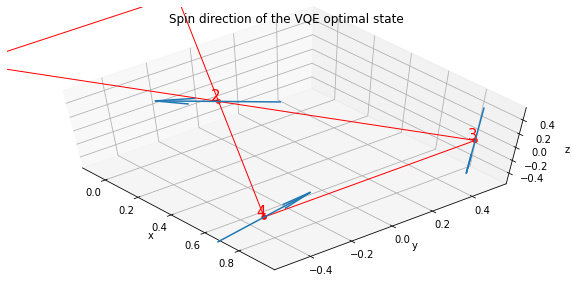

In [47]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
u=[]
v=[]
w=[]
print("Spin expected value")
for js,s in enumerate(spins_mat):
    val=np.dot(np.dot(np.conjugate(best_psi),s),best_psi)
    print("Spin ",spins[js][0]," ",np.round(np.real(val),3))
    if (js%3)==0:
        u.append(round(val,6))
    if (js%3)==1:
        v.append(round(val,6))
    if(js%3)==2:
        w.append(round(val,6))
            
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

ax.set_title("Spin direction of the VQE optimal state")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)
        
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-40)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.02,y[i]-0.02,z[i],i,color='red',size=15)
            
plt.show()

#### Spin-spin correlation functions of the VQE optimal state

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value on $|\psi_{opt}\rangle$. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [48]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))
spin_spin_mat=[]
for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

Spin-spin operators number: 75


Optimal VQE energy:  -5.999999999999979 ; Precision:  2.1316282072803006e-14
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (-3+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-0-0j)
     Spin-spin  0-4  (-0+0j)
     Spin-spin  1-0  (-3+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-0-0j)
     Spin-spin  1-4  (-0+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2.40337+0j)
     Spin-spin  2-3  (-0.290903+0j)
     Spin-spin  2-4  (-1.672865+0j)
     Spin-spin  3-0  (-0-0j)
     Spin-spin  3-1  (-0-0j)
     Spin-spin  3-2  (-0.290903+0j)
     Spin-spin  3-3  (2.601503-0j)
     Spin-spin  3-4  (-2.166103+0j)
     Spin-spin  4-0  (-0+0j)
     Spin-spin  4-1  (-0+0j)
     Spin-spin  4-2  (-1.672865+0j)
     Spin-spin  4-3  (-2.166103+0j)
     Spin-spin  4-4  (2.790639+0j)


<ipython-input-49-34a5c49d5070>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


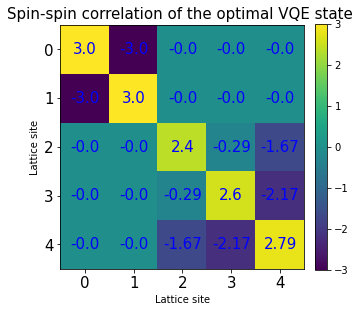

In [49]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
       
val=[]
for el in spins_mat:
    val.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
val2=[]
for el in spin_spin_mat:
    val2.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
        
ss=[0]*(nqubit*nqubit)
s=[0]*(nqubit*nqubit)
M=np.zeros((nqubit,nqubit))
    
n=0
p=0
for j in range(nqubit):
    for k in range(nqubit):
        sj=0
        sk=0
        for l in range(3):
            ss[p] += val2[n]
            sj+=val[3*j+l]**2
            sk+=val[3*k+l]**2
            n += 1
                
        s[p]=pow(sj,0.5)*pow(sk,0.5)
        M[j,k]=ss[p]-s[p]
        print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
        p+=     1

#Here we create a visual representation of the spin-spin correlation values
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(M)
    
ax.set_xticks(np.arange(nqubit))
ax.set_yticks(np.arange(nqubit))
ax.set_xticklabels(np.arange(nqubit), fontsize=15)
ax.set_yticklabels(np.arange(nqubit), fontsize=15)

ax.set_xlabel("Lattice site")
ax.set_ylabel("Lattice site")
        
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

for ii in range(nqubit):
    for jj in range(nqubit):
          text = ax.text(jj, ii, round(M[ii, jj],2), ha="center", va="center", color="b", fontsize=15)

ax.set_title("Spin-spin correlation of the optimal VQE state ", fontsize=15)
fig.tight_layout()
plt.show()

We can conclude that the results of the **so4** circuit are almost the same of the **RY** circuit.

## RotGate2 with $|\psi_5 \rangle$

We remind how this variational form is built and which state describes $|\psi_5\rangle$.

In [29]:
qr = QuantumRegister(nqubit,'q')                 #1 qubit register
qc = QuantumCircuit(qr)

th=Parameter("th")
ph=Parameter("ph")
ang=Parameter("ang")
qc.rz(ph,[0,1,3,4])
qc.rx(th,[0,1,3,4])
qc.rz(ang,np.arange(nqubit))
qc.rx(-th,[0,1,3,4])
qc.rz(-ph,[0,1,3,4])
print(qc.draw())
RotGate2=qc.to_gate(label="U")

      ┌────────┐┌────────┐┌─────────┐┌─────────────┐┌─────────────┐
q_0: ─┤ RZ(ph) ├┤ RX(th) ├┤ RZ(ang) ├┤ RX(-1.0*th) ├┤ RZ(-1.0*ph) ├
      ├────────┤├────────┤├─────────┤├─────────────┤├─────────────┤
q_1: ─┤ RZ(ph) ├┤ RX(th) ├┤ RZ(ang) ├┤ RX(-1.0*th) ├┤ RZ(-1.0*ph) ├
     ┌┴────────┤└────────┘└─────────┘└─────────────┘└─────────────┘
q_2: ┤ RZ(ang) ├───────────────────────────────────────────────────
     └┬────────┤┌────────┐┌─────────┐┌─────────────┐┌─────────────┐
q_3: ─┤ RZ(ph) ├┤ RX(th) ├┤ RZ(ang) ├┤ RX(-1.0*th) ├┤ RZ(-1.0*ph) ├
      ├────────┤├────────┤├─────────┤├─────────────┤├─────────────┤
q_4: ─┤ RZ(ph) ├┤ RX(th) ├┤ RZ(ang) ├┤ RX(-1.0*th) ├┤ RZ(-1.0*ph) ├
      └────────┘└────────┘└─────────┘└─────────────┘└─────────────┘


In [30]:
var_form  = TwoLocal(H.num_qubits,RotGate2,['cx'],nn_list,initial_state=psi_5,reps=1,skip_final_rotation_layer=True)
print("The custom variational form")
print(var_form.draw())
print("Number of parameters: ",var_form.num_parameters)

The custom variational form
global phase: 0
     ┌─────────────┐┌─────────────┐ ┌────┐                              
q_0: ┤ U(3π/4,0,0) ├┤ U(0,0,2π/3) ├─┤0   ├──■─────────■─────────────────
     ├─────────────┤├─────────────┤ │    │┌─┴─┐       │                 
q_1: ┤ U(3π/4,0,0) ├┤ U(0,0,4π/3) ├─┤1   ├┤ X ├──■────┼─────────────────
     ├─────────────┤└─────────────┘ │    │└───┘┌─┴─┐┌─┴─┐               
q_2: ┤ U(3π/4,0,0) ├────────────────┤2 U ├─────┤ X ├┤ X ├──■────■───────
     ├─────────────┤┌──────────────┐│    │     └───┘└───┘┌─┴─┐  │       
q_3: ┤ U(3π/4,0,0) ├┤ U(0,0,-2π/3) ├┤3   ├───────────────┤ X ├──┼────■──
     ├─────────────┤├──────────────┤│    │               └───┘┌─┴─┐┌─┴─┐
q_4: ┤ U(3π/4,0,0) ├┤ U(0,0,-4π/3) ├┤4   ├────────────────────┤ X ├┤ X ├
     └─────────────┘└──────────────┘└────┘                    └───┘└───┘
Number of parameters:  3


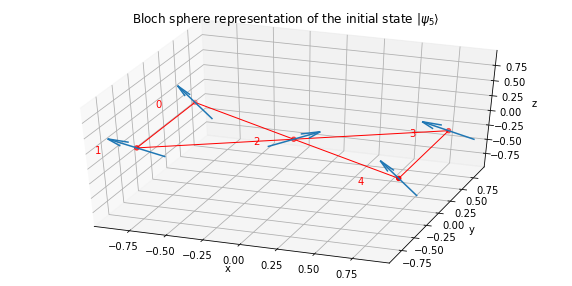

In [31]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]        

u=[-0.612,-0.612,0.707,-0.612,-0.612]
v=[0.354,-0.354,0,-0.354,0.354]
w=[0.707,0.707,0.707,0.707,0.707]

ax.set_title(r"Bloch sphere representation of the initial state $|\psi_5\rangle$")
ax.quiver(x,y,z,u,v,w,length=0.5, pivot='middle', normalize=True)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(40,-70)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.2,y[i]-0.2,z[i],i,color='red')
            
plt.show()

### Statistics of the RotGate2 circuit

We take $2000$ random parameter vectors to create the vector state $|\psi_k \rangle$ ($0 \le k < 2000$) associated with the corresponding variational form. By this way we can see how close they get to the ground state. Moreover, we can look at the statistics of energy and energy variance.

#### Histogram of $\langle \psi_k|\Pi_E|\psi_k \rangle$

We project the random vectors created using the **RotGate2** circuit on the subspaces created by the eigenvalues of $H$. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. By this way we can see the contribution of the eigenspaces to the variational state created. 

How well does a tensor product of single-qubit states describe the bow-tie?


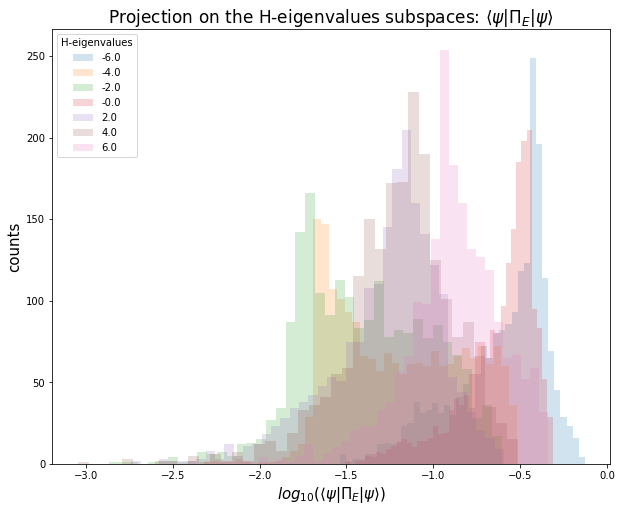

In [32]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

# Projection on H-eigenvalues subspaces
eps,Pi  = get_eigenpairs(H)
res = [[] for x in (eps)]
#res2=[[] for x in (eps)]

mat_H=H.to_matrix()

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #circ_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()     
    
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),Pi[i],psi_x))
        #PHP=np.dot(Pi[i],np.dot(mat_H,Pi[i]))
        #cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        #res2[i].append(cx2)

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on H-eigenvalues subspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for e,res_e in zip(eps,res):
    n,b,p = plt.hist(res_e,**kwargs,label=str(e))
plt.title(r'Projection on the H-eigenvalues subspaces: $\langle \psi|\Pi_{E}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{E}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title='H-eigenvalues')
plt.show()

#### Histogram of $\langle \psi_k|\Pi_{a,b}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{a,b} H \Pi_{a,b}|\psi_k \rangle}{\langle \psi_k|\Pi_{a,b}|\psi_k \rangle}$

We project the random vectors created using the **RotGate2** circuit on the common eigenspaces of $R_v$ and $R_h$. We call $\Pi_{a,b}$ the projection operator on the subspaces corresponding to eigenvalues $(-1)^a$ and $(-1)^b$ of $R_v$ and $R_h$, respectively. It is defined as:

$$\Pi_{a,b}=\frac{1+(-1)^a R_v}{2}\frac{1+(-1)^b R_h}{2}$$

How well does a tensor product of single-qubit states describe the bow-tie?


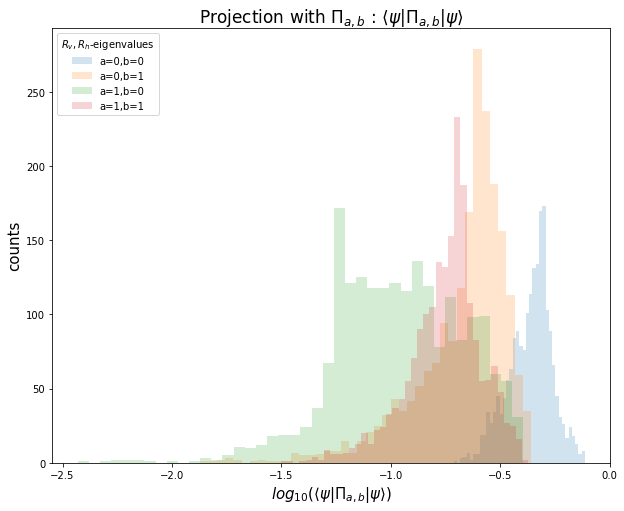

<Figure size 1800x1080 with 0 Axes>

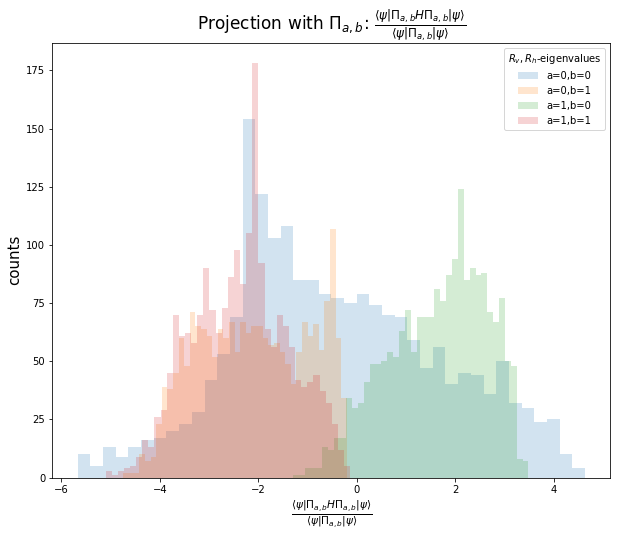

In [33]:
# Projection on \Pi_{a,b} eigenspaces
P_name=["a=0,b=0","a=0,b=1","a=1,b=0","a=1,b=1"]
P=get_Pab()
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #psi_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{a,b} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{a,b}$ : $\langle \psi|\Pi_{a,b}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{a,b}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{a,b}$: $\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{a,b} H \Pi_{a,b}|\psi \rangle}{\langle \psi|\Pi_{a,b}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$R_v,R_h$-eigenvalues')
plt.show()

As we expected the subspace corresponding to $a=1,b=0$ doesn't contribute to the ground state energy. 

#### Histogram of $\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle$ and $\frac{\langle \psi_k|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi_k \rangle}{\langle \psi_k|\Pi_{s,s_z}|\psi_k \rangle}$

We project the random vectors created using the **RotGate** circuit on the common eigenspaces of $S^2$ and $S_z$ because the ground state is split in the sectors $s=1,s_z=-1$ and $s=1,s_z=1$. We call $\Pi_{s,s_z}$ the projection operator on the subspaces corresponding to eigenvalues $s_z=1$ and $s_z=-1$ of $S_z$, respectively.  

How well does a tensor product of single-qubit states describe the bow-tie?


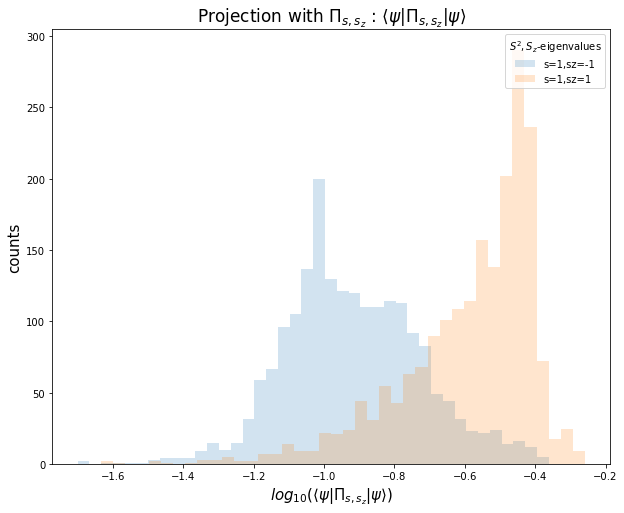

<Figure size 1800x1080 with 0 Axes>

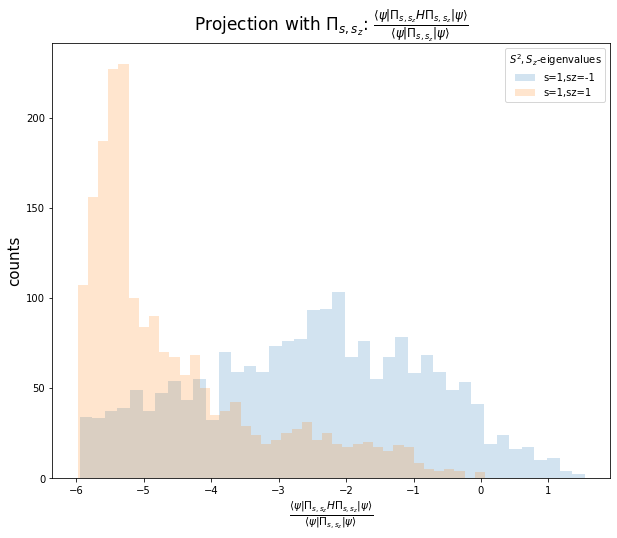

In [34]:
# Projection on \Pi_{s,sz} eigenspaces

P=get_Pspin()
P_name=["s=1,sz=-1","s=1,sz=1"]
P1=[p[1] for p in P]
P0=[p[0] for p in P]

res = [[] for i in range(len(P1))]
res2=[[] for i in range(len(P1))]

for ix in range(2000):
    px    = 2*np.pi*np.random.random(var_form.num_parameters)-np.pi
    #psi_x=var_form.construct_circuit(px)        # To use with so4
    circ_x=var_form.assign_parameters(px)        # To use with RealAmplitudes or TwoLocal
    psi_x=CircuitStateFn(circ_x).to_matrix()
    for i in range(len(res)): 
        cx=np.abs(np.einsum('i,ij,j',np.conj(psi_x),P1[i],psi_x))
        PHP=np.dot(P1[i],np.dot(mat_H,P1[i]))
        cx2=np.real(np.dot(np.conj(psi_x),np.dot(PHP,psi_x)))
        res[i].append(np.log10(cx))
        res2[i].append(cx2/cx)        # <psi|P H P|psi>/<psi|P|psi>

print("How well does a tensor product of single-qubit states describe the bow-tie?")
# Histogram of the projection on \Pi_{s,sz} eigenspaces
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res):
    n,b,p = plt.hist(res_e,**kwargs,label=name)

plt.title(r'Projection with $\Pi_{s,s_z}$ : $\langle \psi|\Pi_{s,s_z}|\psi \rangle$',fontsize=17)
plt.xlabel(r'$log_{10}(\langle \psi|\Pi_{s,s_z}|\psi \rangle)$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.figure(figsize=(25,15))
plt.show()

# Histogram of  <psi|P H P|psi>/<psi|P|psi>
plt.figure(figsize=(10,8))
kwargs = dict(bins=40,histtype='stepfilled',alpha=0.2,align='mid',density=False)

for name,res_e in zip(P_name,res2):
    n,b,p = plt.hist(res_e,**kwargs,label=name)
plt.title(r'Projection with $\Pi_{s,s_z}$: $\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=17)
plt.xlabel(r'$\frac{\langle \psi|\Pi_{s,s_z} H \Pi_{s,s_z}|\psi \rangle}{\langle \psi|\Pi_{s,s_z}|\psi \rangle}$',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.legend(title=r'$S^2,S_z$-eigenvalues')
plt.show()

The sector $s=1,s_z=1$ is the one which contributes more to the ground state energy.

### VQE - Projection-after-variation (PAV) with $\Pi_E$, $\Pi_{a,b}$  and $\Pi_{s,s_z}$

First we want to find the following expectation value:

$$E(\theta)=\langle \psi(\mathbf{\theta})|H|\psi(\mathbf{\theta}) \rangle$$

We make a cycle of $10$ iterations to find the minimum of $H$ through the VQE algorithm. We use the **RotGate** circuit with $n=3$ parameters. $|\psi(\mathbf{\theta})\rangle$, where $\mathbf{\theta}=(\theta_1,\theta_2, ..., \theta_n)^T$ is the vector of variational parameters, is the variational state which is optimized during the run of the algorithm.

In [35]:
emin = 10e4
best_psi = None
for i in range(10):
    algo             = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
    algo_result      = algo.run(quantum_instance_1)
    if(np.real(algo_result['eigenvalue'])<emin):
        emin = np.real(algo_result['eigenvalue'])
        best_psi = algo_result['eigenstate']


2020-12-18 17:21:23,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd24941a940>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd24941a820>>
-- initial_point: [-0.54873402 -0.73224576 -1.38931647]
-- var_form: global phase: 0
     ┌──────────────────┐ ┌──────────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤ U3(3π/4,0.0,0.0) ├─┤ U3(0,0,2π/3) ├┤ RZ(θ[2]) ├┤ RX(θ[1]) ├┤ RZ(θ[0]) ├»
  

2020-12-18 17:21:23,629:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.55293 (ms)
2020-12-18 17:21:24,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.22583703] - 536.14068 (ms), eval count: 1
2020-12-18 17:21:24,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48098 (ms)
2020-12-18 17:21:24,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.22583703] - 12.69197 (ms), eval count: 2
2020-12-18 17:21:24,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.54998 (ms)
2020-12-18 17:21:24,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.22583702] - 11.16705 (ms), eval count: 3
2020-12-18 17:21:24,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09920 (ms)
2020-12-18 17:21:24,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:21:24,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37083 (ms)
2020-12-18 17:21:24,567:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.85184661] - 8.09813 (ms), eval count: 32
2020-12-18 17:21:24,571:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64001 (ms)
2020-12-18 17:21:24,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.58175774] - 7.61890 (ms), eval count: 33
2020-12-18 17:21:24,580:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18225 (ms)
2020-12-18 17:21:24,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.58175774] - 6.69003 (ms), eval count: 34
2020-12-18 17:21:24,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06606 (ms)
2020-12-18 17:21:24,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:21:24,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21596 (ms)
2020-12-18 17:21:24,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.79697185] - 8.97717 (ms), eval count: 63
2020-12-18 17:21:24,944:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21293 (ms)
2020-12-18 17:21:24,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.79697183] - 9.46116 (ms), eval count: 64
2020-12-18 17:21:24,956:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68786 (ms)
2020-12-18 17:21:24,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.8165395] - 8.69703 (ms), eval count: 65
2020-12-18 17:21:24,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75111 (ms)
2020-12-18 17:21:24,971:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2020-12-18 17:21:25,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55799 (ms)
2020-12-18 17:21:25,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.61185219] - 8.63695 (ms), eval count: 94
2020-12-18 17:21:25,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73585 (ms)
2020-12-18 17:21:25,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.6118521] - 12.23183 (ms), eval count: 95
2020-12-18 17:21:25,427:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26793 (ms)
2020-12-18 17:21:25,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.61185217] - 15.88798 (ms), eval count: 96
2020-12-18 17:21:25,455:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85706 (ms)
2020-12-18 17:21:25,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:21:25,832:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72989 (ms)
2020-12-18 17:21:25,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55059352] - 10.82015 (ms), eval count: 125
2020-12-18 17:21:25,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74126 (ms)
2020-12-18 17:21:25,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55059351] - 10.45704 (ms), eval count: 126
2020-12-18 17:21:25,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18885 (ms)
2020-12-18 17:21:25,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55059351] - 10.79702 (ms), eval count: 127
2020-12-18 17:21:25,873:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14801 (ms)
2020-12-18 17:21:25,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:21:26,380:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.69903 (ms)
2020-12-18 17:21:26,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56348719] - 22.38107 (ms), eval count: 156
2020-12-18 17:21:26,404:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.25183 (ms)
2020-12-18 17:21:26,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349078] - 19.77992 (ms), eval count: 157
2020-12-18 17:21:26,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94273 (ms)
2020-12-18 17:21:26,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349078] - 23.08893 (ms), eval count: 158
2020-12-18 17:21:26,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31194 (ms)
2020-12-18 17:21:26,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:21:26,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80285 (ms)
2020-12-18 17:21:26,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5634966] - 7.68995 (ms), eval count: 187
2020-12-18 17:21:26,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87414 (ms)
2020-12-18 17:21:26,967:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5634966] - 7.59673 (ms), eval count: 188
2020-12-18 17:21:26,974:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.98517 (ms)
2020-12-18 17:21:26,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349677] - 11.24978 (ms), eval count: 189
2020-12-18 17:21:26,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.24697 (ms)
2020-12-18 17:21:27,000:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:27,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21610 (ms)
2020-12-18 17:21:27,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.04815 (ms), eval count: 218
2020-12-18 17:21:27,454:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.61912 (ms)
2020-12-18 17:21:27,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 12.98618 (ms), eval count: 219
2020-12-18 17:21:27,469:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44188 (ms)
2020-12-18 17:21:27,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.14192 (ms), eval count: 220
2020-12-18 17:21:27,489:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81692 (ms)
2020-12-18 17:21:27,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:28,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73418 (ms)
2020-12-18 17:21:28,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.06794 (ms), eval count: 249
2020-12-18 17:21:28,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71893 (ms)
2020-12-18 17:21:28,055:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.65516 (ms), eval count: 250
2020-12-18 17:21:28,061:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66790 (ms)
2020-12-18 17:21:28,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 12.51101 (ms), eval count: 251
2020-12-18 17:21:28,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.66006 (ms)
2020-12-18 17:21:28,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:21:28,362:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[ 1.69177934  3.09837722 -2.08696132]
2020-12-18 17:21:28,414:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:28,428:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:28,438:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:28,457:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:28,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 16.56818 (ms)
2020-12-18 17:21:28,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe

2020-12-18 17:21:28,879:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.17201 (ms)
2020-12-18 17:21:28,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84106367] - 15.87510 (ms), eval count: 28
2020-12-18 17:21:28,900:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.68111 (ms)
2020-12-18 17:21:28,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.30707539] - 12.86507 (ms), eval count: 29
2020-12-18 17:21:28,915:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89099 (ms)
2020-12-18 17:21:28,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.30707541] - 10.79607 (ms), eval count: 30
2020-12-18 17:21:28,930:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.24020 (ms)
2020-12-18 17:21:28,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:29,455:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30703 (ms)
2020-12-18 17:21:29,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54058933] - 9.83810 (ms), eval count: 59
2020-12-18 17:21:29,468:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.61380 (ms)
2020-12-18 17:21:29,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54058932] - 10.61606 (ms), eval count: 60
2020-12-18 17:21:29,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.98121 (ms)
2020-12-18 17:21:29,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.19110134] - 12.87079 (ms), eval count: 61
2020-12-18 17:21:29,492:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18010 (ms)
2020-12-18 17:21:29,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:29,786:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91498 (ms)
2020-12-18 17:21:29,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58124723] - 8.95596 (ms), eval count: 90
2020-12-18 17:21:29,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23200 (ms)
2020-12-18 17:21:29,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58124723] - 10.43081 (ms), eval count: 91
2020-12-18 17:21:29,812:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92818 (ms)
2020-12-18 17:21:29,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58124723] - 12.19511 (ms), eval count: 92
2020-12-18 17:21:29,827:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55594 (ms)
2020-12-18 17:21:29,834:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:30,186:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77495 (ms)
2020-12-18 17:21:30,195:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.01422 (ms), eval count: 121
2020-12-18 17:21:30,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16699 (ms)
2020-12-18 17:21:30,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.27806 (ms), eval count: 122
2020-12-18 17:21:30,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.23210 (ms)
2020-12-18 17:21:30,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 13.35812 (ms), eval count: 123
2020-12-18 17:21:30,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.72760 (ms)
2020-12-18 17:21:30,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:30,720:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.04996 (ms)
2020-12-18 17:21:30,738:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 26.21388 (ms), eval count: 152
2020-12-18 17:21:30,750:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.47108 (ms)
2020-12-18 17:21:30,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 27.83418 (ms), eval count: 153
2020-12-18 17:21:30,776:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88527 (ms)
2020-12-18 17:21:30,801:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 29.25730 (ms), eval count: 154
2020-12-18 17:21:30,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56014 (ms)
2020-12-18 17:21:30,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:21:31,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45016 (ms)
2020-12-18 17:21:31,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.97138 (ms), eval count: 183
2020-12-18 17:21:31,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51698 (ms)
2020-12-18 17:21:31,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.96788 (ms), eval count: 184
2020-12-18 17:21:31,297:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91896 (ms)
2020-12-18 17:21:31,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.30102 (ms), eval count: 185
2020-12-18 17:21:31,307:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83074 (ms)
2020-12-18 17:21:31,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:31,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23613 (ms)
2020-12-18 17:21:31,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.96700 (ms), eval count: 214
2020-12-18 17:21:31,623:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09999 (ms)
2020-12-18 17:21:31,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.91097 (ms), eval count: 215
2020-12-18 17:21:31,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80619 (ms)
2020-12-18 17:21:31,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.49707 (ms), eval count: 216
2020-12-18 17:21:31,641:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44999 (ms)
2020-12-18 17:21:31,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:31,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50292 (ms)
2020-12-18 17:21:31,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.56001 (ms), eval count: 245
2020-12-18 17:21:31,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26402 (ms)
2020-12-18 17:21:31,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.79080 (ms), eval count: 246
2020-12-18 17:21:31,970:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39825 (ms)
2020-12-18 17:21:31,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.14421 (ms), eval count: 247
2020-12-18 17:21:31,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33793 (ms)
2020-12-18 17:21:31,982:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:32,297:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41105 (ms)
2020-12-18 17:21:32,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.58419 (ms), eval count: 276
2020-12-18 17:21:32,308:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79498 (ms)
2020-12-18 17:21:32,313:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.02732 (ms), eval count: 277
2020-12-18 17:21:32,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 3.952887773513794 seconds.
Found opt_params [ 4.08249763  2.53411784 -1.88368278] in 277 evals
2020-12-18 17:21:32,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- inc

2020-12-18 17:21:32,378:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:32,385:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:32,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.56590 (ms)
2020-12-18 17:21:32,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46635514] - 38.33199 (ms), eval count: 1
2020-12-18 17:21:32,410:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76184 (ms)
2020-12-18 17:21:32,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46635513] - 7.80630 (ms), eval count: 2
2020-12-18 17:21:32,418:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42996 (ms)
2020-12-18 17:21:32,423:qiskit.aqua.algorit

2020-12-18 17:21:32,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.4316895] - 5.69606 (ms), eval count: 30
2020-12-18 17:21:32,720:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38585 (ms)
2020-12-18 17:21:32,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.4316895] - 16.44516 (ms), eval count: 31
2020-12-18 17:21:32,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33207 (ms)
2020-12-18 17:21:32,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.43168948] - 11.24096 (ms), eval count: 32
2020-12-18 17:21:32,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09603 (ms)
2020-12-18 17:21:32,767:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.52809511] - 12.35271 (ms), eval count: 33
2020-12-18 17:21:32,772:qiskit.aqua.operators.convert

2020-12-18 17:21:33,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18987097] - 9.63616 (ms), eval count: 61
2020-12-18 17:21:33,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70724 (ms)
2020-12-18 17:21:33,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18987099] - 8.68201 (ms), eval count: 62
2020-12-18 17:21:33,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2020-12-18 17:21:33,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18987094] - 9.38082 (ms), eval count: 63
2020-12-18 17:21:33,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57707 (ms)
2020-12-18 17:21:33,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18987096] - 6.81400 (ms), eval count: 64
2020-12-18 17:21:33,121:qiskit.aqua.operators.converte

2020-12-18 17:21:33,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.57336209] - 8.78310 (ms), eval count: 92
2020-12-18 17:21:33,447:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37291 (ms)
2020-12-18 17:21:33,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5733621] - 8.64220 (ms), eval count: 93
2020-12-18 17:21:33,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73514 (ms)
2020-12-18 17:21:33,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.57336209] - 8.12602 (ms), eval count: 94
2020-12-18 17:21:33,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60401 (ms)
2020-12-18 17:21:33,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58114811] - 8.22973 (ms), eval count: 95
2020-12-18 17:21:33,477:qiskit.aqua.operators.converter

2020-12-18 17:21:33,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154732] - 7.28703 (ms), eval count: 123
2020-12-18 17:21:33,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.59805 (ms)
2020-12-18 17:21:33,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154732] - 7.48706 (ms), eval count: 124
2020-12-18 17:21:33,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06582 (ms)
2020-12-18 17:21:33,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154732] - 8.21090 (ms), eval count: 125
2020-12-18 17:21:33,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12614 (ms)
2020-12-18 17:21:33,807:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154732] - 9.06706 (ms), eval count: 126
2020-12-18 17:21:33,811:qiskit.aqua.operators.conv

2020-12-18 17:21:34,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.08909 (ms), eval count: 154
2020-12-18 17:21:34,166:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82097 (ms)
2020-12-18 17:21:34,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 12.63189 (ms), eval count: 155
2020-12-18 17:21:34,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22898 (ms)
2020-12-18 17:21:34,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.18674 (ms), eval count: 156
2020-12-18 17:21:34,195:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68221 (ms)
2020-12-18 17:21:34,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.67994 (ms), eval count: 157
2020-12-18 17:21:34,207:qiskit.aqua.operators.co

2020-12-18 17:21:34,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.71403 (ms), eval count: 185
2020-12-18 17:21:34,518:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18201 (ms)
2020-12-18 17:21:34,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.45082 (ms), eval count: 186
2020-12-18 17:21:34,527:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64812 (ms)
2020-12-18 17:21:34,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.33106 (ms), eval count: 187
2020-12-18 17:21:34,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13099 (ms)
2020-12-18 17:21:34,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.65896 (ms), eval count: 188
2020-12-18 17:21:34,545:qiskit.aqua.operators.conv

2020-12-18 17:21:34,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.79915 (ms), eval count: 216
2020-12-18 17:21:34,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36893 (ms)
2020-12-18 17:21:34,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.87187 (ms), eval count: 217
2020-12-18 17:21:34,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.59924 (ms)
2020-12-18 17:21:34,894:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.42602 (ms), eval count: 218
2020-12-18 17:21:34,899:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80325 (ms)
2020-12-18 17:21:34,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.43287 (ms), eval count: 219
2020-12-18 17:21:34,908:qiskit.aqua.operators.conv

2020-12-18 17:21:35,261:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 25.09689 (ms), eval count: 247
2020-12-18 17:21:35,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03276 (ms)
2020-12-18 17:21:35,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.59602 (ms), eval count: 248
2020-12-18 17:21:35,277:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46882 (ms)
2020-12-18 17:21:35,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.91511 (ms), eval count: 249
2020-12-18 17:21:35,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31624 (ms)
2020-12-18 17:21:35,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.90105 (ms), eval count: 250
2020-12-18 17:21:35,300:qiskit.aqua.operators.con

2020-12-18 17:21:35,796:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.40004 (ms), eval count: 278
2020-12-18 17:21:35,801:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91092 (ms)
2020-12-18 17:21:35,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 12.54010 (ms), eval count: 279
2020-12-18 17:21:35,831:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00701 (ms)
2020-12-18 17:21:35,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.74982 (ms), eval count: 280
2020-12-18 17:21:35,843:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94287 (ms)
2020-12-18 17:21:35,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.11498 (ms), eval count: 281
2020-12-18 17:21:35,854:qiskit.aqua.operators.co

2020-12-18 17:21:36,165:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.35817 (ms), eval count: 309
2020-12-18 17:21:36,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 3.8144569396972656 seconds.
Found opt_params [-2.20068769  2.53411785 -1.88368277] in 309 evals
2020-12-18 17:21:36,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd2488050d0>
-- gradient: None
-- cost_fn: <bound method VQ

2020-12-18 17:21:36,225:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:36,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.28700 (ms)
2020-12-18 17:21:36,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.3568847] - 22.03703 (ms), eval count: 1
2020-12-18 17:21:36,241:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38609 (ms)
2020-12-18 17:21:36,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35688472] - 9.00507 (ms), eval count: 2
2020-12-18 17:21:36,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15816 (ms)
2020-12-18 17:21:36,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.35688464] - 7.09414 (ms),

2020-12-18 17:21:36,749:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05319 (ms)
2020-12-18 17:21:36,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.64154326] - 10.90407 (ms), eval count: 31
2020-12-18 17:21:36,765:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.32198 (ms)
2020-12-18 17:21:36,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.64154323] - 20.66803 (ms), eval count: 32
2020-12-18 17:21:36,848:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 28.05877 (ms)
2020-12-18 17:21:36,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.30513305] - 56.02169 (ms), eval count: 33
2020-12-18 17:21:36,900:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 16.13164 (ms)
2020-12-18 17:21:36,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:37,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.28677 (ms)
2020-12-18 17:21:37,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.50182356] - 13.67188 (ms), eval count: 62
2020-12-18 17:21:37,359:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10628 (ms)
2020-12-18 17:21:37,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.50182356] - 12.69889 (ms), eval count: 63
2020-12-18 17:21:37,378:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.93891 (ms)
2020-12-18 17:21:37,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.50182356] - 19.53006 (ms), eval count: 64
2020-12-18 17:21:37,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.99196 (ms)
2020-12-18 17:21:37,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:37,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.24497 (ms)
2020-12-18 17:21:37,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154699] - 12.15601 (ms), eval count: 93
2020-12-18 17:21:37,862:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49720 (ms)
2020-12-18 17:21:37,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154699] - 7.22408 (ms), eval count: 94
2020-12-18 17:21:37,871:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81215 (ms)
2020-12-18 17:21:37,876:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154699] - 8.10504 (ms), eval count: 95
2020-12-18 17:21:37,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79999 (ms)
2020-12-18 17:21:37,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:21:38,299:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.74801 (ms)
2020-12-18 17:21:38,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.52895 (ms), eval count: 124
2020-12-18 17:21:38,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37720 (ms)
2020-12-18 17:21:38,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.21495 (ms), eval count: 125
2020-12-18 17:21:38,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65813 (ms)
2020-12-18 17:21:38,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.45797 (ms), eval count: 126
2020-12-18 17:21:38,327:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36011 (ms)
2020-12-18 17:21:38,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:38,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28016 (ms)
2020-12-18 17:21:38,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.29005 (ms), eval count: 155
2020-12-18 17:21:38,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93803 (ms)
2020-12-18 17:21:38,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.45177 (ms), eval count: 156
2020-12-18 17:21:38,694:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89798 (ms)
2020-12-18 17:21:38,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.25198 (ms), eval count: 157
2020-12-18 17:21:38,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38013 (ms)
2020-12-18 17:21:38,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:38,976:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92285 (ms)
2020-12-18 17:21:38,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.43914 (ms), eval count: 186
2020-12-18 17:21:38,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.81703 (ms)
2020-12-18 17:21:39,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 25.87795 (ms), eval count: 187
2020-12-18 17:21:39,027:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45397 (ms)
2020-12-18 17:21:39,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.48310 (ms), eval count: 188
2020-12-18 17:21:39,043:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12488 (ms)
2020-12-18 17:21:39,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:39,396:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[-0.79818955  2.81896834  1.06164692]
2020-12-18 17:21:39,443:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:39,444:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:39,449:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:39,452:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:39,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.32884 (ms)
2020-12-18 17:21:39,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:40,025:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.62096 (ms)
2020-12-18 17:21:40,041:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.04735079] - 21.70372 (ms), eval count: 28
2020-12-18 17:21:40,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.46298 (ms)
2020-12-18 17:21:40,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.51985023] - 29.88625 (ms), eval count: 29
2020-12-18 17:21:40,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.12001 (ms)
2020-12-18 17:21:40,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.51985023] - 23.46492 (ms), eval count: 30
2020-12-18 17:21:40,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.29489 (ms)
2020-12-18 17:21:40,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:40,661:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49004 (ms)
2020-12-18 17:21:40,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58069229] - 10.99706 (ms), eval count: 59
2020-12-18 17:21:40,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21929 (ms)
2020-12-18 17:21:40,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58069229] - 11.91282 (ms), eval count: 60
2020-12-18 17:21:40,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59392 (ms)
2020-12-18 17:21:40,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56319629] - 12.34412 (ms), eval count: 61
2020-12-18 17:21:40,706:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07210 (ms)
2020-12-18 17:21:40,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:41,083:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.43818 (ms)
2020-12-18 17:21:41,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154736] - 16.08777 (ms), eval count: 90
2020-12-18 17:21:41,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.35011 (ms)
2020-12-18 17:21:41,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154736] - 12.38418 (ms), eval count: 91
2020-12-18 17:21:41,116:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.18904 (ms)
2020-12-18 17:21:41,125:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154736] - 16.51096 (ms), eval count: 92
2020-12-18 17:21:41,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.83305 (ms)
2020-12-18 17:21:41,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:41,867:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.24092 (ms)
2020-12-18 17:21:41,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 17.95387 (ms), eval count: 121
2020-12-18 17:21:41,889:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.53505 (ms)
2020-12-18 17:21:41,899:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 16.97516 (ms), eval count: 122
2020-12-18 17:21:41,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.83722 (ms)
2020-12-18 17:21:41,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 20.15591 (ms), eval count: 123
2020-12-18 17:21:41,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50611 (ms)
2020-12-18 17:21:41,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:21:42,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62976 (ms)
2020-12-18 17:21:42,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.77619 (ms), eval count: 152
2020-12-18 17:21:42,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60513 (ms)
2020-12-18 17:21:42,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.10306 (ms), eval count: 153
2020-12-18 17:21:42,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72894 (ms)
2020-12-18 17:21:42,339:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.86304 (ms), eval count: 154
2020-12-18 17:21:42,343:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77090 (ms)
2020-12-18 17:21:42,350:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:42,664:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[-1.91397672  2.04278641 -0.00339172]
2020-12-18 17:21:42,686:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:42,687:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:42,688:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:42,689:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:42,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.51107 (ms)
2020-12-18 17:21:42,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:43,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09205 (ms)
2020-12-18 17:21:43,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.27452891] - 9.17506 (ms), eval count: 28
2020-12-18 17:21:43,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85809 (ms)
2020-12-18 17:21:43,066:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36587526] - 11.20806 (ms), eval count: 29
2020-12-18 17:21:43,071:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70414 (ms)
2020-12-18 17:21:43,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.36587527] - 8.39400 (ms), eval count: 30
2020-12-18 17:21:43,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.56190 (ms)
2020-12-18 17:21:43,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:21:43,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65789 (ms)
2020-12-18 17:21:43,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.57745566] - 9.26208 (ms), eval count: 59
2020-12-18 17:21:43,751:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.78315 (ms)
2020-12-18 17:21:43,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.57745565] - 18.94808 (ms), eval count: 60
2020-12-18 17:21:43,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99399 (ms)
2020-12-18 17:21:43,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58133076] - 12.95304 (ms), eval count: 61
2020-12-18 17:21:43,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01099 (ms)
2020-12-18 17:21:43,799:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:44,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72012 (ms)
2020-12-18 17:21:44,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.52721 (ms), eval count: 90
2020-12-18 17:21:44,157:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92301 (ms)
2020-12-18 17:21:44,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.94787 (ms), eval count: 91
2020-12-18 17:21:44,172:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14801 (ms)
2020-12-18 17:21:44,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.30278 (ms), eval count: 92
2020-12-18 17:21:44,183:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61323 (ms)
2020-12-18 17:21:44,189:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:44,656:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23510 (ms)
2020-12-18 17:21:44,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.40673 (ms), eval count: 121
2020-12-18 17:21:44,667:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22206 (ms)
2020-12-18 17:21:44,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.20596 (ms), eval count: 122
2020-12-18 17:21:44,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43688 (ms)
2020-12-18 17:21:44,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.73191 (ms), eval count: 123
2020-12-18 17:21:44,687:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82280 (ms)
2020-12-18 17:21:44,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:45,237:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.00331 (ms)
2020-12-18 17:21:45,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 20.73216 (ms), eval count: 152
2020-12-18 17:21:45,268:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.17213 (ms)
2020-12-18 17:21:45,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 21.19398 (ms), eval count: 153
2020-12-18 17:21:45,292:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.18093 (ms)
2020-12-18 17:21:45,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 18.08381 (ms), eval count: 154
2020-12-18 17:21:45,320:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.54883 (ms)
2020-12-18 17:21:45,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:21:45,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.39494 (ms)
2020-12-18 17:21:45,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 30.74908 (ms), eval count: 183
2020-12-18 17:21:45,774:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40700 (ms)
2020-12-18 17:21:45,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.33497 (ms), eval count: 184
2020-12-18 17:21:45,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.22606 (ms)
2020-12-18 17:21:45,799:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 13.91482 (ms), eval count: 185
2020-12-18 17:21:45,805:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58987 (ms)
2020-12-18 17:21:45,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:21:46,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31194 (ms)
2020-12-18 17:21:46,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.99894 (ms), eval count: 214
2020-12-18 17:21:46,287:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93477 (ms)
2020-12-18 17:21:46,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.37071 (ms), eval count: 215
2020-12-18 17:21:46,295:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06614 (ms)
2020-12-18 17:21:46,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.17521 (ms), eval count: 216
2020-12-18 17:21:46,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68602 (ms)
2020-12-18 17:21:46,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:46,854:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72791 (ms)
2020-12-18 17:21:46,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.84008 (ms), eval count: 245
2020-12-18 17:21:46,864:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26014 (ms)
2020-12-18 17:21:46,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.31478 (ms), eval count: 246
2020-12-18 17:21:46,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43895 (ms)
2020-12-18 17:21:46,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.60994 (ms), eval count: 247
2020-12-18 17:21:46,888:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.16987 (ms)
2020-12-18 17:21:46,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:46,949:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[-2.85094986 -1.46266183  1.4096895 ]
2020-12-18 17:21:46,976:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:46,979:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:46,981:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:46,990:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:46,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.24125 (ms)
2020-12-18 17:21:47,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:47,488:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71416 (ms)
2020-12-18 17:21:47,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.41230304] - 7.49803 (ms), eval count: 28
2020-12-18 17:21:47,499:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66116 (ms)
2020-12-18 17:21:47,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19446872] - 8.78787 (ms), eval count: 29
2020-12-18 17:21:47,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30217 (ms)
2020-12-18 17:21:47,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19446869] - 8.72898 (ms), eval count: 30
2020-12-18 17:21:47,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.87907 (ms)
2020-12-18 17:21:47,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:21:47,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75397 (ms)
2020-12-18 17:21:47,899:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349319] - 7.77984 (ms), eval count: 59
2020-12-18 17:21:47,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49076 (ms)
2020-12-18 17:21:47,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349319] - 7.73096 (ms), eval count: 60
2020-12-18 17:21:47,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40111 (ms)
2020-12-18 17:21:47,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56346682] - 9.42588 (ms), eval count: 61
2020-12-18 17:21:47,925:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90322 (ms)
2020-12-18 17:21:47,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:21:48,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.09724 (ms)
2020-12-18 17:21:48,266:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 14.22906 (ms), eval count: 90
2020-12-18 17:21:48,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.27518 (ms)
2020-12-18 17:21:48,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.22508 (ms), eval count: 91
2020-12-18 17:21:48,297:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.01594 (ms)
2020-12-18 17:21:48,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 15.58805 (ms), eval count: 92
2020-12-18 17:21:48,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.77388 (ms)
2020-12-18 17:21:48,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:48,761:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34024 (ms)
2020-12-18 17:21:48,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.00490 (ms), eval count: 121
2020-12-18 17:21:48,770:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44498 (ms)
2020-12-18 17:21:48,776:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.04925 (ms), eval count: 122
2020-12-18 17:21:48,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03316 (ms)
2020-12-18 17:21:48,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.70378 (ms), eval count: 123
2020-12-18 17:21:48,790:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91014 (ms)
2020-12-18 17:21:48,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:49,128:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68094 (ms)
2020-12-18 17:21:49,144:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 19.71412 (ms), eval count: 152
2020-12-18 17:21:49,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85594 (ms)
2020-12-18 17:21:49,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.11684 (ms), eval count: 153
2020-12-18 17:21:49,167:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51603 (ms)
2020-12-18 17:21:49,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.93910 (ms), eval count: 154
2020-12-18 17:21:49,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65098 (ms)
2020-12-18 17:21:49,194:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:49,547:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21412 (ms)
2020-12-18 17:21:49,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.42898 (ms), eval count: 183
2020-12-18 17:21:49,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20697 (ms)
2020-12-18 17:21:49,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.84683 (ms), eval count: 184
2020-12-18 17:21:49,569:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70104 (ms)
2020-12-18 17:21:49,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.65634 (ms), eval count: 185
2020-12-18 17:21:49,579:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.97308 (ms)
2020-12-18 17:21:49,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:49,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64812 (ms)
2020-12-18 17:21:49,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.05602 (ms), eval count: 214
2020-12-18 17:21:49,908:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47710 (ms)
2020-12-18 17:21:49,918:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.47518 (ms), eval count: 215
2020-12-18 17:21:49,934:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95401 (ms)
2020-12-18 17:21:49,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.74121 (ms), eval count: 216
2020-12-18 17:21:49,947:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.48394 (ms)
2020-12-18 17:21:49,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:50,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89106 (ms)
2020-12-18 17:21:50,273:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.68630 (ms), eval count: 245
2020-12-18 17:21:50,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81906 (ms)
2020-12-18 17:21:50,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.98583 (ms), eval count: 246
2020-12-18 17:21:50,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19011 (ms)
2020-12-18 17:21:50,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.72803 (ms), eval count: 247
2020-12-18 17:21:50,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.93009 (ms)
2020-12-18 17:21:50,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:50,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19386 (ms)
2020-12-18 17:21:50,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.04520 (ms), eval count: 276
2020-12-18 17:21:50,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08282 (ms)
2020-12-18 17:21:50,681:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.18508 (ms), eval count: 277
2020-12-18 17:21:50,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08378 (ms)
2020-12-18 17:21:50,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 6.58369 (ms), eval count: 278
2020-12-18 17:21:50,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76995 (ms)
2020-12-18 17:21:50,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:51,061:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13480 (ms)
2020-12-18 17:21:51,066:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.40981 (ms), eval count: 307
2020-12-18 17:21:51,071:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14593 (ms)
2020-12-18 17:21:51,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 18.80336 (ms), eval count: 308
2020-12-18 17:21:51,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02012 (ms)
2020-12-18 17:21:51,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.60500 (ms), eval count: 309
2020-12-18 17:21:51,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85704 (ms)
2020-12-18 17:21:51,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:51,437:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60401 (ms)
2020-12-18 17:21:51,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.81267 (ms), eval count: 338
2020-12-18 17:21:51,447:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75183 (ms)
2020-12-18 17:21:51,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.32112 (ms), eval count: 339
2020-12-18 17:21:51,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24106 (ms)
2020-12-18 17:21:51,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.16083 (ms), eval count: 340
2020-12-18 17:21:51,466:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28016 (ms)
2020-12-18 17:21:51,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:51,594:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[ 1.29618474 -0.6234365  -2.25955406]
2020-12-18 17:21:51,623:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:51,624:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:51,625:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:51,626:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:51,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.36084 (ms)
2020-12-18 17:21:51,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:51,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29883 (ms)
2020-12-18 17:21:51,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.54035306] - 12.55608 (ms), eval count: 28
2020-12-18 17:21:51,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.03492 (ms)
2020-12-18 17:21:51,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55992539] - 14.10007 (ms), eval count: 29
2020-12-18 17:21:51,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29406 (ms)
2020-12-18 17:21:51,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55992539] - 9.41896 (ms), eval count: 30
2020-12-18 17:21:51,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80397 (ms)
2020-12-18 17:21:51,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:52,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.29511 (ms)
2020-12-18 17:21:52,320:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349548] - 13.52501 (ms), eval count: 59
2020-12-18 17:21:52,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17199 (ms)
2020-12-18 17:21:52,331:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349548] - 9.09090 (ms), eval count: 60
2020-12-18 17:21:52,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70915 (ms)
2020-12-18 17:21:52,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349677] - 10.20598 (ms), eval count: 61
2020-12-18 17:21:52,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07615 (ms)
2020-12-18 17:21:52,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:52,691:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89519 (ms)
2020-12-18 17:21:52,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 6.90508 (ms), eval count: 90
2020-12-18 17:21:52,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26078 (ms)
2020-12-18 17:21:52,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 20.01595 (ms), eval count: 91
2020-12-18 17:21:52,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.70304 (ms)
2020-12-18 17:21:52,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.65390 (ms), eval count: 92
2020-12-18 17:21:52,743:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.77402 (ms)
2020-12-18 17:21:52,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:53,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64025 (ms)
2020-12-18 17:21:53,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.21717 (ms), eval count: 121
2020-12-18 17:21:53,066:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23398 (ms)
2020-12-18 17:21:53,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.47197 (ms), eval count: 122
2020-12-18 17:21:53,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22015 (ms)
2020-12-18 17:21:53,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.28099 (ms), eval count: 123
2020-12-18 17:21:53,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58891 (ms)
2020-12-18 17:21:53,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:53,401:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06614 (ms)
2020-12-18 17:21:53,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.61914 (ms), eval count: 152
2020-12-18 17:21:53,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88391 (ms)
2020-12-18 17:21:53,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.66604 (ms), eval count: 153
2020-12-18 17:21:53,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.85204 (ms)
2020-12-18 17:21:53,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.87108 (ms), eval count: 154
2020-12-18 17:21:53,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43807 (ms)
2020-12-18 17:21:53,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:53,778:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45278 (ms)
2020-12-18 17:21:53,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.96384 (ms), eval count: 183
2020-12-18 17:21:53,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51603 (ms)
2020-12-18 17:21:53,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.78882 (ms), eval count: 184
2020-12-18 17:21:53,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.97110 (ms)
2020-12-18 17:21:53,810:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.03909 (ms), eval count: 185
2020-12-18 17:21:53,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65121 (ms)
2020-12-18 17:21:53,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:54,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58780 (ms)
2020-12-18 17:21:54,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.69393 (ms), eval count: 214
2020-12-18 17:21:54,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06296 (ms)
2020-12-18 17:21:54,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.90620 (ms), eval count: 215
2020-12-18 17:21:54,148:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68197 (ms)
2020-12-18 17:21:54,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.13222 (ms), eval count: 216
2020-12-18 17:21:54,157:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89495 (ms)
2020-12-18 17:21:54,164:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:54,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.79331 (ms)
2020-12-18 17:21:54,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.59094 (ms), eval count: 245
2020-12-18 17:21:54,476:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24202 (ms)
2020-12-18 17:21:54,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 22.65310 (ms), eval count: 246
2020-12-18 17:21:54,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75421 (ms)
2020-12-18 17:21:54,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 38.53202 (ms), eval count: 247
2020-12-18 17:21:54,562:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69485 (ms)
2020-12-18 17:21:54,567:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:54,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68006 (ms)
2020-12-18 17:21:54,900:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.57289 (ms), eval count: 276
2020-12-18 17:21:54,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15793 (ms)
2020-12-18 17:21:54,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 6.90103 (ms), eval count: 277
2020-12-18 17:21:54,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47812 (ms)
2020-12-18 17:21:54,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 6.13976 (ms), eval count: 278
2020-12-18 17:21:54,926:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96719 (ms)
2020-12-18 17:21:54,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:55,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49600 (ms)
2020-12-18 17:21:55,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.48920 (ms), eval count: 307
2020-12-18 17:21:55,283:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65512 (ms)
2020-12-18 17:21:55,289:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.80227 (ms), eval count: 308
2020-12-18 17:21:55,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21913 (ms)
2020-12-18 17:21:55,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.84397 (ms), eval count: 309
2020-12-18 17:21:55,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19488 (ms)
2020-12-18 17:21:55,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:55,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.54688 (ms)
2020-12-18 17:21:55,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.48725 (ms), eval count: 338
2020-12-18 17:21:55,650:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87390 (ms)
2020-12-18 17:21:55,656:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.28211 (ms), eval count: 339
2020-12-18 17:21:55,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.65114 (ms)
2020-12-18 17:21:55,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.59992 (ms), eval count: 340
2020-12-18 17:21:55,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35002 (ms)
2020-12-18 17:21:55,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:21:55,832:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[-3.01160167  2.1643572  -2.36922201]
2020-12-18 17:21:55,854:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:55,855:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:55,856:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:55,857:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:55,864:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.02984 (ms)
2020-12-18 17:21:55,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:56,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56698 (ms)
2020-12-18 17:21:56,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.57163761] - 9.03010 (ms), eval count: 28
2020-12-18 17:21:56,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92683 (ms)
2020-12-18 17:21:56,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58110674] - 7.64394 (ms), eval count: 29
2020-12-18 17:21:56,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89281 (ms)
2020-12-18 17:21:56,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58110674] - 6.88887 (ms), eval count: 30
2020-12-18 17:21:56,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.65901 (ms)
2020-12-18 17:21:56,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:21:56,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.45905 (ms)
2020-12-18 17:21:56,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58150195] - 7.98607 (ms), eval count: 59
2020-12-18 17:21:56,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.34995 (ms)
2020-12-18 17:21:56,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58150195] - 15.60307 (ms), eval count: 60
2020-12-18 17:21:56,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.71520 (ms)
2020-12-18 17:21:56,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154739] - 13.75699 (ms), eval count: 61
2020-12-18 17:21:56,572:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67808 (ms)
2020-12-18 17:21:56,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:56,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17485 (ms)
2020-12-18 17:21:56,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.64689 (ms), eval count: 90
2020-12-18 17:21:56,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.04408 (ms)
2020-12-18 17:21:56,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 23.02289 (ms), eval count: 91
2020-12-18 17:21:56,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61116 (ms)
2020-12-18 17:21:56,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 13.17668 (ms), eval count: 92
2020-12-18 17:21:56,985:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26967 (ms)
2020-12-18 17:21:56,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:21:57,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52526 (ms)
2020-12-18 17:21:57,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.32605 (ms), eval count: 121
2020-12-18 17:21:57,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69222 (ms)
2020-12-18 17:21:57,317:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.83396 (ms), eval count: 122
2020-12-18 17:21:57,321:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41017 (ms)
2020-12-18 17:21:57,326:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.11410 (ms), eval count: 123
2020-12-18 17:21:57,331:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68602 (ms)
2020-12-18 17:21:57,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:57,666:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46811 (ms)
2020-12-18 17:21:57,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.05521 (ms), eval count: 152
2020-12-18 17:21:57,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19917 (ms)
2020-12-18 17:21:57,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 6.99425 (ms), eval count: 153
2020-12-18 17:21:57,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08783 (ms)
2020-12-18 17:21:57,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.45487 (ms), eval count: 154
2020-12-18 17:21:57,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87874 (ms)
2020-12-18 17:21:57,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:58,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91283 (ms)
2020-12-18 17:21:58,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.04114 (ms), eval count: 183
2020-12-18 17:21:58,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06940 (ms)
2020-12-18 17:21:58,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 12.38489 (ms), eval count: 184
2020-12-18 17:21:58,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98691 (ms)
2020-12-18 17:21:58,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 12.46595 (ms), eval count: 185
2020-12-18 17:21:58,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06892 (ms)
2020-12-18 17:21:58,066:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:58,384:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62094 (ms)
2020-12-18 17:21:58,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.17108 (ms), eval count: 214
2020-12-18 17:21:58,394:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31791 (ms)
2020-12-18 17:21:58,401:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.53126 (ms), eval count: 215
2020-12-18 17:21:58,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47908 (ms)
2020-12-18 17:21:58,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.46083 (ms), eval count: 216
2020-12-18 17:21:58,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92611 (ms)
2020-12-18 17:21:58,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:21:58,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18170 (ms)
2020-12-18 17:21:58,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.08399 (ms), eval count: 245
2020-12-18 17:21:58,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.81496 (ms)
2020-12-18 17:21:58,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 15.49006 (ms), eval count: 246
2020-12-18 17:21:58,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.80499 (ms)
2020-12-18 17:21:58,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 12.72106 (ms), eval count: 247
2020-12-18 17:21:58,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.09014 (ms)
2020-12-18 17:21:58,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:21:59,040:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None)]
initial point=[-1.11740826 -1.01209238  0.53426579]
2020-12-18 17:21:59,071:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:21:59,072:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 9
op_counts: OrderedDict([('u', 9), ('cx', 6), ('circuit49045', 1)])

2020-12-18 17:21:59,072:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2020-12-18 17:21:59,074:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 36 operations with depth 13
op_counts: OrderedDict([('rz', 13), ('u', 9), ('rx', 8), ('cx', 6)])

2020-12-18 17:21:59,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.60396 (ms)
2020-12-18 17:21:59,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:

2020-12-18 17:21:59,387:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47812 (ms)
2020-12-18 17:21:59,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.96933056] - 24.30177 (ms), eval count: 28
2020-12-18 17:21:59,415:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66790 (ms)
2020-12-18 17:21:59,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.16453907] - 12.12597 (ms), eval count: 29
2020-12-18 17:21:59,428:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95122 (ms)
2020-12-18 17:21:59,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.1645391] - 7.99322 (ms), eval count: 30
2020-12-18 17:21:59,439:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72012 (ms)
2020-12-18 17:21:59,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:21:59,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75421 (ms)
2020-12-18 17:21:59,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.47529208] - 7.04193 (ms), eval count: 59
2020-12-18 17:21:59,772:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77805 (ms)
2020-12-18 17:21:59,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.47529207] - 9.89199 (ms), eval count: 60
2020-12-18 17:21:59,785:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94392 (ms)
2020-12-18 17:21:59,794:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.1248909] - 12.74371 (ms), eval count: 61
2020-12-18 17:21:59,801:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46486 (ms)
2020-12-18 17:21:59,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:22:00,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12693 (ms)
2020-12-18 17:22:00,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58150057] - 8.58021 (ms), eval count: 90
2020-12-18 17:22:00,156:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16103 (ms)
2020-12-18 17:22:00,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58150057] - 8.45289 (ms), eval count: 91
2020-12-18 17:22:00,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18797 (ms)
2020-12-18 17:22:00,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58150057] - 8.55303 (ms), eval count: 92
2020-12-18 17:22:00,175:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71487 (ms)
2020-12-18 17:22:00,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:22:00,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38729 (ms)
2020-12-18 17:22:00,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154745] - 7.55191 (ms), eval count: 121
2020-12-18 17:22:00,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19297 (ms)
2020-12-18 17:22:00,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154745] - 7.98202 (ms), eval count: 122
2020-12-18 17:22:00,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66385 (ms)
2020-12-18 17:22:00,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154745] - 9.23514 (ms), eval count: 123
2020-12-18 17:22:00,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42090 (ms)
2020-12-18 17:22:00,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:22:00,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44706 (ms)
2020-12-18 17:22:00,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.94284 (ms), eval count: 152
2020-12-18 17:22:00,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30496 (ms)
2020-12-18 17:22:00,932:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.78382 (ms), eval count: 153
2020-12-18 17:22:00,937:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71606 (ms)
2020-12-18 17:22:00,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.98988 (ms), eval count: 154
2020-12-18 17:22:00,946:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40397 (ms)
2020-12-18 17:22:00,952:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:22:01,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46716 (ms)
2020-12-18 17:22:01,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.50589 (ms), eval count: 183
2020-12-18 17:22:01,302:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38490 (ms)
2020-12-18 17:22:01,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.84414 (ms), eval count: 184
2020-12-18 17:22:01,314:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52573 (ms)
2020-12-18 17:22:01,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.07407 (ms), eval count: 185
2020-12-18 17:22:01,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00701 (ms)
2020-12-18 17:22:01,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:22:01,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27690 (ms)
2020-12-18 17:22:01,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.67803 (ms), eval count: 214
2020-12-18 17:22:01,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37703 (ms)
2020-12-18 17:22:01,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.90501 (ms), eval count: 215
2020-12-18 17:22:01,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44403 (ms)
2020-12-18 17:22:01,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.08120 (ms), eval count: 216
2020-12-18 17:22:01,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61402 (ms)
2020-12-18 17:22:01,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:22:02,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25608 (ms)
2020-12-18 17:22:02,053:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.12595 (ms), eval count: 245
2020-12-18 17:22:02,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35915 (ms)
2020-12-18 17:22:02,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.86211 (ms), eval count: 246
2020-12-18 17:22:02,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38507 (ms)
2020-12-18 17:22:02,081:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.88612 (ms), eval count: 247
2020-12-18 17:22:02,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54488 (ms)
2020-12-18 17:22:02,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:22:02,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.35868 (ms)
2020-12-18 17:22:02,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.20827 (ms), eval count: 276
2020-12-18 17:22:02,408:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94518 (ms)
2020-12-18 17:22:02,412:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.58624 (ms), eval count: 277
2020-12-18 17:22:02,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75683 (ms)
2020-12-18 17:22:02,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.42102 (ms), eval count: 278
2020-12-18 17:22:02,426:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07107 (ms)
2020-12-18 17:22:02,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:22:02,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02617 (ms)
2020-12-18 17:22:02,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.19192 (ms), eval count: 307
2020-12-18 17:22:02,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58493 (ms)
2020-12-18 17:22:02,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.82675 (ms), eval count: 308
2020-12-18 17:22:02,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14911 (ms)
2020-12-18 17:22:02,822:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.69911 (ms), eval count: 309
2020-12-18 17:22:02,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92690 (ms)
2020-12-18 17:22:02,830:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:22:03,158:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.84204 (ms)
2020-12-18 17:22:03,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 15.73992 (ms), eval count: 338
2020-12-18 17:22:03,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78401 (ms)
2020-12-18 17:22:03,182:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.80601 (ms), eval count: 339
2020-12-18 17:22:03,188:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04802 (ms)
2020-12-18 17:22:03,194:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.66301 (ms), eval count: 340
2020-12-18 17:22:03,200:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96283 (ms)
2020-12-18 17:22:03,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:22:03,547:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58088 (ms)
2020-12-18 17:22:03,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.26390 (ms), eval count: 369
2020-12-18 17:22:03,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98810 (ms)
2020-12-18 17:22:03,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.50892 (ms), eval count: 370
2020-12-18 17:22:03,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34907 (ms)
2020-12-18 17:22:03,573:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.34904 (ms), eval count: 371
2020-12-18 17:22:03,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50387 (ms)
2020-12-18 17:22:03,585:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:22:03,904:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87700 (ms)
2020-12-18 17:22:03,911:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.70483 (ms), eval count: 400
2020-12-18 17:22:03,917:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13091 (ms)
2020-12-18 17:22:03,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.21011 (ms), eval count: 401
2020-12-18 17:22:03,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00884 (ms)
2020-12-18 17:22:03,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.76889 (ms), eval count: 402
2020-12-18 17:22:03,945:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.19705 (ms)
2020-12-18 17:22:03,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

**The projection** Given the optimal ground state $|\psi_{opt}\rangle$ of the VQE algorithm we evaluate

$$\frac{\langle \psi_{opt}|\Pi H \Pi|\psi_{opt}\rangle}{\langle \psi_{opt}|\Pi|\psi_{opt}\rangle}$$

where $\Pi$ represents a projector on a specific operator subspace. We call $\Pi_{E}$ the projection operator on the subspace of energy $E$ with $E \in \{-6,-4,-2,0,2,4,6\}$. The projector $\Pi_{a,b}$ projects on the eigenspaces of $R_v$ and $R_h$ corresponding to eigenvalues $(-1)^a$ and $(-1)^b$. $\Pi_{s,s_z}$ is the projector on subspace corresponding to eigenvalue $s$ of $S^2$ and $s_z$ of $S_z$.

In [36]:
P=get_Pab()
eps,Pi  = get_eigenpairs(H)
Ps=get_Pspin()

print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

# having our best approximation to the ground state, we can see its component in each subspace
print("Diagnosis of the optimal VQE state")

# Projection on H-eigenvalues subspaces
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$"))

for i,P_el in enumerate(Pi):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el),best_psi))
    print("Projection on eigenspace with E=",eps[i]," : ",np.round(val,3))

# Projection with \Pi_{a,b}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(P):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))
    
# Projection with \Pi_{s,sz}
display(Markdown(r"Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$"))
for i,P_el in enumerate(Ps):
    val=np.real(np.dot(np.dot(np.conjugate(best_psi),P_el[1]),best_psi))
    print("Projection on eigenspace ",P_el[0]," : ",np.round(val,3))

Optimal VQE energy:  -4.58154765433401 ; Precision:  1.4184523456659903
Diagnosis of the optimal VQE state


Projection: $\langle \psi_{opt}|\Pi_{E}|\psi_{opt} \rangle$

Projection on eigenspace with E= -6.0  :  0.762
Projection on eigenspace with E= -4.0  :  0.019
Projection on eigenspace with E= -2.0  :  0.016
Projection on eigenspace with E= -0.0  :  0.179
Projection on eigenspace with E= 2.0  :  0.009
Projection on eigenspace with E= 4.0  :  0.002
Projection on eigenspace with E= 6.0  :  0.012


Projection: $\langle \psi_{opt}|\Pi_{a,b}|\psi_{opt}\rangle$

Projection on eigenspace  a=0,b=0  :  0.352
Projection on eigenspace  a=0,b=1  :  0.294
Projection on eigenspace  a=1,b=0  :  0.018
Projection on eigenspace  a=1,b=1  :  0.336


Projection: $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt}\rangle$

Projection on eigenspace  s=1,sz=-1  :  0.325
Projection on eigenspace  s=1,sz=1  :  0.463


As we expected the subspace corresponding to $a=1,b=0$ gives a null projection because the projected Hamiltonian in this subspace has minimum equal to $-2$. Instead, the sum of the projection values on the subspaces $s=1,s_z=\pm 1$, $\langle \psi_{opt}|\Pi_{s,s_z}|\psi_{opt} \rangle$, gives exactly $1$ because the ground state is in the subspace with $s=1$. 

#### Projection on the ground state eigenvectors of $H$

We project the VQE optimal state $|\psi_{opt\rangle}$ on the ground state of $H$. We know that the ground state is sixfold degenerate, therefore we expect that:

$$|\psi_{opt} \rangle=\sum_{i=0}^5 \underbrace{\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle}_{c_i}|\psi_{GS}^{(i)}\rangle$$

where $|\psi_{GS}^{(i)}\rangle$ refers to the ground state eigenvectors, where $i \in \{0,1,2,3,4,5\}$.

In  particular we will calculate the product:

$$c_i=\langle \psi_{GS}^{(i)}|\psi_{opt}\rangle$$

In this specific case $|\psi_{GS}^{(i)}\rangle$ are also eigenstates of $R_v$ and $R_h$. When $i=0,1$ they correspond to the sector $a=1,b=1$; when $i=2,3$ to the sector $a=0,b=1$ and when  $i=4,5$  to the sector $a=0,b=0$.

In [37]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)

v_H=get_proj_ground_eigv()

for i in range(6):
    if i<2:
        print("Ground state of H (a=1,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if 2<=i<4:
        print("Ground state of H (a=0,b=1)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))
    if i>=4:
        print("Ground state of H (a=0,b=0)-",i," : ",np.round(np.dot(np.conjugate(v_H[i]),best_psi),3))

Optimal VQE energy:  -4.58154765433401 ; Precision:  1.4184523456659903
Ground state of H (a=1,b=1)- 0  :  (0.279-0.197j)
Ground state of H (a=1,b=1)- 1  :  (-0.332+0.214j)
Ground state of H (a=0,b=1)- 2  :  (-0.241+0.087j)
Ground state of H (a=0,b=1)- 3  :  (0.261-0.214j)
Ground state of H (a=0,b=0)- 4  :  (-0.521-0.053j)
Ground state of H (a=0,b=0)- 5  :  (-0.044+0.185j)


#### Spin plots of the VQE optimal state

We are going to evaluate $\langle \psi_{opt}|S_i^{\alpha}|\psi_{opt}\rangle$ where $S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$. $S_i^{\alpha} \in \{X_i,Y_i,Z_i\}$ where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices.

In [38]:
spins = generate_spin_operators(nqubit)
spins_mat=[]
for name_s,s in spins:
    spins_mat.append(s.to_matrix())

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


Optimal VQE energy:  -4.58154765433401 ; Precision:  1.4184523456659903
Spin expected value
Spin  0x   -0.089
Spin  0y   -0.048
Spin  0z   -0.132
Spin  1x   0.102
Spin  1y   0.011
Spin  1z   0.126
Spin  2x   -0.089
Spin  2y   0.116
Spin  2z   0.672
Spin  3x   0.214
Spin  3y   -0.112
Spin  3z   -0.639
Spin  4x   -0.872
Spin  4y   0.447
Spin  4z   0.126


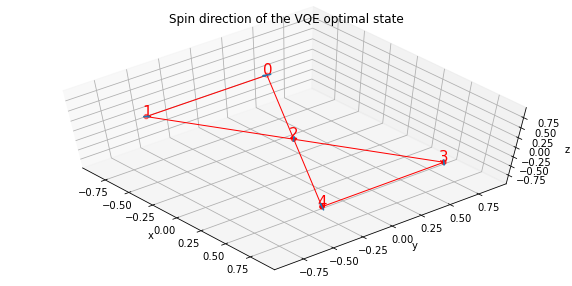

In [39]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
u=[]
v=[]
w=[]
print("Spin expected value")
for js,s in enumerate(spins_mat):
    val=np.dot(np.dot(np.conjugate(best_psi),s),best_psi)
    print("Spin ",spins[js][0]," ",np.round(np.real(val),3))
    if (js%3)==0:
        u.append(round(val,6))
    if (js%3)==1:
        v.append(round(val,6))
    if(js%3)==2:
        w.append(round(val,6))
            
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')

ax.set_title("Spin direction of the VQE optimal state")
ax.quiver(x,y,z,u,v,w,length=1, pivot='middle', normalize=True)
        
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(60,-40)
set_axes_equal(ax)
        
ax.scatter(x,y,z,color="r")
ax.plot(x,y,z,"r",linewidth="1")
ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
for i,val in enumerate(x):
    ax.text(x[i]-0.02,y[i]-0.02,z[i],i,color='red',size=15)
            
plt.show()

#### Spin-spin correlation functions of the VQE optimal state

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value on $|\psi_{opt}\rangle$. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [40]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))
spin_spin_mat=[]
for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

Spin-spin operators number: 75


Optimal VQE energy:  -4.58154765433401 ; Precision:  1.4184523456659903
     Spin-spin  0-0  (2.972251+0j)
     Spin-spin  0-1  (-2.67902+0j)
     Spin-spin  0-2  (-0.144029-0j)
     Spin-spin  0-3  (-0.039858-0j)
     Spin-spin  0-4  (-0.124995-0j)
     Spin-spin  1-0  (-2.67902+0j)
     Spin-spin  1-1  (2.973647+0j)
     Spin-spin  1-2  (-0.0658-0j)
     Spin-spin  1-3  (-0.174761+0j)
     Spin-spin  1-4  (-0.229132-0j)
     Spin-spin  2-0  (-0.144029-0j)
     Spin-spin  2-1  (-0.0658-0j)
     Spin-spin  2-2  (2.526829-0j)
     Spin-spin  2-3  (-2.232672+0j)
     Spin-spin  2-4  (-0.506899-0j)
     Spin-spin  3-0  (-0.039858-0j)
     Spin-spin  3-1  (-0.174761+0j)
     Spin-spin  3-2  (-2.232672+0j)
     Spin-spin  3-3  (2.533598+0j)
     Spin-spin  3-4  (-1.031093+0j)
     Spin-spin  4-0  (-0.124995-0j)
     Spin-spin  4-1  (-0.229132-0j)
     Spin-spin  4-2  (-0.506899-0j)
     Spin-spin  4-3  (-1.031093+0j)
     Spin-spin  4-4  (2.023087-0j)


<ipython-input-41-34a5c49d5070>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


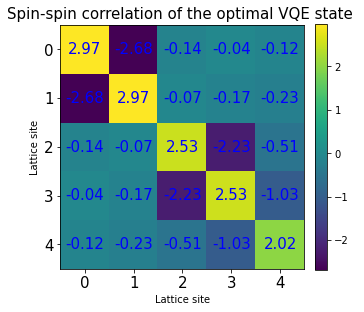

In [41]:
print("Optimal VQE energy: ",emin,"; Precision: ",emin+6)
       
val=[]
for el in spins_mat:
    val.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
val2=[]
for el in spin_spin_mat:
    val2.append(np.dot(np.dot(np.conjugate(best_psi),el),best_psi))
        
ss=[0]*(nqubit*nqubit)
s=[0]*(nqubit*nqubit)
M=np.zeros((nqubit,nqubit))
    
n=0
p=0
for j in range(nqubit):
    for k in range(nqubit):
        sj=0
        sk=0
        for l in range(3):
            ss[p] += val2[n]
            sj+=val[3*j+l]**2
            sk+=val[3*k+l]**2
            n += 1
                
        s[p]=pow(sj,0.5)*pow(sk,0.5)
        M[j,k]=ss[p]-s[p]
        print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
        p+=     1

#Here we create a visual representation of the spin-spin correlation values
fig, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(M)
    
ax.set_xticks(np.arange(nqubit))
ax.set_yticks(np.arange(nqubit))
ax.set_xticklabels(np.arange(nqubit), fontsize=15)
ax.set_yticklabels(np.arange(nqubit), fontsize=15)

ax.set_xlabel("Lattice site")
ax.set_ylabel("Lattice site")
        
fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

for ii in range(nqubit):
    for jj in range(nqubit):
          text = ax.text(jj, ii, round(M[ii, jj],2), ha="center", va="center", color="b", fontsize=15)

ax.set_title("Spin-spin correlation of the optimal VQE state ", fontsize=15)
fig.tight_layout()
plt.show()

# Mixed VQE with RotGate2 and RY circuits

We are going to use both circuits to find the ground state energy of our Hamiltonian. We first start with the **RotGate2** circuit and then we use the **RY** on the optimal state obtained. The choice of these two circuits is related to the fact that they involve a number of parameters $n$ small.

We intitialize the **RotGate2** circuit with the initial state $|\psi_5\rangle$.

In [56]:
var_form  = TwoLocal(H.num_qubits,RotGate2,['cx'],nn_list,initial_state=psi_5,reps=1,skip_final_rotation_layer=True)
print("The custom variational form")
print(var_form.draw())
print("Number of parameters: ",var_form.num_parameters)

The custom variational form
global phase: 0
     ┌─────────────┐┌─────────────┐ ┌────┐                              
q_0: ┤ U(3π/4,0,0) ├┤ U(0,0,2π/3) ├─┤0   ├──■─────────■─────────────────
     ├─────────────┤├─────────────┤ │    │┌─┴─┐       │                 
q_1: ┤ U(3π/4,0,0) ├┤ U(0,0,4π/3) ├─┤1   ├┤ X ├──■────┼─────────────────
     ├─────────────┤└─────────────┘ │    │└───┘┌─┴─┐┌─┴─┐               
q_2: ┤ U(3π/4,0,0) ├────────────────┤2 U ├─────┤ X ├┤ X ├──■────■───────
     ├─────────────┤┌──────────────┐│    │     └───┘└───┘┌─┴─┐  │       
q_3: ┤ U(3π/4,0,0) ├┤ U(0,0,-2π/3) ├┤3   ├───────────────┤ X ├──┼────■──
     ├─────────────┤├──────────────┤│    │               └───┘┌─┴─┐┌─┴─┐
q_4: ┤ U(3π/4,0,0) ├┤ U(0,0,-4π/3) ├┤4   ├────────────────────┤ X ├┤ X ├
     └─────────────┘└──────────────┘└────┘                    └───┘└───┘
Number of parameters:  3


In [57]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:29:07,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd242bd5c40>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd242bd57f0>>
-- initial_point: [ 2.59159621 -0.17910574  1.1806292 ]
-- var_form: global phase: 0
     ┌──────────────────┐ ┌──────────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤ U3(3π/4,0.0,0.0) ├─┤ U3(0,0,2π/3) ├┤ RZ(θ[2]) ├┤ RX(θ[1]) ├┤ RZ(θ[0]) ├»
  

2020-12-18 17:29:07,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.75811 (ms)
2020-12-18 17:29:07,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60162688] - 42.86313 (ms), eval count: 1
2020-12-18 17:29:07,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89392 (ms)
2020-12-18 17:29:07,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60162687] - 10.01120 (ms), eval count: 2
2020-12-18 17:29:07,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25806 (ms)
2020-12-18 17:29:07,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.60162677] - 7.38692 (ms), eval count: 3
2020-12-18 17:29:07,692:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23804 (ms)
2020-12-18 17:29:07,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:29:08,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.00195 (ms)
2020-12-18 17:29:08,067:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51893638] - 14.26268 (ms), eval count: 32
2020-12-18 17:29:08,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79722 (ms)
2020-12-18 17:29:08,082:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56344971] - 12.86507 (ms), eval count: 33
2020-12-18 17:29:08,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.08308 (ms)
2020-12-18 17:29:08,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56344971] - 12.66503 (ms), eval count: 34
2020-12-18 17:29:08,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57993 (ms)
2020-12-18 17:29:08,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:08,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.50079 (ms)
2020-12-18 17:29:08,449:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349676] - 14.12821 (ms), eval count: 63
2020-12-18 17:29:08,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.67896 (ms)
2020-12-18 17:29:08,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349676] - 11.64913 (ms), eval count: 64
2020-12-18 17:29:08,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.90587 (ms)
2020-12-18 17:29:08,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.70692 (ms), eval count: 65
2020-12-18 17:29:08,482:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12884 (ms)
2020-12-18 17:29:08,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:08,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17795 (ms)
2020-12-18 17:29:08,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.21400 (ms), eval count: 94
2020-12-18 17:29:08,805:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30114 (ms)
2020-12-18 17:29:08,812:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.72915 (ms), eval count: 95
2020-12-18 17:29:08,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41899 (ms)
2020-12-18 17:29:08,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.05197 (ms), eval count: 96
2020-12-18 17:29:08,827:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51603 (ms)
2020-12-18 17:29:08,834:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2020-12-18 17:29:09,142:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.40493 (ms)
2020-12-18 17:29:09,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.51178 (ms), eval count: 125
2020-12-18 17:29:09,157:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.61206 (ms)
2020-12-18 17:29:09,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.35287 (ms), eval count: 126
2020-12-18 17:29:09,169:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01790 (ms)
2020-12-18 17:29:09,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.18586 (ms), eval count: 127
2020-12-18 17:29:09,178:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25115 (ms)
2020-12-18 17:29:09,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:29:09,439:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61283 (ms)
2020-12-18 17:29:09,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.95262 (ms), eval count: 156
2020-12-18 17:29:09,451:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60274 (ms)
2020-12-18 17:29:09,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.72001 (ms), eval count: 157
2020-12-18 17:29:09,463:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.80611 (ms)
2020-12-18 17:29:09,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.33998 (ms), eval count: 158
2020-12-18 17:29:09,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55506 (ms)
2020-12-18 17:29:09,482:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:09,890:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.84865 (ms)
2020-12-18 17:29:09,896:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 12.09497 (ms), eval count: 187
2020-12-18 17:29:09,903:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.96619 (ms)
2020-12-18 17:29:09,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.84893 (ms), eval count: 188
2020-12-18 17:29:09,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.21708 (ms)
2020-12-18 17:29:09,922:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.26027 (ms), eval count: 189
2020-12-18 17:29:09,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51191 (ms)
2020-12-18 17:29:09,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:10,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20196 (ms)
2020-12-18 17:29:10,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 6.92606 (ms), eval count: 218
2020-12-18 17:29:10,210:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23725 (ms)
2020-12-18 17:29:10,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.57997 (ms), eval count: 219
2020-12-18 17:29:10,219:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26712 (ms)
2020-12-18 17:29:10,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 7.23767 (ms), eval count: 220
2020-12-18 17:29:10,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.13401 (ms)
2020-12-18 17:29:10,232:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:10,576:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.04286 (ms)
2020-12-18 17:29:10,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.58698 (ms), eval count: 249
2020-12-18 17:29:10,590:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.77314 (ms)
2020-12-18 17:29:10,597:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.41310 (ms), eval count: 250
2020-12-18 17:29:10,602:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84903 (ms)
2020-12-18 17:29:10,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.87801 (ms), eval count: 251
2020-12-18 17:29:10,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31314 (ms)
2020-12-18 17:29:10,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:10,971:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70288 (ms)
2020-12-18 17:29:10,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 11.41000 (ms), eval count: 280
2020-12-18 17:29:10,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50602 (ms)
2020-12-18 17:29:10,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 9.35221 (ms), eval count: 281
2020-12-18 17:29:10,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.01704 (ms)
2020-12-18 17:29:11,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 12.20822 (ms), eval count: 282
2020-12-18 17:29:11,011:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.10089 (ms)
2020-12-18 17:29:11,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:11,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78306 (ms)
2020-12-18 17:29:11,276:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.29196 (ms), eval count: 311
2020-12-18 17:29:11,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91896 (ms)
2020-12-18 17:29:11,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.22711 (ms), eval count: 312
2020-12-18 17:29:11,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98698 (ms)
2020-12-18 17:29:11,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 8.07381 (ms), eval count: 313
2020-12-18 17:29:11,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44713 (ms)
2020-12-18 17:29:11,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:11,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 16.23607 (ms)
2020-12-18 17:29:11,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 24.27411 (ms), eval count: 342
2020-12-18 17:29:11,647:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.07202 (ms)
2020-12-18 17:29:11,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 13.94987 (ms), eval count: 343
2020-12-18 17:29:11,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.39024 (ms)
2020-12-18 17:29:11,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 10.72192 (ms), eval count: 344
2020-12-18 17:29:11,684:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.70428 (ms)
2020-12-18 17:29:11,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:29:12,001:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30274 (ms)
2020-12-18 17:29:12,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 66.16807 (ms), eval count: 373
2020-12-18 17:29:12,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.15484 (ms)
2020-12-18 17:29:12,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 47.60408 (ms), eval count: 374
2020-12-18 17:29:12,180:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.82418 (ms)
2020-12-18 17:29:12,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.56349678] - 26.07489 (ms), eval count: 375
2020-12-18 17:29:12,208:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.13301 (ms)
2020-12-18 17:29:12,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

In [58]:
print("Minimal energy with RotGate2: ",emin)

Minimal energy with RotGate2:  -4.563496781083091


Now we use the **RY** on the optimal state of **RotGate2**. We will limit the iteration steps of the algorithm.

In [59]:
RY_initial_state=Custom(nqubit,state_vector=best_psi)
var_form  = RealAmplitudes(H.num_qubits,entanglement=nn_list,initial_state=RY_initial_state,insert_barriers=True,reps=1)
print("Number of parameters: ",var_form.num_parameters)
print(var_form.draw())

Number of parameters:  10
     ┌───────────────┐                                                         »
q_0: ┤ U(1.6015,0,0) ├─────────────────────────────────────────────────────────»
     ├───────────────┤                                                         »
q_1: ┤ U(1.5037,0,0) ├─────────────────────────────────────────────────────────»
     ├───────────────┤                                                         »
q_2: ┤ U(1.2978,0,0) ├─────────────────────────────────────────────────────────»
     ├───────────────┤              ┌───┐┌─────────────────┐┌────────────┐┌───┐»
q_3: ┤ U(2.2653,0,0) ├──────────────┤ X ├┤ U(0.006405,0,0) ├┤ U(0,0,π/8) ├┤ X ├»
     ├───────────────┤┌────────────┐└─┬─┘└─────────────────┘└────────────┘└─┬─┘»
q_4: ┤ U(1.4974,0,0) ├┤ U(0,0,π/8) ├──■─────────────────────────────────────■──»
     └───────────────┘└────────────┘                                           »
«                                                                       »
«q_0: ───

In [60]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-12))
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:29:13,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd249ccefd0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd249cce850>>
-- initial_point: Random seed
-- var_form:      ┌──────────────────────────────┐                    »
q_0: ┤ U3(1.60146463926556,0.0,0.0) ├────────────────────»
     ├──────────────────────────────┤                    »
q_1: ┤ U3(1.50371214409940,

2020-12-18 17:29:13,160:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.95323684 -2.50839827  1.24981865  2.20681171  1.33580198 -1.97275653
  2.6092302   2.45779272  1.61570632  1.83215932]
2020-12-18 17:29:13,162:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2020-12-18 17:29:13,194:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:29:13,196:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 130 operati

2020-12-18 17:29:13,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.54649721] - 9.94492 (ms), eval count: 25
2020-12-18 17:29:13,583:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90306 (ms)
2020-12-18 17:29:13,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.54649722] - 9.99975 (ms), eval count: 26
2020-12-18 17:29:13,595:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16801 (ms)
2020-12-18 17:29:13,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.54649722] - 10.23316 (ms), eval count: 27
2020-12-18 17:29:13,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40595 (ms)
2020-12-18 17:29:13,614:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.54649722] - 8.62312 (ms), eval count: 28
2020-12-18 17:29:13,619:qiskit.aqua.operators.convert

2020-12-18 17:29:13,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.99046385] - 14.99891 (ms), eval count: 56
2020-12-18 17:29:13,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54090 (ms)
2020-12-18 17:29:13,972:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.99046386] - 11.31988 (ms), eval count: 57
2020-12-18 17:29:13,977:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90020 (ms)
2020-12-18 17:29:13,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.99046385] - 11.39927 (ms), eval count: 58
2020-12-18 17:29:13,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44498 (ms)
2020-12-18 17:29:14,001:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.99046385] - 13.45992 (ms), eval count: 59
2020-12-18 17:29:14,006:qiskit.aqua.operators.conv

2020-12-18 17:29:14,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.20697593] - 28.75900 (ms), eval count: 87
2020-12-18 17:29:14,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.15397 (ms)
2020-12-18 17:29:14,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.20697592] - 15.56706 (ms), eval count: 88
2020-12-18 17:29:14,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.45900 (ms)
2020-12-18 17:29:14,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.50259886] - 17.27509 (ms), eval count: 89
2020-12-18 17:29:14,718:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04103 (ms)
2020-12-18 17:29:14,728:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.50259886] - 13.37504 (ms), eval count: 90
2020-12-18 17:29:14,734:qiskit.aqua.operators.conv

2020-12-18 17:29:15,246:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55084471] - 10.09464 (ms), eval count: 118
2020-12-18 17:29:15,248:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19305 (ms)
2020-12-18 17:29:15,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55084471] - 9.59897 (ms), eval count: 119
2020-12-18 17:29:15,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21617 (ms)
2020-12-18 17:29:15,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55084471] - 8.76594 (ms), eval count: 120
2020-12-18 17:29:15,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55997 (ms)
2020-12-18 17:29:15,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55084471] - 8.90684 (ms), eval count: 121
2020-12-18 17:29:15,284:qiskit.aqua.operators.con

2020-12-18 17:29:15,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5740954] - 10.80418 (ms), eval count: 149
2020-12-18 17:29:15,844:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.53989 (ms)
2020-12-18 17:29:15,853:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5740954] - 14.99081 (ms), eval count: 150
2020-12-18 17:29:15,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70486 (ms)
2020-12-18 17:29:15,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5740954] - 14.99867 (ms), eval count: 151
2020-12-18 17:29:15,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78814 (ms)
2020-12-18 17:29:15,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.5740954] - 10.52094 (ms), eval count: 152
2020-12-18 17:29:15,890:qiskit.aqua.operators.conv

2020-12-18 17:29:16,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.6282699] - 15.74826 (ms), eval count: 180
2020-12-18 17:29:16,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16007 (ms)
2020-12-18 17:29:16,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.62826991] - 11.99698 (ms), eval count: 181
2020-12-18 17:29:16,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97411 (ms)
2020-12-18 17:29:16,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.6282699] - 10.48088 (ms), eval count: 182
2020-12-18 17:29:16,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84822 (ms)
2020-12-18 17:29:16,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.6282699] - 13.90290 (ms), eval count: 183
2020-12-18 17:29:16,581:qiskit.aqua.operators.con

2020-12-18 17:29:17,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78475637] - 19.09494 (ms), eval count: 211
2020-12-18 17:29:17,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66306 (ms)
2020-12-18 17:29:17,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78475637] - 12.37988 (ms), eval count: 212
2020-12-18 17:29:17,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.06308 (ms)
2020-12-18 17:29:17,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78475636] - 15.99002 (ms), eval count: 213
2020-12-18 17:29:17,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70898 (ms)
2020-12-18 17:29:17,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78475637] - 19.77706 (ms), eval count: 214
2020-12-18 17:29:17,177:qiskit.aqua.operators.

2020-12-18 17:29:17,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.82484434] - 13.02886 (ms), eval count: 242
2020-12-18 17:29:17,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55299 (ms)
2020-12-18 17:29:17,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85941923] - 14.04595 (ms), eval count: 243
2020-12-18 17:29:17,794:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39389 (ms)
2020-12-18 17:29:17,808:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85941923] - 17.67206 (ms), eval count: 244
2020-12-18 17:29:17,818:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72195 (ms)
2020-12-18 17:29:17,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85941923] - 22.87412 (ms), eval count: 245
2020-12-18 17:29:17,846:qiskit.aqua.operators.

2020-12-18 17:29:18,491:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85878054] - 14.96720 (ms), eval count: 273
2020-12-18 17:29:18,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51603 (ms)
2020-12-18 17:29:18,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85878054] - 24.74213 (ms), eval count: 274
2020-12-18 17:29:18,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06416 (ms)
2020-12-18 17:29:18,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85878054] - 21.05474 (ms), eval count: 275
2020-12-18 17:29:18,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.29010 (ms)
2020-12-18 17:29:18,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.89380476] - 15.16390 (ms), eval count: 276
2020-12-18 17:29:18,599:qiskit.aqua.operators.

2020-12-18 17:29:19,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91147184] - 21.10076 (ms), eval count: 304
2020-12-18 17:29:19,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.59602 (ms)
2020-12-18 17:29:19,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91147184] - 29.89697 (ms), eval count: 305
2020-12-18 17:29:19,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.94711 (ms)
2020-12-18 17:29:19,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91147184] - 12.94494 (ms), eval count: 306
2020-12-18 17:29:19,164:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87008 (ms)
2020-12-18 17:29:19,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91147184] - 31.92806 (ms), eval count: 307
2020-12-18 17:29:19,205:qiskit.aqua.operators.

2020-12-18 17:29:19,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93391117] - 19.68694 (ms), eval count: 335
2020-12-18 17:29:19,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37799 (ms)
2020-12-18 17:29:19,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93391117] - 24.70207 (ms), eval count: 336
2020-12-18 17:29:19,816:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73116 (ms)
2020-12-18 17:29:19,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93391117] - 10.57911 (ms), eval count: 337
2020-12-18 17:29:19,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.42982 (ms)
2020-12-18 17:29:19,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93391117] - 32.61399 (ms), eval count: 338
2020-12-18 17:29:19,873:qiskit.aqua.operators.

2020-12-18 17:29:20,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93549427] - 11.86705 (ms), eval count: 366
2020-12-18 17:29:20,379:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.60904 (ms)
2020-12-18 17:29:20,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93549427] - 14.43005 (ms), eval count: 367
2020-12-18 17:29:20,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.99713 (ms)
2020-12-18 17:29:20,412:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93549427] - 21.82794 (ms), eval count: 368
2020-12-18 17:29:20,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01297 (ms)
2020-12-18 17:29:20,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93549427] - 12.94231 (ms), eval count: 369
2020-12-18 17:29:20,436:qiskit.aqua.operators.

2020-12-18 17:29:21,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93684107] - 25.24996 (ms), eval count: 397
2020-12-18 17:29:21,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.77591 (ms)
2020-12-18 17:29:21,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93684107] - 22.02320 (ms), eval count: 398
2020-12-18 17:29:21,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57993 (ms)
2020-12-18 17:29:21,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93684107] - 44.93117 (ms), eval count: 399
2020-12-18 17:29:21,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25680 (ms)
2020-12-18 17:29:21,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93684107] - 21.21305 (ms), eval count: 400
2020-12-18 17:29:21,123:qiskit.aqua.operators.

2020-12-18 17:29:21,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93690827] - 13.32188 (ms), eval count: 428
2020-12-18 17:29:21,736:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31886 (ms)
2020-12-18 17:29:21,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93690827] - 24.68801 (ms), eval count: 429
2020-12-18 17:29:21,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66902 (ms)
2020-12-18 17:29:21,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93702334] - 36.42321 (ms), eval count: 430
2020-12-18 17:29:21,815:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64025 (ms)
2020-12-18 17:29:21,838:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93702334] - 26.53432 (ms), eval count: 431
2020-12-18 17:29:21,842:qiskit.aqua.operators.

2020-12-18 17:29:22,445:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93712488] - 37.56595 (ms), eval count: 459
2020-12-18 17:29:22,481:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65391 (ms)
2020-12-18 17:29:22,501:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93712488] - 21.47675 (ms), eval count: 460
2020-12-18 17:29:22,515:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.72283 (ms)
2020-12-18 17:29:22,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93712488] - 13.24320 (ms), eval count: 461
2020-12-18 17:29:22,529:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83909 (ms)
2020-12-18 17:29:22,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93712488] - 20.69211 (ms), eval count: 462
2020-12-18 17:29:22,550:qiskit.aqua.operators.

2020-12-18 17:29:23,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.937186] - 20.88928 (ms), eval count: 490
2020-12-18 17:29:23,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35615 (ms)
2020-12-18 17:29:23,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.937186] - 14.52279 (ms), eval count: 491
2020-12-18 17:29:23,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14410 (ms)
2020-12-18 17:29:23,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.937186] - 13.30900 (ms), eval count: 492
2020-12-18 17:29:23,168:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00582 (ms)
2020-12-18 17:29:23,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.937186] - 17.89308 (ms), eval count: 493
2020-12-18 17:29:23,190:qiskit.aqua.operators.converte

2020-12-18 17:29:23,624:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721076] - 15.65003 (ms), eval count: 521
2020-12-18 17:29:23,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.60212 (ms)
2020-12-18 17:29:23,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721076] - 19.97423 (ms), eval count: 522
2020-12-18 17:29:23,657:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53987 (ms)
2020-12-18 17:29:23,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721076] - 23.21696 (ms), eval count: 523
2020-12-18 17:29:23,681:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53494 (ms)
2020-12-18 17:29:23,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721076] - 13.55004 (ms), eval count: 524
2020-12-18 17:29:23,698:qiskit.aqua.operators.

2020-12-18 17:29:24,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721185] - 13.75604 (ms), eval count: 552
2020-12-18 17:29:24,235:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.20389 (ms)
2020-12-18 17:29:24,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721185] - 22.23182 (ms), eval count: 553
2020-12-18 17:29:24,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43003 (ms)
2020-12-18 17:29:24,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721185] - 10.00881 (ms), eval count: 554
2020-12-18 17:29:24,272:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.72102 (ms)
2020-12-18 17:29:24,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721185] - 17.56692 (ms), eval count: 555
2020-12-18 17:29:24,289:qiskit.aqua.operators.

2020-12-18 17:29:24,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721228] - 5.92804 (ms), eval count: 583
2020-12-18 17:29:24,714:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41501 (ms)
2020-12-18 17:29:24,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721256] - 10.18119 (ms), eval count: 584
2020-12-18 17:29:24,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64723 (ms)
2020-12-18 17:29:24,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721256] - 6.69312 (ms), eval count: 585
2020-12-18 17:29:24,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17111 (ms)
2020-12-18 17:29:24,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721256] - 7.71189 (ms), eval count: 586
2020-12-18 17:29:24,755:qiskit.aqua.operators.con

2020-12-18 17:29:25,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721295] - 9.68289 (ms), eval count: 614
2020-12-18 17:29:25,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.93994 (ms)
2020-12-18 17:29:25,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721295] - 22.92514 (ms), eval count: 615
2020-12-18 17:29:25,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79410 (ms)
2020-12-18 17:29:25,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721295] - 16.39509 (ms), eval count: 616
2020-12-18 17:29:25,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29485 (ms)
2020-12-18 17:29:25,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721277] - 11.36303 (ms), eval count: 617
2020-12-18 17:29:25,160:qiskit.aqua.operators.c

2020-12-18 17:29:25,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721297] - 23.14591 (ms), eval count: 645
2020-12-18 17:29:25,740:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.75311 (ms)
2020-12-18 17:29:25,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721297] - 23.78702 (ms), eval count: 646
2020-12-18 17:29:25,765:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99294 (ms)
2020-12-18 17:29:25,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721297] - 21.72589 (ms), eval count: 647
2020-12-18 17:29:25,789:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58906 (ms)
2020-12-18 17:29:25,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721297] - 9.70888 (ms), eval count: 648
2020-12-18 17:29:25,804:qiskit.aqua.operators.c

2020-12-18 17:29:26,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721306] - 24.99819 (ms), eval count: 676
2020-12-18 17:29:26,368:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21395 (ms)
2020-12-18 17:29:26,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721306] - 18.83602 (ms), eval count: 677
2020-12-18 17:29:26,387:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39689 (ms)
2020-12-18 17:29:26,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721306] - 13.72695 (ms), eval count: 678
2020-12-18 17:29:26,413:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.49795 (ms)
2020-12-18 17:29:26,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721306] - 17.12489 (ms), eval count: 679
2020-12-18 17:29:26,429:qiskit.aqua.operators.

2020-12-18 17:29:26,846:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9372131] - 7.91001 (ms), eval count: 707
2020-12-18 17:29:26,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15585 (ms)
2020-12-18 17:29:26,860:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9372131] - 10.28371 (ms), eval count: 708
2020-12-18 17:29:26,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50220 (ms)
2020-12-18 17:29:26,881:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9372131] - 14.77313 (ms), eval count: 709
2020-12-18 17:29:26,886:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15299 (ms)
2020-12-18 17:29:26,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9372131] - 19.11521 (ms), eval count: 710
2020-12-18 17:29:26,908:qiskit.aqua.operators.conve

2020-12-18 17:29:27,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721311] - 28.30315 (ms), eval count: 738
2020-12-18 17:29:27,598:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53375 (ms)
2020-12-18 17:29:27,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721311] - 23.31614 (ms), eval count: 739
2020-12-18 17:29:27,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16780 (ms)
2020-12-18 17:29:27,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721311] - 20.52402 (ms), eval count: 740
2020-12-18 17:29:27,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10094 (ms)
2020-12-18 17:29:27,668:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721311] - 11.56998 (ms), eval count: 741
2020-12-18 17:29:27,674:qiskit.aqua.operators.

2020-12-18 17:29:28,205:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 20.28608 (ms), eval count: 769
2020-12-18 17:29:28,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36313 (ms)
2020-12-18 17:29:28,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 16.25180 (ms), eval count: 770
2020-12-18 17:29:28,228:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69706 (ms)
2020-12-18 17:29:28,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 13.10396 (ms), eval count: 771
2020-12-18 17:29:28,252:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36177 (ms)
2020-12-18 17:29:28,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 18.26835 (ms), eval count: 772
2020-12-18 17:29:28,279:qiskit.aqua.operators.

2020-12-18 17:29:28,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 17.23409 (ms), eval count: 800
2020-12-18 17:29:28,839:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38609 (ms)
2020-12-18 17:29:28,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 11.89303 (ms), eval count: 801
2020-12-18 17:29:28,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61586 (ms)
2020-12-18 17:29:28,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 14.94813 (ms), eval count: 802
2020-12-18 17:29:28,874:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69301 (ms)
2020-12-18 17:29:28,883:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 10.95605 (ms), eval count: 803
2020-12-18 17:29:28,885:qiskit.aqua.operators.

2020-12-18 17:29:29,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 23.03791 (ms), eval count: 831
2020-12-18 17:29:29,353:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.47585 (ms)
2020-12-18 17:29:29,361:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 14.77599 (ms), eval count: 832
2020-12-18 17:29:29,365:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48201 (ms)
2020-12-18 17:29:29,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 12.84790 (ms), eval count: 833
2020-12-18 17:29:29,381:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.31798 (ms)
2020-12-18 17:29:29,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.27098 (ms), eval count: 834
2020-12-18 17:29:29,392:qiskit.aqua.operators.c

2020-12-18 17:29:29,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.42190 (ms), eval count: 862
2020-12-18 17:29:29,743:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00129 (ms)
2020-12-18 17:29:29,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.21512 (ms), eval count: 863
2020-12-18 17:29:29,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39093 (ms)
2020-12-18 17:29:29,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.67724 (ms), eval count: 864
2020-12-18 17:29:29,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40810 (ms)
2020-12-18 17:29:29,770:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.50511 (ms), eval count: 865
2020-12-18 17:29:29,773:qiskit.aqua.operators.conv

2020-12-18 17:29:30,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 7.89404 (ms), eval count: 893
2020-12-18 17:29:30,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92690 (ms)
2020-12-18 17:29:30,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.22894 (ms), eval count: 894
2020-12-18 17:29:30,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32012 (ms)
2020-12-18 17:29:30,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.44781 (ms), eval count: 895
2020-12-18 17:29:30,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44315 (ms)
2020-12-18 17:29:30,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 7.94125 (ms), eval count: 896
2020-12-18 17:29:30,136:qiskit.aqua.operators.conv

2020-12-18 17:29:30,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 7.90977 (ms), eval count: 924
2020-12-18 17:29:30,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16882 (ms)
2020-12-18 17:29:30,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 11.73997 (ms), eval count: 925
2020-12-18 17:29:30,640:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49212 (ms)
2020-12-18 17:29:30,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 13.10396 (ms), eval count: 926
2020-12-18 17:29:30,652:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51515 (ms)
2020-12-18 17:29:30,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.27074 (ms), eval count: 927
2020-12-18 17:29:30,665:qiskit.aqua.operators.co

2020-12-18 17:29:31,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.81379 (ms), eval count: 955
2020-12-18 17:29:31,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19400 (ms)
2020-12-18 17:29:31,026:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.88586 (ms), eval count: 956
2020-12-18 17:29:31,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16014 (ms)
2020-12-18 17:29:31,035:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 7.95507 (ms), eval count: 957
2020-12-18 17:29:31,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29509 (ms)
2020-12-18 17:29:31,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 7.72309 (ms), eval count: 958
2020-12-18 17:29:31,049:qiskit.aqua.operators.conv

2020-12-18 17:29:31,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.15909 (ms), eval count: 986
2020-12-18 17:29:31,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82676 (ms)
2020-12-18 17:29:31,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.62210 (ms), eval count: 987
2020-12-18 17:29:31,413:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42400 (ms)
2020-12-18 17:29:31,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 14.65917 (ms), eval count: 988
2020-12-18 17:29:31,429:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69539 (ms)
2020-12-18 17:29:31,444:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 16.68978 (ms), eval count: 989
2020-12-18 17:29:31,460:qiskit.aqua.operators.co

2020-12-18 17:29:31,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 8.60715 (ms), eval count: 1017
2020-12-18 17:29:31,905:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17373 (ms)
2020-12-18 17:29:31,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 9.15670 (ms), eval count: 1018
2020-12-18 17:29:31,915:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48463 (ms)
2020-12-18 17:29:31,925:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 11.24716 (ms), eval count: 1019
2020-12-18 17:29:31,930:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10683 (ms)
2020-12-18 17:29:31,942:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93721312] - 15.30194 (ms), eval count: 1020
2020-12-18 17:29:31,948:qiskit.aqua.operator

In [61]:
print("Optimal value of the mixed VQE: ",emin)

Optimal value of the mixed VQE:  -4.937213116400997


# Mixed VQE with RotGate2 and so4

In [62]:
var_form  = TwoLocal(H.num_qubits,RotGate2,['cx'],nn_list,initial_state=psi_5,reps=1,skip_final_rotation_layer=True)
print("The custom variational form")
print(var_form.draw())
print("Number of parameters: ",var_form.num_parameters)

The custom variational form
global phase: 0
     ┌─────────────┐┌─────────────┐ ┌────┐                              
q_0: ┤ U(3π/4,0,0) ├┤ U(0,0,2π/3) ├─┤0   ├──■─────────■─────────────────
     ├─────────────┤├─────────────┤ │    │┌─┴─┐       │                 
q_1: ┤ U(3π/4,0,0) ├┤ U(0,0,4π/3) ├─┤1   ├┤ X ├──■────┼─────────────────
     ├─────────────┤└─────────────┘ │    │└───┘┌─┴─┐┌─┴─┐               
q_2: ┤ U(3π/4,0,0) ├────────────────┤2 U ├─────┤ X ├┤ X ├──■────■───────
     ├─────────────┤┌──────────────┐│    │     └───┘└───┘┌─┴─┐  │       
q_3: ┤ U(3π/4,0,0) ├┤ U(0,0,-2π/3) ├┤3   ├───────────────┤ X ├──┼────■──
     ├─────────────┤├──────────────┤│    │               └───┘┌─┴─┐┌─┴─┐
q_4: ┤ U(3π/4,0,0) ├┤ U(0,0,-4π/3) ├┤4   ├────────────────────┤ X ├┤ X ├
     └─────────────┘└──────────────┘└────┘                    └───┘└───┘
Number of parameters:  3


In [63]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:29:32,450:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd24862aa30>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd24862abe0>>
-- initial_point: [-0.06345572 -0.22782647  1.69198757]
-- var_form: global phase: 0
     ┌──────────────────┐ ┌──────────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤ U3(3π/4,0.0,0.0) ├─┤ U3(0,0,2π/3) ├┤ RZ(θ[2]) ├┤ RX(θ[1]) ├┤ RZ(θ[0]) ├»
  

2020-12-18 17:29:32,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.74276 (ms)
2020-12-18 17:29:32,527:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48514093] - 59.43704 (ms), eval count: 1
2020-12-18 17:29:32,536:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.55587 (ms)
2020-12-18 17:29:32,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48514094] - 18.22376 (ms), eval count: 2
2020-12-18 17:29:32,576:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 19.52505 (ms)
2020-12-18 17:29:32,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48514094] - 29.17504 (ms), eval count: 3
2020-12-18 17:29:32,596:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.99010 (ms)
2020-12-18 17:29:32,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:29:33,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 17.12489 (ms)
2020-12-18 17:29:33,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.70428639] - 32.27496 (ms), eval count: 32
2020-12-18 17:29:33,143:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.95014 (ms)
2020-12-18 17:29:33,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.12156597] - 22.26424 (ms), eval count: 33
2020-12-18 17:29:33,171:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62015 (ms)
2020-12-18 17:29:33,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.12156596] - 16.22295 (ms), eval count: 34
2020-12-18 17:29:33,188:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29113 (ms)
2020-12-18 17:29:33,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:29:33,829:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.17924 (ms)
2020-12-18 17:29:33,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.22530168] - 14.46509 (ms), eval count: 63
2020-12-18 17:29:33,844:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61617 (ms)
2020-12-18 17:29:33,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.22530168] - 7.36308 (ms), eval count: 64
2020-12-18 17:29:33,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.97317 (ms)
2020-12-18 17:29:33,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.39813431] - 12.54106 (ms), eval count: 65
2020-12-18 17:29:33,868:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04206 (ms)
2020-12-18 17:29:33,873:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:29:34,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19695 (ms)
2020-12-18 17:29:34,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58142801] - 11.56616 (ms), eval count: 94
2020-12-18 17:29:34,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.95395 (ms)
2020-12-18 17:29:34,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58142801] - 19.33408 (ms), eval count: 95
2020-12-18 17:29:34,286:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.47106 (ms)
2020-12-18 17:29:34,293:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58142801] - 12.33912 (ms), eval count: 96
2020-12-18 17:29:34,300:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35305 (ms)
2020-12-18 17:29:34,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:34,640:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29590 (ms)
2020-12-18 17:29:34,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154668] - 8.37493 (ms), eval count: 125
2020-12-18 17:29:34,648:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34103 (ms)
2020-12-18 17:29:34,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154668] - 12.30502 (ms), eval count: 126
2020-12-18 17:29:34,666:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.39517 (ms)
2020-12-18 17:29:34,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154668] - 12.00390 (ms), eval count: 127
2020-12-18 17:29:34,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.63667 (ms)
2020-12-18 17:29:34,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:35,205:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.43398 (ms)
2020-12-18 17:29:35,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154761] - 23.94128 (ms), eval count: 156
2020-12-18 17:29:35,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.66895 (ms)
2020-12-18 17:29:35,259:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 29.33693 (ms), eval count: 157
2020-12-18 17:29:35,272:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10700 (ms)
2020-12-18 17:29:35,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 15.06829 (ms), eval count: 158
2020-12-18 17:29:35,292:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.20904 (ms)
2020-12-18 17:29:35,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:35,833:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.16972 (ms)
2020-12-18 17:29:35,836:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.90026 (ms), eval count: 187
2020-12-18 17:29:35,850:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10700 (ms)
2020-12-18 17:29:35,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.45418 (ms), eval count: 188
2020-12-18 17:29:35,861:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59488 (ms)
2020-12-18 17:29:35,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 14.11724 (ms), eval count: 189
2020-12-18 17:29:35,878:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16024 (ms)
2020-12-18 17:29:35,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:36,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46701 (ms)
2020-12-18 17:29:36,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 14.46199 (ms), eval count: 218
2020-12-18 17:29:36,356:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01504 (ms)
2020-12-18 17:29:36,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 23.93603 (ms), eval count: 219
2020-12-18 17:29:36,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.42285 (ms)
2020-12-18 17:29:36,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 15.71703 (ms), eval count: 220
2020-12-18 17:29:36,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10080 (ms)
2020-12-18 17:29:36,434:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:36,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88186 (ms)
2020-12-18 17:29:36,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 13.81922 (ms), eval count: 249
2020-12-18 17:29:36,968:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.89888 (ms)
2020-12-18 17:29:36,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 14.85586 (ms), eval count: 250
2020-12-18 17:29:36,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05598 (ms)
2020-12-18 17:29:36,990:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.96599 (ms), eval count: 251
2020-12-18 17:29:37,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.44214 (ms)
2020-12-18 17:29:37,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:37,364:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81286 (ms)
2020-12-18 17:29:37,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.35402 (ms), eval count: 280
2020-12-18 17:29:37,373:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91896 (ms)
2020-12-18 17:29:37,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.51114 (ms), eval count: 281
2020-12-18 17:29:37,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51715 (ms)
2020-12-18 17:29:37,388:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.57592 (ms), eval count: 282
2020-12-18 17:29:37,392:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.28786 (ms)
2020-12-18 17:29:37,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

In [64]:
print("Minimal energy with RotGate2: ",emin)

Minimal energy with RotGate2:  -4.58154765433399


Now we use the **so4** on the optimal state of **RotGate2**. We will limit the iteration steps of the algorithm.

In [65]:
RY_initial_state=Custom(nqubit,state_vector=best_psi)
var_form  = so4(num_qubits=H.num_qubits,reps=1,connections=nn_list,initial_state=RY_initial_state) 
print("Number of parameters: ",var_form.num_parameters)

Number of parameters:  36


In [66]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-12))
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:29:37,829:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd248667f70>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd248667bb0>>
-- initial_point: Random seed
-- var_form: <__main__.so4 object at 0x7fd24945aac0>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]

2020-12-18 17:29:38,752:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45182 (ms)
2020-12-18 17:29:38,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47844379] - 14.58812 (ms), eval count: 7
2020-12-18 17:29:38,767:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49903 (ms)
2020-12-18 17:29:38,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47844381] - 14.71591 (ms), eval count: 8
2020-12-18 17:29:38,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53885 (ms)
2020-12-18 17:29:38,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47844381] - 13.35597 (ms), eval count: 9
2020-12-18 17:29:38,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58081 (ms)
2020-12-18 17:29:38,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:29:39,401:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.64280 (ms)
2020-12-18 17:29:39,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548827] - 12.48813 (ms), eval count: 38
2020-12-18 17:29:39,420:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.82600 (ms)
2020-12-18 17:29:39,431:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548828] - 16.89768 (ms), eval count: 39
2020-12-18 17:29:39,440:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.66022 (ms)
2020-12-18 17:29:39,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548827] - 17.95411 (ms), eval count: 40
2020-12-18 17:29:39,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37005 (ms)
2020-12-18 17:29:39,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:29:39,987:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.34313 (ms)
2020-12-18 17:29:40,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548826] - 21.72518 (ms), eval count: 69
2020-12-18 17:29:40,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 21.57497 (ms)
2020-12-18 17:29:40,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548826] - 32.61805 (ms), eval count: 70
2020-12-18 17:29:40,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.34384 (ms)
2020-12-18 17:29:40,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.19548826] - 14.29892 (ms), eval count: 71
2020-12-18 17:29:40,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50428 (ms)
2020-12-18 17:29:40,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:29:40,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.40881 (ms)
2020-12-18 17:29:40,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.85459768] - 22.79615 (ms), eval count: 100
2020-12-18 17:29:40,912:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32189 (ms)
2020-12-18 17:29:40,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.85459768] - 15.16485 (ms), eval count: 101
2020-12-18 17:29:40,934:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.67374 (ms)
2020-12-18 17:29:40,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.85459768] - 16.77489 (ms), eval count: 102
2020-12-18 17:29:40,954:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.14405 (ms)
2020-12-18 17:29:40,961:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:29:41,669:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.80804 (ms)
2020-12-18 17:29:41,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18169191] - 21.94095 (ms), eval count: 131
2020-12-18 17:29:41,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.31499 (ms)
2020-12-18 17:29:41,703:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18169191] - 16.37459 (ms), eval count: 132
2020-12-18 17:29:41,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.68612 (ms)
2020-12-18 17:29:41,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.18169191] - 14.56881 (ms), eval count: 133
2020-12-18 17:29:41,731:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.67183 (ms)
2020-12-18 17:29:41,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:42,281:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83997 (ms)
2020-12-18 17:29:42,288:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.7506931] - 11.36708 (ms), eval count: 162
2020-12-18 17:29:42,294:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19099 (ms)
2020-12-18 17:29:42,303:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.75069311] - 12.49504 (ms), eval count: 163
2020-12-18 17:29:42,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51214 (ms)
2020-12-18 17:29:42,316:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.75069311] - 9.19485 (ms), eval count: 164
2020-12-18 17:29:42,322:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24392 (ms)
2020-12-18 17:29:42,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:29:42,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28016 (ms)
2020-12-18 17:29:42,776:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.41641593] - 11.32107 (ms), eval count: 193
2020-12-18 17:29:42,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44229 (ms)
2020-12-18 17:29:42,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.41641593] - 10.55193 (ms), eval count: 194
2020-12-18 17:29:42,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.15213 (ms)
2020-12-18 17:29:42,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.41641593] - 10.61177 (ms), eval count: 195
2020-12-18 17:29:42,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40104 (ms)
2020-12-18 17:29:42,815:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:43,245:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.64392 (ms)
2020-12-18 17:29:43,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791413] - 11.51204 (ms), eval count: 224
2020-12-18 17:29:43,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40629 (ms)
2020-12-18 17:29:43,264:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791413] - 11.67417 (ms), eval count: 225
2020-12-18 17:29:43,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92604 (ms)
2020-12-18 17:29:43,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791412] - 12.07399 (ms), eval count: 226
2020-12-18 17:29:43,283:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47090 (ms)
2020-12-18 17:29:43,291:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:43,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 72.62278 (ms)
2020-12-18 17:29:43,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791413] - 99.42985 (ms), eval count: 255
2020-12-18 17:29:44,003:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.42318 (ms)
2020-12-18 17:29:44,021:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791413] - 28.16510 (ms), eval count: 256
2020-12-18 17:29:44,041:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 14.26697 (ms)
2020-12-18 17:29:44,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.51791413] - 31.69203 (ms), eval count: 257
2020-12-18 17:29:44,073:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.27822 (ms)
2020-12-18 17:29:44,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 17:29:44,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54528 (ms)
2020-12-18 17:29:44,617:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.74407303] - 12.91180 (ms), eval count: 286
2020-12-18 17:29:44,623:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.41098 (ms)
2020-12-18 17:29:44,630:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.74407303] - 12.14314 (ms), eval count: 287
2020-12-18 17:29:44,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12416 (ms)
2020-12-18 17:29:44,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.74407303] - 11.76286 (ms), eval count: 288
2020-12-18 17:29:44,648:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37005 (ms)
2020-12-18 17:29:44,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:45,088:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47209 (ms)
2020-12-18 17:29:45,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01433224] - 11.62481 (ms), eval count: 317
2020-12-18 17:29:45,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.29487 (ms)
2020-12-18 17:29:45,114:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01433224] - 15.70320 (ms), eval count: 318
2020-12-18 17:29:45,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51787 (ms)
2020-12-18 17:29:45,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01433225] - 11.97910 (ms), eval count: 319
2020-12-18 17:29:45,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.33175 (ms)
2020-12-18 17:29:45,147:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:45,849:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.05710 (ms)
2020-12-18 17:29:45,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.0614971] - 17.23599 (ms), eval count: 348
2020-12-18 17:29:45,866:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36313 (ms)
2020-12-18 17:29:45,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06149708] - 15.52987 (ms), eval count: 349
2020-12-18 17:29:45,886:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76272 (ms)
2020-12-18 17:29:45,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06149709] - 12.09188 (ms), eval count: 350
2020-12-18 17:29:45,900:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72195 (ms)
2020-12-18 17:29:45,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:46,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.68814 (ms)
2020-12-18 17:29:46,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.26869962] - 23.94605 (ms), eval count: 379
2020-12-18 17:29:46,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.11731 (ms)
2020-12-18 17:29:46,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.26869963] - 24.50371 (ms), eval count: 380
2020-12-18 17:29:46,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21102 (ms)
2020-12-18 17:29:46,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.26869963] - 20.14685 (ms), eval count: 381
2020-12-18 17:29:46,558:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 15.48505 (ms)
2020-12-18 17:29:46,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:29:47,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46708 (ms)
2020-12-18 17:29:47,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49488959] - 12.61210 (ms), eval count: 410
2020-12-18 17:29:47,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.18305 (ms)
2020-12-18 17:29:47,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.4948896] - 11.07097 (ms), eval count: 411
2020-12-18 17:29:47,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61609 (ms)
2020-12-18 17:29:47,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.4948896] - 11.77692 (ms), eval count: 412
2020-12-18 17:29:47,095:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92699 (ms)
2020-12-18 17:29:47,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:29:47,523:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90983 (ms)
2020-12-18 17:29:47,533:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49488959] - 13.99112 (ms), eval count: 441
2020-12-18 17:29:47,540:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33064 (ms)
2020-12-18 17:29:47,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49488959] - 17.49897 (ms), eval count: 442
2020-12-18 17:29:47,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.38206 (ms)
2020-12-18 17:29:47,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.4948896] - 14.77313 (ms), eval count: 443
2020-12-18 17:29:47,584:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.89705 (ms)
2020-12-18 17:29:47,592:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:48,070:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2020-12-18 17:29:48,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06822844] - 10.91790 (ms), eval count: 472
2020-12-18 17:29:48,083:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23510 (ms)
2020-12-18 17:29:48,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06822845] - 13.80610 (ms), eval count: 473
2020-12-18 17:29:48,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42178 (ms)
2020-12-18 17:29:48,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06822845] - 8.68487 (ms), eval count: 474
2020-12-18 17:29:48,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19004 (ms)
2020-12-18 17:29:48,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:48,582:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31275 (ms)
2020-12-18 17:29:48,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55277211] - 11.99794 (ms), eval count: 503
2020-12-18 17:29:48,594:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46279 (ms)
2020-12-18 17:29:48,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55277211] - 10.58483 (ms), eval count: 504
2020-12-18 17:29:48,606:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81207 (ms)
2020-12-18 17:29:48,614:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55277211] - 11.73210 (ms), eval count: 505
2020-12-18 17:29:48,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16493 (ms)
2020-12-18 17:29:48,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:49,051:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.40979 (ms)
2020-12-18 17:29:49,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.5959725] - 11.64794 (ms), eval count: 534
2020-12-18 17:29:49,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.55921 (ms)
2020-12-18 17:29:49,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59597249] - 12.90798 (ms), eval count: 535
2020-12-18 17:29:49,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82829 (ms)
2020-12-18 17:29:49,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59597249] - 10.97918 (ms), eval count: 536
2020-12-18 17:29:49,092:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88496 (ms)
2020-12-18 17:29:49,100:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:49,629:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43227 (ms)
2020-12-18 17:29:49,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59737603] - 11.84726 (ms), eval count: 565
2020-12-18 17:29:49,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.96895 (ms)
2020-12-18 17:29:49,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59737603] - 11.93070 (ms), eval count: 566
2020-12-18 17:29:49,657:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02474 (ms)
2020-12-18 17:29:49,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59737603] - 11.47223 (ms), eval count: 567
2020-12-18 17:29:49,670:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.32205 (ms)
2020-12-18 17:29:49,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:50,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37880 (ms)
2020-12-18 17:29:50,107:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732733] - 12.25591 (ms), eval count: 596
2020-12-18 17:29:50,113:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.39310 (ms)
2020-12-18 17:29:50,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732733] - 12.33196 (ms), eval count: 597
2020-12-18 17:29:50,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85301 (ms)
2020-12-18 17:29:50,135:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732734] - 12.64000 (ms), eval count: 598
2020-12-18 17:29:50,142:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.17304 (ms)
2020-12-18 17:29:50,154:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:50,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30894 (ms)
2020-12-18 17:29:50,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732734] - 11.20901 (ms), eval count: 627
2020-12-18 17:29:50,580:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63708 (ms)
2020-12-18 17:29:50,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732734] - 11.96122 (ms), eval count: 628
2020-12-18 17:29:50,596:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.35600 (ms)
2020-12-18 17:29:50,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.61732734] - 19.84692 (ms), eval count: 629
2020-12-18 17:29:50,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.33519 (ms)
2020-12-18 17:29:50,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:51,237:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71099 (ms)
2020-12-18 17:29:51,246:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64235792] - 13.15999 (ms), eval count: 658
2020-12-18 17:29:51,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19099 (ms)
2020-12-18 17:29:51,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64235792] - 10.57577 (ms), eval count: 659
2020-12-18 17:29:51,262:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36909 (ms)
2020-12-18 17:29:51,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.64235792] - 10.93030 (ms), eval count: 660
2020-12-18 17:29:51,279:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31497 (ms)
2020-12-18 17:29:51,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:51,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.53217 (ms)
2020-12-18 17:29:51,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65485412] - 12.23183 (ms), eval count: 689
2020-12-18 17:29:51,673:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16112 (ms)
2020-12-18 17:29:51,680:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65485412] - 11.20377 (ms), eval count: 690
2020-12-18 17:29:51,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90601 (ms)
2020-12-18 17:29:51,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65485412] - 15.73586 (ms), eval count: 691
2020-12-18 17:29:51,722:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.90715 (ms)
2020-12-18 17:29:51,753:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:52,455:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.92789 (ms)
2020-12-18 17:29:52,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65911766] - 21.12079 (ms), eval count: 720
2020-12-18 17:29:52,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73697 (ms)
2020-12-18 17:29:52,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65911766] - 14.52708 (ms), eval count: 721
2020-12-18 17:29:52,489:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56913 (ms)
2020-12-18 17:29:52,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65911767] - 12.04395 (ms), eval count: 722
2020-12-18 17:29:52,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73006 (ms)
2020-12-18 17:29:52,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:52,877:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55816 (ms)
2020-12-18 17:29:52,895:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.67659735] - 21.21687 (ms), eval count: 751
2020-12-18 17:29:52,901:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.56810 (ms)
2020-12-18 17:29:52,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.67659735] - 12.91990 (ms), eval count: 752
2020-12-18 17:29:52,914:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52788 (ms)
2020-12-18 17:29:52,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.67659735] - 12.00676 (ms), eval count: 753
2020-12-18 17:29:52,929:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14896 (ms)
2020-12-18 17:29:52,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:53,406:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.57017 (ms)
2020-12-18 17:29:53,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70652065] - 13.45730 (ms), eval count: 782
2020-12-18 17:29:53,419:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91078 (ms)
2020-12-18 17:29:53,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70652065] - 11.80625 (ms), eval count: 783
2020-12-18 17:29:53,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11272 (ms)
2020-12-18 17:29:53,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70652065] - 13.00812 (ms), eval count: 784
2020-12-18 17:29:53,448:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19982 (ms)
2020-12-18 17:29:53,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:53,855:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18384 (ms)
2020-12-18 17:29:53,863:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70652065] - 10.32996 (ms), eval count: 813
2020-12-18 17:29:53,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37808 (ms)
2020-12-18 17:29:53,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.70652065] - 12.74014 (ms), eval count: 814
2020-12-18 17:29:53,886:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.05900 (ms)
2020-12-18 17:29:53,913:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72101386] - 32.23181 (ms), eval count: 815
2020-12-18 17:29:53,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.73499 (ms)
2020-12-18 17:29:53,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:54,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.68302 (ms)
2020-12-18 17:29:54,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72101386] - 18.48698 (ms), eval count: 844
2020-12-18 17:29:54,372:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.82011 (ms)
2020-12-18 17:29:54,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72101386] - 14.64820 (ms), eval count: 845
2020-12-18 17:29:54,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.39119 (ms)
2020-12-18 17:29:54,396:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.72101386] - 12.54988 (ms), eval count: 846
2020-12-18 17:29:54,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57883 (ms)
2020-12-18 17:29:54,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:55,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28541 (ms)
2020-12-18 17:29:55,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55941371] - 9.02915 (ms), eval count: 875
2020-12-18 17:29:55,016:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18122 (ms)
2020-12-18 17:29:55,027:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55941371] - 13.96513 (ms), eval count: 876
2020-12-18 17:29:55,032:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.87883 (ms)
2020-12-18 17:29:55,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.55941371] - 12.21490 (ms), eval count: 877
2020-12-18 17:29:55,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57127 (ms)
2020-12-18 17:29:55,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:29:55,580:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89504 (ms)
2020-12-18 17:29:55,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.73110464] - 13.12304 (ms), eval count: 906
2020-12-18 17:29:55,595:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.34470 (ms)
2020-12-18 17:29:55,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.73110464] - 12.14910 (ms), eval count: 907
2020-12-18 17:29:55,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45421 (ms)
2020-12-18 17:29:55,615:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.73110463] - 11.67679 (ms), eval count: 908
2020-12-18 17:29:55,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62396 (ms)
2020-12-18 17:29:55,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:56,063:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24202 (ms)
2020-12-18 17:29:56,070:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74803749] - 10.48803 (ms), eval count: 937
2020-12-18 17:29:56,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51381 (ms)
2020-12-18 17:29:56,085:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74803748] - 12.95209 (ms), eval count: 938
2020-12-18 17:29:56,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26419 (ms)
2020-12-18 17:29:56,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74803748] - 12.78806 (ms), eval count: 939
2020-12-18 17:29:56,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19791 (ms)
2020-12-18 17:29:56,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:56,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14975 (ms)
2020-12-18 17:29:56,554:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76092938] - 10.49709 (ms), eval count: 968
2020-12-18 17:29:56,560:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56007 (ms)
2020-12-18 17:29:56,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76092938] - 13.76987 (ms), eval count: 969
2020-12-18 17:29:56,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52287 (ms)
2020-12-18 17:29:56,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76092938] - 51.62430 (ms), eval count: 970
2020-12-18 17:29:56,631:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99399 (ms)
2020-12-18 17:29:56,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:57,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.48420 (ms)
2020-12-18 17:29:57,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76092938] - 18.44883 (ms), eval count: 999
2020-12-18 17:29:57,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68595 (ms)
2020-12-18 17:29:57,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7614967] - 10.89811 (ms), eval count: 1000
2020-12-18 17:29:57,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18503 (ms)
2020-12-18 17:29:57,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7614967] - 10.19216 (ms), eval count: 1001
2020-12-18 17:29:57,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20315 (ms)
2020-12-18 17:29:57,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:57,605:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24297 (ms)
2020-12-18 17:29:57,614:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7614967] - 12.52985 (ms), eval count: 1030
2020-12-18 17:29:57,619:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19195 (ms)
2020-12-18 17:29:57,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7614967] - 11.57808 (ms), eval count: 1031
2020-12-18 17:29:57,633:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45707 (ms)
2020-12-18 17:29:57,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7614967] - 10.74696 (ms), eval count: 1032
2020-12-18 17:29:57,646:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22509 (ms)
2020-12-18 17:29:57,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:29:58,073:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.49095 (ms)
2020-12-18 17:29:58,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77618817] - 31.88705 (ms), eval count: 1061
2020-12-18 17:29:58,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45890 (ms)
2020-12-18 17:29:58,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77618817] - 13.12399 (ms), eval count: 1062
2020-12-18 17:29:58,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83210 (ms)
2020-12-18 17:29:58,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77618817] - 12.46595 (ms), eval count: 1063
2020-12-18 17:29:58,133:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45182 (ms)
2020-12-18 17:29:58,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:29:58,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.71504 (ms)
2020-12-18 17:29:58,575:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78570056] - 12.23397 (ms), eval count: 1092
2020-12-18 17:29:58,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.19021 (ms)
2020-12-18 17:29:58,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78570056] - 12.34198 (ms), eval count: 1093
2020-12-18 17:29:58,594:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.61514 (ms)
2020-12-18 17:29:58,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78570056] - 11.64794 (ms), eval count: 1094
2020-12-18 17:29:58,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03905 (ms)
2020-12-18 17:29:58,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:29:59,038:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17788 (ms)
2020-12-18 17:29:59,045:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78105483] - 10.58698 (ms), eval count: 1123
2020-12-18 17:29:59,051:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16405 (ms)
2020-12-18 17:29:59,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78105482] - 12.37202 (ms), eval count: 1124
2020-12-18 17:29:59,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25513 (ms)
2020-12-18 17:29:59,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.78105482] - 13.20291 (ms), eval count: 1125
2020-12-18 17:29:59,079:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54004 (ms)
2020-12-18 17:29:59,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:29:59,533:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25918 (ms)
2020-12-18 17:29:59,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7897729] - 10.76484 (ms), eval count: 1154
2020-12-18 17:29:59,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50213 (ms)
2020-12-18 17:29:59,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7897729] - 11.69801 (ms), eval count: 1155
2020-12-18 17:29:59,564:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.71108 (ms)
2020-12-18 17:29:59,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7897729] - 22.76683 (ms), eval count: 1156
2020-12-18 17:29:59,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.04208 (ms)
2020-12-18 17:29:59,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:00,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36997 (ms)
2020-12-18 17:30:00,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 13.50474 (ms), eval count: 1185
2020-12-18 17:30:00,043:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31020 (ms)
2020-12-18 17:30:00,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 11.34109 (ms), eval count: 1186
2020-12-18 17:30:00,058:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42298 (ms)
2020-12-18 17:30:00,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 9.77683 (ms), eval count: 1187
2020-12-18 17:30:00,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.28693 (ms)
2020-12-18 17:30:00,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:00,604:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.45526 (ms)
2020-12-18 17:30:00,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 12.93278 (ms), eval count: 1216
2020-12-18 17:30:00,618:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.13513 (ms)
2020-12-18 17:30:00,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 12.39920 (ms), eval count: 1217
2020-12-18 17:30:00,632:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.06599 (ms)
2020-12-18 17:30:00,640:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79645607] - 11.75618 (ms), eval count: 1218
2020-12-18 17:30:00,645:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.86977 (ms)
2020-12-18 17:30:00,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:01,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.54807 (ms)
2020-12-18 17:30:01,087:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80068268] - 14.95600 (ms), eval count: 1247
2020-12-18 17:30:01,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.84300 (ms)
2020-12-18 17:30:01,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80068268] - 12.81714 (ms), eval count: 1248
2020-12-18 17:30:01,106:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16978 (ms)
2020-12-18 17:30:01,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80068268] - 12.27212 (ms), eval count: 1249
2020-12-18 17:30:01,121:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76105 (ms)
2020-12-18 17:30:01,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:01,551:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.96323 (ms)
2020-12-18 17:30:01,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80138872] - 11.42812 (ms), eval count: 1278
2020-12-18 17:30:01,564:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32189 (ms)
2020-12-18 17:30:01,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80138872] - 10.42628 (ms), eval count: 1279
2020-12-18 17:30:01,578:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20005 (ms)
2020-12-18 17:30:01,584:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80138872] - 9.07421 (ms), eval count: 1280
2020-12-18 17:30:01,592:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26204 (ms)
2020-12-18 17:30:01,598:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:02,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17001 (ms)
2020-12-18 17:30:02,036:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80639468] - 10.89406 (ms), eval count: 1309
2020-12-18 17:30:02,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63994 (ms)
2020-12-18 17:30:02,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80639468] - 11.30795 (ms), eval count: 1310
2020-12-18 17:30:02,056:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24297 (ms)
2020-12-18 17:30:02,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80639468] - 10.69617 (ms), eval count: 1311
2020-12-18 17:30:02,069:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25418 (ms)
2020-12-18 17:30:02,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:02,518:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58200 (ms)
2020-12-18 17:30:02,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80910354] - 11.93500 (ms), eval count: 1340
2020-12-18 17:30:02,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30710 (ms)
2020-12-18 17:30:02,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80910354] - 19.68217 (ms), eval count: 1341
2020-12-18 17:30:02,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.12595 (ms)
2020-12-18 17:30:02,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80910354] - 16.73126 (ms), eval count: 1342
2020-12-18 17:30:02,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.50899 (ms)
2020-12-18 17:30:02,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:03,004:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.95090 (ms)
2020-12-18 17:30:03,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 21.29483 (ms), eval count: 1371
2020-12-18 17:30:03,024:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.82209 (ms)
2020-12-18 17:30:03,032:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 12.20775 (ms), eval count: 1372
2020-12-18 17:30:03,036:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16119 (ms)
2020-12-18 17:30:03,044:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 11.01804 (ms), eval count: 1373
2020-12-18 17:30:03,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21293 (ms)
2020-12-18 17:30:03,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 17:30:03,490:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25894 (ms)
2020-12-18 17:30:03,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 11.09099 (ms), eval count: 1402
2020-12-18 17:30:03,504:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50213 (ms)
2020-12-18 17:30:03,510:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 10.48589 (ms), eval count: 1403
2020-12-18 17:30:03,517:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50118 (ms)
2020-12-18 17:30:03,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81017557] - 10.89191 (ms), eval count: 1404
2020-12-18 17:30:03,530:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.49419 (ms)
2020-12-18 17:30:03,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:03,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66402 (ms)
2020-12-18 17:30:03,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81581997] - 11.71613 (ms), eval count: 1433
2020-12-18 17:30:03,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43394 (ms)
2020-12-18 17:30:04,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81581998] - 11.78336 (ms), eval count: 1434
2020-12-18 17:30:04,008:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.34923 (ms)
2020-12-18 17:30:04,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81581998] - 12.89988 (ms), eval count: 1435
2020-12-18 17:30:04,021:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51000 (ms)
2020-12-18 17:30:04,030:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:04,450:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.45230 (ms)
2020-12-18 17:30:04,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81739012] - 11.72209 (ms), eval count: 1464
2020-12-18 17:30:04,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.64208 (ms)
2020-12-18 17:30:04,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81739012] - 12.76898 (ms), eval count: 1465
2020-12-18 17:30:04,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26722 (ms)
2020-12-18 17:30:04,491:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81739012] - 15.13290 (ms), eval count: 1466
2020-12-18 17:30:04,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.24211 (ms)
2020-12-18 17:30:04,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:04,922:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.86977 (ms)
2020-12-18 17:30:04,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82725013] - 12.11405 (ms), eval count: 1495
2020-12-18 17:30:04,938:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.44803 (ms)
2020-12-18 17:30:04,953:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82725013] - 20.83206 (ms), eval count: 1496
2020-12-18 17:30:04,961:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.80485 (ms)
2020-12-18 17:30:04,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82725013] - 14.81915 (ms), eval count: 1497
2020-12-18 17:30:04,975:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74198 (ms)
2020-12-18 17:30:04,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:05,403:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31283 (ms)
2020-12-18 17:30:05,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82832483] - 28.58710 (ms), eval count: 1526
2020-12-18 17:30:05,434:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.85134 (ms)
2020-12-18 17:30:05,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82832483] - 13.63707 (ms), eval count: 1527
2020-12-18 17:30:05,451:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60489 (ms)
2020-12-18 17:30:05,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82832483] - 12.56585 (ms), eval count: 1528
2020-12-18 17:30:05,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33905 (ms)
2020-12-18 17:30:05,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:05,986:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.90720 (ms)
2020-12-18 17:30:05,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 11.53708 (ms), eval count: 1557
2020-12-18 17:30:06,001:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62992 (ms)
2020-12-18 17:30:06,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 31.40903 (ms), eval count: 1558
2020-12-18 17:30:06,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.64113 (ms)
2020-12-18 17:30:06,046:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 16.38412 (ms), eval count: 1559
2020-12-18 17:30:06,052:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73816 (ms)
2020-12-18 17:30:06,058:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:06,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.38390 (ms)
2020-12-18 17:30:06,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 25.13885 (ms), eval count: 1588
2020-12-18 17:30:06,492:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.57811 (ms)
2020-12-18 17:30:06,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 14.32800 (ms), eval count: 1589
2020-12-18 17:30:06,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95703 (ms)
2020-12-18 17:30:06,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8325593] - 11.41787 (ms), eval count: 1590
2020-12-18 17:30:06,521:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35615 (ms)
2020-12-18 17:30:06,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:06,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90808 (ms)
2020-12-18 17:30:06,967:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.836303] - 12.97307 (ms), eval count: 1619
2020-12-18 17:30:06,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67188 (ms)
2020-12-18 17:30:06,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.836303] - 12.39038 (ms), eval count: 1620
2020-12-18 17:30:06,986:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33517 (ms)
2020-12-18 17:30:06,993:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.836303] - 11.54208 (ms), eval count: 1621
2020-12-18 17:30:06,997:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.31306 (ms)
2020-12-18 17:30:07,006:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:30:07,451:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42298 (ms)
2020-12-18 17:30:07,459:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84045905] - 11.61313 (ms), eval count: 1650
2020-12-18 17:30:07,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.39191 (ms)
2020-12-18 17:30:07,472:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84045905] - 11.48510 (ms), eval count: 1651
2020-12-18 17:30:07,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.00410 (ms)
2020-12-18 17:30:07,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84045905] - 15.85913 (ms), eval count: 1652
2020-12-18 17:30:07,496:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40772 (ms)
2020-12-18 17:30:07,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:07,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37696 (ms)
2020-12-18 17:30:07,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84640497] - 10.41102 (ms), eval count: 1681
2020-12-18 17:30:07,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28493 (ms)
2020-12-18 17:30:07,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84640497] - 11.96384 (ms), eval count: 1682
2020-12-18 17:30:07,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27396 (ms)
2020-12-18 17:30:07,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84640497] - 10.89215 (ms), eval count: 1683
2020-12-18 17:30:07,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28183 (ms)
2020-12-18 17:30:07,981:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:08,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46582 (ms)
2020-12-18 17:30:08,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84760843] - 12.41684 (ms), eval count: 1712
2020-12-18 17:30:08,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.35495 (ms)
2020-12-18 17:30:08,424:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84760843] - 13.19003 (ms), eval count: 1713
2020-12-18 17:30:08,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.34282 (ms)
2020-12-18 17:30:08,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84760843] - 17.79771 (ms), eval count: 1714
2020-12-18 17:30:08,454:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.62906 (ms)
2020-12-18 17:30:08,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:08,868:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75605 (ms)
2020-12-18 17:30:08,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 21.35491 (ms), eval count: 1743
2020-12-18 17:30:08,897:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.06894 (ms)
2020-12-18 17:30:08,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 14.13608 (ms), eval count: 1744
2020-12-18 17:30:08,912:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.19283 (ms)
2020-12-18 17:30:08,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 11.38878 (ms), eval count: 1745
2020-12-18 17:30:08,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88217 (ms)
2020-12-18 17:30:08,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:09,350:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.54197 (ms)
2020-12-18 17:30:09,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 19.13500 (ms), eval count: 1774
2020-12-18 17:30:09,370:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.67198 (ms)
2020-12-18 17:30:09,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 17.64679 (ms), eval count: 1775
2020-12-18 17:30:09,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79300 (ms)
2020-12-18 17:30:09,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83707814] - 11.22999 (ms), eval count: 1776
2020-12-18 17:30:09,401:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.65775 (ms)
2020-12-18 17:30:09,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:09,826:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.22597 (ms)
2020-12-18 17:30:09,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84971146] - 13.67211 (ms), eval count: 1805
2020-12-18 17:30:09,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46589 (ms)
2020-12-18 17:30:09,848:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84971146] - 11.52015 (ms), eval count: 1806
2020-12-18 17:30:09,854:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89194 (ms)
2020-12-18 17:30:09,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84971146] - 11.60002 (ms), eval count: 1807
2020-12-18 17:30:09,867:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50404 (ms)
2020-12-18 17:30:09,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:10,295:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57008 (ms)
2020-12-18 17:30:10,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85180397] - 10.60200 (ms), eval count: 1836
2020-12-18 17:30:10,306:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41606 (ms)
2020-12-18 17:30:10,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85180397] - 11.07931 (ms), eval count: 1837
2020-12-18 17:30:10,318:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20196 (ms)
2020-12-18 17:30:10,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85180397] - 10.51497 (ms), eval count: 1838
2020-12-18 17:30:10,330:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51691 (ms)
2020-12-18 17:30:10,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:10,754:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.76987 (ms)
2020-12-18 17:30:10,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85440149] - 12.29000 (ms), eval count: 1867
2020-12-18 17:30:10,769:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36409 (ms)
2020-12-18 17:30:10,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85440149] - 12.52890 (ms), eval count: 1868
2020-12-18 17:30:10,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38793 (ms)
2020-12-18 17:30:10,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85440149] - 10.68115 (ms), eval count: 1869
2020-12-18 17:30:10,796:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27325 (ms)
2020-12-18 17:30:10,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:11,247:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34787 (ms)
2020-12-18 17:30:11,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85614355] - 10.57911 (ms), eval count: 1898
2020-12-18 17:30:11,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.20492 (ms)
2020-12-18 17:30:11,270:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85614355] - 14.10913 (ms), eval count: 1899
2020-12-18 17:30:11,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51286 (ms)
2020-12-18 17:30:11,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85614355] - 11.78098 (ms), eval count: 1900
2020-12-18 17:30:11,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00496 (ms)
2020-12-18 17:30:11,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:11,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40390 (ms)
2020-12-18 17:30:11,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85636554] - 12.57300 (ms), eval count: 1929
2020-12-18 17:30:11,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19910 (ms)
2020-12-18 17:30:11,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85636554] - 12.61497 (ms), eval count: 1930
2020-12-18 17:30:11,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25227 (ms)
2020-12-18 17:30:11,762:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85636554] - 11.86705 (ms), eval count: 1931
2020-12-18 17:30:11,768:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.70519 (ms)
2020-12-18 17:30:11,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:12,214:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44706 (ms)
2020-12-18 17:30:12,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85636553] - 18.11719 (ms), eval count: 1960
2020-12-18 17:30:12,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.17711 (ms)
2020-12-18 17:30:12,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85636554] - 20.02406 (ms), eval count: 1961
2020-12-18 17:30:12,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.42123 (ms)
2020-12-18 17:30:12,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85707078] - 12.72988 (ms), eval count: 1962
2020-12-18 17:30:12,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52709 (ms)
2020-12-18 17:30:12,281:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:12,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63636 (ms)
2020-12-18 17:30:12,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85707078] - 9.28903 (ms), eval count: 1991
2020-12-18 17:30:12,729:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.21827 (ms)
2020-12-18 17:30:12,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85707078] - 12.87985 (ms), eval count: 1992
2020-12-18 17:30:12,742:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48425 (ms)
2020-12-18 17:30:12,752:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.85707078] - 12.88605 (ms), eval count: 1993
2020-12-18 17:30:12,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32379 (ms)
2020-12-18 17:30:12,764:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:13,199:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51524 (ms)
2020-12-18 17:30:13,208:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8586647] - 11.97910 (ms), eval count: 2022
2020-12-18 17:30:13,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.52788 (ms)
2020-12-18 17:30:13,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8586647] - 11.92284 (ms), eval count: 2023
2020-12-18 17:30:13,227:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.74977 (ms)
2020-12-18 17:30:13,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8586647] - 13.23795 (ms), eval count: 2024
2020-12-18 17:30:13,240:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44396 (ms)
2020-12-18 17:30:13,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:13,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69811 (ms)
2020-12-18 17:30:13,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86020026] - 11.77597 (ms), eval count: 2053
2020-12-18 17:30:13,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48210 (ms)
2020-12-18 17:30:13,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86020026] - 11.61504 (ms), eval count: 2054
2020-12-18 17:30:13,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.22788 (ms)
2020-12-18 17:30:13,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86020026] - 11.98530 (ms), eval count: 2055
2020-12-18 17:30:13,715:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02284 (ms)
2020-12-18 17:30:13,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:14,154:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47114 (ms)
2020-12-18 17:30:14,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86090639] - 11.61909 (ms), eval count: 2084
2020-12-18 17:30:14,167:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84402 (ms)
2020-12-18 17:30:14,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86090639] - 12.25591 (ms), eval count: 2085
2020-12-18 17:30:14,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02808 (ms)
2020-12-18 17:30:14,188:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86090639] - 11.19518 (ms), eval count: 2086
2020-12-18 17:30:14,194:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55523 (ms)
2020-12-18 17:30:14,202:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:14,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23606 (ms)
2020-12-18 17:30:14,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86199197] - 12.40396 (ms), eval count: 2115
2020-12-18 17:30:14,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22199 (ms)
2020-12-18 17:30:14,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86199197] - 11.24716 (ms), eval count: 2116
2020-12-18 17:30:14,685:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28803 (ms)
2020-12-18 17:30:14,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86199197] - 11.88469 (ms), eval count: 2117
2020-12-18 17:30:14,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.13205 (ms)
2020-12-18 17:30:14,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:15,151:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23606 (ms)
2020-12-18 17:30:15,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86199197] - 10.37097 (ms), eval count: 2146
2020-12-18 17:30:15,164:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83282 (ms)
2020-12-18 17:30:15,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86299173] - 13.76295 (ms), eval count: 2147
2020-12-18 17:30:15,179:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30710 (ms)
2020-12-18 17:30:15,206:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86299173] - 30.75194 (ms), eval count: 2148
2020-12-18 17:30:15,220:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.56004 (ms)
2020-12-18 17:30:15,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: En

2020-12-18 17:30:15,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.98517 (ms)
2020-12-18 17:30:15,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86299173] - 13.42106 (ms), eval count: 2177
2020-12-18 17:30:15,659:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.92604 (ms)
2020-12-18 17:30:15,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86299173] - 14.50229 (ms), eval count: 2178
2020-12-18 17:30:15,682:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.11091 (ms)
2020-12-18 17:30:15,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86299173] - 19.42563 (ms), eval count: 2179
2020-12-18 17:30:15,704:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26126 (ms)
2020-12-18 17:30:15,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:16,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54004 (ms)
2020-12-18 17:30:16,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86324428] - 13.03816 (ms), eval count: 2208
2020-12-18 17:30:16,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.15611 (ms)
2020-12-18 17:30:16,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86324428] - 11.37328 (ms), eval count: 2209
2020-12-18 17:30:16,159:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55475 (ms)
2020-12-18 17:30:16,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86324428] - 12.62188 (ms), eval count: 2210
2020-12-18 17:30:16,172:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39508 (ms)
2020-12-18 17:30:16,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:16,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36878 (ms)
2020-12-18 17:30:16,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8648159] - 13.31687 (ms), eval count: 2239
2020-12-18 17:30:16,620:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51810 (ms)
2020-12-18 17:30:16,629:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8648159] - 11.74712 (ms), eval count: 2240
2020-12-18 17:30:16,634:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.24385 (ms)
2020-12-18 17:30:16,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8648159] - 11.78098 (ms), eval count: 2241
2020-12-18 17:30:16,647:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03905 (ms)
2020-12-18 17:30:16,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:17,075:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35217 (ms)
2020-12-18 17:30:17,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86631954] - 12.63261 (ms), eval count: 2270
2020-12-18 17:30:17,090:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.41813 (ms)
2020-12-18 17:30:17,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86631953] - 13.30400 (ms), eval count: 2271
2020-12-18 17:30:17,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.03714 (ms)
2020-12-18 17:30:17,113:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86631953] - 12.57586 (ms), eval count: 2272
2020-12-18 17:30:17,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.34384 (ms)
2020-12-18 17:30:17,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:17,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.67093 (ms)
2020-12-18 17:30:17,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86798781] - 12.21776 (ms), eval count: 2301
2020-12-18 17:30:17,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.09603 (ms)
2020-12-18 17:30:17,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86798781] - 13.83877 (ms), eval count: 2302
2020-12-18 17:30:17,589:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.32000 (ms)
2020-12-18 17:30:17,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86798781] - 20.51616 (ms), eval count: 2303
2020-12-18 17:30:17,613:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.37007 (ms)
2020-12-18 17:30:17,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:18,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.21095 (ms)
2020-12-18 17:30:18,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 21.01135 (ms), eval count: 2332
2020-12-18 17:30:18,050:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63588 (ms)
2020-12-18 17:30:18,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 16.30306 (ms), eval count: 2333
2020-12-18 17:30:18,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39484 (ms)
2020-12-18 17:30:18,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 12.73894 (ms), eval count: 2334
2020-12-18 17:30:18,085:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.59592 (ms)
2020-12-18 17:30:18,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:18,514:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.98884 (ms)
2020-12-18 17:30:18,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 14.69994 (ms), eval count: 2363
2020-12-18 17:30:18,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89695 (ms)
2020-12-18 17:30:18,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 12.62188 (ms), eval count: 2364
2020-12-18 17:30:18,543:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91603 (ms)
2020-12-18 17:30:18,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87056658] - 12.12287 (ms), eval count: 2365
2020-12-18 17:30:18,556:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43299 (ms)
2020-12-18 17:30:18,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:18,989:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18193 (ms)
2020-12-18 17:30:18,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87149532] - 10.69188 (ms), eval count: 2394
2020-12-18 17:30:19,002:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16334 (ms)
2020-12-18 17:30:19,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87149532] - 10.48708 (ms), eval count: 2395
2020-12-18 17:30:19,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23200 (ms)
2020-12-18 17:30:19,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87149531] - 10.18715 (ms), eval count: 2396
2020-12-18 17:30:19,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.30615 (ms)
2020-12-18 17:30:19,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:19,464:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17717 (ms)
2020-12-18 17:30:19,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87518058] - 12.52389 (ms), eval count: 2425
2020-12-18 17:30:19,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17693 (ms)
2020-12-18 17:30:19,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87518058] - 10.41770 (ms), eval count: 2426
2020-12-18 17:30:19,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42131 (ms)
2020-12-18 17:30:19,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87518058] - 12.02202 (ms), eval count: 2427
2020-12-18 17:30:19,504:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40486 (ms)
2020-12-18 17:30:19,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:19,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07910 (ms)
2020-12-18 17:30:19,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87506729] - 11.93285 (ms), eval count: 2456
2020-12-18 17:30:19,952:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12488 (ms)
2020-12-18 17:30:19,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87506729] - 12.30979 (ms), eval count: 2457
2020-12-18 17:30:19,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.26292 (ms)
2020-12-18 17:30:19,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8750673] - 12.45499 (ms), eval count: 2458
2020-12-18 17:30:19,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.37689 (ms)
2020-12-18 17:30:19,991:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:20,449:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.30536 (ms)
2020-12-18 17:30:20,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8770338] - 13.71598 (ms), eval count: 2487
2020-12-18 17:30:20,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.26511 (ms)
2020-12-18 17:30:20,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8770338] - 35.76016 (ms), eval count: 2488
2020-12-18 17:30:20,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.09224 (ms)
2020-12-18 17:30:20,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8770338] - 18.05115 (ms), eval count: 2489
2020-12-18 17:30:20,529:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.32103 (ms)
2020-12-18 17:30:20,539:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:30:21,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88877 (ms)
2020-12-18 17:30:21,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646004] - 13.20982 (ms), eval count: 2518
2020-12-18 17:30:21,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.38008 (ms)
2020-12-18 17:30:21,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646004] - 23.02790 (ms), eval count: 2519
2020-12-18 17:30:21,170:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 10.09893 (ms)
2020-12-18 17:30:21,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646003] - 38.48505 (ms), eval count: 2520
2020-12-18 17:30:21,220:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 12.40087 (ms)
2020-12-18 17:30:21,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: E

2020-12-18 17:30:21,858:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72505 (ms)
2020-12-18 17:30:21,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646004] - 11.14607 (ms), eval count: 2549
2020-12-18 17:30:21,871:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37100 (ms)
2020-12-18 17:30:21,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646004] - 10.25200 (ms), eval count: 2550
2020-12-18 17:30:21,884:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20601 (ms)
2020-12-18 17:30:21,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87646003] - 10.49900 (ms), eval count: 2551
2020-12-18 17:30:21,897:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17883 (ms)
2020-12-18 17:30:21,904:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:22,593:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 13.76271 (ms)
2020-12-18 17:30:22,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8778509] - 28.56827 (ms), eval count: 2580
2020-12-18 17:30:22,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.40499 (ms)
2020-12-18 17:30:22,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8778509] - 32.18699 (ms), eval count: 2581
2020-12-18 17:30:22,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10724 (ms)
2020-12-18 17:30:22,662:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8778509] - 15.74206 (ms), eval count: 2582
2020-12-18 17:30:22,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.78294 (ms)
2020-12-18 17:30:22,681:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:23,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.58639 (ms)
2020-12-18 17:30:23,505:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87902914] - 17.09914 (ms), eval count: 2611
2020-12-18 17:30:23,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.61905 (ms)
2020-12-18 17:30:23,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87902914] - 16.24799 (ms), eval count: 2612
2020-12-18 17:30:23,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.53989 (ms)
2020-12-18 17:30:23,546:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87902914] - 21.02590 (ms), eval count: 2613
2020-12-18 17:30:23,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.91993 (ms)
2020-12-18 17:30:23,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:24,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40128 (ms)
2020-12-18 17:30:24,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87929487] - 9.65190 (ms), eval count: 2642
2020-12-18 17:30:24,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17407 (ms)
2020-12-18 17:30:24,309:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87929487] - 8.99935 (ms), eval count: 2643
2020-12-18 17:30:24,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14879 (ms)
2020-12-18 17:30:24,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87929487] - 8.64291 (ms), eval count: 2644
2020-12-18 17:30:24,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77822 (ms)
2020-12-18 17:30:24,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:24,885:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21984 (ms)
2020-12-18 17:30:24,893:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87969333] - 11.02734 (ms), eval count: 2673
2020-12-18 17:30:24,899:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29423 (ms)
2020-12-18 17:30:24,906:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87969333] - 10.47182 (ms), eval count: 2674
2020-12-18 17:30:24,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24011 (ms)
2020-12-18 17:30:24,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.87969333] - 10.78892 (ms), eval count: 2675
2020-12-18 17:30:24,925:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26395 (ms)
2020-12-18 17:30:24,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:25,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16787 (ms)
2020-12-18 17:30:25,464:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 11.88612 (ms), eval count: 2704
2020-12-18 17:30:25,469:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17693 (ms)
2020-12-18 17:30:25,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 12.26711 (ms), eval count: 2705
2020-12-18 17:30:25,490:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.23908 (ms)
2020-12-18 17:30:25,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 12.54201 (ms), eval count: 2706
2020-12-18 17:30:25,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27134 (ms)
2020-12-18 17:30:25,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:26,002:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19386 (ms)
2020-12-18 17:30:26,009:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 10.08630 (ms), eval count: 2735
2020-12-18 17:30:26,015:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63994 (ms)
2020-12-18 17:30:26,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 10.62107 (ms), eval count: 2736
2020-12-18 17:30:26,030:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.02181 (ms)
2020-12-18 17:30:26,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88013701] - 17.06600 (ms), eval count: 2737
2020-12-18 17:30:26,047:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27706 (ms)
2020-12-18 17:30:26,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:26,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08697 (ms)
2020-12-18 17:30:26,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88056779] - 11.37400 (ms), eval count: 2766
2020-12-18 17:30:26,572:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05216 (ms)
2020-12-18 17:30:26,587:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88056779] - 19.60301 (ms), eval count: 2767
2020-12-18 17:30:26,604:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.04296 (ms)
2020-12-18 17:30:26,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88056779] - 28.95999 (ms), eval count: 2768
2020-12-18 17:30:26,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.18219 (ms)
2020-12-18 17:30:26,647:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:27,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.45390 (ms)
2020-12-18 17:30:27,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88070537] - 17.45725 (ms), eval count: 2797
2020-12-18 17:30:27,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.60188 (ms)
2020-12-18 17:30:27,144:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88070537] - 14.22429 (ms), eval count: 2798
2020-12-18 17:30:27,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52185 (ms)
2020-12-18 17:30:27,157:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88070537] - 11.87801 (ms), eval count: 2799
2020-12-18 17:30:27,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50189 (ms)
2020-12-18 17:30:27,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:27,615:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17073 (ms)
2020-12-18 17:30:27,622:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88127122] - 10.77914 (ms), eval count: 2828
2020-12-18 17:30:27,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.21398 (ms)
2020-12-18 17:30:27,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88127122] - 13.82804 (ms), eval count: 2829
2020-12-18 17:30:27,645:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35503 (ms)
2020-12-18 17:30:27,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88127122] - 11.06715 (ms), eval count: 2830
2020-12-18 17:30:27,663:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.91683 (ms)
2020-12-18 17:30:27,696:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:28,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87971 (ms)
2020-12-18 17:30:28,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88186373] - 14.42003 (ms), eval count: 2859
2020-12-18 17:30:28,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.96204 (ms)
2020-12-18 17:30:28,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88186373] - 13.18002 (ms), eval count: 2860
2020-12-18 17:30:28,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48711 (ms)
2020-12-18 17:30:28,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88186373] - 11.72519 (ms), eval count: 2861
2020-12-18 17:30:28,218:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81017 (ms)
2020-12-18 17:30:28,228:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:28,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.55499 (ms)
2020-12-18 17:30:28,710:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 12.59494 (ms), eval count: 2890
2020-12-18 17:30:28,716:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33993 (ms)
2020-12-18 17:30:28,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 11.83605 (ms), eval count: 2891
2020-12-18 17:30:28,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.63121 (ms)
2020-12-18 17:30:28,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 15.27691 (ms), eval count: 2892
2020-12-18 17:30:28,746:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07815 (ms)
2020-12-18 17:30:28,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:29,238:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.88489 (ms)
2020-12-18 17:30:29,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 21.02590 (ms), eval count: 2921
2020-12-18 17:30:29,260:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.30195 (ms)
2020-12-18 17:30:29,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 14.68587 (ms), eval count: 2922
2020-12-18 17:30:29,277:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.64306 (ms)
2020-12-18 17:30:29,287:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88252676] - 16.46304 (ms), eval count: 2923
2020-12-18 17:30:29,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.76289 (ms)
2020-12-18 17:30:29,300:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:29,764:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40104 (ms)
2020-12-18 17:30:29,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88314874] - 11.35015 (ms), eval count: 2952
2020-12-18 17:30:29,784:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.84390 (ms)
2020-12-18 17:30:29,800:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88314874] - 24.98674 (ms), eval count: 2953
2020-12-18 17:30:29,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36211 (ms)
2020-12-18 17:30:29,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88314874] - 13.26013 (ms), eval count: 2954
2020-12-18 17:30:29,822:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.44110 (ms)
2020-12-18 17:30:29,830:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:30,250:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59106 (ms)
2020-12-18 17:30:30,258:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88372593] - 11.66892 (ms), eval count: 2983
2020-12-18 17:30:30,263:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40009 (ms)
2020-12-18 17:30:30,271:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88372593] - 11.81793 (ms), eval count: 2984
2020-12-18 17:30:30,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40581 (ms)
2020-12-18 17:30:30,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88372593] - 11.91092 (ms), eval count: 2985
2020-12-18 17:30:30,290:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33898 (ms)
2020-12-18 17:30:30,297:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:30,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.27389 (ms)
2020-12-18 17:30:30,734:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88415082] - 12.59494 (ms), eval count: 3014
2020-12-18 17:30:30,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69883 (ms)
2020-12-18 17:30:30,751:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88415082] - 16.01934 (ms), eval count: 3015
2020-12-18 17:30:30,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.89912 (ms)
2020-12-18 17:30:30,775:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88415082] - 18.75806 (ms), eval count: 3016
2020-12-18 17:30:30,781:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90308 (ms)
2020-12-18 17:30:30,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:31,189:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.90403 (ms)
2020-12-18 17:30:31,197:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88475752] - 12.82907 (ms), eval count: 3045
2020-12-18 17:30:31,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41010 (ms)
2020-12-18 17:30:31,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88475752] - 10.61726 (ms), eval count: 3046
2020-12-18 17:30:31,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26610 (ms)
2020-12-18 17:30:31,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88475752] - 10.18190 (ms), eval count: 3047
2020-12-18 17:30:31,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27206 (ms)
2020-12-18 17:30:31,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:31,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.20816 (ms)
2020-12-18 17:30:31,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88488549] - 10.18214 (ms), eval count: 3076
2020-12-18 17:30:31,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22509 (ms)
2020-12-18 17:30:31,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88488549] - 10.27393 (ms), eval count: 3077
2020-12-18 17:30:31,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17216 (ms)
2020-12-18 17:30:31,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88488549] - 13.10802 (ms), eval count: 3078
2020-12-18 17:30:31,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00305 (ms)
2020-12-18 17:30:31,708:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:32,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.89919 (ms)
2020-12-18 17:30:32,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88488549] - 20.00427 (ms), eval count: 3107
2020-12-18 17:30:32,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29399 (ms)
2020-12-18 17:30:32,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88488549] - 13.65924 (ms), eval count: 3108
2020-12-18 17:30:32,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.58503 (ms)
2020-12-18 17:30:32,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88550497] - 13.16786 (ms), eval count: 3109
2020-12-18 17:30:32,205:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83711 (ms)
2020-12-18 17:30:32,213:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:32,640:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.32403 (ms)
2020-12-18 17:30:32,647:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88550497] - 10.47802 (ms), eval count: 3138
2020-12-18 17:30:32,652:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99303 (ms)
2020-12-18 17:30:32,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88550497] - 11.19208 (ms), eval count: 3139
2020-12-18 17:30:32,668:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47805 (ms)
2020-12-18 17:30:32,674:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88550497] - 8.98409 (ms), eval count: 3140
2020-12-18 17:30:32,679:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25012 (ms)
2020-12-18 17:30:32,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:33,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.34480 (ms)
2020-12-18 17:30:33,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88567204] - 17.10796 (ms), eval count: 3169
2020-12-18 17:30:33,154:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.00679 (ms)
2020-12-18 17:30:33,162:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88567204] - 13.89003 (ms), eval count: 3170
2020-12-18 17:30:33,168:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10604 (ms)
2020-12-18 17:30:33,177:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88567204] - 12.53009 (ms), eval count: 3171
2020-12-18 17:30:33,182:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47495 (ms)
2020-12-18 17:30:33,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:33,613:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41415 (ms)
2020-12-18 17:30:33,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88586682] - 11.53302 (ms), eval count: 3200
2020-12-18 17:30:33,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59201 (ms)
2020-12-18 17:30:33,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88586682] - 11.80720 (ms), eval count: 3201
2020-12-18 17:30:33,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59321 (ms)
2020-12-18 17:30:33,649:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88586682] - 13.70788 (ms), eval count: 3202
2020-12-18 17:30:33,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.00703 (ms)
2020-12-18 17:30:33,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:34,069:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2020-12-18 17:30:34,079:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88609813] - 12.73704 (ms), eval count: 3231
2020-12-18 17:30:34,085:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37386 (ms)
2020-12-18 17:30:34,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88609813] - 9.41205 (ms), eval count: 3232
2020-12-18 17:30:34,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.72674 (ms)
2020-12-18 17:30:34,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88609813] - 29.99377 (ms), eval count: 3233
2020-12-18 17:30:34,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.96800 (ms)
2020-12-18 17:30:34,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:34,562:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63183 (ms)
2020-12-18 17:30:34,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88600061] - 11.65962 (ms), eval count: 3262
2020-12-18 17:30:34,574:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.50189 (ms)
2020-12-18 17:30:34,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88600061] - 11.89590 (ms), eval count: 3263
2020-12-18 17:30:34,587:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.60703 (ms)
2020-12-18 17:30:34,596:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88600061] - 12.02822 (ms), eval count: 3264
2020-12-18 17:30:34,601:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.25386 (ms)
2020-12-18 17:30:34,608:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:35,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00209 (ms)
2020-12-18 17:30:35,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88600061] - 12.97212 (ms), eval count: 3293
2020-12-18 17:30:35,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.19593 (ms)
2020-12-18 17:30:35,065:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88619481] - 14.99796 (ms), eval count: 3294
2020-12-18 17:30:35,074:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.15001 (ms)
2020-12-18 17:30:35,092:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88619481] - 24.00899 (ms), eval count: 3295
2020-12-18 17:30:35,101:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.63083 (ms)
2020-12-18 17:30:35,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:35,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23105 (ms)
2020-12-18 17:30:35,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88619481] - 10.90908 (ms), eval count: 3324
2020-12-18 17:30:35,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88885 (ms)
2020-12-18 17:30:35,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88619481] - 9.46879 (ms), eval count: 3325
2020-12-18 17:30:35,545:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.91603 (ms)
2020-12-18 17:30:35,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88619481] - 11.46007 (ms), eval count: 3326
2020-12-18 17:30:35,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.33118 (ms)
2020-12-18 17:30:35,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:35,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38411 (ms)
2020-12-18 17:30:35,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8863469] - 10.78796 (ms), eval count: 3355
2020-12-18 17:30:35,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31108 (ms)
2020-12-18 17:30:36,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8863469] - 13.12113 (ms), eval count: 3356
2020-12-18 17:30:36,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23296 (ms)
2020-12-18 17:30:36,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8863469] - 11.76596 (ms), eval count: 3357
2020-12-18 17:30:36,021:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.36902 (ms)
2020-12-18 17:30:36,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:36,489:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31705 (ms)
2020-12-18 17:30:36,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88641546] - 13.63301 (ms), eval count: 3386
2020-12-18 17:30:36,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58796 (ms)
2020-12-18 17:30:36,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88641546] - 12.00485 (ms), eval count: 3387
2020-12-18 17:30:36,515:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41725 (ms)
2020-12-18 17:30:36,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88641546] - 11.58595 (ms), eval count: 3388
2020-12-18 17:30:36,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.66378 (ms)
2020-12-18 17:30:36,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:36,953:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.01998 (ms)
2020-12-18 17:30:36,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88624601] - 11.46483 (ms), eval count: 3417
2020-12-18 17:30:36,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25990 (ms)
2020-12-18 17:30:36,973:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88624601] - 11.22475 (ms), eval count: 3418
2020-12-18 17:30:36,977:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38912 (ms)
2020-12-18 17:30:36,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88624601] - 11.28125 (ms), eval count: 3419
2020-12-18 17:30:36,989:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25918 (ms)
2020-12-18 17:30:36,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:37,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35002 (ms)
2020-12-18 17:30:37,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88649609] - 16.06202 (ms), eval count: 3448
2020-12-18 17:30:37,437:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.07903 (ms)
2020-12-18 17:30:37,449:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88649609] - 16.64686 (ms), eval count: 3449
2020-12-18 17:30:37,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.72586 (ms)
2020-12-18 17:30:37,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88649609] - 15.09595 (ms), eval count: 3450
2020-12-18 17:30:37,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.25601 (ms)
2020-12-18 17:30:37,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:37,904:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.69716 (ms)
2020-12-18 17:30:37,910:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 10.00905 (ms), eval count: 3479
2020-12-18 17:30:37,916:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17883 (ms)
2020-12-18 17:30:37,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 10.57506 (ms), eval count: 3480
2020-12-18 17:30:37,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.34501 (ms)
2020-12-18 17:30:37,935:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 10.65803 (ms), eval count: 3481
2020-12-18 17:30:37,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26991 (ms)
2020-12-18 17:30:37,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:38,466:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.62682 (ms)
2020-12-18 17:30:38,473:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 11.18016 (ms), eval count: 3510
2020-12-18 17:30:38,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.19617 (ms)
2020-12-18 17:30:38,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 11.84893 (ms), eval count: 3511
2020-12-18 17:30:38,491:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.84712 (ms)
2020-12-18 17:30:38,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88662101] - 11.35325 (ms), eval count: 3512
2020-12-18 17:30:38,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77584 (ms)
2020-12-18 17:30:38,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:38,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.17194 (ms)
2020-12-18 17:30:38,960:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88667144] - 23.55623 (ms), eval count: 3541
2020-12-18 17:30:38,969:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.78704 (ms)
2020-12-18 17:30:38,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88667144] - 13.54599 (ms), eval count: 3542
2020-12-18 17:30:38,984:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77893 (ms)
2020-12-18 17:30:38,992:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88667144] - 12.20989 (ms), eval count: 3543
2020-12-18 17:30:38,999:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.46296 (ms)
2020-12-18 17:30:39,006:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:39,422:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12321 (ms)
2020-12-18 17:30:39,430:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88687013] - 11.69205 (ms), eval count: 3572
2020-12-18 17:30:39,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56102 (ms)
2020-12-18 17:30:39,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88687013] - 10.91933 (ms), eval count: 3573
2020-12-18 17:30:39,447:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.41892 (ms)
2020-12-18 17:30:39,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88687013] - 11.42573 (ms), eval count: 3574
2020-12-18 17:30:39,460:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48401 (ms)
2020-12-18 17:30:39,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:39,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16017 (ms)
2020-12-18 17:30:39,907:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88697147] - 17.04502 (ms), eval count: 3603
2020-12-18 17:30:39,917:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.17695 (ms)
2020-12-18 17:30:39,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88697147] - 20.99514 (ms), eval count: 3604
2020-12-18 17:30:39,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81112 (ms)
2020-12-18 17:30:39,948:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88697147] - 12.76016 (ms), eval count: 3605
2020-12-18 17:30:39,954:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.14324 (ms)
2020-12-18 17:30:39,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:40,370:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52113 (ms)
2020-12-18 17:30:40,377:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88700425] - 12.44307 (ms), eval count: 3634
2020-12-18 17:30:40,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12917 (ms)
2020-12-18 17:30:40,391:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88700425] - 12.03322 (ms), eval count: 3635
2020-12-18 17:30:40,395:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39198 (ms)
2020-12-18 17:30:40,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88700425] - 11.85107 (ms), eval count: 3636
2020-12-18 17:30:40,409:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95131 (ms)
2020-12-18 17:30:40,417:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:40,833:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.05192 (ms)
2020-12-18 17:30:40,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 11.56974 (ms), eval count: 3665
2020-12-18 17:30:40,847:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.52995 (ms)
2020-12-18 17:30:40,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 12.36796 (ms), eval count: 3666
2020-12-18 17:30:40,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46231 (ms)
2020-12-18 17:30:40,867:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 11.65819 (ms), eval count: 3667
2020-12-18 17:30:40,872:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40199 (ms)
2020-12-18 17:30:40,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:41,304:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27897 (ms)
2020-12-18 17:30:41,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 10.83064 (ms), eval count: 3696
2020-12-18 17:30:41,317:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85189 (ms)
2020-12-18 17:30:41,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 19.15598 (ms), eval count: 3697
2020-12-18 17:30:41,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.26300 (ms)
2020-12-18 17:30:41,346:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88708273] - 12.55774 (ms), eval count: 3698
2020-12-18 17:30:41,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.18100 (ms)
2020-12-18 17:30:41,364:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:41,773:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.74079 (ms)
2020-12-18 17:30:41,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88709974] - 16.20603 (ms), eval count: 3727
2020-12-18 17:30:41,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.47712 (ms)
2020-12-18 17:30:41,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88709974] - 17.66014 (ms), eval count: 3728
2020-12-18 17:30:41,816:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.72896 (ms)
2020-12-18 17:30:41,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88709974] - 14.34708 (ms), eval count: 3729
2020-12-18 17:30:41,831:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.48108 (ms)
2020-12-18 17:30:41,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:42,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42727 (ms)
2020-12-18 17:30:42,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88722806] - 12.23302 (ms), eval count: 3758
2020-12-18 17:30:42,289:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.89194 (ms)
2020-12-18 17:30:42,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88722806] - 13.34286 (ms), eval count: 3759
2020-12-18 17:30:42,303:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49998 (ms)
2020-12-18 17:30:42,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88722806] - 12.39562 (ms), eval count: 3760
2020-12-18 17:30:42,319:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.33509 (ms)
2020-12-18 17:30:42,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:42,758:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.23505 (ms)
2020-12-18 17:30:42,769:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88710682] - 18.41402 (ms), eval count: 3789
2020-12-18 17:30:42,778:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73101 (ms)
2020-12-18 17:30:42,786:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88710682] - 12.16578 (ms), eval count: 3790
2020-12-18 17:30:42,794:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.29797 (ms)
2020-12-18 17:30:42,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88710682] - 12.37297 (ms), eval count: 3791
2020-12-18 17:30:42,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.07600 (ms)
2020-12-18 17:30:42,816:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:43,241:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.25386 (ms)
2020-12-18 17:30:43,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88727212] - 12.08210 (ms), eval count: 3820
2020-12-18 17:30:43,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49212 (ms)
2020-12-18 17:30:43,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88727212] - 11.88087 (ms), eval count: 3821
2020-12-18 17:30:43,267:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.70908 (ms)
2020-12-18 17:30:43,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88727212] - 11.57117 (ms), eval count: 3822
2020-12-18 17:30:43,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.58415 (ms)
2020-12-18 17:30:43,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:43,707:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73220 (ms)
2020-12-18 17:30:43,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 11.99198 (ms), eval count: 3851
2020-12-18 17:30:43,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.62813 (ms)
2020-12-18 17:30:43,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 28.50008 (ms), eval count: 3852
2020-12-18 17:30:43,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.89497 (ms)
2020-12-18 17:30:43,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 12.87079 (ms), eval count: 3853
2020-12-18 17:30:43,767:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.80103 (ms)
2020-12-18 17:30:43,774:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:44,203:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.16811 (ms)
2020-12-18 17:30:44,212:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 12.31122 (ms), eval count: 3882
2020-12-18 17:30:44,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38912 (ms)
2020-12-18 17:30:44,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 12.24613 (ms), eval count: 3883
2020-12-18 17:30:44,230:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39603 (ms)
2020-12-18 17:30:44,238:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88733293] - 11.37114 (ms), eval count: 3884
2020-12-18 17:30:44,242:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46327 (ms)
2020-12-18 17:30:44,251:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:44,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.20380 (ms)
2020-12-18 17:30:44,688:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88730789] - 17.69805 (ms), eval count: 3913
2020-12-18 17:30:44,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.89199 (ms)
2020-12-18 17:30:44,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88730789] - 20.77699 (ms), eval count: 3914
2020-12-18 17:30:44,723:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.01697 (ms)
2020-12-18 17:30:44,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88730789] - 15.02204 (ms), eval count: 3915
2020-12-18 17:30:44,738:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.69780 (ms)
2020-12-18 17:30:44,747:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:45,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.22597 (ms)
2020-12-18 17:30:45,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88735845] - 11.75284 (ms), eval count: 3944
2020-12-18 17:30:45,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.00090 (ms)
2020-12-18 17:30:45,194:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88735845] - 11.66511 (ms), eval count: 3945
2020-12-18 17:30:45,199:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.64184 (ms)
2020-12-18 17:30:45,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88735845] - 11.92808 (ms), eval count: 3946
2020-12-18 17:30:45,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.29201 (ms)
2020-12-18 17:30:45,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:45,644:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19600 (ms)
2020-12-18 17:30:45,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88739708] - 12.80475 (ms), eval count: 3975
2020-12-18 17:30:45,658:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25489 (ms)
2020-12-18 17:30:45,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88739708] - 10.28299 (ms), eval count: 3976
2020-12-18 17:30:45,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.21796 (ms)
2020-12-18 17:30:45,695:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88739708] - 26.13091 (ms), eval count: 3977
2020-12-18 17:30:45,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.88360 (ms)
2020-12-18 17:30:45,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:46,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10295 (ms)
2020-12-18 17:30:46,159:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88740991] - 13.18884 (ms), eval count: 4006
2020-12-18 17:30:46,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.02999 (ms)
2020-12-18 17:30:46,173:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88740991] - 12.10713 (ms), eval count: 4007
2020-12-18 17:30:46,179:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37625 (ms)
2020-12-18 17:30:46,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88740991] - 9.11593 (ms), eval count: 4008
2020-12-18 17:30:46,193:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22509 (ms)
2020-12-18 17:30:46,198:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:30:46,628:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19934 (ms)
2020-12-18 17:30:46,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 13.87119 (ms), eval count: 4037
2020-12-18 17:30:46,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29971 (ms)
2020-12-18 17:30:46,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 11.16800 (ms), eval count: 4038
2020-12-18 17:30:46,678:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.17776 (ms)
2020-12-18 17:30:46,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 18.68916 (ms), eval count: 4039
2020-12-18 17:30:46,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.29280 (ms)
2020-12-18 17:30:46,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:47,119:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.65912 (ms)
2020-12-18 17:30:47,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 18.53299 (ms), eval count: 4068
2020-12-18 17:30:47,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55291 (ms)
2020-12-18 17:30:47,144:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 11.88231 (ms), eval count: 4069
2020-12-18 17:30:47,152:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28231 (ms)
2020-12-18 17:30:47,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8874789] - 9.21798 (ms), eval count: 4070
2020-12-18 17:30:47,164:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75700 (ms)
2020-12-18 17:30:47,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:30:47,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57294 (ms)
2020-12-18 17:30:47,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752034] - 12.76398 (ms), eval count: 4099
2020-12-18 17:30:47,651:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42035 (ms)
2020-12-18 17:30:47,659:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752034] - 11.46793 (ms), eval count: 4100
2020-12-18 17:30:47,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.16899 (ms)
2020-12-18 17:30:47,673:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752034] - 12.57133 (ms), eval count: 4101
2020-12-18 17:30:47,678:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72505 (ms)
2020-12-18 17:30:47,686:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:48,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.54195 (ms)
2020-12-18 17:30:48,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752849] - 11.53517 (ms), eval count: 4130
2020-12-18 17:30:48,163:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.12774 (ms)
2020-12-18 17:30:48,172:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752849] - 12.42208 (ms), eval count: 4131
2020-12-18 17:30:48,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42798 (ms)
2020-12-18 17:30:48,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88752849] - 17.41791 (ms), eval count: 4132
2020-12-18 17:30:48,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.18601 (ms)
2020-12-18 17:30:48,215:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:48,642:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.46589 (ms)
2020-12-18 17:30:48,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88754602] - 11.82580 (ms), eval count: 4161
2020-12-18 17:30:48,657:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.86572 (ms)
2020-12-18 17:30:48,665:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88754602] - 12.70294 (ms), eval count: 4162
2020-12-18 17:30:48,671:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.56007 (ms)
2020-12-18 17:30:48,678:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88754602] - 11.55710 (ms), eval count: 4163
2020-12-18 17:30:48,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59106 (ms)
2020-12-18 17:30:48,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:30:49,102:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42178 (ms)
2020-12-18 17:30:49,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88755885] - 13.23891 (ms), eval count: 4192
2020-12-18 17:30:49,117:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.49188 (ms)
2020-12-18 17:30:49,125:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88755885] - 12.00294 (ms), eval count: 4193
2020-12-18 17:30:49,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.78418 (ms)
2020-12-18 17:30:49,139:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88755885] - 12.67099 (ms), eval count: 4194
2020-12-18 17:30:49,145:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83592 (ms)
2020-12-18 17:30:49,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

In [67]:
print("Optimal value of the mixed VQE: ",emin)

Optimal value of the mixed VQE:  -5.887558851360043


# Mixed VQE with RotGate2 and RY-RZ

In [68]:
var_form  = TwoLocal(H.num_qubits,RotGate2,['cx'],nn_list,initial_state=psi_5,reps=1,skip_final_rotation_layer=True)
print("The custom variational form")
print(var_form.draw())
print("Number of parameters: ",var_form.num_parameters)

The custom variational form
global phase: 0
     ┌─────────────┐┌─────────────┐ ┌────┐                              
q_0: ┤ U(3π/4,0,0) ├┤ U(0,0,2π/3) ├─┤0   ├──■─────────■─────────────────
     ├─────────────┤├─────────────┤ │    │┌─┴─┐       │                 
q_1: ┤ U(3π/4,0,0) ├┤ U(0,0,4π/3) ├─┤1   ├┤ X ├──■────┼─────────────────
     ├─────────────┤└─────────────┘ │    │└───┘┌─┴─┐┌─┴─┐               
q_2: ┤ U(3π/4,0,0) ├────────────────┤2 U ├─────┤ X ├┤ X ├──■────■───────
     ├─────────────┤┌──────────────┐│    │     └───┘└───┘┌─┴─┐  │       
q_3: ┤ U(3π/4,0,0) ├┤ U(0,0,-2π/3) ├┤3   ├───────────────┤ X ├──┼────■──
     ├─────────────┤├──────────────┤│    │               └───┘┌─┴─┐┌─┴─┐
q_4: ┤ U(3π/4,0,0) ├┤ U(0,0,-4π/3) ├┤4   ├────────────────────┤ X ├┤ X ├
     └─────────────┘└──────────────┘└────┘                    └───┘└───┘
Number of parameters:  3


In [69]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-10),initial_point=2*np.pi*np.random.random(var_form.num_parameters)-np.pi)
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:30:49,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd24b300eb0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd24b300550>>
-- initial_point: [ 2.38924627 -2.60291239  1.72405602]
-- var_form: global phase: 0
     ┌──────────────────┐ ┌──────────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤ U3(3π/4,0.0,0.0) ├─┤ U3(0,0,2π/3) ├┤ RZ(θ[2]) ├┤ RX(θ[1]) ├┤ RZ(θ[0]) ├»
  

2020-12-18 17:30:49,665:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.59394 (ms)
2020-12-18 17:30:49,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.80782117] - 23.22102 (ms), eval count: 1
2020-12-18 17:30:49,674:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90711 (ms)
2020-12-18 17:30:49,679:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.80782119] - 6.68883 (ms), eval count: 2
2020-12-18 17:30:49,683:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15983 (ms)
2020-12-18 17:30:49,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.8078212] - 8.52299 (ms), eval count: 3
2020-12-18 17:30:49,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.55394 (ms)
2020-12-18 17:30:49,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2020-12-18 17:30:50,031:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24686 (ms)
2020-12-18 17:30:50,038:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.14695215] - 8.73995 (ms), eval count: 32
2020-12-18 17:30:50,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44403 (ms)
2020-12-18 17:30:50,049:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.30895632] - 7.29609 (ms), eval count: 33
2020-12-18 17:30:50,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49219 (ms)
2020-12-18 17:30:50,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.30895632] - 8.23903 (ms), eval count: 34
2020-12-18 17:30:50,066:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03292 (ms)
2020-12-18 17:30:50,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:50,384:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94590 (ms)
2020-12-18 17:30:50,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55666317] - 9.43208 (ms), eval count: 63
2020-12-18 17:30:50,394:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41899 (ms)
2020-12-18 17:30:50,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.55666318] - 7.02190 (ms), eval count: 64
2020-12-18 17:30:50,403:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08681 (ms)
2020-12-18 17:30:50,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58099298] - 7.82514 (ms), eval count: 65
2020-12-18 17:30:50,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39372 (ms)
2020-12-18 17:30:50,416:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:50,726:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21007 (ms)
2020-12-18 17:30:50,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154759] - 7.97701 (ms), eval count: 94
2020-12-18 17:30:50,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.24178 (ms)
2020-12-18 17:30:50,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154759] - 8.02088 (ms), eval count: 95
2020-12-18 17:30:50,744:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16913 (ms)
2020-12-18 17:30:50,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154759] - 8.67701 (ms), eval count: 96
2020-12-18 17:30:50,755:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78091 (ms)
2020-12-18 17:30:50,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:51,086:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71797 (ms)
2020-12-18 17:30:51,111:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 27.61912 (ms), eval count: 125
2020-12-18 17:30:51,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27904 (ms)
2020-12-18 17:30:51,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 10.97322 (ms), eval count: 126
2020-12-18 17:30:51,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41733 (ms)
2020-12-18 17:30:51,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.57704 (ms), eval count: 127
2020-12-18 17:30:51,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81024 (ms)
2020-12-18 17:30:51,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:30:51,473:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94797 (ms)
2020-12-18 17:30:51,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 9.84693 (ms), eval count: 156
2020-12-18 17:30:51,485:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.63493 (ms)
2020-12-18 17:30:51,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 8.13580 (ms), eval count: 157
2020-12-18 17:30:51,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07996 (ms)
2020-12-18 17:30:51,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.64704 (ms), eval count: 158
2020-12-18 17:30:51,503:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23272 (ms)
2020-12-18 17:30:51,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:30:51,842:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.87685 (ms)
2020-12-18 17:30:51,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 11.49917 (ms), eval count: 187
2020-12-18 17:30:51,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41995 (ms)
2020-12-18 17:30:51,857:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.58154765] - 7.48801 (ms), eval count: 188
2020-12-18 17:30:51,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 2.2299792766571045 seconds.
Found opt_params [ 4.08249758 -2.53411791  1.25790989] in 188 evals


In [70]:
print("Minimal energy with RotGate2: ",emin)

Minimal energy with RotGate2:  -4.58154765433399


Now we use the **RY-RZ** on the optimal state of **RotGate2**. 

In [71]:
RY_initial_state=Custom(nqubit,state_vector=best_psi)
var_form  = TwoLocal(H.num_qubits,['ry','rz'],['cx'],nn_list,initial_state=RY_initial_state,reps=1,insert_barriers=True)
print("Number of parameters: "+str(var_form.num_parameters))
print(var_form.draw())

Number of parameters: 20
     ┌───────────────┐                                                      »
q_0: ┤ U(1.6241,0,0) ├──────────────────────────────────────────────────────»
     ├───────────────┤                                                      »
q_1: ┤ U(1.4559,0,0) ├──────────────────────────────────────────────────────»
     ├───────────────┤                                                      »
q_2: ┤ U(1.2943,0,0) ├──────────────────────────────────────────────────────»
     ├───────────────┤               ┌───┐┌─────────────────┐┌─────────────┐»
q_3: ┤ U(2.2624,0,0) ├───────────────┤ X ├┤ U(0.011324,0,0) ├┤ U(0,0,-π/8) ├»
     ├───────────────┤┌─────────────┐└─┬─┘└─────────────────┘└─────────────┘»
q_4: ┤ U(1.4448,0,0) ├┤ U(0,0,-π/8) ├──■────────────────────────────────────»
     └───────────────┘└─────────────┘                                       »
«                                                                          »
«q_0: ──────────────────────────────────

In [72]:
algo = VQE(H,var_form,CG(maxiter=70,gtol=1e-12))
algo_result = algo.run(quantum_instance_1)
    
emin = np.real(algo_result['eigenvalue'])
best_psi = algo_result['eigenstate']

2020-12-18 17:30:52,573:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7fd24b3262e0>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fd24b326a90>>
-- initial_point: Random seed
-- var_form:      ┌──────────────────────────────┐                     »
q_0: ┤ U3(1.62414388819360,0.0,0.0) ├─────────────────────»
     ├──────────────────────────────┤                     »
q_1: ┤ U3(1.455925587507

2020-12-18 17:30:52,578:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[-3.86371433 -2.776513   -0.89038925 -4.84104296  1.49150622 -5.07208718
  2.45143485  2.47000349  3.49004831 -0.89476279 -3.22103064 -2.83803172
 -4.05094444  5.66479693 -3.93420745 -2.0468933  -1.38272649  3.09600186
 -1.14747743  5.0370551 ]
2020-12-18 17:30:52,603:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2020-12-18 17:30:52,604:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 140 operations with depth 120
op_counts: OrderedDict([('u', 62), ('cx', 58), ('ry', 10), ('rz', 10), ('barrier', 2)])

2020-12-18 17:30:52,605:qiskit.a

2020-12-18 17:30:52,927:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99509 (ms)
2020-12-18 17:30:52,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84339204] - 8.97908 (ms), eval count: 26
2020-12-18 17:30:52,939:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.53582 (ms)
2020-12-18 17:30:52,945:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84339204] - 8.85105 (ms), eval count: 27
2020-12-18 17:30:52,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94097 (ms)
2020-12-18 17:30:52,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84339204] - 8.31890 (ms), eval count: 28
2020-12-18 17:30:52,959:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24829 (ms)
2020-12-18 17:30:52,966:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:53,315:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04794 (ms)
2020-12-18 17:30:53,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.52732279] - 10.14829 (ms), eval count: 57
2020-12-18 17:30:53,325:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21300 (ms)
2020-12-18 17:30:53,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.5273228] - 9.78994 (ms), eval count: 58
2020-12-18 17:30:53,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99986 (ms)
2020-12-18 17:30:53,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.52732281] - 9.50313 (ms), eval count: 59
2020-12-18 17:30:53,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.37989 (ms)
2020-12-18 17:30:53,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:53,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14975 (ms)
2020-12-18 17:30:53,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.69332686] - 10.41818 (ms), eval count: 88
2020-12-18 17:30:53,724:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84791 (ms)
2020-12-18 17:30:53,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.69332687] - 10.28204 (ms), eval count: 89
2020-12-18 17:30:53,736:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82526 (ms)
2020-12-18 17:30:53,743:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.69332686] - 9.99284 (ms), eval count: 90
2020-12-18 17:30:53,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.90680 (ms)
2020-12-18 17:30:53,755:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2020-12-18 17:30:54,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54011 (ms)
2020-12-18 17:30:54,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.7039972] - 9.87029 (ms), eval count: 119
2020-12-18 17:30:54,172:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94502 (ms)
2020-12-18 17:30:54,179:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.7039972] - 8.47006 (ms), eval count: 120
2020-12-18 17:30:54,184:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94716 (ms)
2020-12-18 17:30:54,190:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.7039972] - 8.12697 (ms), eval count: 121
2020-12-18 17:30:54,194:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75898 (ms)
2020-12-18 17:30:54,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2020-12-18 17:30:54,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27213 (ms)
2020-12-18 17:30:54,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.14682201] - 9.00102 (ms), eval count: 150
2020-12-18 17:30:54,593:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00915 (ms)
2020-12-18 17:30:54,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.14682201] - 9.77492 (ms), eval count: 151
2020-12-18 17:30:54,603:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97101 (ms)
2020-12-18 17:30:54,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.14682201] - 8.58998 (ms), eval count: 152
2020-12-18 17:30:54,615:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23207 (ms)
2020-12-18 17:30:54,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:30:54,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10690 (ms)
2020-12-18 17:30:55,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.18691537] - 8.19302 (ms), eval count: 181
2020-12-18 17:30:55,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11573 (ms)
2020-12-18 17:30:55,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.18691537] - 12.44497 (ms), eval count: 182
2020-12-18 17:30:55,023:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09808 (ms)
2020-12-18 17:30:55,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.18691537] - 7.27296 (ms), eval count: 183
2020-12-18 17:30:55,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47622 (ms)
2020-12-18 17:30:55,039:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:30:55,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52700 (ms)
2020-12-18 17:30:55,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.60879036] - 11.83581 (ms), eval count: 212
2020-12-18 17:30:55,425:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47812 (ms)
2020-12-18 17:30:55,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.60879036] - 10.16116 (ms), eval count: 213
2020-12-18 17:30:55,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.17812 (ms)
2020-12-18 17:30:55,444:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.60879036] - 10.05793 (ms), eval count: 214
2020-12-18 17:30:55,448:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93381 (ms)
2020-12-18 17:30:55,455:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:55,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98905 (ms)
2020-12-18 17:30:55,817:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.30859256] - 18.45694 (ms), eval count: 243
2020-12-18 17:30:55,822:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60019 (ms)
2020-12-18 17:30:55,831:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.30859256] - 11.17277 (ms), eval count: 244
2020-12-18 17:30:55,836:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73800 (ms)
2020-12-18 17:30:55,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.30859255] - 10.09893 (ms), eval count: 245
2020-12-18 17:30:55,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.32196 (ms)
2020-12-18 17:30:55,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:56,243:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.65288 (ms)
2020-12-18 17:30:56,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78623707] - 12.01582 (ms), eval count: 274
2020-12-18 17:30:56,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10166 (ms)
2020-12-18 17:30:56,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78623707] - 11.01112 (ms), eval count: 275
2020-12-18 17:30:56,268:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98197 (ms)
2020-12-18 17:30:56,274:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.78623707] - 8.42094 (ms), eval count: 276
2020-12-18 17:30:56,280:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.04699 (ms)
2020-12-18 17:30:56,285:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:30:56,700:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94621 (ms)
2020-12-18 17:30:56,707:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.76315314] - 8.59404 (ms), eval count: 305
2020-12-18 17:30:56,711:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93477 (ms)
2020-12-18 17:30:56,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.76315313] - 9.39703 (ms), eval count: 306
2020-12-18 17:30:56,722:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25902 (ms)
2020-12-18 17:30:56,730:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.76315314] - 10.21695 (ms), eval count: 307
2020-12-18 17:30:56,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31409 (ms)
2020-12-18 17:30:56,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:30:57,107:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23899 (ms)
2020-12-18 17:30:57,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.80717453] - 11.39808 (ms), eval count: 336
2020-12-18 17:30:57,120:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39396 (ms)
2020-12-18 17:30:57,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.82838406] - 10.95390 (ms), eval count: 337
2020-12-18 17:30:57,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42805 (ms)
2020-12-18 17:30:57,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.82838406] - 10.22577 (ms), eval count: 338
2020-12-18 17:30:57,144:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83194 (ms)
2020-12-18 17:30:57,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:57,505:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01600 (ms)
2020-12-18 17:30:57,511:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.84155026] - 9.84669 (ms), eval count: 367
2020-12-18 17:30:57,516:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18177 (ms)
2020-12-18 17:30:57,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.84155026] - 8.98409 (ms), eval count: 368
2020-12-18 17:30:57,528:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01702 (ms)
2020-12-18 17:30:57,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.84155026] - 8.33988 (ms), eval count: 369
2020-12-18 17:30:57,539:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98984 (ms)
2020-12-18 17:30:57,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:30:57,925:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93214 (ms)
2020-12-18 17:30:57,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85852901] - 10.63800 (ms), eval count: 398
2020-12-18 17:30:57,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26808 (ms)
2020-12-18 17:30:57,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.85852901] - 9.64093 (ms), eval count: 399
2020-12-18 17:30:57,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25306 (ms)
2020-12-18 17:30:57,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.87850206] - 8.70895 (ms), eval count: 400
2020-12-18 17:30:57,962:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94621 (ms)
2020-12-18 17:30:57,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:30:58,313:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11701 (ms)
2020-12-18 17:30:58,328:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.89277301] - 19.05417 (ms), eval count: 429
2020-12-18 17:30:58,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.47416 (ms)
2020-12-18 17:30:58,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.89277302] - 16.09993 (ms), eval count: 430
2020-12-18 17:30:58,352:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94097 (ms)
2020-12-18 17:30:58,363:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.89277302] - 12.25901 (ms), eval count: 431
2020-12-18 17:30:58,366:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04706 (ms)
2020-12-18 17:30:58,373:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:58,739:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.77321 (ms)
2020-12-18 17:30:58,756:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90298095] - 21.09194 (ms), eval count: 460
2020-12-18 17:30:58,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95384 (ms)
2020-12-18 17:30:58,765:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90298095] - 8.69608 (ms), eval count: 461
2020-12-18 17:30:58,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49481 (ms)
2020-12-18 17:30:58,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.90298095] - 9.05895 (ms), eval count: 462
2020-12-18 17:30:58,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30193 (ms)
2020-12-18 17:30:58,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:30:59,165:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57397 (ms)
2020-12-18 17:30:59,171:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93275227] - 9.07493 (ms), eval count: 491
2020-12-18 17:30:59,176:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99294 (ms)
2020-12-18 17:30:59,184:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93275227] - 10.16331 (ms), eval count: 492
2020-12-18 17:30:59,187:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93691 (ms)
2020-12-18 17:30:59,193:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.93275227] - 8.26693 (ms), eval count: 493
2020-12-18 17:30:59,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.24710 (ms)
2020-12-18 17:30:59,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:30:59,552:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.33302 (ms)
2020-12-18 17:30:59,566:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.94593056] - 18.07308 (ms), eval count: 522
2020-12-18 17:30:59,575:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00789 (ms)
2020-12-18 17:30:59,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.94593056] - 10.02908 (ms), eval count: 523
2020-12-18 17:30:59,587:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.81398 (ms)
2020-12-18 17:30:59,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.94593056] - 11.34491 (ms), eval count: 524
2020-12-18 17:30:59,598:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98381 (ms)
2020-12-18 17:30:59,606:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:30:59,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99986 (ms)
2020-12-18 17:30:59,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.96932389] - 21.20519 (ms), eval count: 553
2020-12-18 17:30:59,978:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94185 (ms)
2020-12-18 17:30:59,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.96932389] - 14.04405 (ms), eval count: 554
2020-12-18 17:30:59,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75175 (ms)
2020-12-18 17:31:00,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.96932389] - 12.53414 (ms), eval count: 555
2020-12-18 17:31:00,008:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02322 (ms)
2020-12-18 17:31:00,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:00,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.44102 (ms)
2020-12-18 17:31:00,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.97727461] - 16.39485 (ms), eval count: 584
2020-12-18 17:31:00,412:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69413 (ms)
2020-12-18 17:31:00,419:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9772746] - 9.56488 (ms), eval count: 585
2020-12-18 17:31:00,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83742 (ms)
2020-12-18 17:31:00,432:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.97727461] - 11.36899 (ms), eval count: 586
2020-12-18 17:31:00,435:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.32697 (ms)
2020-12-18 17:31:00,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:01,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.05986 (ms)
2020-12-18 17:31:01,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9920516] - 18.15009 (ms), eval count: 615
2020-12-18 17:31:01,134:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14720 (ms)
2020-12-18 17:31:01,149:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.99205159] - 17.44103 (ms), eval count: 616
2020-12-18 17:31:01,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 20.28322 (ms)
2020-12-18 17:31:01,194:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.9920516] - 42.05799 (ms), eval count: 617
2020-12-18 17:31:01,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23684 (ms)
2020-12-18 17:31:01,207:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:01,594:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.02005 (ms)
2020-12-18 17:31:01,600:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00366624] - 8.75092 (ms), eval count: 646
2020-12-18 17:31:01,604:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93095 (ms)
2020-12-18 17:31:01,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00366623] - 10.11920 (ms), eval count: 647
2020-12-18 17:31:01,617:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69508 (ms)
2020-12-18 17:31:01,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00366624] - 10.55908 (ms), eval count: 648
2020-12-18 17:31:01,629:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36011 (ms)
2020-12-18 17:31:01,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:02,012:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.86102 (ms)
2020-12-18 17:31:02,020:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00945358] - 11.02686 (ms), eval count: 677
2020-12-18 17:31:02,024:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83694 (ms)
2020-12-18 17:31:02,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00945358] - 10.99277 (ms), eval count: 678
2020-12-18 17:31:02,039:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08196 (ms)
2020-12-18 17:31:02,050:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.00945358] - 15.32531 (ms), eval count: 679
2020-12-18 17:31:02,063:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.79896 (ms)
2020-12-18 17:31:02,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:02,421:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98126 (ms)
2020-12-18 17:31:02,430:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01732756] - 10.61988 (ms), eval count: 708
2020-12-18 17:31:02,433:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00605 (ms)
2020-12-18 17:31:02,441:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01732756] - 9.96614 (ms), eval count: 709
2020-12-18 17:31:02,445:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61307 (ms)
2020-12-18 17:31:02,456:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.01732756] - 13.22913 (ms), eval count: 710
2020-12-18 17:31:02,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.13203 (ms)
2020-12-18 17:31:02,474:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:02,834:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.41375 (ms)
2020-12-18 17:31:02,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02651968] - 7.54595 (ms), eval count: 739
2020-12-18 17:31:02,843:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00677 (ms)
2020-12-18 17:31:02,850:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02651968] - 8.92019 (ms), eval count: 740
2020-12-18 17:31:02,855:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02799 (ms)
2020-12-18 17:31:02,862:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02651968] - 8.62217 (ms), eval count: 741
2020-12-18 17:31:02,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 11.48009 (ms)
2020-12-18 17:31:02,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:03,253:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99103 (ms)
2020-12-18 17:31:03,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02830975] - 10.88309 (ms), eval count: 770
2020-12-18 17:31:03,266:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26688 (ms)
2020-12-18 17:31:03,284:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02830975] - 20.31684 (ms), eval count: 771
2020-12-18 17:31:03,291:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95115 (ms)
2020-12-18 17:31:03,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.02830975] - 10.31899 (ms), eval count: 772
2020-12-18 17:31:03,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.17399 (ms)
2020-12-18 17:31:03,312:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:03,670:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03292 (ms)
2020-12-18 17:31:03,677:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04219304] - 9.62400 (ms), eval count: 801
2020-12-18 17:31:03,682:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40199 (ms)
2020-12-18 17:31:03,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04219304] - 11.29007 (ms), eval count: 802
2020-12-18 17:31:03,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.43816 (ms)
2020-12-18 17:31:03,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.04219304] - 14.28294 (ms), eval count: 803
2020-12-18 17:31:03,719:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49195 (ms)
2020-12-18 17:31:03,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:04,085:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19107 (ms)
2020-12-18 17:31:04,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.05763922] - 11.08098 (ms), eval count: 832
2020-12-18 17:31:04,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25496 (ms)
2020-12-18 17:31:04,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.05763922] - 7.61604 (ms), eval count: 833
2020-12-18 17:31:04,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02799 (ms)
2020-12-18 17:31:04,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.05763922] - 12.21013 (ms), eval count: 834
2020-12-18 17:31:04,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.27604 (ms)
2020-12-18 17:31:04,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:04,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11525 (ms)
2020-12-18 17:31:04,504:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06700628] - 8.56400 (ms), eval count: 863
2020-12-18 17:31:04,509:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09594 (ms)
2020-12-18 17:31:04,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06700628] - 8.38494 (ms), eval count: 864
2020-12-18 17:31:04,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01011 (ms)
2020-12-18 17:31:04,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06700628] - 12.04419 (ms), eval count: 865
2020-12-18 17:31:04,538:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72679 (ms)
2020-12-18 17:31:04,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:04,910:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08204 (ms)
2020-12-18 17:31:04,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06636244] - 10.21791 (ms), eval count: 894
2020-12-18 17:31:04,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89297 (ms)
2020-12-18 17:31:04,928:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06636245] - 9.84669 (ms), eval count: 895
2020-12-18 17:31:04,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76589 (ms)
2020-12-18 17:31:04,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.06636244] - 10.74839 (ms), eval count: 896
2020-12-18 17:31:04,944:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84076 (ms)
2020-12-18 17:31:04,953:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:05,347:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23184 (ms)
2020-12-18 17:31:05,354:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07760971] - 9.31001 (ms), eval count: 925
2020-12-18 17:31:05,359:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03967 (ms)
2020-12-18 17:31:05,366:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07760971] - 8.91709 (ms), eval count: 926
2020-12-18 17:31:05,371:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21062 (ms)
2020-12-18 17:31:05,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07760971] - 13.66282 (ms), eval count: 927
2020-12-18 17:31:05,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.71210 (ms)
2020-12-18 17:31:05,408:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:05,766:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91109 (ms)
2020-12-18 17:31:05,773:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07924881] - 9.55796 (ms), eval count: 956
2020-12-18 17:31:05,777:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.86627 (ms)
2020-12-18 17:31:05,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07924881] - 9.38296 (ms), eval count: 957
2020-12-18 17:31:05,788:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.89416 (ms)
2020-12-18 17:31:05,797:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.07924881] - 12.37893 (ms), eval count: 958
2020-12-18 17:31:05,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35908 (ms)
2020-12-18 17:31:05,822:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:06,185:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98078 (ms)
2020-12-18 17:31:06,192:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.08298635] - 9.44424 (ms), eval count: 987
2020-12-18 17:31:06,198:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51794 (ms)
2020-12-18 17:31:06,204:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.08451691] - 9.35125 (ms), eval count: 988
2020-12-18 17:31:06,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10604 (ms)
2020-12-18 17:31:06,227:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.08451691] - 18.64195 (ms), eval count: 989
2020-12-18 17:31:06,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08204 (ms)
2020-12-18 17:31:06,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:06,605:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33984 (ms)
2020-12-18 17:31:06,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09158273] - 10.30493 (ms), eval count: 1018
2020-12-18 17:31:06,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99723 (ms)
2020-12-18 17:31:06,627:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09158273] - 12.82001 (ms), eval count: 1019
2020-12-18 17:31:06,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84100 (ms)
2020-12-18 17:31:06,652:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09158273] - 18.51702 (ms), eval count: 1020
2020-12-18 17:31:06,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03681 (ms)
2020-12-18 17:31:06,664:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:07,033:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12495 (ms)
2020-12-18 17:31:07,043:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09324236] - 12.94112 (ms), eval count: 1049
2020-12-18 17:31:07,050:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54107 (ms)
2020-12-18 17:31:07,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09324236] - 11.79481 (ms), eval count: 1050
2020-12-18 17:31:07,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73633 (ms)
2020-12-18 17:31:07,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09435196] - 10.00404 (ms), eval count: 1051
2020-12-18 17:31:07,076:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50411 (ms)
2020-12-18 17:31:07,083:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:07,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97411 (ms)
2020-12-18 17:31:07,439:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09803024] - 10.47611 (ms), eval count: 1080
2020-12-18 17:31:07,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01106 (ms)
2020-12-18 17:31:07,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09803024] - 11.35302 (ms), eval count: 1081
2020-12-18 17:31:07,456:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.73602 (ms)
2020-12-18 17:31:07,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.09803024] - 14.49203 (ms), eval count: 1082
2020-12-18 17:31:07,477:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.43594 (ms)
2020-12-18 17:31:07,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:07,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96426 (ms)
2020-12-18 17:31:07,847:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.10251844] - 10.02598 (ms), eval count: 1111
2020-12-18 17:31:07,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11017 (ms)
2020-12-18 17:31:07,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.10251844] - 10.23006 (ms), eval count: 1112
2020-12-18 17:31:07,863:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.75564 (ms)
2020-12-18 17:31:07,871:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.10251844] - 10.96511 (ms), eval count: 1113
2020-12-18 17:31:07,881:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68500 (ms)
2020-12-18 17:31:07,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:08,276:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96402 (ms)
2020-12-18 17:31:08,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.11091676] - 10.60796 (ms), eval count: 1142
2020-12-18 17:31:08,287:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27189 (ms)
2020-12-18 17:31:08,294:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.11091677] - 8.96430 (ms), eval count: 1143
2020-12-18 17:31:08,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58684 (ms)
2020-12-18 17:31:08,306:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.11091676] - 10.39577 (ms), eval count: 1144
2020-12-18 17:31:08,310:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82478 (ms)
2020-12-18 17:31:08,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:08,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49982 (ms)
2020-12-18 17:31:08,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12335915] - 8.90613 (ms), eval count: 1173
2020-12-18 17:31:08,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83902 (ms)
2020-12-18 17:31:08,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12335915] - 10.49185 (ms), eval count: 1174
2020-12-18 17:31:08,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.37195 (ms)
2020-12-18 17:31:08,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.12335915] - 16.11114 (ms), eval count: 1175
2020-12-18 17:31:08,735:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.38912 (ms)
2020-12-18 17:31:08,741:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:09,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00438 (ms)
2020-12-18 17:31:09,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13289129] - 8.77976 (ms), eval count: 1204
2020-12-18 17:31:09,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15316 (ms)
2020-12-18 17:31:09,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13289129] - 8.98671 (ms), eval count: 1205
2020-12-18 17:31:09,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58112 (ms)
2020-12-18 17:31:09,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13289129] - 24.78004 (ms), eval count: 1206
2020-12-18 17:31:09,150:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56896 (ms)
2020-12-18 17:31:09,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:09,530:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18010 (ms)
2020-12-18 17:31:09,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13507762] - 8.85081 (ms), eval count: 1235
2020-12-18 17:31:09,541:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96791 (ms)
2020-12-18 17:31:09,547:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13507762] - 8.57878 (ms), eval count: 1236
2020-12-18 17:31:09,552:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10500 (ms)
2020-12-18 17:31:09,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.13507762] - 10.03695 (ms), eval count: 1237
2020-12-18 17:31:09,563:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22611 (ms)
2020-12-18 17:31:09,572:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:09,956:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20394 (ms)
2020-12-18 17:31:09,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1479676] - 9.91082 (ms), eval count: 1266
2020-12-18 17:31:09,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30074 (ms)
2020-12-18 17:31:09,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1479676] - 9.77612 (ms), eval count: 1267
2020-12-18 17:31:09,979:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23796 (ms)
2020-12-18 17:31:09,986:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1479676] - 9.92012 (ms), eval count: 1268
2020-12-18 17:31:09,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.87890 (ms)
2020-12-18 17:31:10,000:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:31:10,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03514 (ms)
2020-12-18 17:31:10,374:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15193774] - 9.15933 (ms), eval count: 1297
2020-12-18 17:31:10,379:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99389 (ms)
2020-12-18 17:31:10,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15193774] - 10.83684 (ms), eval count: 1298
2020-12-18 17:31:10,393:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12407 (ms)
2020-12-18 17:31:10,398:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15193774] - 7.77602 (ms), eval count: 1299
2020-12-18 17:31:10,402:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.51770 (ms)
2020-12-18 17:31:10,413:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:10,785:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82764 (ms)
2020-12-18 17:31:10,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15519789] - 9.93896 (ms), eval count: 1328
2020-12-18 17:31:10,797:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.21293 (ms)
2020-12-18 17:31:10,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15519789] - 10.72574 (ms), eval count: 1329
2020-12-18 17:31:10,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.45190 (ms)
2020-12-18 17:31:10,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15519789] - 13.40795 (ms), eval count: 1330
2020-12-18 17:31:10,824:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57389 (ms)
2020-12-18 17:31:10,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:11,202:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68078 (ms)
2020-12-18 17:31:11,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15975219] - 9.30715 (ms), eval count: 1359
2020-12-18 17:31:11,213:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48330 (ms)
2020-12-18 17:31:11,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15975219] - 10.89096 (ms), eval count: 1360
2020-12-18 17:31:11,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.57804 (ms)
2020-12-18 17:31:11,244:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.15975219] - 14.17422 (ms), eval count: 1361
2020-12-18 17:31:11,249:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.64907 (ms)
2020-12-18 17:31:11,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:11,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95193 (ms)
2020-12-18 17:31:11,623:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1639893] - 8.97694 (ms), eval count: 1390
2020-12-18 17:31:11,627:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94502 (ms)
2020-12-18 17:31:11,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1639893] - 8.25810 (ms), eval count: 1391
2020-12-18 17:31:11,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13814 (ms)
2020-12-18 17:31:11,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1639893] - 11.59692 (ms), eval count: 1392
2020-12-18 17:31:11,650:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02107 (ms)
2020-12-18 17:31:11,656:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2020-12-18 17:31:12,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03388 (ms)
2020-12-18 17:31:12,060:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1643799] - 17.21311 (ms), eval count: 1421
2020-12-18 17:31:12,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62713 (ms)
2020-12-18 17:31:12,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1643799] - 10.32186 (ms), eval count: 1422
2020-12-18 17:31:12,075:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05326 (ms)
2020-12-18 17:31:12,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1643799] - 23.30685 (ms), eval count: 1423
2020-12-18 17:31:12,114:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.58610 (ms)
2020-12-18 17:31:12,124:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:12,571:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.68285 (ms)
2020-12-18 17:31:12,578:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16816591] - 10.98967 (ms), eval count: 1452
2020-12-18 17:31:12,581:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21205 (ms)
2020-12-18 17:31:12,587:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16816591] - 8.29911 (ms), eval count: 1453
2020-12-18 17:31:12,593:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.02491 (ms)
2020-12-18 17:31:12,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.16816591] - 14.40597 (ms), eval count: 1454
2020-12-18 17:31:12,606:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.21610 (ms)
2020-12-18 17:31:12,613:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:13,127:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06416 (ms)
2020-12-18 17:31:13,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17172983] - 10.22911 (ms), eval count: 1483
2020-12-18 17:31:13,139:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.59797 (ms)
2020-12-18 17:31:13,146:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17172983] - 10.12683 (ms), eval count: 1484
2020-12-18 17:31:13,151:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47383 (ms)
2020-12-18 17:31:13,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17172983] - 9.56082 (ms), eval count: 1485
2020-12-18 17:31:13,161:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34985 (ms)
2020-12-18 17:31:13,168:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:13,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.57206 (ms)
2020-12-18 17:31:13,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17336095] - 10.31709 (ms), eval count: 1514
2020-12-18 17:31:13,568:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31099 (ms)
2020-12-18 17:31:13,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17336095] - 10.08177 (ms), eval count: 1515
2020-12-18 17:31:13,580:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.44880 (ms)
2020-12-18 17:31:13,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17336095] - 13.82709 (ms), eval count: 1516
2020-12-18 17:31:13,596:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.71392 (ms)
2020-12-18 17:31:13,604:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:14,043:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68102 (ms)
2020-12-18 17:31:14,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17531837] - 10.85186 (ms), eval count: 1545
2020-12-18 17:31:14,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29788 (ms)
2020-12-18 17:31:14,062:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17531837] - 10.40077 (ms), eval count: 1546
2020-12-18 17:31:14,065:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97005 (ms)
2020-12-18 17:31:14,073:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17531837] - 9.99403 (ms), eval count: 1547
2020-12-18 17:31:14,080:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.48720 (ms)
2020-12-18 17:31:14,099:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:14,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.42019 (ms)
2020-12-18 17:31:14,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17607327] - 19.40870 (ms), eval count: 1576
2020-12-18 17:31:14,518:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94907 (ms)
2020-12-18 17:31:14,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17607327] - 8.53515 (ms), eval count: 1577
2020-12-18 17:31:14,529:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00796 (ms)
2020-12-18 17:31:14,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17607327] - 9.01604 (ms), eval count: 1578
2020-12-18 17:31:14,541:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01695 (ms)
2020-12-18 17:31:14,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:14,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.14093 (ms)
2020-12-18 17:31:14,956:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17680173] - 9.56988 (ms), eval count: 1607
2020-12-18 17:31:14,960:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88987 (ms)
2020-12-18 17:31:14,968:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17680173] - 10.62775 (ms), eval count: 1608
2020-12-18 17:31:14,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47288 (ms)
2020-12-18 17:31:14,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17680173] - 9.72080 (ms), eval count: 1609
2020-12-18 17:31:14,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50077 (ms)
2020-12-18 17:31:14,996:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:15,365:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02513 (ms)
2020-12-18 17:31:15,372:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17710979] - 8.65889 (ms), eval count: 1638
2020-12-18 17:31:15,376:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26784 (ms)
2020-12-18 17:31:15,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17808439] - 8.41498 (ms), eval count: 1639
2020-12-18 17:31:15,385:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04611 (ms)
2020-12-18 17:31:15,392:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17808439] - 8.35299 (ms), eval count: 1640
2020-12-18 17:31:15,395:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00176 (ms)
2020-12-18 17:31:15,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:15,802:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01075 (ms)
2020-12-18 17:31:15,809:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1782678] - 9.89079 (ms), eval count: 1669
2020-12-18 17:31:15,813:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73609 (ms)
2020-12-18 17:31:15,821:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1782678] - 11.11794 (ms), eval count: 1670
2020-12-18 17:31:15,825:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60401 (ms)
2020-12-18 17:31:15,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1782678] - 14.69183 (ms), eval count: 1671
2020-12-18 17:31:15,842:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.01688 (ms)
2020-12-18 17:31:15,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2020-12-18 17:31:16,234:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25210 (ms)
2020-12-18 17:31:16,241:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17848571] - 9.58490 (ms), eval count: 1700
2020-12-18 17:31:16,245:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.25616 (ms)
2020-12-18 17:31:16,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17848571] - 10.21433 (ms), eval count: 1701
2020-12-18 17:31:16,256:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46000 (ms)
2020-12-18 17:31:16,262:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17907316] - 8.13317 (ms), eval count: 1702
2020-12-18 17:31:16,270:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.77426 (ms)
2020-12-18 17:31:16,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:16,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95193 (ms)
2020-12-18 17:31:16,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17921594] - 8.69894 (ms), eval count: 1731
2020-12-18 17:31:16,686:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03013 (ms)
2020-12-18 17:31:16,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17921594] - 9.43470 (ms), eval count: 1732
2020-12-18 17:31:16,701:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07376 (ms)
2020-12-18 17:31:16,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17921594] - 7.04002 (ms), eval count: 1733
2020-12-18 17:31:16,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98984 (ms)
2020-12-18 17:31:16,719:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:17,087:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93787 (ms)
2020-12-18 17:31:17,095:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1801658] - 9.69386 (ms), eval count: 1762
2020-12-18 17:31:17,099:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.06892 (ms)
2020-12-18 17:31:17,106:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1801658] - 9.96304 (ms), eval count: 1763
2020-12-18 17:31:17,111:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.95782 (ms)
2020-12-18 17:31:17,117:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1801658] - 9.79114 (ms), eval count: 1764
2020-12-18 17:31:17,123:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.32124 (ms)
2020-12-18 17:31:17,132:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2020-12-18 17:31:17,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95193 (ms)
2020-12-18 17:31:17,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18230591] - 6.82306 (ms), eval count: 1793
2020-12-18 17:31:17,521:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02703 (ms)
2020-12-18 17:31:17,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18230591] - 9.01508 (ms), eval count: 1794
2020-12-18 17:31:17,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.23994 (ms)
2020-12-18 17:31:17,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18230591] - 21.05784 (ms), eval count: 1795
2020-12-18 17:31:17,566:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.64995 (ms)
2020-12-18 17:31:17,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:17,935:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.12018 (ms)
2020-12-18 17:31:17,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18317668] - 10.55217 (ms), eval count: 1824
2020-12-18 17:31:17,947:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81596 (ms)
2020-12-18 17:31:17,955:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18317668] - 11.10816 (ms), eval count: 1825
2020-12-18 17:31:17,966:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.79007 (ms)
2020-12-18 17:31:17,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.18317668] - 14.23311 (ms), eval count: 1826
2020-12-18 17:31:17,984:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.86970 (ms)
2020-12-18 17:31:17,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:18,351:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62117 (ms)
2020-12-18 17:31:18,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.19030261] - 9.84788 (ms), eval count: 1855
2020-12-18 17:31:18,362:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05421 (ms)
2020-12-18 17:31:18,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.19030261] - 8.95691 (ms), eval count: 1856
2020-12-18 17:31:18,374:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05898 (ms)
2020-12-18 17:31:18,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.19030261] - 12.39586 (ms), eval count: 1857
2020-12-18 17:31:18,391:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.88186 (ms)
2020-12-18 17:31:18,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:18,759:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95384 (ms)
2020-12-18 17:31:18,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20041913] - 10.22005 (ms), eval count: 1886
2020-12-18 17:31:18,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03800 (ms)
2020-12-18 17:31:18,780:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20041913] - 10.91194 (ms), eval count: 1887
2020-12-18 17:31:18,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09379 (ms)
2020-12-18 17:31:18,790:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20041913] - 8.88014 (ms), eval count: 1888
2020-12-18 17:31:18,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14624 (ms)
2020-12-18 17:31:18,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:19,167:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.33102 (ms)
2020-12-18 17:31:19,175:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20722501] - 10.12206 (ms), eval count: 1917
2020-12-18 17:31:19,179:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72322 (ms)
2020-12-18 17:31:19,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.20722501] - 10.24985 (ms), eval count: 1918
2020-12-18 17:31:19,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.96187 (ms)
2020-12-18 17:31:19,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.207225] - 11.06095 (ms), eval count: 1919
2020-12-18 17:31:19,204:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.39198 (ms)
2020-12-18 17:31:19,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:19,561:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98095 (ms)
2020-12-18 17:31:19,568:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21038008] - 9.66311 (ms), eval count: 1948
2020-12-18 17:31:19,572:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03102 (ms)
2020-12-18 17:31:19,579:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21038008] - 10.20885 (ms), eval count: 1949
2020-12-18 17:31:19,583:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16722 (ms)
2020-12-18 17:31:19,590:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21038008] - 9.76610 (ms), eval count: 1950
2020-12-18 17:31:19,595:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82907 (ms)
2020-12-18 17:31:19,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:19,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50506 (ms)
2020-12-18 17:31:19,975:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21326329] - 10.80418 (ms), eval count: 1979
2020-12-18 17:31:19,980:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.85499 (ms)
2020-12-18 17:31:19,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21326329] - 10.68211 (ms), eval count: 1980
2020-12-18 17:31:19,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58994 (ms)
2020-12-18 17:31:19,999:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21326329] - 10.42724 (ms), eval count: 1981
2020-12-18 17:31:20,002:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43926 (ms)
2020-12-18 17:31:20,010:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:20,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17891 (ms)
2020-12-18 17:31:20,393:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21400417] - 13.31711 (ms), eval count: 2010
2020-12-18 17:31:20,396:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01082 (ms)
2020-12-18 17:31:20,402:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21400417] - 8.66318 (ms), eval count: 2011
2020-12-18 17:31:20,407:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50006 (ms)
2020-12-18 17:31:20,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21400417] - 9.53507 (ms), eval count: 2012
2020-12-18 17:31:20,418:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99723 (ms)
2020-12-18 17:31:20,426:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:20,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.08697 (ms)
2020-12-18 17:31:20,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21901415] - 15.88297 (ms), eval count: 2041
2020-12-18 17:31:20,807:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94018 (ms)
2020-12-18 17:31:20,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21901415] - 13.31115 (ms), eval count: 2042
2020-12-18 17:31:20,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06304 (ms)
2020-12-18 17:31:20,832:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21901415] - 10.41985 (ms), eval count: 2043
2020-12-18 17:31:20,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14386 (ms)
2020-12-18 17:31:20,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:21,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01225 (ms)
2020-12-18 17:31:21,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21732916] - 9.67407 (ms), eval count: 2072
2020-12-18 17:31:21,227:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15507 (ms)
2020-12-18 17:31:21,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21732916] - 9.14598 (ms), eval count: 2073
2020-12-18 17:31:21,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54107 (ms)
2020-12-18 17:31:21,248:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.21732916] - 11.37280 (ms), eval count: 2074
2020-12-18 17:31:21,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98007 (ms)
2020-12-18 17:31:21,259:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energ

2020-12-18 17:31:21,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25704 (ms)
2020-12-18 17:31:21,646:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2197723] - 19.25707 (ms), eval count: 2103
2020-12-18 17:31:21,649:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00295 (ms)
2020-12-18 17:31:21,657:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2197723] - 10.37383 (ms), eval count: 2104
2020-12-18 17:31:21,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99699 (ms)
2020-12-18 17:31:21,672:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.2197723] - 12.12597 (ms), eval count: 2105
2020-12-18 17:31:21,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.32506 (ms)
2020-12-18 17:31:21,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:22,048:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.94201 (ms)
2020-12-18 17:31:22,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22069206] - 16.92224 (ms), eval count: 2134
2020-12-18 17:31:22,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84481 (ms)
2020-12-18 17:31:22,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22069206] - 10.43510 (ms), eval count: 2135
2020-12-18 17:31:22,081:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07686 (ms)
2020-12-18 17:31:22,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22069206] - 7.29895 (ms), eval count: 2136
2020-12-18 17:31:22,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00987 (ms)
2020-12-18 17:31:22,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:22,475:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.60505 (ms)
2020-12-18 17:31:22,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22265531] - 12.67791 (ms), eval count: 2165
2020-12-18 17:31:22,488:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.83520 (ms)
2020-12-18 17:31:22,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22265531] - 10.94508 (ms), eval count: 2166
2020-12-18 17:31:22,500:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70510 (ms)
2020-12-18 17:31:22,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22265531] - 11.11078 (ms), eval count: 2167
2020-12-18 17:31:22,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.47288 (ms)
2020-12-18 17:31:22,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:22,862:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38895 (ms)
2020-12-18 17:31:22,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22320794] - 10.87093 (ms), eval count: 2196
2020-12-18 17:31:22,875:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.67696 (ms)
2020-12-18 17:31:22,886:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22320794] - 13.24821 (ms), eval count: 2197
2020-12-18 17:31:22,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.48496 (ms)
2020-12-18 17:31:22,905:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22320794] - 16.33787 (ms), eval count: 2198
2020-12-18 17:31:22,912:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58517 (ms)
2020-12-18 17:31:22,921:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ene

2020-12-18 17:31:23,259:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.98405 (ms)
2020-12-18 17:31:23,267:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22499745] - 10.95414 (ms), eval count: 2227
2020-12-18 17:31:23,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94693 (ms)
2020-12-18 17:31:23,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22499745] - 10.46586 (ms), eval count: 2228
2020-12-18 17:31:23,282:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95003 (ms)
2020-12-18 17:31:23,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22499745] - 9.91178 (ms), eval count: 2229
2020-12-18 17:31:23,293:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.98984 (ms)
2020-12-18 17:31:23,301:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Ener

2020-12-18 17:31:23,676:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00796 (ms)
2020-12-18 17:31:23,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22506773] - 8.72970 (ms), eval count: 2258
2020-12-18 17:31:23,688:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22111 (ms)
2020-12-18 17:31:23,694:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22506773] - 8.65006 (ms), eval count: 2259
2020-12-18 17:31:23,699:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95289 (ms)
2020-12-18 17:31:23,706:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22506773] - 9.62567 (ms), eval count: 2260
2020-12-18 17:31:23,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15507 (ms)
2020-12-18 17:31:23,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2020-12-18 17:31:24,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96719 (ms)
2020-12-18 17:31:24,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.22591883] - 11.72924 (ms), eval count: 2289
2020-12-18 17:31:24,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 31.562785148620605 seconds.
Found opt_params [-6.80697607 -4.5539634  -3.02899934 -7.69158917 -0.98015852 -4.69356769
  2.51203767  2.38948566  4.0072747  -2.4266142  -2.18649722 -4.69276698
 -4.65017038  6.68094174 -3.37072067 -0.5381846   0.40987611  2.70909729
 -2.37778918  5.7085999 ] in 2289 evals


In [73]:
print("Optimal value of the mixed VQE: ",emin)

Optimal value of the mixed VQE:  -5.225918828392155


It seems that the mixed approach doesn't give significant contributions to the analysis.

- Could this fact be related to the complexity of the best state of **RotGate2**?